## Model Loading

In [1]:
import transformers
from textattack.models.wrappers import HuggingFaceModelWrapper

# https://huggingface.co/textattack
model = transformers.AutoModelForSequenceClassification.from_pretrained("textattack/albert-base-v2-imdb")
tokenizer = transformers.AutoTokenizer.from_pretrained("textattack/albert-base-v2-imdb")
# We wrap the model so it can be used by textattack
model_wrapper = HuggingFaceModelWrapper(model, tokenizer)

/home/felix/Documents/Adv_Rob/adv_rob/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2022-11-24 23:45:22.994237: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-24 23:45:23.227003: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/cuda/include:/usr/lib/cuda/lib64:/usr/lib/cuda/include:/usr/lib/cuda/lib64::/home/felix/.mujoco/mujoco210/bin:/usr/li

## Dataset Cleaning

In [3]:
import pandas as pd
df = pd.read_csv("IMDB_Dataset.csv",squeeze=True)

/tmp/ipykernel_50383/2281241802.py:2: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  df = pd.read_csv("IMDB_Dataset.csv",squeeze=True)


In [247]:
# import re


def get_first_sentence(row):
    if len(row.split(' ')) > 30:
        return split_into_sentences(row)[0]
    else:
        return ''.join(split_into_sentences(row))



def get_num_sentences(row):
    return len(split_into_sentences(row))


import re
alphabets= "([A-Za-z])"
prefixes = "(Mr|St|Mrs|Ms|Dr)[.]"
suffixes = "(Inc|Ltd|Jr|Sr|Co)"
starters = "(Mr|Mrs|Ms|Dr|He\s|She\s|It\s|They\s|Their\s|Our\s|We\s|But\s|However\s|That\s|This\s|Wherever)"
acronyms = "([A-Z][.][A-Z][.](?:[A-Z][.])?)"
websites = "[.](com|net|org|io|gov)"
digits = "([0-9])"

def split_into_sentences(text):
    text = " " + text + "  "
    text = text.replace("\n"," ")
    text = re.sub(prefixes,"\\1<prd>",text)
    text = re.sub(websites,"<prd>\\1",text)
    text = re.sub(digits + "[.]" + digits,"\\1<prd>\\2",text)
    if "..." in text: text = text.replace("...","<prd><prd><prd>")
    if "Ph.D" in text: text = text.replace("Ph.D.","Ph<prd>D<prd>")
    text = re.sub("\s" + alphabets + "[.] "," \\1<prd> ",text)
    text = re.sub(acronyms+" "+starters,"\\1<stop> \\2",text)
    text = re.sub(alphabets + "[.]" + alphabets + "[.]" + alphabets + "[.]","\\1<prd>\\2<prd>\\3<prd>",text)
    text = re.sub(alphabets + "[.]" + alphabets + "[.]","\\1<prd>\\2<prd>",text)
    text = re.sub(" "+suffixes+"[.] "+starters," \\1<stop> \\2",text)
    text = re.sub(" "+suffixes+"[.]"," \\1<prd>",text)
    text = re.sub(" " + alphabets + "[.]"," \\1<prd>",text)
    if "”" in text: text = text.replace(".”","”.")
    if "\"" in text: text = text.replace(".\"","\".")
    if "!" in text: text = text.replace("!\"","\"!")
    if "?" in text: text = text.replace("?\"","\"?")
    text = text.replace(".",".<stop>")
    text = text.replace("<br /><br />", "")
    text = text.replace("?","?<stop>")
    text = text.replace("!","!<stop>")
    text = text.replace("<prd>",".")
    sentences = text.split("<stop>")
    sentences = sentences[:-1]
    sentences = [s.strip() for s in sentences if len(s) > 5]
    return sentences


# def split_to_sentences(row):
#     split_row_array = re.split('\.|; |! |<br /><br />', row)
#     return list(filter(lambda x: x, split_row_array))

i = 20
for row in split_into_sentences(df['review'][i]):
    print(row)
    print()

After the success of Die Hard and it's sequels it's no surprise really that in the 1990s, a glut of 'Die Hard on a ....

' movies cashed in on the wrong guy, wrong place, wrong time concept.

That is what they did with Cliffhanger, Die Hard on a mountain just in time to rescue Sly 'Stop or My Mom Will Shoot' Stallone's career.

Cliffhanger is one big nit-pickers dream, especially to those who are expert at mountain climbing, base-jumping, aviation, facial expressions, acting skills.

All in all it's full of excuses to dismiss the film as one overblown pile of junk.

Stallone even managed to get out-acted by a horse!

However, if you an forget all the nonsense, it's actually a very lovable and undeniably entertaining romp that delivers as plenty of thrills, and unintentionally, plenty of laughs.

You've got to love John Lithgows sneery evilness, his tick every box band of baddies, and best of all, the permanently harassed and hapless 'turncoat' agent, Rex Linn as Travers.

He may of bee

In [217]:
df[df['sentiment'] == 'neutral']

,review,sentiment,sentences


In [102]:
df['sentences'] = df.apply(lambda row: get_num_sentences(row['review']), axis=1)

171
478
1316


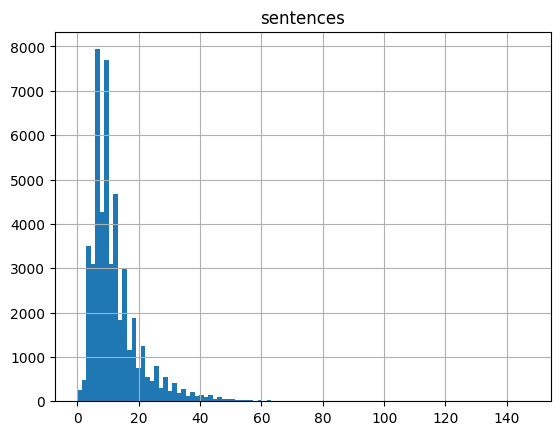

In [115]:
df.hist(column='sentences',bins=100)
print(len(df[df['sentences'] == 1]))
print(len(df[df['sentences'] == 2]))
print(len(df[df['sentences'] == 3]))

In [249]:
subset_df = df[(df['sentences'] <= 2) & (df['sentences'] > 0)]

subset_df['review'] = subset_df.apply(lambda row: get_first_sentence(row['review']), axis=1)
subset_df

/tmp/ipykernel_50383/3636135015.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df['review'] = subset_df.apply(lambda row: get_first_sentence(row['review']), axis=1)


,review,sentiment,sentences
184,"A very ordinary made-for-tv product, ""Tyson"" a...",negative,2
231,I think this is one hell of a movie..........,positive,2
245,I have seen this film at least 100 times and I...,positive,2
264,please re-watch all 3 series and do not go see...,negative,2
413,"A rating of ""1"" does not begin to express how ...",negative,1
...,...,...,...
49515,"A quite easy to watch tale of 2 thieves, with ...",positive,2
49553,"What this film has is its realism , you really...",negative,2
49646,"Awful dreams, wild premonitions, blasphemy and...",positive,2
49744,I saw this Film one midnight and I can say tha...,negative,2


In [250]:
clean_df = subset_df.reset_index().drop(columns='index')

In [251]:
clean_df

,review,sentiment,sentences
0,"A very ordinary made-for-tv product, ""Tyson"" a...",negative,2
1,I think this is one hell of a movie..........,positive,2
2,I have seen this film at least 100 times and I...,positive,2
3,please re-watch all 3 series and do not go see...,negative,2
4,"A rating of ""1"" does not begin to express how ...",negative,1
...,...,...,...
644,"A quite easy to watch tale of 2 thieves, with ...",positive,2
645,"What this film has is its realism , you really...",negative,2
646,"Awful dreams, wild premonitions, blasphemy and...",positive,2
647,I saw this Film one midnight and I can say tha...,negative,2


### Filtering by Words

[[<AxesSubplot: title={'center': 'words'}>]]
317


,review,sentiment,sentences,words
0,I think this is one hell of a movie..........,positive,2,9
1,"A rating of ""1"" does not begin to express how ...",negative,1,18
2,I sat through this on TV hoping because of the...,negative,2,29
3,The problem is the role of the characters in t...,negative,2,11
4,Probably New Zealands worst Movie ever madeThe...,negative,2,12
...,...,...,...,...
312,This movie is a desperate attempt to ride the ...,negative,2,18
313,"A quite easy to watch tale of 2 thieves, with ...",positive,2,16
314,"Awful dreams, wild premonitions, blasphemy and...",positive,2,25
315,I saw this Film one midnight and I can say tha...,negative,2,21


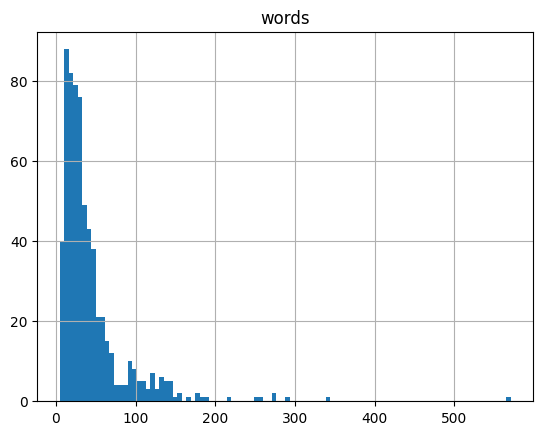

In [371]:
clean_df['words'] = clean_df.apply(lambda row: len(row['review'].split(' ')), axis=1)
print(clean_df.hist(column='words',bins=100))
final_df = clean_df[clean_df['words'] < 30].reset_index().drop(columns='index')
print(len(final_df))
final_df

In [372]:
i = 20
print(final_df['review'][i])
print(final_df['sentiment'][i])

Yash Raj films are so funny, whatever works they follow it yet they are called the best production house?
negative


In [373]:
final_df = final_df.drop([0, 18,19,20,36,120,122,134, 141], axis=0).reset_index().drop(columns='index')

In [375]:
final_df.to_csv('IMDB_Dataset_small_clean.csv')

In [17]:
tokenizer(df['review'][1])

{'input_ids': [2, 21, 5934, 265, 637, 9, 13, 1, 5145, 13, 118, 1, 5145, 13, 118, 1, 124, 7075, 4873, 25, 253, 367, 9755, 723, 68, 8, 253, 315, 8, 891, 8, 24188, 3161, 17, 2352, 21, 18224, 15, 17, 1030, 19937, 68, 15, 1259, 16, 18443, 20, 14, 1078, 1855, 9, 13, 1, 5145, 13, 118, 1, 5145, 13, 118, 1, 124, 4977, 50, 3898, 134, 2519, 8, 832, 39, 219, 52, 104, 13, 7, 6482, 330, 65, 14, 8166, 49, 7, 47, 24, 63, 65, 14, 5333, 125, 2678, 266, 187, 42, 92, 4574, 196, 14, 13927, 923, 9510, 8907, 34, 14, 7231, 20, 2145, 22, 9923, 11399, 15, 52, 104, 25, 32, 134, 2715, 14, 1953, 47, 32, 25, 21, 27729, 102, 642, 17, 986, 1855, 9, 21, 1129, 1566, 637, 88, 53, 16, 14, 374, 1129, 22, 18, 16, 2459, 17, 33, 201, 9, 13, 1, 5145, 13, 118, 1, 5145, 13, 118, 1, 124, 18443, 510, 1624, 213, 29, 14, 265, 564, 45, 14, 4906, 16, 14, 1611, 56, 15, 864, 119, 275, 14, 1361, 13, 22, 16206, 22, 4212, 1678, 2941, 94, 20341, 9, 32, 1533, 27, 318, 1918, 17, 318, 11060, 15, 1653, 29, 14, 3918, 6477, 54, 444, 17, 554, 49,

## Text Attack

In [2]:
import pandas as pd
df = pd.read_csv("IMDB_Dataset_small_clean.csv", squeeze=True)
df = df.drop(["Unnamed: 0","sentences","words"], axis=1)
df.loc[df["sentiment"] == "positive", "sentiment"] = 1
df.loc[df["sentiment"] == "negative", "sentiment"] = 0
df

/tmp/ipykernel_202965/917959648.py:2: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  df = pd.read_csv("IMDB_Dataset_small_clean.csv", squeeze=True)


,review,sentiment
0,"A rating of ""1"" does not begin to express how ...",0
1,I sat through this on TV hoping because of the...,0
2,The problem is the role of the characters in t...,0
3,Probably New Zealands worst Movie ever madeThe...,0
4,"Cheap, amateurish, unimaginative, exploitative...",0
...,...,...
303,This movie is a desperate attempt to ride the ...,0
304,"A quite easy to watch tale of 2 thieves, with ...",1
305,"Awful dreams, wild premonitions, blasphemy and...",1
306,I saw this Film one midnight and I can say tha...,0


In [3]:
import textattack
textattack_dataset = textattack.datasets.Dataset([(row.review, row.sentiment) for row in df.itertuples(index=False)])

In [4]:
from textattack import Attacker, AttackArgs
from textattack.attack_recipes import TextFoolerJin2019

attack = TextFoolerJin2019.build(model_wrapper)
attack_args = AttackArgs(num_examples=-1, log_to_csv="textfooler_results.csv", csv_coloring_style="html")
attacker = Attacker(attack, textattack_dataset, attack_args)

attacker.attack_dataset()

textattack: Unknown if model of class <class 'transformers.models.albert.modeling_albert.AlbertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
textattack: Logging to CSV at path results.csv


Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  delete
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapEmbedding(
    (max_candidates):  50
    (embedding):  WordEmbedding
  )
  (constraints): 
    (0): WordEmbeddingDistance(
        (embedding):  WordEmbedding
        (min_cos_sim):  0.5
        (cased):  False
        (include_unknown_words):  True
        (compare_against_original):  True
      )
    (1): PartOfSpeech(
        (tagger_type):  nltk
        (tagset):  universal
        (allow_verb_noun_swap):  True
        (compare_against_original):  True
      )
    (2): UniversalSentenceEncoder(
        (metric):  angular
        (threshold):  0.840845057
        (window_size):  15
        (skip_text_shorter_than_window):  True
        (compare_against_original):  False
      )
    (3): RepeatModification
    (4): StopwordModification
    (5): InputColumnModification(
        (matching_column_labels):  ['premise', 'hypothesis']
       

  0%|                                                                                                       | 0/308 [00:00<?, ?it/s]2022-11-24 22:30:19.403824: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-24 22:30:19.404098: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/cuda/include:/usr/lib/cuda/lib64::/home/felix/.mujoco/mujoco210/bin:/usr/lib/nvidia
2022-11-24 22:30:19.404272: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/cuda/include:/u

--------------------------------------------- Result 1 ---------------------------------------------
[[0 (100%)]] --> [[1 (60%)]]

A [[rating]] of "1" does not [[begin]] to [[express]] how [[dull]], [[depressing]] and [[relentlessly]] [[bad]] this [[movie]] is.

A [[notations]] of "1" does not [[outset]] to [[shown]] how [[ghoulish]], [[harrowing]] and [[passionately]] [[nasty]] this [[movies]] is.




[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:   1%|▎                                      | 2/308 [01:16<3:15:31, 38.34s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[0 (99%)]] --> [[1 (55%)]]

[[I]] sat through this on [[TV]] [[hoping]] [[because]] of the names in it that it would be [[worth]] the time...but dear Gussie, whoever thought this script was worth [[producing]]?

[[me]] sat through this on [[TELLY]] [[meantime]] [[as]] of the names in it that it would be [[worthy]] the time...but dear Gussie, whoever thought this script was worth [[growers]]?




[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:   1%|▍                                      | 3/308 [01:17<2:10:38, 25.70s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[0 (82%)]] --> [[1 (94%)]]

The [[problem]] is the role of the characters in the film.

The [[themes]] is the role of the characters in the film.




[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:   1%|▌                                      | 4/308 [01:17<1:38:07, 19.37s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[0 (100%)]] --> [[1 (76%)]]

Probably New Zealands [[worst]] Movie ever madeThe Jokes They are not funny.

Probably New Zealands [[finest]] Movie ever madeThe Jokes They are not funny.




[Succeeded / Failed / Skipped / Total] 5 / 0 / 1 / 6:   2%|▊                                      | 6/308 [01:19<1:06:23, 13.19s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[0 (100%)]] --> [[1 (54%)]]

[[Cheap]], amateurish, [[unimaginative]], exploitative... but don't [[think]] it'll [[have]] [[redeeming]] [[amusement]] [[value]].About as unentertaining, uninstructive and just plain [[dull]] as a [[film]] can be.

[[Cheapest]], amateurish, [[uninspiring]], exploitative... but don't [[brainchild]] it'll [[be]] [[redemption]] [[delight]] [[appreciated]].About as unentertaining, uninstructive and just plain [[irksome]] as a [[films]] can be.


--------------------------------------------- Result 6 ---------------------------------------------
[[1 (66%)]] --> [[[SKIPPED]]]

Robert Wagner is the evil boss of Digicron, a telecommunications company with a virus that kills people.




[Succeeded / Failed / Skipped / Total] 6 / 0 / 1 / 7:   2%|▉                                        | 7/308 [01:19<56:57, 11.35s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[1 (88%)]] --> [[0 (68%)]]

I've been a Jennifer Connelly fan since Phenomena, and after I heard about seven minutes in heaven, I saw it as [[soon]] as I could.

I've been a Jennifer Connelly fan since Phenomena, and after I heard about seven minutes in heaven, I saw it as [[tad]] as I could.




[Succeeded / Failed / Skipped / Total] 7 / 0 / 2 / 9:   3%|█▏                                       | 9/308 [01:19<44:11,  8.87s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[0 (100%)]] --> [[1 (97%)]]

This movie was so incredibly [[boring]], Michael J. Fox could've done so much better.

This movie was so incredibly [[pierce]], Michael J. Fox could've done so much better.


--------------------------------------------- Result 9 ---------------------------------------------
[[1 (94%)]] --> [[[SKIPPED]]]

this could have been better,but it was alright...it helped me get away from my boredom.




[Succeeded / Failed / Skipped / Total] 8 / 0 / 2 / 10:   3%|█▎                                     | 10/308 [01:20<39:45,  8.01s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[0 (99%)]] --> [[1 (82%)]]

Pet Sematary , [[though]] a nice 80's Horror movie, with a nice Director and atmosphere, IS a copy of the Italian movie ZEDER by Pupi Avati.

Pet Sematary , [[besides]] a nice 80's Horror movie, with a nice Director and atmosphere, IS a copy of the Italian movie ZEDER by Pupi Avati.




[Succeeded / Failed / Skipped / Total] 9 / 0 / 2 / 11:   4%|█▍                                     | 11/308 [01:20<36:16,  7.33s/it]

--------------------------------------------- Result 11 ---------------------------------------------
[[1 (100%)]] --> [[0 (55%)]]

Although I'm a girl, thankfully I have a sense of humor and realize that this [[really]] IS a [[funny]] anime!

Although I'm a girl, thankfully I have a sense of humor and realize that this [[admittedly]] IS a [[outlandish]] anime!




[Succeeded / Failed / Skipped / Total] 10 / 0 / 2 / 12:   4%|█▍                                    | 12/308 [01:20<33:17,  6.75s/it]

--------------------------------------------- Result 12 ---------------------------------------------
[[1 (99%)]] --> [[0 (63%)]]

This movie deals with the European ERASMUS exchange program but more [[generally]] about the European youth.

This movie deals with the European ERASMUS exchange program but more [[conventionally]] about the European youth.




[Succeeded / Failed / Skipped / Total] 11 / 0 / 3 / 14:   5%|█▋                                    | 14/308 [01:21<28:35,  5.83s/it]

--------------------------------------------- Result 13 ---------------------------------------------
[[1 (97%)]] --> [[0 (73%)]]

The [[true]] [[story]] of Phoolan Devi who became a national hero in India because she fought for her rights as a woman but in a violent manner.

The [[actual]] [[storeys]] of Phoolan Devi who became a national hero in India because she fought for her rights as a woman but in a violent manner.


--------------------------------------------- Result 14 ---------------------------------------------
[[0 (85%)]] --> [[[SKIPPED]]]

Turning Isherwood's somewhat dark and utterly brilliant novel into light comedic romp could easily have been a recipe for disaster, but somewhow it wasn't .




[Succeeded / Failed / Skipped / Total] 12 / 0 / 4 / 16:   5%|█▉                                    | 16/308 [01:22<25:04,  5.15s/it]

--------------------------------------------- Result 15 ---------------------------------------------
[[1 (99%)]] --> [[0 (50%)]]

[[This]] is a [[great]] [[movie]]!

[[That]] is a [[sizable]] [[photographer]]!


--------------------------------------------- Result 16 ---------------------------------------------
[[1 (71%)]] --> [[[SKIPPED]]]

I understand there was some conflict between Leigh and the great Maggie Smith during the filming.




[Succeeded / Failed / Skipped / Total] 13 / 0 / 4 / 17:   6%|██                                    | 17/308 [01:22<23:39,  4.88s/it]

--------------------------------------------- Result 17 ---------------------------------------------
[[0 (99%)]] --> [[1 (62%)]]

I never thought [[I]] would absolutly hate an Arnold Schwartzeneggar [[film]], BUT this is is [[dreadful]] from the get go.

I never thought [[me]] would absolutly hate an Arnold Schwartzeneggar [[cinematographers]], BUT this is is [[abhorrent]] from the get go.




[Succeeded / Failed / Skipped / Total] 14 / 0 / 4 / 18:   6%|██▏                                   | 18/308 [01:23<22:29,  4.65s/it]

--------------------------------------------- Result 18 ---------------------------------------------
[[1 (100%)]] --> [[0 (73%)]]

It's been said before--Strangers on a [[Train]] is Hitchcock's [[best]] movie--and he's made [[so]] [[many]] good ones!

It's been said before--Strangers on a [[Railroad]] is Hitchcock's [[more]] movie--and he's made [[tad]] [[batch]] good ones!




[Succeeded / Failed / Skipped / Total] 15 / 0 / 4 / 19:   6%|██▎                                   | 19/308 [01:24<21:18,  4.43s/it]

--------------------------------------------- Result 19 ---------------------------------------------
[[0 (99%)]] --> [[1 (51%)]]

Ned aKelly is such an important story to Australians but this movie is [[awful]].

Ned aKelly is such an important story to Australians but this movie is [[scary]].




[Succeeded / Failed / Skipped / Total] 16 / 0 / 4 / 20:   6%|██▍                                   | 20/308 [01:24<20:14,  4.22s/it]

--------------------------------------------- Result 20 ---------------------------------------------
[[0 (99%)]] --> [[1 (98%)]]

Long, [[boring]], blasphemous.Never have I been so glad to see ending credits roll.

Long, [[drilled]], blasphemous.Never have I been so glad to see ending credits roll.




[Succeeded / Failed / Skipped / Total] 17 / 0 / 4 / 21:   7%|██▌                                   | 21/308 [01:24<19:18,  4.04s/it]

--------------------------------------------- Result 21 ---------------------------------------------
[[1 (100%)]] --> [[0 (96%)]]

The [[best]] horror/sci-fi movie i have ever seen.

The [[more]] horror/sci-fi movie i have ever seen.




[Succeeded / Failed / Skipped / Total] 18 / 0 / 4 / 22:   7%|██▋                                   | 22/308 [01:24<18:24,  3.86s/it]

--------------------------------------------- Result 22 ---------------------------------------------
[[0 (62%)]] --> [[1 (92%)]]

Well, this may be one of the worst movies ever, but [[atleast]] there are some nice t*ts in it.

Well, this may be one of the worst movies ever, but [[actualy]] there are some nice t*ts in it.




[Succeeded / Failed / Skipped / Total] 19 / 0 / 4 / 23:   7%|██▊                                   | 23/308 [01:26<17:46,  3.74s/it]

--------------------------------------------- Result 23 ---------------------------------------------
[[1 (100%)]] --> [[0 (99%)]]

[[This]] is a [[really]] [[interesting]] [[film]].

[[That]] is a [[openly]] [[tempting]] [[cinematographer]].




[Succeeded / Failed / Skipped / Total] 20 / 0 / 4 / 24:   8%|██▉                                   | 24/308 [01:26<17:02,  3.60s/it]

--------------------------------------------- Result 24 ---------------------------------------------
[[0 (98%)]] --> [[1 (91%)]]

Malcolm McDowell has not had too many good movies lately and this is no [[different]].Especially designed for people who like Yellow filters on their movies.

Malcolm McDowell has not had too many good movies lately and this is no [[disjointed]].Especially designed for people who like Yellow filters on their movies.




[Succeeded / Failed / Skipped / Total] 21 / 0 / 4 / 25:   8%|███                                   | 25/308 [01:26<16:23,  3.48s/it]

--------------------------------------------- Result 25 ---------------------------------------------
[[0 (99%)]] --> [[1 (61%)]]

[[Boring]], [[predictable]], by-the-numbers horror outing at least has pretty good special effects and plenty of (mindless) mayhem and gore to satisfy (mindless) genre fans.

[[Boron]], [[anticipate]], by-the-numbers horror outing at least has pretty good special effects and plenty of (mindless) mayhem and gore to satisfy (mindless) genre fans.




[Succeeded / Failed / Skipped / Total] 21 / 1 / 4 / 26:   8%|███▏                                  | 26/308 [01:30<16:17,  3.47s/it]

--------------------------------------------- Result 26 ---------------------------------------------
[[1 (100%)]] --> [[[FAILED]]]

The Buddy Holly Story is a great biography with a super performance from Gary Busey.Busey did his own singing for this film and he does a great job.




[Succeeded / Failed / Skipped / Total] 22 / 1 / 4 / 27:   9%|███▎                                  | 27/308 [01:30<15:45,  3.36s/it]

--------------------------------------------- Result 27 ---------------------------------------------
[[1 (90%)]] --> [[0 (53%)]]

One of my [[favorite]] scenes is at the beginning when [[guests]] on a private [[yacht]] decide to take an impromptu swim - in their underwear!Rather risqué for 1931!

One of my [[opted]] scenes is at the beginning when [[shoppers]] on a private [[boat]] decide to take an impromptu swim - in their underwear!Rather risqué for 1931!




[Succeeded / Failed / Skipped / Total] 23 / 1 / 4 / 28:   9%|███▍                                  | 28/308 [01:31<15:15,  3.27s/it]

--------------------------------------------- Result 28 ---------------------------------------------
[[0 (99%)]] --> [[1 (67%)]]

[[I]] [[know]] that the real story of Little Richard is a lot more thrilling than this [[maudlin]] and thoroughly average biopic.

[[me]] [[savoir]] that the real story of Little Richard is a lot more thrilling than this [[sentimentalism]] and thoroughly average biopic.




[Succeeded / Failed / Skipped / Total] 24 / 1 / 4 / 29:   9%|███▌                                  | 29/308 [01:33<15:02,  3.23s/it]

--------------------------------------------- Result 29 ---------------------------------------------
[[0 (100%)]] --> [[1 (67%)]]

[[So]] that´s what I [[called]] a [[bad]], [[bad]] film... [[Poor]] acting, [[poor]] [[directing]], [[terrible]] [[writing]]!

[[Conversely]] that´s what I [[solicited]] a [[unfavorable]], [[adverse]] film... [[Poverty]] acting, [[vulnerable]] [[steers]], [[tragic]] [[writer]]!




[Succeeded / Failed / Skipped / Total] 25 / 1 / 4 / 30:  10%|███▋                                  | 30/308 [01:34<14:31,  3.14s/it]

--------------------------------------------- Result 30 ---------------------------------------------
[[1 (100%)]] --> [[0 (99%)]]

The biggest heroes, is one of the [[greatest]] movies ever.

The biggest heroes, is one of the [[lousiest]] movies ever.




[Succeeded / Failed / Skipped / Total] 26 / 1 / 4 / 31:  10%|███▊                                  | 31/308 [01:34<14:04,  3.05s/it]

--------------------------------------------- Result 31 ---------------------------------------------
[[1 (99%)]] --> [[0 (98%)]]

This film has special effects which for it's time are very [[impressive]].

This film has special effects which for it's time are very [[stupendous]].




[Succeeded / Failed / Skipped / Total] 27 / 1 / 4 / 32:  10%|███▉                                  | 32/308 [01:34<13:38,  2.96s/it]

--------------------------------------------- Result 32 ---------------------------------------------
[[1 (99%)]] --> [[0 (98%)]]

I really [[enjoyed]] this movie... In My DVD collection of baseball movies... Reminded me how great the sport truly is... Whether it's here in America or Japan.

I really [[wanted]] this movie... In My DVD collection of baseball movies... Reminded me how great the sport truly is... Whether it's here in America or Japan.




[Succeeded / Failed / Skipped / Total] 28 / 1 / 5 / 34:  11%|████▏                                 | 34/308 [01:35<12:47,  2.80s/it]

--------------------------------------------- Result 33 ---------------------------------------------
[[1 (100%)]] --> [[0 (99%)]]

Simply one of the [[greatest]] films ever made.

Simply one of the [[worst]] films ever made.


--------------------------------------------- Result 34 ---------------------------------------------
[[0 (93%)]] --> [[[SKIPPED]]]

Ever since I heard of the Ralph Bakshi version of "The Lord of the Rings" I wondered: What the hell is 'rotoscope' animation?




[Succeeded / Failed / Skipped / Total] 29 / 1 / 5 / 35:  11%|████▎                                 | 35/308 [01:36<12:35,  2.77s/it]

--------------------------------------------- Result 35 ---------------------------------------------
[[1 (100%)]] --> [[0 (99%)]]

A [[wonderful]] story...[[so]] [[beautiful]] [[told]].

A [[unbelievable]] story...[[additionally]] [[super]] [[reported]].




[Succeeded / Failed / Skipped / Total] 30 / 1 / 5 / 36:  12%|████▍                                 | 36/308 [01:37<12:17,  2.71s/it]

--------------------------------------------- Result 36 ---------------------------------------------
[[1 (100%)]] --> [[0 (74%)]]

This [[movie]] was a [[suprise]] for me while I was [[surfing]] from channel to channel... I don't know why but it filled in me with warmth and [[happiness]].

This [[cinema]] was a [[hadnt]] for me while I was [[surfed]] from channel to channel... I don't know why but it filled in me with warmth and [[contented]].




[Succeeded / Failed / Skipped / Total] 31 / 1 / 5 / 37:  12%|████▌                                 | 37/308 [01:38<11:58,  2.65s/it]

--------------------------------------------- Result 37 ---------------------------------------------
[[1 (96%)]] --> [[0 (99%)]]

This film was [[Excellent]], I thought that the original one was quiet mediocre.

This film was [[Ravishing]], I thought that the original one was quiet mediocre.




[Succeeded / Failed / Skipped / Total] 32 / 1 / 5 / 38:  12%|████▋                                 | 38/308 [01:38<11:42,  2.60s/it]

--------------------------------------------- Result 38 ---------------------------------------------
[[1 (98%)]] --> [[0 (74%)]]

Farrah [[Fawcett]] gives an [[award]] nominated [[performance]] as an attempted rape victim who turns the tables on her attacker.

Farrah [[Farrah]] gives an [[recompense]] nominated [[results]] as an attempted rape victim who turns the tables on her attacker.




[Succeeded / Failed / Skipped / Total] 33 / 1 / 5 / 39:  13%|████▊                                 | 39/308 [01:39<11:27,  2.55s/it]

--------------------------------------------- Result 39 ---------------------------------------------
[[1 (100%)]] --> [[0 (89%)]]

My definition of a [[great]] movie is if you want to [[continue]] to see it over again.

My definition of a [[prodigious]] movie is if you want to [[remain]] to see it over again.




[Succeeded / Failed / Skipped / Total] 34 / 1 / 5 / 40:  13%|████▉                                 | 40/308 [01:39<11:09,  2.50s/it]

--------------------------------------------- Result 40 ---------------------------------------------
[[1 (98%)]] --> [[0 (94%)]]

This is not the stuff of soap-operas but the sort of conundrums that real [[people]] face in real life.

This is not the stuff of soap-operas but the sort of conundrums that real [[gens]] face in real life.




[Succeeded / Failed / Skipped / Total] 35 / 1 / 5 / 41:  13%|█████                                 | 41/308 [01:40<10:54,  2.45s/it]

--------------------------------------------- Result 41 ---------------------------------------------
[[1 (99%)]] --> [[0 (99%)]]

i would [[give]] this [[movie]] an 8.5 or a 9.

i would [[let]] this [[cine]] an 8.5 or a 9.




[Succeeded / Failed / Skipped / Total] 36 / 1 / 5 / 42:  14%|█████▏                                | 42/308 [01:41<10:45,  2.43s/it]

--------------------------------------------- Result 42 ---------------------------------------------
[[0 (100%)]] --> [[1 (85%)]]

[[Probably]] one of the [[worst]] [[movies]] ever [[made]], I'm still [[trying]] to figure if it was meant to be fun, but for sure I had no [[fun]] at all.

[[Undoubtedly]] one of the [[nastiest]] [[films]] ever [[achieved]], I'm still [[seductive]] to figure if it was meant to be fun, but for sure I had no [[delightful]] at all.




[Succeeded / Failed / Skipped / Total] 37 / 1 / 5 / 43:  14%|█████▎                                | 43/308 [01:45<10:50,  2.45s/it]

--------------------------------------------- Result 43 ---------------------------------------------
[[1 (100%)]] --> [[0 (73%)]]

[[In]] my [[opinion]], [[October]] Sky is one of the [[best]] movies of 1999...It [[totally]] [[has]] everything an [[emotional]] [[drama]] [[movie]] would need, like, [[wonderful]] [[story]] and [[good]] [[character]] [[interactions]].

[[Onto]] my [[idea]], [[September]] Sky is one of the [[advisable]] movies of 1999...It [[thoroughly]] [[holds]] everything an [[corny]] [[filmmaking]] [[scorsese]] would need, like, [[delicious]] [[storybooks]] and [[decent]] [[idiosyncrasies]] [[interacting]].




[Succeeded / Failed / Skipped / Total] 38 / 1 / 5 / 44:  14%|█████▍                                | 44/308 [01:47<10:43,  2.44s/it]

--------------------------------------------- Result 44 ---------------------------------------------
[[0 (100%)]] --> [[1 (97%)]]

Cool [[idea]]... [[botched]] [[writing]], [[botched]] [[directing]], [[botched]] [[editing]], [[botched]] [[acting]].

Cool [[insights]]... [[botch]] [[writting]], [[mishandled]] [[culminate]], [[mishandled]] [[editions]], [[mishandled]] [[caretaker]].




[Succeeded / Failed / Skipped / Total] 39 / 1 / 6 / 46:  15%|█████▋                                | 46/308 [01:47<10:12,  2.34s/it]

--------------------------------------------- Result 45 ---------------------------------------------
[[1 (52%)]] --> [[0 (94%)]]

'It's easy to kill a monster, but it's [[hard]] to kill a human being.

'It's easy to kill a monster, but it's [[inhospitable]] to kill a human being.


--------------------------------------------- Result 46 ---------------------------------------------
[[0 (66%)]] --> [[[SKIPPED]]]

by the way it looks at the other comments made, it seems that a lot of people did not get the point to the flick.




[Succeeded / Failed / Skipped / Total] 40 / 1 / 6 / 47:  15%|█████▊                                | 47/308 [01:47<09:59,  2.30s/it]

--------------------------------------------- Result 47 ---------------------------------------------
[[1 (100%)]] --> [[0 (94%)]]

[[After]] 30+ years of hiatus, once again I immerse myself in the mist of uplifting [[melancholy]].

[[Unless]] 30+ years of hiatus, once again I immerse myself in the mist of uplifting [[gloomy]].




[Succeeded / Failed / Skipped / Total] 41 / 1 / 6 / 48:  16%|█████▉                                | 48/308 [01:48<09:48,  2.26s/it]

--------------------------------------------- Result 48 ---------------------------------------------
[[0 (99%)]] --> [[1 (64%)]]

[[Outlandish]] [[premise]] that rates low on plausibility and unfortunately also struggles feebly to raise [[laughs]] or interest.

[[Surrealistic]] [[assumed]] that rates low on plausibility and unfortunately also struggles feebly to raise [[risa]] or interest.




[Succeeded / Failed / Skipped / Total] 42 / 1 / 7 / 50:  16%|██████▏                               | 50/308 [01:49<09:24,  2.19s/it]

--------------------------------------------- Result 49 ---------------------------------------------
[[0 (100%)]] --> [[1 (66%)]]

Were I not with friends, and so cheap, I would have walked out.It [[failed]] [[miserably]] as satire and didn't even have the redemption of camp.

Were I not with friends, and so cheap, I would have walked out.It [[omission]] [[terrifically]] as satire and didn't even have the redemption of camp.


--------------------------------------------- Result 50 ---------------------------------------------
[[1 (100%)]] --> [[[SKIPPED]]]

If it wasn't for the terrific music, I would not hesitate to give this cinematic underachievement 2/10.




[Succeeded / Failed / Skipped / Total] 43 / 1 / 7 / 51:  17%|██████▎                               | 51/308 [01:49<09:13,  2.16s/it]

--------------------------------------------- Result 51 ---------------------------------------------
[[0 (100%)]] --> [[1 (99%)]]

Really [[bad]] Italian horror movie, a sort of remake of Hammer infamous Frankenstein must be destroyed, this time with a lady Frankenstein taking over the business from father.

Really [[inauspicious]] Italian horror movie, a sort of remake of Hammer infamous Frankenstein must be destroyed, this time with a lady Frankenstein taking over the business from father.




[Succeeded / Failed / Skipped / Total] 44 / 1 / 8 / 53:  17%|██████▌                               | 53/308 [01:50<08:49,  2.08s/it]

--------------------------------------------- Result 52 ---------------------------------------------
[[1 (100%)]] --> [[0 (92%)]]

Although it has been remade several times, this movie is a [[classic]] if you are seeing it for the first time.

Although it has been remade several times, this movie is a [[conventional]] if you are seeing it for the first time.


--------------------------------------------- Result 53 ---------------------------------------------
[[0 (99%)]] --> [[[SKIPPED]]]

As long as you go into this movie knowing that it's terrible: bad acting, bad "effects," bad story, bad... everything, then you'll love it.




[Succeeded / Failed / Skipped / Total] 45 / 1 / 8 / 54:  18%|██████▋                               | 54/308 [01:50<08:41,  2.05s/it]

--------------------------------------------- Result 54 ---------------------------------------------
[[0 (93%)]] --> [[1 (57%)]]

I wish they would just [[make]] a special section in the video [[rental]] stores for movies like this.

I wish they would just [[create]] a special section in the video [[locations]] stores for movies like this.




[Succeeded / Failed / Skipped / Total] 46 / 1 / 8 / 55:  18%|██████▊                               | 55/308 [01:51<08:31,  2.02s/it]

--------------------------------------------- Result 55 ---------------------------------------------
[[1 (100%)]] --> [[0 (79%)]]

A [[fine]] western, following the fate of those who possess the prize winning gun, a Winchester '73.

A [[jamil]] western, following the fate of those who possess the prize winning gun, a Winchester '73.




[Succeeded / Failed / Skipped / Total] 47 / 1 / 8 / 56:  18%|██████▉                               | 56/308 [01:51<08:21,  1.99s/it]

--------------------------------------------- Result 56 ---------------------------------------------
[[0 (92%)]] --> [[1 (83%)]]

I decided to hire out this movie along with a few other [[old]] horror movies.

I decided to hire out this movie along with a few other [[past]] horror movies.




[Succeeded / Failed / Skipped / Total] 48 / 1 / 8 / 57:  19%|███████                               | 57/308 [01:51<08:12,  1.96s/it]

--------------------------------------------- Result 57 ---------------------------------------------
[[1 (99%)]] --> [[0 (83%)]]

For pure gothic vampire cheese nothing can [[compare]] to the Subspecies films.I highly [[recommend]] each and every one of them.

For pure gothic vampire cheese nothing can [[akin]] to the Subspecies films.I highly [[suggested]] each and every one of them.




[Succeeded / Failed / Skipped / Total] 49 / 1 / 8 / 58:  19%|███████▏                              | 58/308 [01:52<08:04,  1.94s/it]

--------------------------------------------- Result 58 ---------------------------------------------
[[1 (96%)]] --> [[0 (54%)]]

Did Sandra (yes, she must have) [[know]] we would still be here for her some nine years [[later]]?

Did Sandra (yes, she must have) [[listened]] we would still be here for her some nine years [[yet]]?




[Succeeded / Failed / Skipped / Total] 50 / 1 / 8 / 59:  19%|███████▎                              | 59/308 [01:52<07:55,  1.91s/it]

--------------------------------------------- Result 59 ---------------------------------------------
[[1 (96%)]] --> [[0 (81%)]]

It is nice to see a show that has a little more content than just blood and guts for a [[change]]!

It is nice to see a show that has a little more content than just blood and guts for a [[metamorphosis]]!




[Succeeded / Failed / Skipped / Total] 51 / 1 / 9 / 61:  20%|███████▌                              | 61/308 [01:55<07:46,  1.89s/it]

--------------------------------------------- Result 60 ---------------------------------------------
[[1 (100%)]] --> [[0 (54%)]]

A [[great]] [[film]] in its [[genre]], the [[direction]], [[acting]], most [[especially]] the [[casting]] of the [[film]] [[makes]] it even more [[powerful]].A must see.

A [[large]] [[filmmakers]] in its [[blokes]], the [[aimer]], [[interim]], most [[peculiarly]] the [[molded]] of the [[pictures]] [[paying]] it even more [[pompous]].A must see.


--------------------------------------------- Result 61 ---------------------------------------------
[[0 (80%)]] --> [[[SKIPPED]]]

its too bad that no one knows anything about this movie, and it gets old telling people it's rap's version of spinal tap.




[Succeeded / Failed / Skipped / Total] 52 / 1 / 9 / 62:  20%|███████▋                              | 62/308 [01:55<07:38,  1.86s/it]

--------------------------------------------- Result 62 ---------------------------------------------
[[1 (99%)]] --> [[0 (92%)]]

[[Nicely]] done evil little comedy pitting the FBI against organized crime with a nice lady caught in the middle.

[[Mildly]] done evil little comedy pitting the FBI against organized crime with a nice lady caught in the middle.




[Succeeded / Failed / Skipped / Total] 53 / 1 / 9 / 63:  20%|███████▊                              | 63/308 [01:56<07:31,  1.84s/it]

--------------------------------------------- Result 63 ---------------------------------------------
[[1 (100%)]] --> [[0 (84%)]]

Otto Preminger's "Porgy and Bess" [[stands]], to date, as a [[great]] American musical.

Otto Preminger's "Porgy and Bess" [[bleachers]], to date, as a [[gargantuan]] American musical.




[Succeeded / Failed / Skipped / Total] 54 / 1 / 10 / 65:  21%|███████▊                             | 65/308 [01:57<07:18,  1.81s/it]

--------------------------------------------- Result 64 ---------------------------------------------
[[1 (100%)]] --> [[0 (59%)]]

One of those TV films you [[saw]] in the seventies that [[scared]] the hell out of you when you were a kid but still [[gives]] you an eerie feeling.

One of those TV films you [[suvs]] in the seventies that [[horror]] the hell out of you when you were a kid but still [[prescribes]] you an eerie feeling.


--------------------------------------------- Result 65 ---------------------------------------------
[[1 (87%)]] --> [[[SKIPPED]]]

Well, I am SO glad I watched this on HBO instead of paying for it in the theaters or video store.




[Succeeded / Failed / Skipped / Total] 55 / 1 / 10 / 66:  21%|███████▉                             | 66/308 [01:58<07:13,  1.79s/it]

--------------------------------------------- Result 66 ---------------------------------------------
[[0 (100%)]] --> [[1 (96%)]]

Despite its interesting [[premise]], 'Sniper' is quite [[tedious]].With a tighter script and sharper directing it could have been electrifying; instead it plods along with [[little]] tension.

Despite its interesting [[screenplay]], 'Sniper' is quite [[difficult]].With a tighter script and sharper directing it could have been electrifying; instead it plods along with [[lite]] tension.




[Succeeded / Failed / Skipped / Total] 56 / 1 / 11 / 68:  22%|████████▏                            | 68/308 [01:58<06:59,  1.75s/it]

--------------------------------------------- Result 67 ---------------------------------------------
[[1 (100%)]] --> [[0 (50%)]]

this is a [[great]] movie for all Corey Feldman [[fans]].

this is a [[sizable]] movie for all Corey Feldman [[amateurs]].


--------------------------------------------- Result 68 ---------------------------------------------
[[1 (98%)]] --> [[[SKIPPED]]]

Working with one of the best Shakespeare sources, this film manages to be creditable to it's source, whilst still appealing to a wider audience.




[Succeeded / Failed / Skipped / Total] 57 / 1 / 11 / 69:  22%|████████▎                            | 69/308 [01:59<06:53,  1.73s/it]

--------------------------------------------- Result 69 ---------------------------------------------
[[0 (99%)]] --> [[1 (59%)]]

No offense to anyone who saw this and liked it, but I [[hated]] it!

No offense to anyone who saw this and liked it, but I [[reviled]] it!




[Succeeded / Failed / Skipped / Total] 58 / 1 / 11 / 70:  23%|████████▍                            | 70/308 [01:59<06:47,  1.71s/it]

--------------------------------------------- Result 70 ---------------------------------------------
[[0 (99%)]] --> [[1 (54%)]]

This movie was 100% [[boring]], i [[swear]] i almost died from boredom at the theater.

This movie was 100% [[drilled]], i [[juror]] i almost died from boredom at the theater.




[Succeeded / Failed / Skipped / Total] 59 / 1 / 11 / 71:  23%|████████▌                            | 71/308 [02:00<06:42,  1.70s/it]

--------------------------------------------- Result 71 ---------------------------------------------
[[0 (99%)]] --> [[1 (62%)]]

[[I]] wouldn't [[rent]] this one even on [[dollar]] [[rental]] [[night]].

[[me]] wouldn't [[commended]] this one even on [[aussie]] [[hiring]] [[nights]].




[Succeeded / Failed / Skipped / Total] 60 / 1 / 11 / 72:  23%|████████▋                            | 72/308 [02:00<06:36,  1.68s/it]

--------------------------------------------- Result 72 ---------------------------------------------
[[1 (99%)]] --> [[0 (100%)]]

This is one of the [[funniest]] movies I have ever seen.

This is one of the [[lamest]] movies I have ever seen.




[Succeeded / Failed / Skipped / Total] 61 / 1 / 11 / 73:  24%|████████▊                            | 73/308 [02:01<06:32,  1.67s/it]

--------------------------------------------- Result 73 ---------------------------------------------
[[0 (100%)]] --> [[1 (56%)]]

Pretty [[dreadful]] [[movie]] about several [[unbalanced]] young [[people]] in a car starts off reasonably well but becomes more bizarre and hard to swallow as it progresses.

Pretty [[shocking]] [[cinema]] about several [[unequal]] young [[compatriots]] in a car starts off reasonably well but becomes more bizarre and hard to swallow as it progresses.




[Succeeded / Failed / Skipped / Total] 62 / 1 / 11 / 74:  24%|████████▉                            | 74/308 [02:02<06:27,  1.65s/it]

--------------------------------------------- Result 74 ---------------------------------------------
[[1 (100%)]] --> [[0 (87%)]]

i found the story to be just enough of a thriller that the wonderful henry mancici music didn't [[lull]] me.

i found the story to be just enough of a thriller that the wonderful henry mancici music didn't [[reprieve]] me.




[Succeeded / Failed / Skipped / Total] 63 / 1 / 11 / 75:  24%|█████████                            | 75/308 [02:02<06:21,  1.64s/it]

--------------------------------------------- Result 75 ---------------------------------------------
[[0 (82%)]] --> [[1 (67%)]]

This movie shows me, that americans have no [[knowledge]] about the situation in the sad balkan-brother war!

This movie shows me, that americans have no [[savoir]] about the situation in the sad balkan-brother war!




[Succeeded / Failed / Skipped / Total] 64 / 1 / 11 / 76:  25%|█████████▏                           | 76/308 [02:03<06:17,  1.63s/it]

--------------------------------------------- Result 76 ---------------------------------------------
[[1 (100%)]] --> [[0 (61%)]]

This [[film]] captures the [[true]] struggle with [[identity]] that is [[ongoing]] in our teenage years.

This [[cine]] captures the [[presentable]] struggle with [[characterization]] that is [[persists]] in our teenage years.




[Succeeded / Failed / Skipped / Total] 65 / 1 / 11 / 77:  25%|█████████▎                           | 77/308 [02:04<06:13,  1.62s/it]

--------------------------------------------- Result 77 ---------------------------------------------
[[1 (93%)]] --> [[0 (54%)]]

This film lingered and lingered at a small movie theater in town, and the word-of-mouth buzz [[got]] me to [[see]] it.

This film lingered and lingered at a small movie theater in town, and the word-of-mouth buzz [[could]] me to [[voir]] it.




[Succeeded / Failed / Skipped / Total] 66 / 1 / 11 / 78:  25%|█████████▎                           | 78/308 [02:04<06:08,  1.60s/it]

--------------------------------------------- Result 78 ---------------------------------------------
[[1 (98%)]] --> [[0 (79%)]]

I have probably seen this movie over fifty times by now because of the kids they just [[cant]] get enough of Spirit.

I have probably seen this movie over fifty times by now because of the kids they just [[aint]] get enough of Spirit.




[Succeeded / Failed / Skipped / Total] 66 / 2 / 12 / 80:  26%|█████████▌                           | 80/308 [02:07<06:02,  1.59s/it]

--------------------------------------------- Result 79 ---------------------------------------------
[[0 (99%)]] --> [[[FAILED]]]

Despite the high ratings given to this film by IMDB users, this is nothing more than your typical girl-with-a-bad-childhood-obsessively-stalks-married-man film.


--------------------------------------------- Result 80 ---------------------------------------------
[[1 (100%)]] --> [[[SKIPPED]]]

More suspenseful, more subtle, much, much more disturbing....




[Succeeded / Failed / Skipped / Total] 67 / 2 / 12 / 81:  26%|█████████▋                           | 81/308 [02:08<05:58,  1.58s/it]

--------------------------------------------- Result 81 ---------------------------------------------
[[1 (100%)]] --> [[0 (64%)]]

Moonwalker is such a [[great]] [[movie]], from start to [[finish]] you cant take your [[eyes]] [[away]].

Moonwalker is such a [[prodigious]] [[cinematographers]], from start to [[terminates]] you cant take your [[squinting]] [[out]].




[Succeeded / Failed / Skipped / Total] 68 / 2 / 12 / 82:  27%|█████████▊                           | 82/308 [02:08<05:53,  1.56s/it]

--------------------------------------------- Result 82 ---------------------------------------------
[[1 (99%)]] --> [[0 (87%)]]

I don't believe it... Luc Besson is not only a genius now...he has always been one... this film is for everyone who likes real good deep films...just [[perfect]]!

I don't believe it... Luc Besson is not only a genius now...he has always been one... this film is for everyone who likes real good deep films...just [[spotless]]!




[Succeeded / Failed / Skipped / Total] 69 / 2 / 12 / 83:  27%|█████████▉                           | 83/308 [02:08<05:49,  1.55s/it]

--------------------------------------------- Result 83 ---------------------------------------------
[[1 (100%)]] --> [[0 (77%)]]

not a Larry Mcmurty masterpiece but it stands on its own as a [[good]] western, any of the [[lonesome]] [[doves]] do.

not a Larry Mcmurty masterpiece but it stands on its own as a [[presentable]] western, any of the [[isolated]] [[starlings]] do.




[Succeeded / Failed / Skipped / Total] 70 / 2 / 12 / 84:  27%|██████████                           | 84/308 [02:10<05:48,  1.55s/it]

--------------------------------------------- Result 84 ---------------------------------------------
[[1 (100%)]] --> [[0 (50%)]]

I [[found]] this a [[very]] [[enjoyable]] light [[hearted]] [[comedy]] [[set]] in Wales with some truly funny sequences highlighting the rivalry between two funeral directors.

I [[visualized]] this a [[terribly]] [[delectable]] light [[mannered]] [[caricature]] [[establishment]] in Wales with some truly funny sequences highlighting the rivalry between two funeral directors.




[Succeeded / Failed / Skipped / Total] 71 / 2 / 13 / 86:  28%|██████████▎                          | 86/308 [02:10<05:37,  1.52s/it]

--------------------------------------------- Result 85 ---------------------------------------------
[[0 (99%)]] --> [[1 (62%)]]

I cant go for long describing this tittle, simply because I do not feel [[strong]] about it.

I cant go for long describing this tittle, simply because I do not feel [[heavy]] about it.


--------------------------------------------- Result 86 ---------------------------------------------
[[1 (99%)]] --> [[[SKIPPED]]]

Great movie - especially the music - Etta James - "At Last".This speaks volumes when you have finally found that special someone.




[Succeeded / Failed / Skipped / Total] 72 / 2 / 13 / 87:  28%|██████████▍                          | 87/308 [02:13<05:38,  1.53s/it]

--------------------------------------------- Result 87 ---------------------------------------------
[[1 (99%)]] --> [[0 (80%)]]

[[If]] you've ever [[had]] a [[mad]] week-end out with your [[mates]] then you'll [[appreciate]] this [[film]].Excellent [[fun]] and a [[laugh]] a [[minute]].

[[After]] you've ever [[did]] a [[batshit]] week-end out with your [[lads]] then you'll [[recognising]] this [[cinematographers]].Excellent [[hoot]] and a [[kidding]] a [[secs]].




[Succeeded / Failed / Skipped / Total] 73 / 2 / 14 / 89:  29%|██████████▋                          | 89/308 [02:13<05:28,  1.50s/it]

--------------------------------------------- Result 88 ---------------------------------------------
[[1 (99%)]] --> [[0 (64%)]]

[[A]] very [[comical]] but down to [[earth]] look into the behind the scene workings of an Australian bowling club.

[[another]] very [[preposterous]] but down to [[iand]] look into the behind the scene workings of an Australian bowling club.


--------------------------------------------- Result 89 ---------------------------------------------
[[1 (83%)]] --> [[[SKIPPED]]]

The Disney studios' remake of their own 1965 slapstick classic concerns a clever feline leading an F.B.I. agent to a kidnapped woman.




[Succeeded / Failed / Skipped / Total] 74 / 2 / 14 / 90:  29%|██████████▊                          | 90/308 [02:13<05:24,  1.49s/it]

--------------------------------------------- Result 90 ---------------------------------------------
[[0 (99%)]] --> [[1 (60%)]]

I know this is a made for TV movie, and the acting in made for TV movies is usually sub-par, but it's absolutely [[horrendous]] in this film.

I know this is a made for TV movie, and the acting in made for TV movies is usually sub-par, but it's absolutely [[monstrous]] in this film.




[Succeeded / Failed / Skipped / Total] 75 / 2 / 14 / 91:  30%|██████████▉                          | 91/308 [02:14<05:21,  1.48s/it]

--------------------------------------------- Result 91 ---------------------------------------------
[[1 (100%)]] --> [[0 (57%)]]

In my opinion this is the [[best]] Oliver Stone flick -- [[probably]] more because of Bogosian's influence than anything else.

In my opinion this is the [[presentable]] Oliver Stone flick -- [[supposedly]] more because of Bogosian's influence than anything else.




[Succeeded / Failed / Skipped / Total] 77 / 2 / 14 / 93:  30%|███████████▏                         | 93/308 [02:15<05:12,  1.45s/it]

--------------------------------------------- Result 92 ---------------------------------------------
[[0 (63%)]] --> [[1 (64%)]]

one day someone [[said]] lets redo the mod squad we can make it hip cool and all that YO!

one day someone [[stated]] lets redo the mod squad we can make it hip cool and all that YO!


--------------------------------------------- Result 93 ---------------------------------------------
[[0 (96%)]] --> [[1 (83%)]]

Well, i thought the movie was [[blah]] 1/10.

Well, i thought the movie was [[yadda]] 1/10.




[Succeeded / Failed / Skipped / Total] 78 / 2 / 14 / 94:  31%|███████████▎                         | 94/308 [02:15<05:08,  1.44s/it]

--------------------------------------------- Result 94 ---------------------------------------------
[[0 (88%)]] --> [[1 (84%)]]

To begin with its a rip off of the Japanese film Battle Royal except it's [[missing]] the one thing that made BR unique, balls.

To begin with its a rip off of the Japanese film Battle Royal except it's [[lack]] the one thing that made BR unique, balls.




[Succeeded / Failed / Skipped / Total] 79 / 2 / 15 / 96:  31%|███████████▌                         | 96/308 [02:16<05:02,  1.43s/it]

--------------------------------------------- Result 95 ---------------------------------------------
[[0 (99%)]] --> [[1 (59%)]]

[[At]] one [[point]] in this [[waste]] of celluloid, [[Charles]] Dance as some sort of meant-to-be-funny, cyborg [[bad]] guy says "If I had an anus, I'd soil myself".[[Quite]].

[[Of]] one [[respect]] in this [[discards]] of celluloid, [[Caryl]] Dance as some sort of meant-to-be-funny, cyborg [[defective]] guy says "If I had an anus, I'd soil myself".[[Satisfactorily]].


--------------------------------------------- Result 96 ---------------------------------------------
[[1 (87%)]] --> [[[SKIPPED]]]

After eight Moto films the series had run its course, as this last entry demonstrates.




[Succeeded / Failed / Skipped / Total] 80 / 2 / 16 / 98:  32%|███████████▊                         | 98/308 [02:17<04:54,  1.40s/it]

--------------------------------------------- Result 97 ---------------------------------------------
[[0 (99%)]] --> [[1 (96%)]]

This movie is so [[bad]], I knew how it ends right after this little girl killed the first person.

This movie is so [[inauspicious]], I knew how it ends right after this little girl killed the first person.


--------------------------------------------- Result 98 ---------------------------------------------
[[1 (88%)]] --> [[[SKIPPED]]]

Spanish horrors are not bad at all, some are smart with interesting stories, but is not the case of "Second Name".




[Succeeded / Failed / Skipped / Total] 81 / 2 / 16 / 99:  32%|███████████▉                         | 99/308 [02:18<04:51,  1.39s/it]

--------------------------------------------- Result 99 ---------------------------------------------
[[1 (100%)]] --> [[0 (99%)]]

[[I]] think it's one of the [[greatest]] movies which are ever made, and I've seen many... The book is better, but it's still a [[very]] good movie!

[[me]] think it's one of the [[harshest]] movies which are ever made, and I've seen many... The book is better, but it's still a [[too]] good movie!




[Succeeded / Failed / Skipped / Total] 81 / 3 / 16 / 100:  32%|███████████▎                       | 100/308 [02:19<04:50,  1.40s/it]

--------------------------------------------- Result 100 ---------------------------------------------
[[1 (99%)]] --> [[[FAILED]]]

I enjoyed every moment of this movie, even though I knew they could never really be together.




[Succeeded / Failed / Skipped / Total] 82 / 3 / 16 / 101:  33%|███████████▍                       | 101/308 [02:20<04:48,  1.39s/it]

--------------------------------------------- Result 101 ---------------------------------------------
[[0 (95%)]] --> [[1 (59%)]]

I will not even [[make]] any more [[comments]] about this movie.

I will not even [[establish]] any more [[representations]] about this movie.




[Succeeded / Failed / Skipped / Total] 83 / 3 / 16 / 102:  33%|███████████▌                       | 102/308 [02:21<04:45,  1.39s/it]

--------------------------------------------- Result 102 ---------------------------------------------
[[1 (100%)]] --> [[0 (92%)]]

[[Great]] underrated movie great [[action]] good actors and a [[wonderful]] story line.

[[Noteworthy]] underrated movie great [[endeavors]] good actors and a [[unbelievable]] story line.




[Succeeded / Failed / Skipped / Total] 84 / 3 / 16 / 103:  33%|███████████▋                       | 103/308 [02:22<04:42,  1.38s/it]

--------------------------------------------- Result 103 ---------------------------------------------
[[1 (100%)]] --> [[0 (61%)]]

Summer Phoenix did a [[great]] performance where you really feel what she's not [[able]] to feel and you just cannot understand what she has on her mind.

Summer Phoenix did a [[sizable]] performance where you really feel what she's not [[adroit]] to feel and you just cannot understand what she has on her mind.




[Succeeded / Failed / Skipped / Total] 85 / 3 / 16 / 104:  34%|███████████▊                       | 104/308 [02:22<04:39,  1.37s/it]

--------------------------------------------- Result 104 ---------------------------------------------
[[1 (99%)]] --> [[0 (76%)]]

[[Brilliant]] and [[moving]] performances by Tom Courtenay and Peter Finch.

[[Ravishing]] and [[move]] performances by Tom Courtenay and Peter Finch.




[Succeeded / Failed / Skipped / Total] 86 / 3 / 17 / 106:  34%|████████████                       | 106/308 [02:23<04:33,  1.35s/it]

--------------------------------------------- Result 105 ---------------------------------------------
[[0 (100%)]] --> [[1 (58%)]]

The characters are unlikeable and the [[script]] is [[awful]].It's a [[waste]] of the [[talents]] of Deneuve and Auteuil.

The characters are unlikeable and the [[screenplays]] is [[abhorrent]].It's a [[scum]] of the [[talented]] of Deneuve and Auteuil.


--------------------------------------------- Result 106 ---------------------------------------------
[[1 (74%)]] --> [[[SKIPPED]]]

As I said the idea itself was great and it had plenty potential.




[Succeeded / Failed / Skipped / Total] 87 / 3 / 17 / 107:  35%|████████████▏                      | 107/308 [02:23<04:29,  1.34s/it]

--------------------------------------------- Result 107 ---------------------------------------------
[[1 (99%)]] --> [[0 (99%)]]

with very little screen time and money, Dan Katzir [[manages]] to do so much.

with very little screen time and money, Dan Katzir [[administers]] to do so much.




[Succeeded / Failed / Skipped / Total] 88 / 3 / 17 / 108:  35%|████████████▎                      | 108/308 [02:25<04:29,  1.35s/it]

--------------------------------------------- Result 108 ---------------------------------------------
[[0 (99%)]] --> [[1 (65%)]]

Ten [[minutes]] of people spewing [[gallons]] of [[pink]] [[vomit]].Recurring scenes of [[enormous]] [[piles]] of [[dog]] [[excrement]] - [[need]] one say more?

Ten [[recordings]] of people spewing [[cylinders]] of [[surged]] [[burping]].Recurring scenes of [[great]] [[battery]] of [[mastiff]] [[caked]] - [[suffice]] one say more?




[Succeeded / Failed / Skipped / Total] 89 / 3 / 17 / 109:  35%|████████████▍                      | 109/308 [02:26<04:27,  1.34s/it]

--------------------------------------------- Result 109 ---------------------------------------------
[[0 (99%)]] --> [[1 (55%)]]

Once in a while you get [[amazed]] over how [[BAD]] a [[film]] can be, and how in the world anybody could raise money to make this kind of crap.

Once in a while you get [[impressed]] over how [[MALEVOLENT]] a [[cinema]] can be, and how in the world anybody could raise money to make this kind of crap.




[Succeeded / Failed / Skipped / Total] 90 / 3 / 17 / 110:  36%|████████████▌                      | 110/308 [02:27<04:24,  1.34s/it]

--------------------------------------------- Result 110 ---------------------------------------------
[[1 (100%)]] --> [[0 (88%)]]

The creators of south park in their own film here, this is a [[brilliant]] film with a huge [[entertainment]] [[factor]].

The creators of south park in their own film here, this is a [[glossy]] film with a huge [[distraction]] [[constituents]].




[Succeeded / Failed / Skipped / Total] 91 / 3 / 18 / 112:  36%|████████████▋                      | 112/308 [02:27<04:18,  1.32s/it]

--------------------------------------------- Result 111 ---------------------------------------------
[[0 (100%)]] --> [[1 (70%)]]

This movie goes beyond just being [[bad]], it is definitively the [[worst]] movie I have ever seen in my entire life.

This movie goes beyond just being [[reprehensible]], it is definitively the [[shittiest]] movie I have ever seen in my entire life.


--------------------------------------------- Result 112 ---------------------------------------------
[[1 (99%)]] --> [[[SKIPPED]]]

This true story of Carlson's Raiders is more of a Army training film than anything else.




[Succeeded / Failed / Skipped / Total] 92 / 3 / 18 / 113:  37%|████████████▊                      | 113/308 [02:27<04:15,  1.31s/it]

--------------------------------------------- Result 113 ---------------------------------------------
[[0 (99%)]] --> [[1 (60%)]]

This piece of [[crap]], since I can't call it a movie, can be summed up by the following.

This piece of [[goddam]], since I can't call it a movie, can be summed up by the following.




[Succeeded / Failed / Skipped / Total] 93 / 3 / 18 / 114:  37%|████████████▉                      | 114/308 [02:28<04:13,  1.31s/it]

--------------------------------------------- Result 114 ---------------------------------------------
[[1 (100%)]] --> [[0 (60%)]]

As usual, Sean Connery does a [[great]] [[job]].Lawrence Fishburn is good, but I have a hard time not [[seeing]] him as Ike Turner.

As usual, Sean Connery does a [[prodigious]] [[occupation]].Lawrence Fishburn is good, but I have a hard time not [[listen]] him as Ike Turner.




[Succeeded / Failed / Skipped / Total] 95 / 3 / 18 / 116:  38%|█████████████▏                     | 116/308 [02:29<04:07,  1.29s/it]

--------------------------------------------- Result 115 ---------------------------------------------
[[0 (98%)]] --> [[1 (82%)]]

This movie is [[terrible]] but it has some good effects.

This movie is [[abhorrent]] but it has some good effects.


--------------------------------------------- Result 116 ---------------------------------------------
[[1 (99%)]] --> [[0 (64%)]]

As far as horror flicks go, this one is pretty darn [[good]].

As far as horror flicks go, this one is pretty darn [[advisable]].




[Succeeded / Failed / Skipped / Total] 96 / 3 / 18 / 117:  38%|█████████████▎                     | 117/308 [02:29<04:04,  1.28s/it]

--------------------------------------------- Result 117 ---------------------------------------------
[[0 (99%)]] --> [[1 (75%)]]

That's about the only [[redeeming]] quality in a movie that otherwise insults the viewer's intelligence by losing track of time, plot, and reason for being produced.

That's about the only [[redemption]] quality in a movie that otherwise insults the viewer's intelligence by losing track of time, plot, and reason for being produced.




[Succeeded / Failed / Skipped / Total] 97 / 3 / 18 / 118:  38%|█████████████▍                     | 118/308 [02:30<04:02,  1.27s/it]

--------------------------------------------- Result 118 ---------------------------------------------
[[0 (100%)]] --> [[1 (78%)]]

[[Man]], this would have been a [[bad]] episode of the original series.

[[Homeboy]], this would have been a [[unwholesome]] episode of the original series.




[Succeeded / Failed / Skipped / Total] 98 / 3 / 18 / 119:  39%|█████████████▌                     | 119/308 [02:30<03:59,  1.27s/it]

--------------------------------------------- Result 119 ---------------------------------------------
[[0 (99%)]] --> [[1 (99%)]]

Similar story line, done many times before, and this was no [[improvement]].

Similar story line, done many times before, and this was no [[modernize]].




[Succeeded / Failed / Skipped / Total] 99 / 3 / 18 / 120:  39%|█████████████▋                     | 120/308 [02:31<03:57,  1.26s/it]

--------------------------------------------- Result 120 ---------------------------------------------
[[1 (100%)]] --> [[0 (74%)]]

To me, the final scene, in which Harris responds to the press corp, is [[worthy]] of viewing this [[intelligent]] and timeless slice of politics(especially the campaign phase).

To me, the final scene, in which Harris responds to the press corp, is [[laudable]] of viewing this [[malignant]] and timeless slice of politics(especially the campaign phase).




[Succeeded / Failed / Skipped / Total] 100 / 3 / 18 / 121:  39%|█████████████▎                    | 121/308 [02:31<03:54,  1.25s/it]

--------------------------------------------- Result 121 ---------------------------------------------
[[0 (99%)]] --> [[1 (100%)]]

This was one of the [[worst]] movies I have ever seen!

This was one of the [[greatest]] movies I have ever seen!




[Succeeded / Failed / Skipped / Total] 101 / 3 / 18 / 122:  40%|█████████████▍                    | 122/308 [02:32<03:52,  1.25s/it]

--------------------------------------------- Result 122 ---------------------------------------------
[[1 (99%)]] --> [[0 (51%)]]

Brian De Palma's [[undeniable]] [[virtuosity]] can't really camouflage the [[fact]] that his plot here is a thinly disguised "Psycho" carbon copy, but he does provide a genuinely terrifying climax.

Brian De Palma's [[undoubted]] [[musicianship]] can't really camouflage the [[reality]] that his plot here is a thinly disguised "Psycho" carbon copy, but he does provide a genuinely terrifying climax.




[Succeeded / Failed / Skipped / Total] 102 / 3 / 18 / 123:  40%|█████████████▌                    | 123/308 [02:32<03:49,  1.24s/it]

--------------------------------------------- Result 123 ---------------------------------------------
[[0 (100%)]] --> [[1 (78%)]]

[[First]] Off [[Acting]] Is So [[Terrible]] Except For The Actor Who Plays Spencer.

[[Initially]] Off [[Caretaker]] Is So [[Egregious]] Except For The Actor Who Plays Spencer.




[Succeeded / Failed / Skipped / Total] 103 / 3 / 19 / 125:  41%|█████████████▊                    | 125/308 [02:33<03:45,  1.23s/it]

--------------------------------------------- Result 124 ---------------------------------------------
[[0 (99%)]] --> [[1 (52%)]]

[[Definitely]] not [[worth]] the rental, but if you catch it on [[cable]], you'll be pleasantly surprised by the cameos--Iman's [[appearance]] is [[especially]] self-deprecating.

[[Admittedly]] not [[worthwhile]] the rental, but if you catch it on [[cordon]], you'll be pleasantly surprised by the cameos--Iman's [[guise]] is [[particularly]] self-deprecating.


--------------------------------------------- Result 125 ---------------------------------------------
[[0 (96%)]] --> [[[SKIPPED]]]

Since cats have nine lives, I'll give you nine reasons to see this movie:* The kittens Berlioz and Toulouse playing the piano together (so unbelievably cute!




[Succeeded / Failed / Skipped / Total] 104 / 3 / 19 / 126:  41%|█████████████▉                    | 126/308 [02:34<03:42,  1.22s/it]

--------------------------------------------- Result 126 ---------------------------------------------
[[1 (100%)]] --> [[0 (94%)]]

Excellent [[documentary]] that still manages to [[shock]] and enlighten.

Excellent [[handwritten]] that still manages to [[chagrin]] and enlighten.




[Succeeded / Failed / Skipped / Total] 105 / 3 / 19 / 127:  41%|██████████████                    | 127/308 [02:34<03:40,  1.22s/it]

--------------------------------------------- Result 127 ---------------------------------------------
[[0 (83%)]] --> [[1 (85%)]]

The movie is not as [[funny]] as the director's preceding (and only other) movie, Shanghai Noon.

The movie is not as [[slapstick]] as the director's preceding (and only other) movie, Shanghai Noon.




[Succeeded / Failed / Skipped / Total] 106 / 3 / 19 / 128:  42%|██████████████▏                   | 128/308 [02:35<03:38,  1.21s/it]

--------------------------------------------- Result 128 ---------------------------------------------
[[1 (100%)]] --> [[0 (55%)]]

[[Anyone]] who does not find this movie funny, does not [[understand]] simple comedy.

[[Allen]] who does not find this movie funny, does not [[comprehension]] simple comedy.




[Succeeded / Failed / Skipped / Total] 107 / 3 / 19 / 129:  42%|██████████████▏                   | 129/308 [02:35<03:35,  1.21s/it]

--------------------------------------------- Result 129 ---------------------------------------------
[[1 (98%)]] --> [[0 (53%)]]

Based on the [[true]] [[story]] of the FBIs hunt for those who were responsible for the bombing of the World Trade Center Building.

Based on the [[correct]] [[stories]] of the FBIs hunt for those who were responsible for the bombing of the World Trade Center Building.




[Succeeded / Failed / Skipped / Total] 108 / 3 / 19 / 130:  42%|██████████████▎                   | 130/308 [02:35<03:33,  1.20s/it]

--------------------------------------------- Result 130 ---------------------------------------------
[[0 (61%)]] --> [[1 (97%)]]

Thomas Edison had no other reason to make this film except to show that film can capture the electrocution of an [[innocent]] [[elephant]].

Thomas Edison had no other reason to make this film except to show that film can capture the electrocution of an [[perfect]] [[bull]].




[Succeeded / Failed / Skipped / Total] 109 / 3 / 19 / 131:  43%|██████████████▍                   | 131/308 [02:36<03:30,  1.19s/it]

--------------------------------------------- Result 131 ---------------------------------------------
[[0 (96%)]] --> [[1 (79%)]]

I gave Timecop a perfect 10, I gave this 1It's story is very [[boring]], and it has only little to do with the original Timecop.

I gave Timecop a perfect 10, I gave this 1It's story is very [[uninspiring]], and it has only little to do with the original Timecop.




[Succeeded / Failed / Skipped / Total] 110 / 3 / 19 / 132:  43%|██████████████▌                   | 132/308 [02:36<03:29,  1.19s/it]

--------------------------------------------- Result 132 ---------------------------------------------
[[1 (100%)]] --> [[0 (99%)]]

THis was a [[hilarious]] movie and I would [[see]] it again and again.

THis was a [[travesty]] movie and I would [[query]] it again and again.




[Succeeded / Failed / Skipped / Total] 111 / 3 / 19 / 133:  43%|██████████████▋                   | 133/308 [02:37<03:27,  1.18s/it]

--------------------------------------------- Result 133 ---------------------------------------------
[[0 (92%)]] --> [[1 (54%)]]

Hard up, No proper jobs [[going]] down at the [[pit]], why not [[rent]] your kids!

Hard up, No proper jobs [[gonna]] down at the [[exhumation]], why not [[lease]] your kids!




[Succeeded / Failed / Skipped / Total] 112 / 3 / 20 / 135:  44%|██████████████▉                   | 135/308 [02:37<03:22,  1.17s/it]

--------------------------------------------- Result 134 ---------------------------------------------
[[0 (98%)]] --> [[1 (98%)]]

[[Sorry]], gave it a 1, which is the rating I give to movies on which I [[walk]] out or fall [[asleep]].

[[Repented]], gave it a 1, which is the rating I give to movies on which I [[tower]] out or fall [[sleeper]].


--------------------------------------------- Result 135 ---------------------------------------------
[[1 (61%)]] --> [[[SKIPPED]]]

I was talked into watching this movie by a friend who blubbered on about what a cute story this was.




[Succeeded / Failed / Skipped / Total] 113 / 3 / 20 / 136:  44%|███████████████                   | 136/308 [02:38<03:20,  1.16s/it]

--------------------------------------------- Result 136 ---------------------------------------------
[[1 (99%)]] --> [[0 (88%)]]

From a military historian's standpoint, nearly everything in this movie is historically [[accurate]].

From a military historian's standpoint, nearly everything in this movie is historically [[seiko]].




[Succeeded / Failed / Skipped / Total] 114 / 3 / 20 / 137:  44%|███████████████                   | 137/308 [02:38<03:18,  1.16s/it]

--------------------------------------------- Result 137 ---------------------------------------------
[[1 (100%)]] --> [[0 (86%)]]

The [[DVD]] release of this [[superior]] made for TV BBC drama is a more than welcome addition to my [[collection]].

The [[BLURAY]] release of this [[excess]] made for TV BBC drama is a more than welcome addition to my [[solicit]].




[Succeeded / Failed / Skipped / Total] 115 / 3 / 20 / 138:  45%|███████████████▏                  | 138/308 [02:39<03:16,  1.16s/it]

--------------------------------------------- Result 138 ---------------------------------------------
[[0 (98%)]] --> [[1 (95%)]]

If you thought "ROSEMARY'S [[BABY]]" was bad, this one isn't [[much]] [[better]].

If you thought "ROSEMARY'S [[INFANTILE]]" was bad, this one isn't [[eminently]] [[best]].




[Succeeded / Failed / Skipped / Total] 116 / 3 / 20 / 139:  45%|███████████████▎                  | 139/308 [02:39<03:14,  1.15s/it]

--------------------------------------------- Result 139 ---------------------------------------------
[[1 (95%)]] --> [[0 (69%)]]

Because it's late and i'm running short on vocabulary, i will describe this film as "[[beautiful]] and heartbreaking," begging the forgiveness of those who cringe at such cliches.

Because it's late and i'm running short on vocabulary, i will describe this film as "[[beaux]] and heartbreaking," begging the forgiveness of those who cringe at such cliches.




[Succeeded / Failed / Skipped / Total] 117 / 3 / 20 / 140:  45%|███████████████▍                  | 140/308 [02:41<03:13,  1.15s/it]

--------------------------------------------- Result 140 ---------------------------------------------
[[0 (99%)]] --> [[1 (62%)]]

This [[has]] an interesting, albeit somewhat [[fanciful]] sci-fi plot, but it's wasted with [[poor]] direction and shlocky special effects.

This [[is]] an interesting, albeit somewhat [[outlandish]] sci-fi plot, but it's wasted with [[unsuited]] direction and shlocky special effects.




[Succeeded / Failed / Skipped / Total] 118 / 3 / 20 / 141:  46%|███████████████▌                  | 141/308 [02:41<03:11,  1.14s/it]

--------------------------------------------- Result 141 ---------------------------------------------
[[1 (100%)]] --> [[0 (99%)]]

A very [[well]] directed version of Eric Bogosian's stage play.

A very [[too]] directed version of Eric Bogosian's stage play.




[Succeeded / Failed / Skipped / Total] 120 / 3 / 21 / 144:  47%|███████████████▉                  | 144/308 [02:42<03:04,  1.13s/it]

--------------------------------------------- Result 142 ---------------------------------------------
[[1 (99%)]] --> [[0 (71%)]]

I don't know why [[I]] like this movie [[so]] well, but I never get [[tired]] of watching it.

I don't know why [[me]] like this movie [[because]] well, but I never get [[aching]] of watching it.


--------------------------------------------- Result 143 ---------------------------------------------
[[0 (92%)]] --> [[[SKIPPED]]]

A movie you start watching as a late night cable porn....


--------------------------------------------- Result 144 ---------------------------------------------
[[1 (60%)]] --> [[0 (84%)]]

The bottom [[line]] is: if you come looking for a sci-fi thriller/horror film, The Matrix is what you'll like.

The bottom [[iine]] is: if you come looking for a sci-fi thriller/horror film, The Matrix is what you'll like.




[Succeeded / Failed / Skipped / Total] 121 / 3 / 21 / 145:  47%|████████████████                  | 145/308 [02:43<03:03,  1.13s/it]

--------------------------------------------- Result 145 ---------------------------------------------
[[0 (100%)]] --> [[1 (58%)]]

Ok I will sum up this [[movie]]... A [[bunch]] of [[skanky]] British women have some disease that [[basically]] is [[turning]] them into [[zombies]].

Ok I will sum up this [[films]]... A [[sentimentality]] of [[hoe]] British women have some disease that [[crucially]] is [[translate]] them into [[walkers]].




[Succeeded / Failed / Skipped / Total] 122 / 3 / 21 / 146:  47%|████████████████                  | 146/308 [02:43<03:01,  1.12s/it]

--------------------------------------------- Result 146 ---------------------------------------------
[[1 (100%)]] --> [[0 (90%)]]

[[Complete]] entertainment!Although there are many strange things in the movie that the fairy tale itself doesn't have them including the autumn characters (mother and daughter) the general concept rocks.

[[Exhaustive]] entertainment!Although there are many strange things in the movie that the fairy tale itself doesn't have them including the autumn characters (mother and daughter) the general concept rocks.




[Succeeded / Failed / Skipped / Total] 123 / 3 / 21 / 147:  48%|████████████████▏                 | 147/308 [02:44<03:00,  1.12s/it]

--------------------------------------------- Result 147 ---------------------------------------------
[[1 (100%)]] --> [[0 (50%)]]

The one-liners fly so fast in this movie that you can [[watch]] it over and over and still [[catch]] [[new]] ones.By [[far]] one of the [[best]] of this genre.

The one-liners fly so fast in this movie that you can [[see]] it over and over and still [[trapping]] [[ny]] ones.By [[severely]] one of the [[strictest]] of this genre.




[Succeeded / Failed / Skipped / Total] 124 / 3 / 21 / 148:  48%|████████████████▎                 | 148/308 [02:45<02:58,  1.12s/it]

--------------------------------------------- Result 148 ---------------------------------------------
[[0 (99%)]] --> [[1 (57%)]]

I did not like this film at all: The scenario is [[boring]] - and after a while, its primitive [[predictability]] really gets on your nerves.

I did not like this film at all: The scenario is [[grim]] - and after a while, its primitive [[foretell]] really gets on your nerves.




[Succeeded / Failed / Skipped / Total] 125 / 3 / 21 / 149:  48%|████████████████▍                 | 149/308 [02:45<02:57,  1.11s/it]

--------------------------------------------- Result 149 ---------------------------------------------
[[1 (100%)]] --> [[0 (55%)]]

A kinda remake of PLANES TRAINS AND AUTOMOBILES in a [[lot]] of [[ways]].

A kinda remake of PLANES TRAINS AND AUTOMOBILES in a [[batches]] of [[arteries]].




[Succeeded / Failed / Skipped / Total] 126 / 3 / 21 / 150:  49%|████████████████▌                 | 150/308 [02:46<02:55,  1.11s/it]

--------------------------------------------- Result 150 ---------------------------------------------
[[1 (87%)]] --> [[0 (80%)]]

does anybody know why this movie is called the couch [[trip]]?

does anybody know why this movie is called the couch [[itinerant]]?




[Succeeded / Failed / Skipped / Total] 127 / 3 / 21 / 151:  49%|████████████████▋                 | 151/308 [02:47<02:53,  1.11s/it]

--------------------------------------------- Result 151 ---------------------------------------------
[[0 (98%)]] --> [[1 (65%)]]

Don't waste your [[time]] and [[money]] on it.It's not quite as [[bad]] as "Adrenalin", by the same [[director]] but that's not saying much.

Don't waste your [[moment]] and [[sums]] on it.It's not quite as [[amiss]] as "Adrenalin", by the same [[headmistress]] but that's not saying much.




[Succeeded / Failed / Skipped / Total] 128 / 3 / 21 / 152:  49%|████████████████▊                 | 152/308 [02:49<02:53,  1.11s/it]

--------------------------------------------- Result 152 ---------------------------------------------
[[1 (100%)]] --> [[0 (89%)]]

I was particularly [[moved]] by the [[understated]] [[courage]] and [[integrity]] of l'Anglaise, in this [[beautifully]] [[acted]], intellectually and visually compelling film.Thank you [[so]] [[much]], Monsieur le directeur Rohmer.

I was particularly [[conveyed]] by the [[overstated]] [[brave]] and [[validity]] of l'Anglaise, in this [[unbelievably]] [[operated]], intellectually and visually compelling film.Thank you [[conversely]] [[sizeable]], Monsieur le directeur Rohmer.




[Succeeded / Failed / Skipped / Total] 129 / 3 / 21 / 153:  50%|████████████████▉                 | 153/308 [02:49<02:51,  1.11s/it]

--------------------------------------------- Result 153 ---------------------------------------------
[[0 (99%)]] --> [[1 (97%)]]

Read the book, [[forget]] the movie!

Read the book, [[carelessness]] the movie!




[Succeeded / Failed / Skipped / Total] 130 / 3 / 21 / 154:  50%|█████████████████                 | 154/308 [02:50<02:50,  1.11s/it]

--------------------------------------------- Result 154 ---------------------------------------------
[[0 (100%)]] --> [[1 (98%)]]

[[Annoying]], static comedy with a [[painfully]] miscast Peter Sellers as a smarmy, self-centered Casanova who always has his way with the ladies.

[[Unnerving]], static comedy with a [[terrifically]] miscast Peter Sellers as a smarmy, self-centered Casanova who always has his way with the ladies.




[Succeeded / Failed / Skipped / Total] 131 / 3 / 21 / 155:  50%|█████████████████                 | 155/308 [02:50<02:48,  1.10s/it]

--------------------------------------------- Result 155 ---------------------------------------------
[[1 (100%)]] --> [[0 (87%)]]

This is a [[great]] movie.Too bad it is not available on home video.

This is a [[prodigious]] movie.Too bad it is not available on home video.




[Succeeded / Failed / Skipped / Total] 132 / 3 / 21 / 156:  51%|█████████████████▏                | 156/308 [02:51<02:46,  1.10s/it]

--------------------------------------------- Result 156 ---------------------------------------------
[[1 (100%)]] --> [[0 (100%)]]

After a big tip of the hat to Spinal Tap, this movie is [[hilarious]].

After a big tip of the hat to Spinal Tap, this movie is [[travesty]].




[Succeeded / Failed / Skipped / Total] 133 / 3 / 21 / 157:  51%|█████████████████▎                | 157/308 [02:51<02:45,  1.09s/it]

--------------------------------------------- Result 157 ---------------------------------------------
[[1 (100%)]] --> [[0 (60%)]]

This movie is [[specially]] for [[children]] and I think they [[will]] enjoy the movie.

This movie is [[essentially]] for [[brats]] and I think they [[goes]] enjoy the movie.




[Succeeded / Failed / Skipped / Total] 134 / 3 / 22 / 159:  52%|█████████████████▌                | 159/308 [02:52<02:41,  1.08s/it]

--------------------------------------------- Result 158 ---------------------------------------------
[[0 (92%)]] --> [[1 (87%)]]

this movie, while it could be considered an alright [[attempt]] at comedy, is not what the previews made it out to be.

this movie, while it could be considered an alright [[strived]] at comedy, is not what the previews made it out to be.


--------------------------------------------- Result 159 ---------------------------------------------
[[1 (88%)]] --> [[[SKIPPED]]]

I would love to have that two hours of my life back.




[Succeeded / Failed / Skipped / Total] 135 / 3 / 22 / 160:  52%|█████████████████▋                | 160/308 [02:52<02:39,  1.08s/it]

--------------------------------------------- Result 160 ---------------------------------------------
[[1 (98%)]] --> [[0 (76%)]]

Very intelligent language usage of Ali, which you musn't [[miss]]!In one word: (eeh sentence...) Wicked, so keep it [[real]] and pass it on!

Very intelligent language usage of Ali, which you musn't [[hostess]]!In one word: (eeh sentence...) Wicked, so keep it [[factual]] and pass it on!




[Succeeded / Failed / Skipped / Total] 136 / 3 / 22 / 161:  52%|█████████████████▊                | 161/308 [02:53<02:38,  1.08s/it]

--------------------------------------------- Result 161 ---------------------------------------------
[[1 (90%)]] --> [[0 (81%)]]

scarlet coat like most revolution flicks wasnt well [[received]] but is nears [[perfection]] in the art of movie making.

scarlet coat like most revolution flicks wasnt well [[earned]] but is nears [[perfected]] in the art of movie making.




[Succeeded / Failed / Skipped / Total] 137 / 3 / 22 / 162:  53%|█████████████████▉                | 162/308 [02:54<02:36,  1.07s/it]

--------------------------------------------- Result 162 ---------------------------------------------
[[1 (100%)]] --> [[0 (99%)]]

What a [[strange]] atmosphere is being created in the streets and on the Golden Gate Bridge of San Francisco in this [[exciting]] action picture.

What a [[wierd]] atmosphere is being created in the streets and on the Golden Gate Bridge of San Francisco in this [[tempting]] action picture.




[Succeeded / Failed / Skipped / Total] 138 / 3 / 22 / 163:  53%|█████████████████▉                | 163/308 [02:54<02:35,  1.07s/it]

--------------------------------------------- Result 163 ---------------------------------------------
[[1 (78%)]] --> [[0 (89%)]]

Agreeable "Boy's Own Paper" nonsense with a [[sprightly]] performance from Cushing, some amusing rubber monsters, colourful jungle sets, & the ever-welcome appearance of Caroline Munro in animal skins.

Agreeable "Boy's Own Paper" nonsense with a [[lilting]] performance from Cushing, some amusing rubber monsters, colourful jungle sets, & the ever-welcome appearance of Caroline Munro in animal skins.




[Succeeded / Failed / Skipped / Total] 139 / 3 / 22 / 164:  53%|██████████████████                | 164/308 [02:55<02:33,  1.07s/it]

--------------------------------------------- Result 164 ---------------------------------------------
[[1 (99%)]] --> [[0 (99%)]]

A [[wonderful]] story about the consequences of obsessive love with the beautiful romantic back streets of Paris as its location.

A [[unbelievable]] story about the consequences of obsessive love with the beautiful romantic back streets of Paris as its location.




[Succeeded / Failed / Skipped / Total] 140 / 3 / 22 / 165:  54%|██████████████████▏               | 165/308 [02:56<02:32,  1.07s/it]

--------------------------------------------- Result 165 ---------------------------------------------
[[1 (99%)]] --> [[0 (94%)]]

1st watched 8/31/1996 - (Dir-Tim Robbins): [[Very]] thought provoking and very [[well]] done movie on the subject of the death penalty.Deserved more recognition and [[publicity]] than it received.

1st watched 8/31/1996 - (Dir-Tim Robbins): [[Too]] thought provoking and very [[bon]] done movie on the subject of the death penalty.Deserved more recognition and [[outreach]] than it received.




[Succeeded / Failed / Skipped / Total] 142 / 3 / 23 / 168:  55%|██████████████████▌               | 168/308 [02:57<02:27,  1.05s/it]

--------------------------------------------- Result 166 ---------------------------------------------
[[0 (98%)]] --> [[1 (52%)]]

Sickening exploitation trash plays like a bad (and reverse) "Death Wish" ripoff - but the ugly and untalented Tamerlis makes Charles Bronson [[look]] like Al [[Pacino]] with her performance.

Sickening exploitation trash plays like a bad (and reverse) "Death Wish" ripoff - but the ugly and untalented Tamerlis makes Charles Bronson [[watch]] like Al [[Deniro]] with her performance.


--------------------------------------------- Result 167 ---------------------------------------------
[[1 (64%)]] --> [[0 (99%)]]

I admit it's very silly, but I've practically [[memorized]] the damn thing!

I admit it's very silly, but I've practically [[stowed]] the damn thing!


--------------------------------------------- Result 168 ---------------------------------------------
[[0 (86%)]] --> [[[SKIPPED]]]

what was the quote by archbishop tutu at the end of the film abo

[Succeeded / Failed / Skipped / Total] 143 / 3 / 23 / 169:  55%|██████████████████▋               | 169/308 [02:57<02:26,  1.05s/it]

--------------------------------------------- Result 169 ---------------------------------------------
[[0 (100%)]] --> [[1 (100%)]]

very [[badly]] made film, the action/violence scenes are [[ridiculous]].

very [[spectacularly]] made film, the action/violence scenes are [[farcical]].




[Succeeded / Failed / Skipped / Total] 144 / 3 / 23 / 170:  55%|██████████████████▊               | 170/308 [02:58<02:24,  1.05s/it]

--------------------------------------------- Result 170 ---------------------------------------------
[[1 (97%)]] --> [[0 (89%)]]

mature intelligent and highly charged [[melodrama]] unbelivebly filmed in China in 1948.

mature intelligent and highly charged [[corny]] unbelivebly filmed in China in 1948.




[Succeeded / Failed / Skipped / Total] 145 / 3 / 23 / 171:  56%|██████████████████▉               | 171/308 [02:58<02:23,  1.05s/it]

--------------------------------------------- Result 171 ---------------------------------------------
[[1 (98%)]] --> [[0 (79%)]]

[[This]] [[short]] deals with a severely critical writing [[teacher]] whose undiplomatic criticism extends into his everyday life.

[[That]] [[shorter]] deals with a severely critical writing [[profesor]] whose undiplomatic criticism extends into his everyday life.




[Succeeded / Failed / Skipped / Total] 146 / 3 / 23 / 172:  56%|██████████████████▉               | 172/308 [02:59<02:22,  1.05s/it]

--------------------------------------------- Result 172 ---------------------------------------------
[[1 (100%)]] --> [[0 (81%)]]

This film [[brought]] back a lot of good [[memories]] and really [[works]] to give a [[good]] buzz.

This film [[been]] back a lot of good [[keepsakes]] and really [[work]] to give a [[ok]] buzz.




[Succeeded / Failed / Skipped / Total] 147 / 3 / 23 / 173:  56%|███████████████████               | 173/308 [03:00<02:20,  1.04s/it]

--------------------------------------------- Result 173 ---------------------------------------------
[[1 (94%)]] --> [[0 (64%)]]

My [[favorite]] part of this film was the old man's attempt to cure his neighbor's ills by putting the strong medicine in his bath.

My [[chose]] part of this film was the old man's attempt to cure his neighbor's ills by putting the strong medicine in his bath.




[Succeeded / Failed / Skipped / Total] 148 / 3 / 23 / 174:  56%|███████████████████▏              | 174/308 [03:00<02:18,  1.04s/it]

--------------------------------------------- Result 174 ---------------------------------------------
[[0 (99%)]] --> [[1 (56%)]]

It may be difficult to believe, but the basic plot of this [[abysmal]] flick has been lifted from Hitchcock's perennial classic, "Vertigo".

It may be difficult to believe, but the basic plot of this [[horrid]] flick has been lifted from Hitchcock's perennial classic, "Vertigo".




[Succeeded / Failed / Skipped / Total] 149 / 3 / 23 / 175:  57%|███████████████████▎              | 175/308 [03:00<02:17,  1.03s/it]

--------------------------------------------- Result 175 ---------------------------------------------
[[1 (100%)]] --> [[0 (96%)]]

There are very [[few]] movies that are so [[funny]] as this one.

There are very [[meager]] movies that are so [[nosy]] as this one.




[Succeeded / Failed / Skipped / Total] 150 / 3 / 23 / 176:  57%|███████████████████▍              | 176/308 [03:01<02:15,  1.03s/it]

--------------------------------------------- Result 176 ---------------------------------------------
[[0 (99%)]] --> [[1 (59%)]]

Although Twenty Minutes of Love is a [[harmless]] attempt at an early comedy, it was difficult to follow and the film quality was not very good.

Although Twenty Minutes of Love is a [[gentle]] attempt at an early comedy, it was difficult to follow and the film quality was not very good.




[Succeeded / Failed / Skipped / Total] 151 / 3 / 23 / 177:  57%|███████████████████▌              | 177/308 [03:01<02:14,  1.03s/it]

--------------------------------------------- Result 177 ---------------------------------------------
[[1 (96%)]] --> [[0 (91%)]]

I find myself comparing all stand-up acts to this one [[performance]] now.

I find myself comparing all stand-up acts to this one [[executing]] now.




[Succeeded / Failed / Skipped / Total] 152 / 3 / 23 / 178:  58%|███████████████████▋              | 178/308 [03:02<02:13,  1.03s/it]

--------------------------------------------- Result 178 ---------------------------------------------
[[1 (100%)]] --> [[0 (96%)]]

[[This]] documentary is such a [[wonderful]] [[example]] of what an entertaining and amazing experience a documentary can be, if done so [[well]] as this.

[[These]] documentary is such a [[unbelievable]] [[case]] of what an entertaining and amazing experience a documentary can be, if done so [[okay]] as this.




[Succeeded / Failed / Skipped / Total] 153 / 3 / 23 / 179:  58%|███████████████████▊              | 179/308 [03:03<02:12,  1.02s/it]

--------------------------------------------- Result 179 ---------------------------------------------
[[1 (100%)]] --> [[0 (99%)]]

As so many others have written, this is a [[wonderful]] [[documentary]].

As so many others have written, this is a [[unbelievable]] [[typed]].




[Succeeded / Failed / Skipped / Total] 154 / 3 / 23 / 180:  58%|███████████████████▊              | 180/308 [03:03<02:10,  1.02s/it]

--------------------------------------------- Result 180 ---------------------------------------------
[[1 (99%)]] --> [[0 (53%)]]

If you like Pauly Shore, you'll love Son in Law.If you hate Pauly Shore, then, well...I [[liked]] it!

If you like Pauly Shore, you'll love Son in Law.If you hate Pauly Shore, then, well...I [[wanted]] it!




[Succeeded / Failed / Skipped / Total] 155 / 3 / 23 / 181:  59%|███████████████████▉              | 181/308 [03:04<02:09,  1.02s/it]

--------------------------------------------- Result 181 ---------------------------------------------
[[1 (100%)]] --> [[0 (95%)]]

This movie will [[always]] be a Broadway and Movie [[classic]], as long as there are still people who sing, dance, and act.

This movie will [[systematically]] be a Broadway and Movie [[conventional]], as long as there are still people who sing, dance, and act.




[Succeeded / Failed / Skipped / Total] 156 / 3 / 23 / 182:  59%|████████████████████              | 182/308 [03:04<02:07,  1.01s/it]

--------------------------------------------- Result 182 ---------------------------------------------
[[0 (60%)]] --> [[1 (60%)]]

In the process of boring you with the wordy, rambling storyline and the complete [[absence]] of character development, it manages to enforce a few negative black stereotypes out there.

In the process of boring you with the wordy, rambling storyline and the complete [[absent]] of character development, it manages to enforce a few negative black stereotypes out there.




[Succeeded / Failed / Skipped / Total] 157 / 3 / 23 / 183:  59%|████████████████████▏             | 183/308 [03:04<02:06,  1.01s/it]

--------------------------------------------- Result 183 ---------------------------------------------
[[0 (99%)]] --> [[1 (98%)]]

What a script, what a story, what a [[mess]]!

What a script, what a story, what a [[turmoil]]!




[Succeeded / Failed / Skipped / Total] 158 / 3 / 23 / 184:  60%|████████████████████▎             | 184/308 [03:05<02:04,  1.01s/it]

--------------------------------------------- Result 184 ---------------------------------------------
[[1 (92%)]] --> [[0 (57%)]]

Well this was the WWF's last pay per view [[event]] of the millennium and it ended the [[year]] and millennium right.

Well this was the WWF's last pay per view [[accident]] of the millennium and it ended the [[olds]] and millennium right.




[Succeeded / Failed / Skipped / Total] 159 / 3 / 23 / 185:  60%|████████████████████▍             | 185/308 [03:06<02:03,  1.01s/it]

--------------------------------------------- Result 185 ---------------------------------------------
[[1 (99%)]] --> [[0 (54%)]]

[[While]] the romance in this film is an [[important]] aspect, it is largely about the role of responsibility and duty in [[modern]] [[Indian]].

[[Unless]] the romance in this film is an [[prodigious]] aspect, it is largely about the role of responsibility and duty in [[current]] [[Lndian]].




[Succeeded / Failed / Skipped / Total] 160 / 3 / 25 / 188:  61%|████████████████████▊             | 188/308 [03:06<01:59,  1.01it/s]

--------------------------------------------- Result 186 ---------------------------------------------
[[0 (97%)]] --> [[1 (98%)]]

Ming The Merciless does a little Bardwork and a [[movie]] most [[foul]]!

Ming The Merciless does a little Bardwork and a [[panorama]] most [[squalid]]!


--------------------------------------------- Result 187 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

i don't care if you'd like my comment or no but i think that you who write that the movie isn't good.


--------------------------------------------- Result 188 ---------------------------------------------
[[1 (96%)]] --> [[[SKIPPED]]]

THE SEVENTH SIGN has a great opening hook as the Israeli defence force come across a terrorist base .




[Succeeded / Failed / Skipped / Total] 161 / 3 / 25 / 189:  61%|████████████████████▊             | 189/308 [03:07<01:58,  1.01it/s]

--------------------------------------------- Result 189 ---------------------------------------------
[[1 (100%)]] --> [[0 (69%)]]

The [[Claude]] Lelouch's movie is a pretty good [[moment]] of [[cinema]].

The [[Claudius]] Lelouch's movie is a pretty good [[deadline]] of [[cinematographers]].




[Succeeded / Failed / Skipped / Total] 162 / 3 / 25 / 190:  62%|████████████████████▉             | 190/308 [03:08<01:56,  1.01it/s]

--------------------------------------------- Result 190 ---------------------------------------------
[[1 (99%)]] --> [[0 (96%)]]

I [[always]] [[enjoy]] this movie when it shows up on TV.

I [[ever]] [[experience]] this movie when it shows up on TV.




[Succeeded / Failed / Skipped / Total] 163 / 3 / 25 / 191:  62%|█████████████████████             | 191/308 [03:08<01:55,  1.01it/s]

--------------------------------------------- Result 191 ---------------------------------------------
[[1 (99%)]] --> [[0 (96%)]]

[[loved]] the story of a guy that tries to get his girl back....

[[idolized]] the story of a guy that tries to get his girl back....




[Succeeded / Failed / Skipped / Total] 164 / 3 / 25 / 192:  62%|█████████████████████▏            | 192/308 [03:08<01:54,  1.02it/s]

--------------------------------------------- Result 192 ---------------------------------------------
[[0 (100%)]] --> [[1 (99%)]]

[[Excruciatingly]] slow-paced, over-scripted black comedy with a too-clever premise and [[bad]] acting.

[[Terrifically]] slow-paced, over-scripted black comedy with a too-clever premise and [[untoward]] acting.




[Succeeded / Failed / Skipped / Total] 165 / 3 / 25 / 193:  63%|█████████████████████▎            | 193/308 [03:09<01:52,  1.02it/s]

--------------------------------------------- Result 193 ---------------------------------------------
[[1 (84%)]] --> [[0 (85%)]]

I generally [[love]] SRK as a villain (how can you not?

I generally [[iove]] SRK as a villain (how can you not?




[Succeeded / Failed / Skipped / Total] 166 / 3 / 26 / 195:  63%|█████████████████████▌            | 195/308 [03:09<01:49,  1.03it/s]

--------------------------------------------- Result 194 ---------------------------------------------
[[0 (97%)]] --> [[1 (99%)]]

one of the [[worst]] excuses for an irish accents i've heard.

one of the [[finest]] excuses for an irish accents i've heard.


--------------------------------------------- Result 195 ---------------------------------------------
[[1 (76%)]] --> [[[SKIPPED]]]

Jamie Foxx is fun but this movie has been done before.




[Succeeded / Failed / Skipped / Total] 167 / 3 / 26 / 196:  64%|█████████████████████▋            | 196/308 [03:10<01:48,  1.03it/s]

--------------------------------------------- Result 196 ---------------------------------------------
[[0 (98%)]] --> [[1 (59%)]]

I wasn`t expecting much with HARLEM NIGHTS but I wasn`t [[expecting]] it to be as [[bad]] as it was .

I wasn`t expecting much with HARLEM NIGHTS but I wasn`t [[awaiting]] it to be as [[wicked]] as it was .




[Succeeded / Failed / Skipped / Total] 168 / 3 / 26 / 197:  64%|█████████████████████▋            | 197/308 [03:10<01:47,  1.03it/s]

--------------------------------------------- Result 197 ---------------------------------------------
[[1 (99%)]] --> [[0 (80%)]]

A [[fascinating]] look at the relationship of a single father in 1998 and a single mother in 1881, tied together by a time-traveling teenager.

A [[tempting]] look at the relationship of a single father in 1998 and a single mother in 1881, tied together by a time-traveling teenager.


--------------------------------------------- Result 198 ---------------------------------------------


[Succeeded / Failed / Skipped / Total] 169 / 3 / 26 / 198:  64%|█████████████████████▊            | 198/308 [03:10<01:46,  1.04it/s]

[[0 (66%)]] --> [[1 (74%)]]

When you go at an open air cinema under the Greek summer night you usually don't [[care]] what the movie is!

When you go at an open air cinema under the Greek summer night you usually don't [[considerate]] what the movie is!




[Succeeded / Failed / Skipped / Total] 170 / 3 / 27 / 200:  65%|██████████████████████            | 200/308 [03:11<01:43,  1.05it/s]

--------------------------------------------- Result 199 ---------------------------------------------
[[1 (97%)]] --> [[0 (76%)]]

Playwright John Osborne's (Look Back in Anger, The Entertainer) dramatisation of Oscar Wilde's only novel positively revels in the homosexual subtext of the original, [[perhaps]] too much so.

Playwright John Osborne's (Look Back in Anger, The Entertainer) dramatisation of Oscar Wilde's only novel positively revels in the homosexual subtext of the original, [[potentially]] too much so.


--------------------------------------------- Result 200 ---------------------------------------------
[[1 (92%)]] --> [[[SKIPPED]]]

I couldn't stop laughing, I caught this again on late night TV.




[Succeeded / Failed / Skipped / Total] 171 / 3 / 27 / 201:  65%|██████████████████████▏           | 201/308 [03:11<01:41,  1.05it/s]

--------------------------------------------- Result 201 ---------------------------------------------
[[0 (99%)]] --> [[1 (99%)]]

The most [[stupid]] of Seagal's movies I've ever seen.

The most [[farcical]] of Seagal's movies I've ever seen.




[Succeeded / Failed / Skipped / Total] 172 / 3 / 27 / 202:  66%|██████████████████████▎           | 202/308 [03:11<01:40,  1.05it/s]

--------------------------------------------- Result 202 ---------------------------------------------
[[1 (100%)]] --> [[0 (70%)]]

twenty [[years]] later, this movie still remains as [[entertaining]] as when you first watched it.

twenty [[aged]] later, this movie still remains as [[comical]] as when you first watched it.




[Succeeded / Failed / Skipped / Total] 173 / 3 / 27 / 203:  66%|██████████████████████▍           | 203/308 [03:12<01:39,  1.06it/s]

--------------------------------------------- Result 203 ---------------------------------------------
[[0 (62%)]] --> [[1 (87%)]]

i've watched this movie ([[movie]]?

i've watched this movie ([[photo]]?




[Succeeded / Failed / Skipped / Total] 174 / 3 / 27 / 204:  66%|██████████████████████▌           | 204/308 [03:12<01:38,  1.06it/s]

--------------------------------------------- Result 204 ---------------------------------------------
[[0 (92%)]] --> [[1 (96%)]]

Ignoring Rocky 3, this is easily Hulk Hogan's best film, and it still rates as one of the [[worst]] films ever.

Ignoring Rocky 3, this is easily Hulk Hogan's best film, and it still rates as one of the [[shittiest]] films ever.




[Succeeded / Failed / Skipped / Total] 175 / 3 / 27 / 205:  67%|██████████████████████▋           | 205/308 [03:12<01:36,  1.06it/s]

--------------------------------------------- Result 205 ---------------------------------------------
[[1 (100%)]] --> [[0 (99%)]]

THis movie shows us once again, how [[genius]] the Japanese directors are and were.This movie could be seen as a sort of a "Silent - Movie Tetsuo".

THis movie shows us once again, how [[sappers]] the Japanese directors are and were.This movie could be seen as a sort of a "Silent - Movie Tetsuo".




[Succeeded / Failed / Skipped / Total] 176 / 3 / 27 / 206:  67%|██████████████████████▋           | 206/308 [03:13<01:35,  1.07it/s]

--------------------------------------------- Result 206 ---------------------------------------------
[[0 (96%)]] --> [[1 (95%)]]

while watching this piece of [[crap]]!

while watching this piece of [[chit]]!




[Succeeded / Failed / Skipped / Total] 177 / 3 / 27 / 207:  67%|██████████████████████▊           | 207/308 [03:13<01:34,  1.07it/s]

--------------------------------------------- Result 207 ---------------------------------------------
[[0 (100%)]] --> [[1 (95%)]]

i really wanted this to be good as i am from Liverpool where it is set but it truly [[awful]].

i really wanted this to be good as i am from Liverpool where it is set but it truly [[scary]].




[Succeeded / Failed / Skipped / Total] 178 / 3 / 27 / 208:  68%|██████████████████████▉           | 208/308 [03:14<01:33,  1.07it/s]

--------------------------------------------- Result 208 ---------------------------------------------
[[1 (90%)]] --> [[0 (95%)]]

Hartley on low-key form: Martin Donovan, born to play Jesus, comes as [[Messiah]] to millenial Manhatten; P.J. Harvey is [[excellent]] as sidekick Magdelena.

Hartley on low-key form: Martin Donovan, born to play Jesus, comes as [[Judea]] to millenial Manhatten; P.J. Harvey is [[unbelievable]] as sidekick Magdelena.




[Succeeded / Failed / Skipped / Total] 179 / 3 / 27 / 209:  68%|███████████████████████           | 209/308 [03:14<01:32,  1.07it/s]

--------------------------------------------- Result 209 ---------------------------------------------
[[1 (67%)]] --> [[0 (76%)]]

The Book of [[Life]] was rather like a short snack, whetting the appetite for Hartley's next full length movie.

The Book of [[Vie]] was rather like a short snack, whetting the appetite for Hartley's next full length movie.




[Succeeded / Failed / Skipped / Total] 180 / 3 / 27 / 210:  68%|███████████████████████▏          | 210/308 [03:14<01:30,  1.08it/s]

--------------------------------------------- Result 210 ---------------------------------------------
[[1 (99%)]] --> [[0 (89%)]]

This is the [[definitive]] movie version of Hamlet.Branagh cuts nothing, but there are no wasted moments.

This is the [[irrefutable]] movie version of Hamlet.Branagh cuts nothing, but there are no wasted moments.




[Succeeded / Failed / Skipped / Total] 181 / 3 / 27 / 211:  69%|███████████████████████▎          | 211/308 [03:15<01:29,  1.08it/s]

--------------------------------------------- Result 211 ---------------------------------------------
[[1 (100%)]] --> [[0 (70%)]]

[[Brilliant]] kung-fu scenes, loads of melodrama, peculiar footwear symbolism and an unhappy (?) end [[makes]] Barefoot Kid an unforgettable [[film]].

[[Glossy]] kung-fu scenes, loads of melodrama, peculiar footwear symbolism and an unhappy (?) end [[doing]] Barefoot Kid an unforgettable [[theatres]].




[Succeeded / Failed / Skipped / Total] 182 / 3 / 27 / 212:  69%|███████████████████████▍          | 212/308 [03:16<01:28,  1.08it/s]

--------------------------------------------- Result 212 ---------------------------------------------
[[0 (81%)]] --> [[1 (66%)]]

I thought of this [[movie]] when i [[watched]] pluto nash...why.

I thought of this [[image]] when i [[regarded]] pluto nash...why.




[Succeeded / Failed / Skipped / Total] 183 / 3 / 27 / 213:  69%|███████████████████████▌          | 213/308 [03:18<01:28,  1.08it/s]

--------------------------------------------- Result 213 ---------------------------------------------
[[1 (100%)]] --> [[0 (97%)]]

This is a [[superb]] game for the N64 with [[superb]] [[graphics]] and a great one-player story-line and even better multi-player [[game]] best played with 4 [[people]].

This is a [[unbelievable]] game for the N64 with [[unbelievable]] [[charts]] and a great one-player story-line and even better multi-player [[sets]] best played with 4 [[peoples]].




[Succeeded / Failed / Skipped / Total] 184 / 3 / 27 / 214:  69%|███████████████████████▌          | 214/308 [03:18<01:27,  1.08it/s]

--------------------------------------------- Result 214 ---------------------------------------------
[[1 (100%)]] --> [[0 (79%)]]

For Anthony Mann the Western was 'legend'- and 'legend' makes the [[very]] best cinema!

For Anthony Mann the Western was 'legend'- and 'legend' makes the [[too]] best cinema!




[Succeeded / Failed / Skipped / Total] 185 / 3 / 29 / 217:  70%|███████████████████████▉          | 217/308 [03:19<01:23,  1.09it/s]

--------------------------------------------- Result 215 ---------------------------------------------
[[0 (99%)]] --> [[1 (68%)]]

This movie has been [[promoting]] in everywhere in Spain with a huge publicity campaign, after watching it, you realise that someone has [[stolen]] your money.

This movie has been [[enhancing]] in everywhere in Spain with a huge publicity campaign, after watching it, you realise that someone has [[burglary]] your money.


--------------------------------------------- Result 216 ---------------------------------------------
[[1 (89%)]] --> [[[SKIPPED]]]

It's a good movie if you plan to watch lots of landscapes and animals, like an animal documentary.


--------------------------------------------- Result 217 ---------------------------------------------
[[1 (53%)]] --> [[[SKIPPED]]]

I can't believe this movie has an average rating of 7.0!




[Succeeded / Failed / Skipped / Total] 186 / 3 / 29 / 218:  71%|████████████████████████          | 218/308 [03:20<01:22,  1.09it/s]

--------------------------------------------- Result 218 ---------------------------------------------
[[0 (100%)]] --> [[1 (57%)]]

A [[movie]] [[best]] summed up by the scene where a victim [[simulates]] disembowelment by pulling some poor animal's intestines out from under her T-shirt.Too [[terrible]] for [[words]].

A [[cinema]] [[preferably]] summed up by the scene where a victim [[imitates]] disembowelment by pulling some poor animal's intestines out from under her T-shirt.Too [[tragic]] for [[declarations]].




[Succeeded / Failed / Skipped / Total] 187 / 3 / 29 / 219:  71%|████████████████████████▏         | 219/308 [03:21<01:21,  1.09it/s]

--------------------------------------------- Result 219 ---------------------------------------------
[[0 (100%)]] --> [[1 (50%)]]

A really [[terrible]] movie, really low-budget, with [[terrible]] acting, a convoluted and inane plot, a modest reworking of the [[vampire]] tales mixed with modern [[science]].

A really [[towering]] movie, really low-budget, with [[horrible]] acting, a convoluted and inane plot, a modest reworking of the [[volturi]] tales mixed with modern [[savant]].




[Succeeded / Failed / Skipped / Total] 188 / 3 / 29 / 220:  71%|████████████████████████▎         | 220/308 [03:21<01:20,  1.09it/s]

--------------------------------------------- Result 220 ---------------------------------------------
[[1 (99%)]] --> [[0 (54%)]]

A film destined to [[be]] on late-night TV [[long]] after the present instant "money-makers" have long been forgotten.

A film destined to [[fi]] on late-night TV [[most]] after the present instant "money-makers" have long been forgotten.




[Succeeded / Failed / Skipped / Total] 189 / 3 / 29 / 221:  72%|████████████████████████▍         | 221/308 [03:23<01:20,  1.09it/s]

--------------------------------------------- Result 221 ---------------------------------------------
[[1 (100%)]] --> [[0 (51%)]]

a [[mesmerizing]] [[film]] that [[certainly]] [[keeps]] your [[attention]]... Ben Daniels is [[fascinating]] (and courageous) to watch.

a [[hallucinatory]] [[scene]] that [[presumably]] [[persisted]] your [[focusing]]... Ben Daniels is [[appealing]] (and courageous) to watch.




[Succeeded / Failed / Skipped / Total] 190 / 3 / 29 / 222:  72%|████████████████████████▌         | 222/308 [03:24<01:19,  1.08it/s]

--------------------------------------------- Result 222 ---------------------------------------------
[[1 (100%)]] --> [[0 (75%)]]

[[This]] movie includes one of the [[best]] [[characters]] and dialog that Crispin Glover [[has]] ever [[played]].

[[These]] movie includes one of the [[upper]] [[font]] and dialog that Crispin Glover [[gets]] ever [[incurred]].




[Succeeded / Failed / Skipped / Total] 191 / 3 / 29 / 223:  72%|████████████████████████▌         | 223/308 [03:25<01:18,  1.09it/s]

--------------------------------------------- Result 223 ---------------------------------------------
[[0 (88%)]] --> [[1 (63%)]]

I don't usually like TV movies, I reckon that if the [[thing]] was any good it would make it to Hollywood.

I don't usually like TV movies, I reckon that if the [[things]] was any good it would make it to Hollywood.




[Succeeded / Failed / Skipped / Total] 192 / 3 / 29 / 224:  73%|████████████████████████▋         | 224/308 [03:25<01:17,  1.09it/s]

--------------------------------------------- Result 224 ---------------------------------------------
[[1 (92%)]] --> [[0 (61%)]]

When a dowdy wife (Shearer) loses her husband, she decides to completely make herself over to [[win]] him back.

When a dowdy wife (Shearer) loses her husband, she decides to completely make herself over to [[finalist]] him back.




[Succeeded / Failed / Skipped / Total] 193 / 3 / 29 / 225:  73%|████████████████████████▊         | 225/308 [03:26<01:16,  1.09it/s]

--------------------------------------------- Result 225 ---------------------------------------------
[[1 (100%)]] --> [[0 (88%)]]

A [[delightful]] if somewhat predictable TV movie, [[though]] [[I]] admit a little bias -- as far as I'm concered, the more Gene Wilder in this [[world]] the better.

A [[delectable]] if somewhat predictable TV movie, [[although]] [[me]] admit a little bias -- as far as I'm concered, the more Gene Wilder in this [[worid]] the better.




[Succeeded / Failed / Skipped / Total] 194 / 3 / 29 / 226:  73%|████████████████████████▉         | 226/308 [03:26<01:15,  1.09it/s]

--------------------------------------------- Result 226 ---------------------------------------------
[[0 (99%)]] --> [[1 (77%)]]

This norwegian movie is so [[crap]], the actors can not act cause they seems to be reading from a book and the [[story]] is so (wannabe) [[hollywood]].

This norwegian movie is so [[chit]], the actors can not act cause they seems to be reading from a book and the [[epic]] is so (wannabe) [[celebs]].




[Succeeded / Failed / Skipped / Total] 195 / 3 / 29 / 227:  74%|█████████████████████████         | 227/308 [03:27<01:14,  1.09it/s]

--------------------------------------------- Result 227 ---------------------------------------------
[[0 (99%)]] --> [[1 (91%)]]

Outrageously [[trashy]] karate/horror thriller with loads of graphically gory violence and gratuitous nudity, and a thoroughly [[preposterous]] and bizarre "plot".

Outrageously [[skanky]] karate/horror thriller with loads of graphically gory violence and gratuitous nudity, and a thoroughly [[comical]] and bizarre "plot".




[Succeeded / Failed / Skipped / Total] 196 / 3 / 29 / 228:  74%|█████████████████████████▏        | 228/308 [03:28<01:13,  1.09it/s]

--------------------------------------------- Result 228 ---------------------------------------------
[[1 (100%)]] --> [[0 (59%)]]

Everything I can say, is that it's one of the [[best]] documentary movies of the ocean ever [[seen]].

Everything I can say, is that it's one of the [[presentable]] documentary movies of the ocean ever [[viewed]].




[Succeeded / Failed / Skipped / Total] 197 / 3 / 29 / 229:  74%|█████████████████████████▎        | 229/308 [03:28<01:12,  1.10it/s]

--------------------------------------------- Result 229 ---------------------------------------------
[[1 (100%)]] --> [[0 (83%)]]

One of the [[best]] (if not the [[best]]) Stephen King's [[screenings]].

One of the [[strictest]] (if not the [[preferably]]) Stephen King's [[scanners]].




[Succeeded / Failed / Skipped / Total] 198 / 3 / 29 / 230:  75%|█████████████████████████▍        | 230/308 [03:30<01:11,  1.09it/s]

--------------------------------------------- Result 230 ---------------------------------------------
[[1 (100%)]] --> [[0 (68%)]]

I [[have]] [[seen]] this play [[many]] [[times]], from Olivier to Branagh, and this remains the one version that [[always]] stands out in my memory.

I [[did]] [[faced]] this play [[miscellaneous]] [[dated]], from Olivier to Branagh, and this remains the one version that [[periodically]] stands out in my memory.




[Succeeded / Failed / Skipped / Total] 199 / 3 / 29 / 231:  75%|█████████████████████████▌        | 231/308 [03:30<01:10,  1.10it/s]

--------------------------------------------- Result 231 ---------------------------------------------
[[0 (100%)]] --> [[1 (95%)]]

Long on action and stunt work, but so short on character delineation and development that it [[failed]] to hold our interest.

Long on action and stunt work, but so short on character delineation and development that it [[aground]] to hold our interest.




[Succeeded / Failed / Skipped / Total] 200 / 3 / 29 / 232:  75%|█████████████████████████▌        | 232/308 [03:32<01:09,  1.09it/s]

--------------------------------------------- Result 232 ---------------------------------------------
[[1 (99%)]] --> [[0 (99%)]]

[[I]] [[enjoyed]] the [[movie]] and [[Kellie]] Martins [[performance]] [[immensely]].

[[me]] [[wanted]] the [[photograph]] and [[Traci]] Martins [[potency]] [[horribly]].




[Succeeded / Failed / Skipped / Total] 202 / 3 / 30 / 235:  76%|█████████████████████████▉        | 235/308 [03:33<01:06,  1.10it/s]

--------------------------------------------- Result 233 ---------------------------------------------
[[0 (98%)]] --> [[1 (97%)]]

I just [[cant]] see what everyone sees in this movie.

I just [[shes]] see what everyone sees in this movie.


--------------------------------------------- Result 234 ---------------------------------------------
[[1 (88%)]] --> [[[SKIPPED]]]

I have been learning about the Zodiac for four years now.


--------------------------------------------- Result 235 ---------------------------------------------
[[1 (99%)]] --> [[0 (75%)]]

Having seen Rush live, I'm able to appreciate the [[awesomeness]] of this.

Having seen Rush live, I'm able to appreciate the [[silliness]] of this.




[Succeeded / Failed / Skipped / Total] 203 / 3 / 30 / 236:  77%|██████████████████████████        | 236/308 [03:33<01:05,  1.10it/s]

--------------------------------------------- Result 236 ---------------------------------------------
[[1 (99%)]] --> [[0 (98%)]]

Stumbling upon this HBO special late one night, I was [[absolutely]] [[taken]] by this attractive British "executive transvestite".

Stumbling upon this HBO special late one night, I was [[downright]] [[waged]] by this attractive British "executive transvestite".




[Succeeded / Failed / Skipped / Total] 204 / 3 / 30 / 237:  77%|██████████████████████████▏       | 237/308 [03:34<01:04,  1.11it/s]

--------------------------------------------- Result 237 ---------------------------------------------
[[1 (87%)]] --> [[0 (62%)]]

Subject Matter: [[Cosmology]], Quantum Physics and Stephen HawkingSoundtrack: Phillip GlassHave I died and gone to [[Heaven]]?You will be enraptured.

Subject Matter: [[Cosmologists]], Quantum Physics and Stephen HawkingSoundtrack: Phillip GlassHave I died and gone to [[Paradis]]?You will be enraptured.




[Succeeded / Failed / Skipped / Total] 205 / 3 / 30 / 238:  77%|██████████████████████████▎       | 238/308 [03:34<01:03,  1.11it/s]

--------------------------------------------- Result 238 ---------------------------------------------
[[1 (99%)]] --> [[0 (61%)]]

I think the film makes a subtile reference to rouge of Kieslowski, as the whole atmosphere gives me a [[feeling]] of red.

I think the film makes a subtile reference to rouge of Kieslowski, as the whole atmosphere gives me a [[foreboding]] of red.




[Succeeded / Failed / Skipped / Total] 206 / 3 / 30 / 239:  78%|██████████████████████████▍       | 239/308 [03:35<01:02,  1.11it/s]

--------------------------------------------- Result 239 ---------------------------------------------
[[1 (99%)]] --> [[0 (72%)]]

[[Smallville]] episode Justice is the [[best]] [[episode]] of Smallville !

[[Battlestar]] episode Justice is the [[upper]] [[bout]] of Smallville !




[Succeeded / Failed / Skipped / Total] 207 / 3 / 30 / 240:  78%|██████████████████████████▍       | 240/308 [03:35<01:01,  1.11it/s]

--------------------------------------------- Result 240 ---------------------------------------------
[[1 (91%)]] --> [[0 (83%)]]

I [[saw]] this picture in 1940 for $.

I [[seemed]] this picture in 1940 for $.




[Succeeded / Failed / Skipped / Total] 208 / 3 / 30 / 241:  78%|██████████████████████████▌       | 241/308 [03:36<01:00,  1.12it/s]

--------------------------------------------- Result 241 ---------------------------------------------
[[1 (86%)]] --> [[0 (69%)]]

[[Of]] course, he did have to [[INVENT]] EVERYTHING about cinematography, film directing, etc.

[[For]] course, he did have to [[REINVENT]] EVERYTHING about cinematography, film directing, etc.




[Succeeded / Failed / Skipped / Total] 209 / 3 / 30 / 242:  79%|██████████████████████████▋       | 242/308 [03:36<00:59,  1.12it/s]

--------------------------------------------- Result 242 ---------------------------------------------
[[1 (89%)]] --> [[0 (92%)]]

if you are [[dating]] a [[girl]] that is into wicca!

if you are [[stardate]] a [[damsel]] that is into wicca!




[Succeeded / Failed / Skipped / Total] 210 / 3 / 30 / 243:  79%|██████████████████████████▊       | 243/308 [03:37<00:58,  1.12it/s]

--------------------------------------------- Result 243 ---------------------------------------------
[[1 (100%)]] --> [[0 (53%)]]

[[Laughs]], [[adventure]], a [[good]] time, a killer soundtrack, oscar-worthy acting, and special effects/ animitronics like none other, what else could you want in a movie?

[[Crapping]], [[itinerary]], a [[nice]] time, a killer soundtrack, oscar-worthy acting, and special effects/ animitronics like none other, what else could you want in a movie?




[Succeeded / Failed / Skipped / Total] 211 / 3 / 30 / 244:  79%|██████████████████████████▉       | 244/308 [03:39<00:57,  1.11it/s]

--------------------------------------------- Result 244 ---------------------------------------------
[[1 (99%)]] --> [[0 (55%)]]

This is a very [[cool]] [[movie]].The [[ending]] of the [[movie]] is a [[bit]] more defined than the play's [[ending]], but either [[way]] it is [[still]] a good [[movie]].

This is a very [[copacetic]] [[theatres]].The [[ceasing]] of the [[cine]] is a [[bitten]] more defined than the play's [[shutting]], but either [[camino]] it is [[already]] a good [[cine]].




[Succeeded / Failed / Skipped / Total] 212 / 3 / 30 / 245:  80%|███████████████████████████       | 245/308 [03:40<00:56,  1.11it/s]

--------------------------------------------- Result 245 ---------------------------------------------
[[1 (99%)]] --> [[0 (67%)]]

One of eastwood's [[best]] [[movies]] after he [[had]] [[separated]] himself from the westerns.

One of eastwood's [[upper]] [[filmmakers]] after he [[hectare]] [[seperate]] himself from the westerns.




[Succeeded / Failed / Skipped / Total] 213 / 3 / 30 / 246:  80%|███████████████████████████▏      | 246/308 [03:41<00:55,  1.11it/s]

--------------------------------------------- Result 246 ---------------------------------------------
[[1 (100%)]] --> [[0 (98%)]]

Without a doubt, one of [[Tobe]] Hoppor's [[best]]!Epic storytellng, [[great]] [[special]] [[effects]], and The Spacegirl (vamp me [[baby]]!

Without a doubt, one of [[Muffled]] Hoppor's [[advisable]]!Epic storytellng, [[prodigious]] [[grained]] [[effect]], and The Spacegirl (vamp me [[dear]]!




[Succeeded / Failed / Skipped / Total] 214 / 3 / 30 / 247:  80%|███████████████████████████▎      | 247/308 [03:42<00:54,  1.11it/s]

--------------------------------------------- Result 247 ---------------------------------------------
[[1 (100%)]] --> [[0 (76%)]]

this [[took]] me back to my [[childhood]] in the 1950 's [[so]] corny but just fab no one ever could play FLASH GORDON like LARRY BUSTER CRABBE, just great.

this [[went]] me back to my [[enfant]] in the 1950 's [[equally]] corny but just fab no one ever could play FLASH GORDON like LARRY BUSTER CRABBE, just great.




[Succeeded / Failed / Skipped / Total] 215 / 3 / 31 / 249:  81%|███████████████████████████▍      | 249/308 [03:42<00:52,  1.12it/s]

--------------------------------------------- Result 248 ---------------------------------------------
[[1 (98%)]] --> [[0 (60%)]]

This is a bad movie in the traditional sense, but taken for what it is meant to be it is quite [[good]].

This is a bad movie in the traditional sense, but taken for what it is meant to be it is quite [[bonne]].


--------------------------------------------- Result 249 ---------------------------------------------
[[1 (90%)]] --> [[[SKIPPED]]]

Me and a couple of friends went to rent some movies one day, we picked one each and one of us picked Ironheart.




[Succeeded / Failed / Skipped / Total] 216 / 3 / 31 / 250:  81%|███████████████████████████▌      | 250/308 [03:43<00:51,  1.12it/s]

--------------------------------------------- Result 250 ---------------------------------------------
[[0 (81%)]] --> [[1 (60%)]]

I hope this [[group]] of film-makers never re-unites.

I hope this [[associations]] of film-makers never re-unites.




[Succeeded / Failed / Skipped / Total] 217 / 3 / 31 / 251:  81%|███████████████████████████▋      | 251/308 [03:43<00:50,  1.12it/s]

--------------------------------------------- Result 251 ---------------------------------------------
[[1 (98%)]] --> [[0 (91%)]]

despite the occasionally stilted acting and "seen-it-all-before" story, this is a fairly [[compelling]] movie.

despite the occasionally stilted acting and "seen-it-all-before" story, this is a fairly [[unconvincing]] movie.




[Succeeded / Failed / Skipped / Total] 218 / 3 / 31 / 252:  82%|███████████████████████████▊      | 252/308 [03:44<00:49,  1.12it/s]

--------------------------------------------- Result 252 ---------------------------------------------
[[1 (99%)]] --> [[0 (98%)]]

This movie is very [[good]] in term of acting and plot.

This movie is very [[opportune]] in term of acting and plot.




[Succeeded / Failed / Skipped / Total] 219 / 3 / 31 / 253:  82%|███████████████████████████▉      | 253/308 [03:44<00:48,  1.13it/s]

--------------------------------------------- Result 253 ---------------------------------------------
[[0 (99%)]] --> [[1 (99%)]]

THis movie may be the [[worst]] movie I have ever seen.

THis movie may be the [[finest]] movie I have ever seen.




[Succeeded / Failed / Skipped / Total] 220 / 3 / 31 / 254:  82%|████████████████████████████      | 254/308 [03:45<00:47,  1.13it/s]

--------------------------------------------- Result 254 ---------------------------------------------
[[1 (100%)]] --> [[0 (50%)]]

This is actually one of my [[favorite]] [[films]], I would recommend that [[EVERYONE]] watches it.

This is actually one of my [[advocated]] [[cinemas]], I would recommend that [[NOBODY]] watches it.




[Succeeded / Failed / Skipped / Total] 221 / 3 / 31 / 255:  83%|████████████████████████████▏     | 255/308 [03:45<00:46,  1.13it/s]

--------------------------------------------- Result 255 ---------------------------------------------
[[1 (69%)]] --> [[0 (95%)]]

This film is an [[excellent]] teaching tool as a pre-study of "To Kill a Mockingbird".

This film is an [[super]] teaching tool as a pre-study of "To Kill a Mockingbird".




[Succeeded / Failed / Skipped / Total] 222 / 3 / 31 / 256:  83%|████████████████████████████▎     | 256/308 [03:45<00:45,  1.13it/s]

--------------------------------------------- Result 256 ---------------------------------------------
[[1 (99%)]] --> [[0 (100%)]]

One of the [[funniest]] movies made in recent years.

One of the [[lamest]] movies made in recent years.




[Succeeded / Failed / Skipped / Total] 223 / 3 / 31 / 257:  83%|████████████████████████████▎     | 257/308 [03:46<00:44,  1.14it/s]

--------------------------------------------- Result 257 ---------------------------------------------
[[1 (95%)]] --> [[0 (56%)]]

The story is quite [[original]], but the movie is kinda slow building up to the point where they steal the cars.

The story is quite [[first]], but the movie is kinda slow building up to the point where they steal the cars.




[Succeeded / Failed / Skipped / Total] 224 / 3 / 31 / 258:  84%|████████████████████████████▍     | 258/308 [03:46<00:43,  1.14it/s]

--------------------------------------------- Result 258 ---------------------------------------------
[[1 (97%)]] --> [[0 (72%)]]

I had really only been [[exposed]] to Olivier's [[dramatic]] performances, and those were mostly much later films than *Divorce*.

I had really only been [[subjected]] to Olivier's [[fearsome]] performances, and those were mostly much later films than *Divorce*.




[Succeeded / Failed / Skipped / Total] 225 / 3 / 31 / 259:  84%|████████████████████████████▌     | 259/308 [03:47<00:42,  1.14it/s]

--------------------------------------------- Result 259 ---------------------------------------------
[[1 (86%)]] --> [[0 (90%)]]

This should [[be]] required viewing for all young people.

This should [[have]] required viewing for all young people.




[Succeeded / Failed / Skipped / Total] 226 / 3 / 32 / 261:  85%|████████████████████████████▊     | 261/308 [03:47<00:40,  1.15it/s]

--------------------------------------------- Result 260 ---------------------------------------------
[[0 (98%)]] --> [[1 (92%)]]

Although it's been hailed as a comedy-drama I found "Crooklyn" to be mostly [[depressing]].

Although it's been hailed as a comedy-drama I found "Crooklyn" to be mostly [[disheartened]].


--------------------------------------------- Result 261 ---------------------------------------------
[[1 (84%)]] --> [[[SKIPPED]]]

Former brat pack actor and all round pretty boy Rob Lowe stars in a film set in a high security American prison .




[Succeeded / Failed / Skipped / Total] 227 / 3 / 32 / 262:  85%|████████████████████████████▉     | 262/308 [03:47<00:39,  1.15it/s]

--------------------------------------------- Result 262 ---------------------------------------------
[[0 (99%)]] --> [[1 (58%)]]

You may like Tim Burton's fantasies, but not in a commercial-like show off lasting 8 minutes.It demonstrates good technical points without real [[creativity]] or some established narrative pace.

You may like Tim Burton's fantasies, but not in a commercial-like show off lasting 8 minutes.It demonstrates good technical points without real [[creating]] or some established narrative pace.




[Succeeded / Failed / Skipped / Total] 228 / 3 / 32 / 263:  85%|█████████████████████████████     | 263/308 [03:48<00:39,  1.15it/s]

--------------------------------------------- Result 263 ---------------------------------------------
[[1 (100%)]] --> [[0 (77%)]]

I see it when I was 12 year old and I dream to see it again !What [[marvelous]] Sammy Davis Jr singing "it ain't necessarily so "!

I see it when I was 12 year old and I dream to see it again !What [[unbelievable]] Sammy Davis Jr singing "it ain't necessarily so "!




[Succeeded / Failed / Skipped / Total] 229 / 3 / 32 / 264:  86%|█████████████████████████████▏    | 264/308 [03:48<00:38,  1.15it/s]

--------------------------------------------- Result 264 ---------------------------------------------
[[1 (99%)]] --> [[0 (89%)]]

Add this little [[gem]] to your [[list]] of holiday regulars.

Add this little [[bling]] to your [[inventories]] of holiday regulars.




[Succeeded / Failed / Skipped / Total] 230 / 3 / 32 / 265:  86%|█████████████████████████████▎    | 265/308 [03:50<00:37,  1.15it/s]

--------------------------------------------- Result 265 ---------------------------------------------
[[0 (100%)]] --> [[1 (56%)]]

[[bad]] acting , [[combats]] are [[very]] [[awful]] , 3-4 second between each text , bad music , bad effect and always the same plan during the [[movie]].

[[sordid]] acting , [[struggles]] are [[incredibly]] [[harrowing]] , 3-4 second between each text , bad music , bad effect and always the same plan during the [[teatro]].




[Succeeded / Failed / Skipped / Total] 231 / 3 / 32 / 266:  86%|█████████████████████████████▎    | 266/308 [03:50<00:36,  1.15it/s]

--------------------------------------------- Result 266 ---------------------------------------------
[[1 (99%)]] --> [[0 (50%)]]

I [[saw]] this [[film]] on television years ago, but here several years after, I wake up in the morning, and still [[remember]] her face.

I [[complied]] this [[movie]] on television years ago, but here several years after, I wake up in the morning, and still [[reminders]] her face.




[Succeeded / Failed / Skipped / Total] 232 / 3 / 32 / 267:  87%|█████████████████████████████▍    | 267/308 [03:52<00:35,  1.15it/s]

--------------------------------------------- Result 267 ---------------------------------------------
[[0 (100%)]] --> [[1 (53%)]]

no [[comment]] - [[stupid]] [[movie]], acting average or worse... screenplay - no [[sense]] at all... [[SKIP]] [[IT]]!

no [[noting]] - [[imbecilic]] [[panorama]], acting average or worse... screenplay - no [[foreboding]] at all... [[DEDICATE]] [[TI]]!




[Succeeded / Failed / Skipped / Total] 233 / 3 / 33 / 269:  87%|█████████████████████████████▋    | 269/308 [03:53<00:33,  1.15it/s]

--------------------------------------------- Result 268 ---------------------------------------------
[[1 (99%)]] --> [[0 (98%)]]

Hollow Point, [[though]] [[clumsy]] in places, [[manages]] to be an [[extremely]] endearing and amusing action movie.

Hollow Point, [[than]] [[incompetent]] in places, [[operated]] to be an [[heavily]] endearing and amusing action movie.


--------------------------------------------- Result 269 ---------------------------------------------
[[1 (98%)]] --> [[[SKIPPED]]]

this is a below average martial arts films which is worth watching for the comedy value due to the part where a pair of symbols are used as weapons.




[Succeeded / Failed / Skipped / Total] 234 / 3 / 33 / 270:  88%|█████████████████████████████▊    | 270/308 [03:54<00:33,  1.15it/s]

--------------------------------------------- Result 270 ---------------------------------------------
[[1 (100%)]] --> [[0 (77%)]]

Wonderful songs, sprightly [[animation]] and [[authentic]] [[live]] [[action]] make this a [[classic]] [[adaptation]] of a [[classic]] [[tale]].

Wonderful songs, sprightly [[vivid]] and [[real]] [[survive]] [[operating]] make this a [[normal]] [[adaptable]] of a [[emblematic]] [[anecdotes]].




[Succeeded / Failed / Skipped / Total] 235 / 3 / 33 / 271:  88%|█████████████████████████████▉    | 271/308 [03:55<00:32,  1.15it/s]

--------------------------------------------- Result 271 ---------------------------------------------
[[0 (100%)]] --> [[1 (84%)]]

Good performances can't [[save]] this [[terrible]] script, larded with every cliche in the chick-flick book.

Good performances can't [[spare]] this [[outrageous]] script, larded with every cliche in the chick-flick book.




[Succeeded / Failed / Skipped / Total] 236 / 3 / 33 / 272:  88%|██████████████████████████████    | 272/308 [03:55<00:31,  1.15it/s]

--------------------------------------------- Result 272 ---------------------------------------------
[[1 (100%)]] --> [[0 (94%)]]

For a mature man, to admit that he shed a [[tear]] over this film is a [[mature]] response, to a mature film.

For a mature man, to admit that he shed a [[ruptured]] over this film is a [[grownup]] response, to a mature film.




[Succeeded / Failed / Skipped / Total] 237 / 3 / 34 / 274:  89%|██████████████████████████████▏   | 274/308 [03:56<00:29,  1.16it/s]

--------------------------------------------- Result 273 ---------------------------------------------
[[1 (100%)]] --> [[0 (98%)]]

A very [[interesting]] entertainment, with the [[charm]] of the old movies.

A very [[nosy]] entertainment, with the [[luring]] of the old movies.


--------------------------------------------- Result 274 ---------------------------------------------
[[1 (89%)]] --> [[[SKIPPED]]]

an oirish film not made for an irish audience.




[Succeeded / Failed / Skipped / Total] 238 / 3 / 35 / 276:  90%|██████████████████████████████▍   | 276/308 [03:57<00:27,  1.16it/s]

--------------------------------------------- Result 275 ---------------------------------------------
[[0 (71%)]] --> [[1 (63%)]]

This is the movie that I use to judge all other [[bad]] movies, and so far there hasn't been anything close.

This is the movie that I use to judge all other [[poorly]] movies, and so far there hasn't been anything close.


--------------------------------------------- Result 276 ---------------------------------------------
[[1 (80%)]] --> [[[SKIPPED]]]

A dedicated Russian Scientist dreams of going to Mars.




[Succeeded / Failed / Skipped / Total] 239 / 3 / 35 / 277:  90%|██████████████████████████████▌   | 277/308 [03:57<00:26,  1.16it/s]

--------------------------------------------- Result 277 ---------------------------------------------
[[1 (95%)]] --> [[0 (51%)]]

Jimmy Stewart was a [[real]] life pilot, WWII flier and a one-star general in the Air Force and therefore a natural for how [[real]] [[pilots]] react when they fly.

Jimmy Stewart was a [[actual]] life pilot, WWII flier and a one-star general in the Air Force and therefore a natural for how [[hardheaded]] [[demonstrating]] react when they fly.




[Succeeded / Failed / Skipped / Total] 240 / 3 / 35 / 278:  90%|██████████████████████████████▋   | 278/308 [03:58<00:25,  1.17it/s]

--------------------------------------------- Result 278 ---------------------------------------------
[[1 (100%)]] --> [[0 (61%)]]

The acting is good, the action is good, and [[so]] is the plot.

The acting is good, the action is good, and [[instead]] is the plot.




[Succeeded / Failed / Skipped / Total] 241 / 3 / 35 / 279:  91%|██████████████████████████████▊   | 279/308 [03:58<00:24,  1.17it/s]

--------------------------------------------- Result 279 ---------------------------------------------
[[0 (90%)]] --> [[1 (70%)]]

I can't believe they got the actors and actresses of that caliber to [[do]] this movie.That's all I've got to say - the movie speaks for itself!

I can't believe they got the actors and actresses of that caliber to [[know]] this movie.That's all I've got to say - the movie speaks for itself!




[Succeeded / Failed / Skipped / Total] 242 / 3 / 35 / 280:  91%|██████████████████████████████▉   | 280/308 [03:58<00:23,  1.17it/s]

--------------------------------------------- Result 280 ---------------------------------------------
[[1 (99%)]] --> [[0 (79%)]]

This movie has a "big production" [[feel]] that I was not expecting from an independent film.

This movie has a "big production" [[think]] that I was not expecting from an independent film.




[Succeeded / Failed / Skipped / Total] 243 / 3 / 35 / 281:  91%|███████████████████████████████   | 281/308 [03:59<00:22,  1.17it/s]

--------------------------------------------- Result 281 ---------------------------------------------
[[0 (89%)]] --> [[1 (91%)]]

Widow hires a psychopath as a handyman.Sloppy film noir thriller which doesn't make much of its tension [[promising]] set-up.

Widow hires a psychopath as a handyman.Sloppy film noir thriller which doesn't make much of its tension [[vowed]] set-up.




[Succeeded / Failed / Skipped / Total] 244 / 3 / 35 / 282:  92%|███████████████████████████████▏  | 282/308 [03:59<00:22,  1.18it/s]

--------------------------------------------- Result 282 ---------------------------------------------
[[0 (90%)]] --> [[1 (54%)]]

being a NI supporter, it's hard to [[objectively]] [[review]] a movie glorifying ulster nationalists.

being a NI supporter, it's hard to [[impartially]] [[reconsidered]] a movie glorifying ulster nationalists.




[Succeeded / Failed / Skipped / Total] 245 / 3 / 35 / 283:  92%|███████████████████████████████▏  | 283/308 [04:00<00:21,  1.18it/s]

--------------------------------------------- Result 283 ---------------------------------------------
[[1 (100%)]] --> [[0 (96%)]]

It's all there: Two [[classic]] anti-hero buddies, a headlong chase through beautiful swedish scenery, guns, violence, sex, and a Butch Cassidy / sundance Kid - style [[finale]].

It's all there: Two [[symptomatic]] anti-hero buddies, a headlong chase through beautiful swedish scenery, guns, violence, sex, and a Butch Cassidy / sundance Kid - style [[finals]].




[Succeeded / Failed / Skipped / Total] 246 / 3 / 35 / 284:  92%|███████████████████████████████▎  | 284/308 [04:00<00:20,  1.18it/s]

--------------------------------------------- Result 284 ---------------------------------------------
[[0 (98%)]] --> [[1 (93%)]]

Can u [[believe]] a college [[professor]] made this film?

Can u [[reflections]] a college [[maestro]] made this film?




[Succeeded / Failed / Skipped / Total] 247 / 3 / 35 / 285:  93%|███████████████████████████████▍  | 285/308 [04:01<00:19,  1.18it/s]

--------------------------------------------- Result 285 ---------------------------------------------
[[1 (100%)]] --> [[0 (95%)]]

Out of the many films I've seen, Tommy Boy is a [[rare]] film where I can [[watch]] it over and over and it's still [[funny]].

Out of the many films I've seen, Tommy Boy is a [[scant]] film where I can [[surveilling]] it over and over and it's still [[comical]].




[Succeeded / Failed / Skipped / Total] 248 / 3 / 35 / 286:  93%|███████████████████████████████▌  | 286/308 [04:01<00:18,  1.18it/s]

--------------------------------------------- Result 286 ---------------------------------------------
[[1 (95%)]] --> [[0 (96%)]]

I can't remember many films where a bumbling idiot of a hero was so [[funny]] throughout.

I can't remember many films where a bumbling idiot of a hero was so [[hilarious]] throughout.




[Succeeded / Failed / Skipped / Total] 249 / 3 / 35 / 287:  93%|███████████████████████████████▋  | 287/308 [04:01<00:17,  1.19it/s]

--------------------------------------------- Result 287 ---------------------------------------------
[[1 (99%)]] --> [[0 (68%)]]

I saw this movie five times and never get [[tired]] of it.

I saw this movie five times and never get [[aching]] of it.




[Succeeded / Failed / Skipped / Total] 250 / 3 / 35 / 288:  94%|███████████████████████████████▊  | 288/308 [04:03<00:16,  1.18it/s]

--------------------------------------------- Result 288 ---------------------------------------------
[[1 (100%)]] --> [[0 (61%)]]

Although not one of Vonnegut's better [[known]] [[works]], it is a [[definite]] "must-see".Interestingly thought out, I [[especially]] like how the [[director]] filmed the couple in love.

Although not one of Vonnegut's better [[knowing]] [[work]], it is a [[grained]] "must-see".Interestingly thought out, I [[firstly]] like how the [[jefe]] filmed the couple in love.




[Succeeded / Failed / Skipped / Total] 251 / 3 / 35 / 289:  94%|███████████████████████████████▉  | 289/308 [04:03<00:16,  1.19it/s]

--------------------------------------------- Result 289 ---------------------------------------------
[[0 (72%)]] --> [[1 (80%)]]

A poorly-paced sf/horror venture that takes itself much too seriously, memorable only for (a) the beautiful Mathilda [[May]] wandering around naked through the chaos and (b) terrible miscasting.

A poorly-paced sf/horror venture that takes itself much too seriously, memorable only for (a) the beautiful Mathilda [[Possible]] wandering around naked through the chaos and (b) terrible miscasting.




[Succeeded / Failed / Skipped / Total] 252 / 3 / 35 / 290:  94%|████████████████████████████████  | 290/308 [04:07<00:15,  1.17it/s]

--------------------------------------------- Result 290 ---------------------------------------------
[[1 (99%)]] --> [[0 (82%)]]

[[Brilliant]] [[execution]] in [[displaying]] once and for all, this [[time]] in the venue of [[politics]], of how "[[good]] [[intentions]] [[do]] [[actually]] pave the [[road]] to [[hell]]".[[Excellent]]!

[[Glossy]] [[apply]] in [[viewing]] once and for all, this [[scheduling]] in the venue of [[policies]], of how "[[well]] [[targeted]] [[know]] [[already]] pave the [[trails]] to [[fuck]]".[[Sterling]]!




[Succeeded / Failed / Skipped / Total] 253 / 3 / 35 / 291:  94%|████████████████████████████████  | 291/308 [04:07<00:14,  1.17it/s]

--------------------------------------------- Result 291 ---------------------------------------------
[[1 (67%)]] --> [[0 (58%)]]

A couple of [[weeks]] after I saw this movie it began to remind me of John Carpenter's In The Mouth Of Madness (not for the story!

A couple of [[days]] after I saw this movie it began to remind me of John Carpenter's In The Mouth Of Madness (not for the story!




[Succeeded / Failed / Skipped / Total] 254 / 3 / 35 / 292:  95%|████████████████████████████████▏ | 292/308 [04:08<00:13,  1.17it/s]

--------------------------------------------- Result 292 ---------------------------------------------
[[1 (99%)]] --> [[0 (78%)]]

The [[movie]] is [[great]] and I like the [[story]].

The [[cine]] is [[sizable]] and I like the [[historian]].




[Succeeded / Failed / Skipped / Total] 255 / 3 / 35 / 293:  95%|████████████████████████████████▎ | 293/308 [04:09<00:12,  1.17it/s]

--------------------------------------------- Result 293 ---------------------------------------------
[[1 (99%)]] --> [[0 (58%)]]

[[This]] film is more about how children [[make]] sense of the world around them, and how they (and we) use myth to make [[sense]] of it all.

[[That]] film is more about how children [[makes]] sense of the world around them, and how they (and we) use myth to make [[brainchild]] of it all.




[Succeeded / Failed / Skipped / Total] 256 / 3 / 35 / 294:  95%|████████████████████████████████▍ | 294/308 [04:10<00:11,  1.17it/s]

--------------------------------------------- Result 294 ---------------------------------------------
[[1 (99%)]] --> [[0 (59%)]]

I [[saw]] "A Page of [[Madness]]" in a silent film course at Wesleyan University and it haunts me still after 25 years.

I [[complied]] "A Page of [[Preposterous]]" in a silent film course at Wesleyan University and it haunts me still after 25 years.




[Succeeded / Failed / Skipped / Total] 257 / 3 / 35 / 295:  96%|████████████████████████████████▌ | 295/308 [04:10<00:11,  1.18it/s]

--------------------------------------------- Result 295 ---------------------------------------------
[[1 (74%)]] --> [[0 (81%)]]

[[This]] film is [[fun]], if your a person who likes a good campy feature film every now and then.

[[That]] film is [[amusement]], if your a person who likes a good campy feature film every now and then.




[Succeeded / Failed / Skipped / Total] 258 / 3 / 36 / 297:  96%|████████████████████████████████▊ | 297/308 [04:11<00:09,  1.18it/s]

--------------------------------------------- Result 296 ---------------------------------------------
[[0 (99%)]] --> [[1 (74%)]]

With all the potential for a good movie in its gorgeous settings, cast, and cinematography, this film's lacklustre script, leaden pace, and wooden performances produced only a major [[disappointment]].

With all the potential for a good movie in its gorgeous settings, cast, and cinematography, this film's lacklustre script, leaden pace, and wooden performances produced only a major [[regret]].


--------------------------------------------- Result 297 ---------------------------------------------
[[1 (59%)]] --> [[[SKIPPED]]]

Mercy the movie, actually starts out as a somewhat decent film, and ellen barkin does give a strong performance.




[Succeeded / Failed / Skipped / Total] 259 / 3 / 37 / 299:  97%|█████████████████████████████████ | 299/308 [04:11<00:07,  1.19it/s]

--------------------------------------------- Result 298 ---------------------------------------------
[[0 (99%)]] --> [[1 (59%)]]

Not very interesting teen whodunit saved from being a turkey from some [[decent]] performances.

Not very interesting teen whodunit saved from being a turkey from some [[commendable]] performances.


--------------------------------------------- Result 299 ---------------------------------------------
[[1 (79%)]] --> [[[SKIPPED]]]

This should not have been listed as a Colombo because in my opinion it does not resemble any of the other Colombo ever made.




[Succeeded / Failed / Skipped / Total] 260 / 3 / 37 / 300:  97%|█████████████████████████████████ | 300/308 [04:11<00:06,  1.19it/s]

--------------------------------------------- Result 300 ---------------------------------------------
[[1 (100%)]] --> [[0 (77%)]]

Adrian Pasdar is [[excellent]] is this film.He makes a fascinating woman.

Adrian Pasdar is [[unbelievable]] is this film.He makes a fascinating woman.




[Succeeded / Failed / Skipped / Total] 261 / 3 / 38 / 302:  98%|█████████████████████████████████▎| 302/308 [04:13<00:05,  1.19it/s]

--------------------------------------------- Result 301 ---------------------------------------------
[[0 (100%)]] --> [[1 (54%)]]

An unfunny, [[unworthy]] picture which is an [[undeserving]] end to Peter Sellers' career.It is a [[pity]] this movie was ever [[made]].

An unfunny, [[infamous]] picture which is an [[spineless]] end to Peter Sellers' career.It is a [[sympathies]] this movie was ever [[lodged]].


--------------------------------------------- Result 302 ---------------------------------------------
[[1 (71%)]] --> [[[SKIPPED]]]

I love comedies and I love independent films, but this was much too slow and the humor was extremely regional.




[Succeeded / Failed / Skipped / Total] 262 / 3 / 38 / 303:  98%|█████████████████████████████████▍| 303/308 [04:13<00:04,  1.19it/s]

--------------------------------------------- Result 303 ---------------------------------------------
[[1 (99%)]] --> [[0 (72%)]]

[[Smallville]] episode Justice is the [[best]] [[episode]] of Smallville !

[[Battlestar]] episode Justice is the [[upper]] [[bout]] of Smallville !




[Succeeded / Failed / Skipped / Total] 263 / 3 / 38 / 304:  99%|█████████████████████████████████▌| 304/308 [04:14<00:03,  1.20it/s]

--------------------------------------------- Result 304 ---------------------------------------------
[[0 (61%)]] --> [[1 (60%)]]

This movie is a [[desperate]] attempt to ride the skirtales of the success of the Star Wars movies.

This movie is a [[anguished]] attempt to ride the skirtales of the success of the Star Wars movies.




[Succeeded / Failed / Skipped / Total] 264 / 3 / 38 / 305:  99%|█████████████████████████████████▋| 305/308 [04:14<00:02,  1.20it/s]

--------------------------------------------- Result 305 ---------------------------------------------
[[1 (100%)]] --> [[0 (86%)]]

A [[quite]] easy to watch [[tale]] of 2 thieves, with that love/hate type relationship between them.

A [[too]] easy to watch [[storeys]] of 2 thieves, with that love/hate type relationship between them.




[Succeeded / Failed / Skipped / Total] 265 / 3 / 38 / 306:  99%|█████████████████████████████████▊| 306/308 [04:15<00:01,  1.20it/s]

--------------------------------------------- Result 306 ---------------------------------------------
[[1 (100%)]] --> [[0 (98%)]]

Awful [[dreams]], wild premonitions, blasphemy and homosexual fantasies permeate Paul Verhoeven's (arguable) [[masterpiece]] of a true femme fatale who loves her men then kills them.

Awful [[fantasized]], wild premonitions, blasphemy and homosexual fantasies permeate Paul Verhoeven's (arguable) [[mainstay]] of a true femme fatale who loves her men then kills them.




[Succeeded / Failed / Skipped / Total] 266 / 3 / 38 / 307: 100%|█████████████████████████████████▉| 307/308 [04:15<00:00,  1.20it/s]

--------------------------------------------- Result 307 ---------------------------------------------
[[0 (99%)]] --> [[1 (93%)]]

I saw this Film one midnight and I can say that it [[worse]] than other horror film about a Haunted House.

I saw this Film one midnight and I can say that it [[pire]] than other horror film about a Haunted House.




[Succeeded / Failed / Skipped / Total] 267 / 3 / 38 / 308: 100%|██████████████████████████████████| 308/308 [04:15<00:00,  1.20it/s]

--------------------------------------------- Result 308 ---------------------------------------------
[[0 (91%)]] --> [[1 (51%)]]

The [[movie]] is not that bad, Ringo Lam sucks.

The [[scorsese]] is not that bad, Ringo Lam sucks.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 267    |
| Number of failed attacks:     | 3      |
| Number of skipped attacks:    | 38     |
| Original accuracy:            | 87.66% |
| Accuracy under attack:        | 0.97%  |
| Attack success rate:          | 98.89% |
| Average perturbed word %:     | 14.3%  |
| Average num. words per input: | 18.48  |
| Avg num queries:              | 85.46  |
+-------------------------------+--------+


In [ ]:
from textattack.attack_recipes import TextFoolerJin2019, PSOZang2020, CheckList2020, A2TYoo2021, BERTAttackLi2020, BAEGarg2019, CLARE2020, FasterGeneticAlgorithmJia2019
import time
from textattack import Attacker, AttackArgs


text_fooler = TextFoolerJin2019.build(model_wrapper)
checklist = CheckList2020.build(model_wrapper)
a2t = A2TYoo2021.build(model_wrapper)
bae = BAEGarg2019.build(model_wrapper)
clare = CLARE2020.build(model_wrapper)
fast_alanztot = FasterGeneticAlgorithmJia2019.build(model_wrapper)
bert_attack = BERTAttackLi2020.build(model_wrapper)
pso = PSOZang2020.build(model_wrapper)
#'bert-attack': bert_attack,

attacks = {
        'pso': pso,
        'bae': bae,
        'faster-alzantot': fast_alanztot,
        'text_fooler': text_fooler,
        'checklist': checklist,
        'a2t': a2t
          }

times = {}
for name, attack in attacks.items():
    attack_args = AttackArgs(num_examples=-1, log_to_csv="%s_results.csv" % (name))
    attacker = Attacker(attack, textattack_dataset, attack_args)
    
    tick = time.time()
    attacker.attack_dataset()
    tock = time.time()
    times[name] = tock - tick


with open('attack_times.json', 'w') as f:
    json.dump(times, attack)
    

textattack: Unknown if model of class <class 'transformers.models.albert.modeling_albert.AlbertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
textattack: Unknown if model of class <class 'transformers.models.albert.modeling_albert.AlbertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
textattack: Unknown if model of class <class 'transformers.models.albert.modeling_albert.AlbertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from 

Attack(
  (search_method): ParticleSwarmOptimization(
    (pop_size):  60
    (max_iters):  20
    (post_turn_check):  True
    (max_turn_retries):  20
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapHowNet(
    (max_candidates):  -1
  )
  (constraints): 
    (0): RepeatModification
    (1): StopwordModification
    (2): InputColumnModification(
        (matching_column_labels):  ['premise', 'hypothesis']
        (columns_to_ignore):  {'premise'}
      )
  (is_black_box):  True
) 



  0%|                                                                                                       | 0/308 [00:00<?, ?it/s]/home/felix/Documents/Adv_Rob/adv_rob/lib/python3.8/site-packages/huggingface_hub/file_download.py:592: FutureWarning: `cached_download` is the legacy way to download files from the HF hub, please consider upgrading to `hf_hub_download`
  warnings.warn(

Downloading:   0%|                                                                                      | 0.00/75.2M [00:00<?, ?B/s]
Downloading:   0%|▏                                                                             | 155k/75.2M [00:00<01:09, 1.08MB/s]
Downloading:   1%|█▏                                                                           | 1.10M/75.2M [00:00<00:21, 3.44MB/s]
Downloading:   3%|██▏                                                                          | 2.17M/75.2M [00:00<00:16, 4.30MB/s]
Downloading:   4%|███▎                                                           

2022-11-24 23:48:44,032 loading file /home/felix/.flair/models/upos-english-fast/b631371788604e95f27b6567fe7220e4a7e8d03201f3d862e6204dbf90f9f164.0afb95b43b32509bf4fcc3687f7c64157d8880d08f813124c1bd371c3d8ee3f7


2022-11-24 23:48:44,067 SequenceTagger predicts: Dictionary with 20 tags: <unk>, O, INTJ, PUNCT, VERB, PRON, NOUN, ADV, DET, ADJ, ADP, NUM, PROPN, CCONJ, PART, AUX, X, SYM, <START>, <STOP>


[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:   0%|▏                                      | 1/308 [00:11<1:01:06, 11.94s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[0 (100%)]] --> [[1 (97%)]]

A rating of "1" does not begin to express how dull, depressing and relentlessly [[bad]] this movie is.

A rating of "1" does not begin to express how dull, depressing and relentlessly [[heartless]] this movie is.




[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:   1%|▎                                        | 2/308 [00:23<59:21, 11.64s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[0 (99%)]] --> [[1 (99%)]]

I [[sat]] through this on [[TV]] [[hoping]] because of the [[names]] in it that it would be worth the [[time]]...but [[dear]] Gussie, whoever [[thought]] this [[script]] was worth [[producing]]?

I [[rode]] through this on [[TELEVISION]] [[springing]] because of the [[titles]] in it that it would be worth the [[interim]]...but [[darling]] Gussie, whoever [[held]] this [[hand]] was worth [[weaving]]?




[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:   1%|▍                                        | 3/308 [00:24<41:12,  8.11s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[0 (82%)]] --> [[1 (63%)]]

The problem is the role of the [[characters]] in the film.

The problem is the role of the [[hallmarks]] in the film.




[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:   1%|▌                                        | 4/308 [00:35<44:34,  8.80s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[0 (100%)]] --> [[1 (100%)]]

[[Probably]] New Zealands [[worst]] [[Movie]] [[ever]] madeThe Jokes They are not [[funny]].

[[Besides]] New Zealands [[seediest]] [[Waltz]] [[anciently]] madeThe Jokes They are not [[suspect]].




[Succeeded / Failed / Skipped / Total] 5 / 0 / 1 / 6:   2%|▊                                      | 6/308 [01:19<1:06:29, 13.21s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[0 (100%)]] --> [[1 (99%)]]

Cheap, amateurish, [[unimaginative]], exploitative... but don't [[think]] it'll have [[redeeming]] [[amusement]] value.[[About]] as unentertaining, uninstructive and just plain [[dull]] as a [[film]] can be.

Cheap, amateurish, [[petrified]], exploitative... but don't [[hold]] it'll have [[complementing]] [[delight]] value.[[Nevertheless]] as unentertaining, uninstructive and just plain [[murky]] as a [[tragicomedy]] can be.


--------------------------------------------- Result 6 ---------------------------------------------
[[1 (66%)]] --> [[[SKIPPED]]]

Robert Wagner is the evil boss of Digicron, a telecommunications company with a virus that kills people.




[Succeeded / Failed / Skipped / Total] 6 / 0 / 1 / 7:   2%|▉                                        | 7/308 [01:19<57:11, 11.40s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[1 (88%)]] --> [[0 (96%)]]

I've been a Jennifer Connelly fan since Phenomena, and after I heard about seven minutes in heaven, I [[saw]] it as soon as I could.

I've been a Jennifer Connelly fan since Phenomena, and after I heard about seven minutes in heaven, I [[cut]] it as soon as I could.




[Succeeded / Failed / Skipped / Total] 7 / 0 / 2 / 9:   3%|█▏                                       | 9/308 [01:36<53:36, 10.76s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[0 (100%)]] --> [[1 (62%)]]

This [[movie]] was so [[incredibly]] [[boring]], Michael J. Fox could've [[done]] so [[much]] better.

This [[polka]] was so [[mistakenly]] [[punching]], Michael J. Fox could've [[existed]] so [[indeed]] better.


--------------------------------------------- Result 9 ---------------------------------------------
[[1 (94%)]] --> [[[SKIPPED]]]

this could have been better,but it was alright...it helped me get away from my boredom.




[Succeeded / Failed / Skipped / Total] 8 / 0 / 2 / 10:   3%|█▎                                     | 10/308 [01:38<48:56,  9.85s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[0 (99%)]] --> [[1 (99%)]]

Pet Sematary , though a [[nice]] 80's Horror movie, with a nice Director and atmosphere, IS a copy of the Italian movie ZEDER by Pupi Avati.

Pet Sematary , though a [[esthetic]] 80's Horror movie, with a nice Director and atmosphere, IS a copy of the Italian movie ZEDER by Pupi Avati.




[Succeeded / Failed / Skipped / Total] 9 / 0 / 2 / 11:   4%|█▍                                     | 11/308 [01:41<45:29,  9.19s/it]

--------------------------------------------- Result 11 ---------------------------------------------
[[1 (100%)]] --> [[0 (98%)]]

Although I'm a girl, thankfully I have a sense of humor and realize that this really IS a [[funny]] anime!

Although I'm a girl, thankfully I have a sense of humor and realize that this really IS a [[ridiculous]] anime!




[Succeeded / Failed / Skipped / Total] 10 / 0 / 2 / 12:   4%|█▍                                    | 12/308 [01:43<42:43,  8.66s/it]

--------------------------------------------- Result 12 ---------------------------------------------
[[1 (99%)]] --> [[0 (98%)]]

This movie deals with the European ERASMUS exchange program but more [[generally]] about the European youth.

This movie deals with the European ERASMUS exchange program but more [[unnecessarily]] about the European youth.




[Succeeded / Failed / Skipped / Total] 11 / 0 / 3 / 14:   5%|█▋                                    | 14/308 [01:45<37:04,  7.57s/it]

--------------------------------------------- Result 13 ---------------------------------------------
[[1 (97%)]] --> [[0 (93%)]]

The [[true]] story of Phoolan Devi who became a national hero in India because she fought for her rights as a woman but in a violent manner.

The [[irrefutable]] story of Phoolan Devi who became a national hero in India because she fought for her rights as a woman but in a violent manner.


--------------------------------------------- Result 14 ---------------------------------------------
[[0 (85%)]] --> [[[SKIPPED]]]

Turning Isherwood's somewhat dark and utterly brilliant novel into light comedic romp could easily have been a recipe for disaster, but somewhow it wasn't .




[Succeeded / Failed / Skipped / Total] 12 / 0 / 4 / 16:   5%|█▉                                    | 16/308 [01:47<32:38,  6.71s/it]

--------------------------------------------- Result 15 ---------------------------------------------
[[1 (99%)]] --> [[0 (98%)]]

This is a great [[movie]]!

This is a great [[travesty]]!


--------------------------------------------- Result 16 ---------------------------------------------
[[1 (71%)]] --> [[[SKIPPED]]]

I understand there was some conflict between Leigh and the great Maggie Smith during the filming.




[Succeeded / Failed / Skipped / Total] 12 / 1 / 4 / 17:   6%|██                                    | 17/308 [01:52<31:58,  6.59s/it]

--------------------------------------------- Result 17 ---------------------------------------------
[[0 (99%)]] --> [[[FAILED]]]

I never thought I would absolutly hate an Arnold Schwartzeneggar film, BUT this is is dreadful from the get go.




[Succeeded / Failed / Skipped / Total] 13 / 1 / 4 / 18:   6%|██▏                                   | 18/308 [01:59<32:03,  6.63s/it]

--------------------------------------------- Result 18 ---------------------------------------------
[[1 (100%)]] --> [[0 (52%)]]

It's been [[said]] before--Strangers on a Train is Hitchcock's [[best]] movie--and he's [[made]] so many [[good]] ones!

It's been [[articulated]] before--Strangers on a Train is Hitchcock's [[fullest]] movie--and he's [[implemented]] so many [[harmless]] ones!




[Succeeded / Failed / Skipped / Total] 14 / 1 / 4 / 19:   6%|██▎                                   | 19/308 [02:00<30:30,  6.33s/it]

--------------------------------------------- Result 19 ---------------------------------------------
[[0 (99%)]] --> [[1 (100%)]]

Ned aKelly is such an important story to Australians but this movie is [[awful]].

Ned aKelly is such an important story to Australians but this movie is [[thrilling]].




[Succeeded / Failed / Skipped / Total] 15 / 1 / 4 / 20:   6%|██▍                                   | 20/308 [02:11<31:37,  6.59s/it]

--------------------------------------------- Result 20 ---------------------------------------------
[[0 (99%)]] --> [[1 (100%)]]

[[Long]], boring, [[blasphemous]].Never have I been so [[glad]] to [[see]] [[ending]] [[credits]] [[roll]].

[[Far]], boring, [[impudent]].Never have I been so [[delightful]] to [[read]] [[crumbling]] [[creditors]] [[roar]].




[Succeeded / Failed / Skipped / Total] 16 / 1 / 4 / 21:   7%|██▌                                   | 21/308 [02:12<30:11,  6.31s/it]

--------------------------------------------- Result 21 ---------------------------------------------
[[1 (100%)]] --> [[0 (71%)]]

The best horror/sci-fi [[movie]] i have ever seen.

The best horror/sci-fi [[travesty]] i have ever seen.




[Succeeded / Failed / Skipped / Total] 17 / 1 / 4 / 22:   7%|██▋                                   | 22/308 [02:13<28:51,  6.06s/it]

--------------------------------------------- Result 22 ---------------------------------------------
[[0 (62%)]] --> [[1 (99%)]]

Well, this may be one of the worst movies ever, but atleast there are some [[nice]] t*ts in it.

Well, this may be one of the worst movies ever, but atleast there are some [[terrific]] t*ts in it.




[Succeeded / Failed / Skipped / Total] 18 / 1 / 4 / 23:   7%|██▊                                   | 23/308 [02:15<27:59,  5.89s/it]

--------------------------------------------- Result 23 ---------------------------------------------
[[1 (100%)]] --> [[0 (99%)]]

This is a [[really]] interesting film.

This is a [[unnecessarily]] interesting film.




[Succeeded / Failed / Skipped / Total] 19 / 1 / 4 / 24:   8%|██▉                                   | 24/308 [02:18<27:13,  5.75s/it]

--------------------------------------------- Result 24 ---------------------------------------------
[[0 (98%)]] --> [[1 (80%)]]

Malcolm McDowell has not had too many good movies lately and this is no [[different]].Especially designed for people who like Yellow filters on their movies.

Malcolm McDowell has not had too many good movies lately and this is no [[uneven]].Especially designed for people who like Yellow filters on their movies.




[Succeeded / Failed / Skipped / Total] 20 / 1 / 4 / 25:   8%|███                                   | 25/308 [02:37<29:44,  6.31s/it]

--------------------------------------------- Result 25 ---------------------------------------------
[[0 (99%)]] --> [[1 (100%)]]

[[Boring]], predictable, by-the-numbers [[horror]] outing at least has [[pretty]] [[good]] [[special]] effects and [[plenty]] of (mindless) [[mayhem]] and [[gore]] to satisfy (mindless) [[genre]] fans.

[[Mining]], predictable, by-the-numbers [[dread]] outing at least has [[considerably]] [[terrific]] [[extraordinary]] effects and [[bulk]] of (mindless) [[misfortune]] and [[bloodbath]] to satisfy (mindless) [[class]] fans.




[Succeeded / Failed / Skipped / Total] 21 / 1 / 4 / 26:   8%|███▏                                  | 26/308 [02:41<29:12,  6.22s/it]

--------------------------------------------- Result 26 ---------------------------------------------
[[1 (100%)]] --> [[0 (79%)]]

The Buddy Holly Story is a [[great]] biography with a super performance from Gary Busey.Busey did his own singing for this film and he does a [[great]] job.

The Buddy Holly Story is a [[terrible]] biography with a super performance from Gary Busey.Busey did his own singing for this film and he does a [[terrible]] job.




[Succeeded / Failed / Skipped / Total] 22 / 1 / 4 / 27:   9%|███▎                                  | 27/308 [02:44<28:27,  6.08s/it]

--------------------------------------------- Result 27 ---------------------------------------------
[[1 (90%)]] --> [[0 (91%)]]

One of my favorite scenes is at the beginning when guests on a private yacht decide to take an impromptu swim - in their underwear![[Rather]] risqué for 1931!

One of my favorite scenes is at the beginning when guests on a private yacht decide to take an impromptu swim - in their underwear![[Unavoidably]] risqué for 1931!




[Succeeded / Failed / Skipped / Total] 23 / 1 / 4 / 28:   9%|███▍                                  | 28/308 [02:45<27:39,  5.93s/it]

--------------------------------------------- Result 28 ---------------------------------------------
[[0 (99%)]] --> [[1 (100%)]]

I know that the real story of Little Richard is a lot more thrilling than this maudlin and thoroughly [[average]] biopic.

I know that the real story of Little Richard is a lot more thrilling than this maudlin and thoroughly [[homely]] biopic.




[Succeeded / Failed / Skipped / Total] 24 / 1 / 4 / 29:   9%|███▌                                  | 29/308 [03:14<31:07,  6.69s/it]

--------------------------------------------- Result 29 ---------------------------------------------
[[0 (100%)]] --> [[1 (100%)]]

[[So]] that´s what I [[called]] a [[bad]], [[bad]] [[film]]... Poor acting, poor [[directing]], [[terrible]] writing!

[[Throughout]] that´s what I [[addressed]] a [[treacherous]], [[mischievous]] [[sector]]... Poor acting, poor [[introducing]], [[terrific]] writing!




[Succeeded / Failed / Skipped / Total] 25 / 1 / 4 / 30:  10%|███▋                                  | 30/308 [03:17<30:28,  6.58s/it]

--------------------------------------------- Result 30 ---------------------------------------------
[[1 (100%)]] --> [[0 (72%)]]

The [[biggest]] [[heroes]], is one of the [[greatest]] [[movies]] [[ever]].

The [[largest]] [[heroines]], is one of the [[hardest]] [[items]] [[formerly]].




[Succeeded / Failed / Skipped / Total] 26 / 1 / 4 / 31:  10%|███▊                                  | 31/308 [03:18<29:33,  6.40s/it]

--------------------------------------------- Result 31 ---------------------------------------------
[[1 (99%)]] --> [[0 (95%)]]

This film has special effects which for it's time are very [[impressive]].

This film has special effects which for it's time are very [[tempting]].




[Succeeded / Failed / Skipped / Total] 27 / 1 / 4 / 32:  10%|███▉                                  | 32/308 [03:23<29:13,  6.35s/it]

--------------------------------------------- Result 32 ---------------------------------------------
[[1 (99%)]] --> [[0 (94%)]]

I [[really]] enjoyed this movie... In My DVD collection of baseball movies... Reminded me how great the sport truly is... Whether it's here in America or Japan.

I [[unnecessarily]] enjoyed this movie... In My DVD collection of baseball movies... Reminded me how great the sport truly is... Whether it's here in America or Japan.




[Succeeded / Failed / Skipped / Total] 28 / 1 / 5 / 34:  11%|████▏                                 | 34/308 [03:25<27:39,  6.06s/it]

--------------------------------------------- Result 33 ---------------------------------------------
[[1 (100%)]] --> [[0 (98%)]]

[[Simply]] one of the greatest [[films]] ever made.

[[Unnecessarily]] one of the greatest [[negatives]] ever made.


--------------------------------------------- Result 34 ---------------------------------------------
[[0 (93%)]] --> [[[SKIPPED]]]

Ever since I heard of the Ralph Bakshi version of "The Lord of the Rings" I wondered: What the hell is 'rotoscope' animation?




[Succeeded / Failed / Skipped / Total] 29 / 1 / 5 / 35:  11%|████▎                                 | 35/308 [03:29<27:11,  5.97s/it]

--------------------------------------------- Result 35 ---------------------------------------------
[[1 (100%)]] --> [[0 (99%)]]

A [[wonderful]] [[story]]...so [[beautiful]] [[told]].

A [[dubious]] [[narration]]...so [[handsome]] [[instructed]].




[Succeeded / Failed / Skipped / Total] 30 / 1 / 5 / 36:  12%|████▍                                 | 36/308 [03:46<28:34,  6.30s/it]

--------------------------------------------- Result 36 ---------------------------------------------
[[1 (100%)]] --> [[0 (98%)]]

This [[movie]] was a suprise for me while I was surfing from [[channel]] to [[channel]]... I don't [[know]] why but it [[filled]] in me with warmth and [[happiness]].

This [[travesty]] was a suprise for me while I was surfing from [[device]] to [[hack]]... I don't [[learn]] why but it [[stocked]] in me with warmth and [[sweet]].




[Succeeded / Failed / Skipped / Total] 31 / 1 / 5 / 37:  12%|████▌                                 | 37/308 [03:48<27:53,  6.18s/it]

--------------------------------------------- Result 37 ---------------------------------------------
[[1 (96%)]] --> [[0 (98%)]]

This film was [[Excellent]], I thought that the original one was quiet mediocre.

This film was [[Singular]], I thought that the original one was quiet mediocre.




[Succeeded / Failed / Skipped / Total] 32 / 1 / 5 / 38:  12%|████▋                                 | 38/308 [03:50<27:14,  6.05s/it]

--------------------------------------------- Result 38 ---------------------------------------------
[[1 (98%)]] --> [[0 (88%)]]

Farrah Fawcett [[gives]] an award nominated performance as an attempted rape victim who turns the tables on her attacker.

Farrah Fawcett [[alienates]] an award nominated performance as an attempted rape victim who turns the tables on her attacker.




[Succeeded / Failed / Skipped / Total] 33 / 1 / 5 / 39:  13%|████▊                                 | 39/308 [03:51<26:38,  5.94s/it]

--------------------------------------------- Result 39 ---------------------------------------------
[[1 (100%)]] --> [[0 (99%)]]

My definition of a [[great]] movie is if you want to continue to see it over again.

My definition of a [[stupendous]] movie is if you want to continue to see it over again.




[Succeeded / Failed / Skipped / Total] 34 / 1 / 5 / 40:  13%|████▉                                 | 40/308 [03:52<25:59,  5.82s/it]

--------------------------------------------- Result 40 ---------------------------------------------
[[1 (98%)]] --> [[0 (97%)]]

This is not the [[stuff]] of soap-operas but the sort of conundrums that real people face in real life.

This is not the [[garbage]] of soap-operas but the sort of conundrums that real people face in real life.




[Succeeded / Failed / Skipped / Total] 35 / 1 / 5 / 41:  13%|█████                                 | 41/308 [03:53<25:20,  5.69s/it]

--------------------------------------------- Result 41 ---------------------------------------------
[[1 (99%)]] --> [[0 (86%)]]

i would give this [[movie]] an 8.5 or a 9.

i would give this [[travesty]] an 8.5 or a 9.




[Succeeded / Failed / Skipped / Total] 36 / 1 / 5 / 42:  14%|█████▏                                | 42/308 [04:30<28:35,  6.45s/it]

--------------------------------------------- Result 42 ---------------------------------------------
[[0 (100%)]] --> [[1 (100%)]]

[[Probably]] one of the [[worst]] [[movies]] [[ever]] [[made]], I'm [[still]] trying to [[figure]] if it was [[meant]] to be [[fun]], but for [[sure]] I had no [[fun]] at all.

[[Largely]] one of the [[seediest]] [[ballets]] [[always]] [[come]], I'm [[reportedly]] trying to [[view]] if it was [[indicated]] to be [[enjoyable]], but for [[seeming]] I had no [[interest]] at all.




[Succeeded / Failed / Skipped / Total] 37 / 1 / 5 / 43:  14%|█████▎                                | 43/308 [05:17<32:38,  7.39s/it]

--------------------------------------------- Result 43 ---------------------------------------------
[[1 (100%)]] --> [[0 (99%)]]

In my [[opinion]], October Sky is one of the [[best]] [[movies]] of 1999...It [[totally]] has everything an [[emotional]] [[drama]] [[movie]] would [[need]], like, [[wonderful]] story and good [[character]] interactions.

In my [[advocacy]], October Sky is one of the [[greatest]] [[polkas]] of 1999...It [[disastrously]] has everything an [[overemotional]] [[movie]] [[repertory]] would [[submit]], like, [[fancy]] story and good [[word]] interactions.




[Succeeded / Failed / Skipped / Total] 38 / 1 / 5 / 44:  14%|█████▍                                | 44/308 [05:48<34:51,  7.92s/it]

--------------------------------------------- Result 44 ---------------------------------------------
[[0 (100%)]] --> [[1 (100%)]]

[[Cool]] [[idea]]... [[botched]] writing, botched [[directing]], [[botched]] [[editing]], [[botched]] [[acting]].

[[Raw]] [[insight]]... [[beat]] writing, botched [[reigning]], [[stung]] [[pen]], [[traumatised]] [[action]].




[Succeeded / Failed / Skipped / Total] 39 / 1 / 6 / 46:  15%|█████▋                                | 46/308 [05:49<33:11,  7.60s/it]

--------------------------------------------- Result 45 ---------------------------------------------
[[1 (52%)]] --> [[0 (96%)]]

'It's easy to kill a monster, but it's [[hard]] to kill a human being.

'It's easy to kill a monster, but it's [[pitiful]] to kill a human being.


--------------------------------------------- Result 46 ---------------------------------------------
[[0 (66%)]] --> [[[SKIPPED]]]

by the way it looks at the other comments made, it seems that a lot of people did not get the point to the flick.




[Succeeded / Failed / Skipped / Total] 40 / 1 / 6 / 47:  15%|█████▊                                | 47/308 [05:54<32:48,  7.54s/it]

--------------------------------------------- Result 47 ---------------------------------------------
[[1 (100%)]] --> [[0 (98%)]]

After 30+ [[years]] of [[hiatus]], once again I [[immerse]] myself in the [[mist]] of [[uplifting]] [[melancholy]].

After 30+ [[ages]] of [[locality]], once again I [[imbue]] myself in the [[stratus]] of [[fueling]] [[anxiety]].




[Succeeded / Failed / Skipped / Total] 41 / 1 / 6 / 48:  16%|█████▉                                | 48/308 [05:57<32:15,  7.44s/it]

--------------------------------------------- Result 48 ---------------------------------------------
[[0 (99%)]] --> [[1 (95%)]]

[[Outlandish]] premise that rates low on plausibility and unfortunately also struggles feebly to raise laughs or interest.

[[Wonderful]] premise that rates low on plausibility and unfortunately also struggles feebly to raise laughs or interest.




[Succeeded / Failed / Skipped / Total] 42 / 1 / 7 / 50:  16%|██████▏                               | 50/308 [06:10<31:53,  7.42s/it]

--------------------------------------------- Result 49 ---------------------------------------------
[[0 (100%)]] --> [[1 (93%)]]

[[Were]] I not with [[friends]], and so [[cheap]], I would have walked out.It [[failed]] [[miserably]] as [[satire]] and didn't [[even]] have the redemption of camp.

[[Situated]] I not with [[acquaintances]], and so [[inexpensive]], I would have walked out.It [[depressed]] [[deplorably]] as [[mock]] and didn't [[admittedly]] have the redemption of camp.


--------------------------------------------- Result 50 ---------------------------------------------
[[1 (100%)]] --> [[[SKIPPED]]]

If it wasn't for the terrific music, I would not hesitate to give this cinematic underachievement 2/10.




[Succeeded / Failed / Skipped / Total] 43 / 1 / 7 / 51:  17%|██████▎                               | 51/308 [06:14<31:28,  7.35s/it]

--------------------------------------------- Result 51 ---------------------------------------------
[[0 (100%)]] --> [[1 (100%)]]

Really [[bad]] Italian horror movie, a sort of remake of Hammer infamous Frankenstein must be destroyed, this time with a lady Frankenstein taking over the business from father.

Really [[heartless]] Italian horror movie, a sort of remake of Hammer infamous Frankenstein must be destroyed, this time with a lady Frankenstein taking over the business from father.




[Succeeded / Failed / Skipped / Total] 44 / 1 / 8 / 53:  17%|██████▌                               | 53/308 [06:16<30:09,  7.09s/it]

--------------------------------------------- Result 52 ---------------------------------------------
[[1 (100%)]] --> [[0 (51%)]]

Although it has been remade several times, this movie is a [[classic]] if you are seeing it for the first time.

Although it has been remade several times, this movie is a [[singular]] if you are seeing it for the first time.


--------------------------------------------- Result 53 ---------------------------------------------
[[0 (99%)]] --> [[[SKIPPED]]]

As long as you go into this movie knowing that it's terrible: bad acting, bad "effects," bad story, bad... everything, then you'll love it.




[Succeeded / Failed / Skipped / Total] 45 / 1 / 8 / 54:  18%|██████▋                               | 54/308 [06:17<29:37,  7.00s/it]

--------------------------------------------- Result 54 ---------------------------------------------
[[0 (93%)]] --> [[1 (74%)]]

I wish they would just make a special section in the video rental stores for [[movies]] like this.

I wish they would just make a special section in the video rental stores for [[features]] like this.




[Succeeded / Failed / Skipped / Total] 46 / 1 / 8 / 55:  18%|██████▊                               | 55/308 [06:19<29:03,  6.89s/it]

--------------------------------------------- Result 55 ---------------------------------------------
[[1 (100%)]] --> [[0 (99%)]]

A [[fine]] western, following the fate of those who possess the prize winning gun, a Winchester '73.

A [[feeble]] western, following the fate of those who possess the prize winning gun, a Winchester '73.




[Succeeded / Failed / Skipped / Total] 47 / 1 / 8 / 56:  18%|██████▉                               | 56/308 [06:20<28:31,  6.79s/it]

--------------------------------------------- Result 56 ---------------------------------------------
[[0 (92%)]] --> [[1 (85%)]]

I decided to hire out this movie along with a few other [[old]] horror movies.

I decided to hire out this movie along with a few other [[original]] horror movies.




[Succeeded / Failed / Skipped / Total] 48 / 1 / 8 / 57:  19%|███████                               | 57/308 [06:21<28:01,  6.70s/it]

--------------------------------------------- Result 57 ---------------------------------------------
[[1 (99%)]] --> [[0 (57%)]]

For pure gothic vampire [[cheese]] nothing can compare to the Subspecies films.I highly recommend each and every one of them.

For pure gothic vampire [[gruel]] nothing can compare to the Subspecies films.I highly recommend each and every one of them.




[Succeeded / Failed / Skipped / Total] 49 / 1 / 8 / 58:  19%|███████▏                              | 58/308 [06:23<27:33,  6.61s/it]

--------------------------------------------- Result 58 ---------------------------------------------
[[1 (96%)]] --> [[0 (99%)]]

[[Did]] Sandra (yes, she must have) know we would still be here for her some nine years later?

[[Fabricated]] Sandra (yes, she must have) know we would still be here for her some nine years later?




[Succeeded / Failed / Skipped / Total] 50 / 1 / 8 / 59:  19%|███████▎                              | 59/308 [06:25<27:05,  6.53s/it]

--------------------------------------------- Result 59 ---------------------------------------------
[[1 (96%)]] --> [[0 (95%)]]

It is nice to see a [[show]] that has a little more content than just blood and guts for a change!

It is nice to see a [[travesty]] that has a little more content than just blood and guts for a change!




[Succeeded / Failed / Skipped / Total] 51 / 1 / 9 / 61:  20%|███████▌                              | 61/308 [07:16<29:28,  7.16s/it]

--------------------------------------------- Result 60 ---------------------------------------------
[[1 (100%)]] --> [[0 (100%)]]

A [[great]] [[film]] in its [[genre]], the direction, acting, most [[especially]] the [[casting]] of the [[film]] makes it [[even]] more [[powerful]].A must [[see]].

A [[historic]] [[travesty]] in its [[item]], the direction, acting, most [[much]] the [[feed]] of the [[repertory]] makes it [[regrettably]] more [[terrible]].A must [[notice]].


--------------------------------------------- Result 61 ---------------------------------------------
[[0 (80%)]] --> [[[SKIPPED]]]

its too bad that no one knows anything about this movie, and it gets old telling people it's rap's version of spinal tap.




[Succeeded / Failed / Skipped / Total] 52 / 1 / 9 / 62:  20%|███████▋                              | 62/308 [07:18<29:01,  7.08s/it]

--------------------------------------------- Result 62 ---------------------------------------------
[[1 (99%)]] --> [[0 (99%)]]

[[Nicely]] done evil little comedy pitting the FBI against organized crime with a nice lady caught in the middle.

[[Apologetically]] done evil little comedy pitting the FBI against organized crime with a nice lady caught in the middle.




[Succeeded / Failed / Skipped / Total] 53 / 1 / 9 / 63:  20%|███████▊                              | 63/308 [07:20<28:32,  6.99s/it]

--------------------------------------------- Result 63 ---------------------------------------------
[[1 (100%)]] --> [[0 (99%)]]

Otto Preminger's "Porgy and Bess" stands, to date, as a [[great]] American musical.

Otto Preminger's "Porgy and Bess" stands, to date, as a [[terrible]] American musical.




[Succeeded / Failed / Skipped / Total] 54 / 1 / 10 / 65:  21%|███████▊                             | 65/308 [07:23<27:38,  6.83s/it]

--------------------------------------------- Result 64 ---------------------------------------------
[[1 (100%)]] --> [[0 (96%)]]

One of those TV films you saw in the seventies that scared the hell out of you when you were a kid but still gives you an [[eerie]] feeling.

One of those TV films you saw in the seventies that scared the hell out of you when you were a kid but still gives you an [[terrible]] feeling.


--------------------------------------------- Result 65 ---------------------------------------------
[[1 (87%)]] --> [[[SKIPPED]]]

Well, I am SO glad I watched this on HBO instead of paying for it in the theaters or video store.




[Succeeded / Failed / Skipped / Total] 55 / 1 / 10 / 66:  21%|███████▉                             | 66/308 [07:25<27:14,  6.75s/it]

--------------------------------------------- Result 66 ---------------------------------------------
[[0 (100%)]] --> [[1 (99%)]]

Despite its interesting premise, 'Sniper' is quite [[tedious]].With a tighter script and sharper directing it could have been electrifying; instead it plods along with [[little]] tension.

Despite its interesting premise, 'Sniper' is quite [[unsavoury]].With a tighter script and sharper directing it could have been electrifying; instead it plods along with [[fine]] tension.




[Succeeded / Failed / Skipped / Total] 56 / 1 / 11 / 68:  22%|████████▏                            | 68/308 [07:27<26:18,  6.58s/it]

--------------------------------------------- Result 67 ---------------------------------------------
[[1 (100%)]] --> [[0 (98%)]]

this is a [[great]] movie for all Corey Feldman fans.

this is a [[stupendous]] movie for all Corey Feldman fans.


--------------------------------------------- Result 68 ---------------------------------------------
[[1 (98%)]] --> [[[SKIPPED]]]

Working with one of the best Shakespeare sources, this film manages to be creditable to it's source, whilst still appealing to a wider audience.




[Succeeded / Failed / Skipped / Total] 56 / 2 / 11 / 69:  22%|████████▎                            | 69/308 [07:29<25:57,  6.52s/it]

--------------------------------------------- Result 69 ---------------------------------------------
[[0 (99%)]] --> [[[FAILED]]]

No offense to anyone who saw this and liked it, but I hated it!




[Succeeded / Failed / Skipped / Total] 56 / 3 / 11 / 70:  23%|████████▍                            | 70/308 [07:49<26:37,  6.71s/it]

--------------------------------------------- Result 70 ---------------------------------------------
[[0 (99%)]] --> [[[FAILED]]]

This movie was 100% boring, i swear i almost died from boredom at the theater.




[Succeeded / Failed / Skipped / Total] 57 / 3 / 11 / 71:  23%|████████▌                            | 71/308 [07:51<26:12,  6.64s/it]

--------------------------------------------- Result 71 ---------------------------------------------
[[0 (99%)]] --> [[1 (92%)]]

I wouldn't rent this one [[even]] on dollar rental night.

I wouldn't rent this one [[before]] on dollar rental night.




[Succeeded / Failed / Skipped / Total] 58 / 3 / 11 / 72:  23%|████████▋                            | 72/308 [07:54<25:54,  6.59s/it]

--------------------------------------------- Result 72 ---------------------------------------------
[[1 (99%)]] --> [[0 (95%)]]

This is one of the [[funniest]] [[movies]] I have [[ever]] [[seen]].

This is one of the [[raciest]] [[cinemas]] I have [[then]] [[skimmed]].




[Succeeded / Failed / Skipped / Total] 59 / 3 / 11 / 73:  24%|████████▊                            | 73/308 [08:36<27:41,  7.07s/it]

--------------------------------------------- Result 73 ---------------------------------------------
[[0 (100%)]] --> [[1 (100%)]]

[[Pretty]] dreadful [[movie]] about several unbalanced young people in a car [[starts]] off [[reasonably]] [[well]] but becomes more [[bizarre]] and [[hard]] to [[swallow]] as it [[progresses]].

[[Finely]] dreadful [[recital]] about several unbalanced young people in a car [[establishes]] off [[appropriately]] [[especially]] but becomes more [[outlandish]] and [[great]] to [[devour]] as it [[thrives]].




[Succeeded / Failed / Skipped / Total] 60 / 3 / 11 / 74:  24%|████████▉                            | 74/308 [08:41<27:29,  7.05s/it]

--------------------------------------------- Result 74 ---------------------------------------------
[[1 (100%)]] --> [[0 (99%)]]

i [[found]] the [[story]] to be just enough of a thriller that the [[wonderful]] henry mancici [[music]] didn't [[lull]] me.

i [[perceived]] the [[narration]] to be just enough of a thriller that the [[freakish]] henry mancici [[rondo]] didn't [[blarney]] me.




[Succeeded / Failed / Skipped / Total] 62 / 3 / 11 / 76:  25%|█████████▏                           | 76/308 [08:44<26:41,  6.90s/it]

--------------------------------------------- Result 76 ---------------------------------------------
[[1 (100%)]] --> [[0 (99%)]]

This film [[captures]] the true struggle with identity that is ongoing in our teenage years.

This film [[defeats]] the true struggle with identity that is ongoing in our teenage years.




[Succeeded / Failed / Skipped / Total] 63 / 3 / 11 / 77:  25%|█████████▎                           | 77/308 [08:47<26:22,  6.85s/it]

--------------------------------------------- Result 77 ---------------------------------------------
[[1 (93%)]] --> [[0 (99%)]]

This film lingered and lingered at a small movie theater in town, and the word-of-mouth [[buzz]] got me to see it.

This film lingered and lingered at a small movie theater in town, and the word-of-mouth [[flop]] got me to see it.




[Succeeded / Failed / Skipped / Total] 64 / 3 / 11 / 78:  25%|█████████▎                           | 78/308 [08:50<26:03,  6.80s/it]

--------------------------------------------- Result 78 ---------------------------------------------
[[1 (98%)]] --> [[0 (99%)]]

I have probably seen this [[movie]] over fifty times by now because of the kids they just cant get enough of Spirit.

I have probably seen this [[travesty]] over fifty times by now because of the kids they just cant get enough of Spirit.




[Succeeded / Failed / Skipped / Total] 64 / 4 / 12 / 80:  26%|█████████▌                           | 80/308 [09:53<28:12,  7.42s/it]

--------------------------------------------- Result 79 ---------------------------------------------
[[0 (99%)]] --> [[[FAILED]]]

Despite the high ratings given to this film by IMDB users, this is nothing more than your typical girl-with-a-bad-childhood-obsessively-stalks-married-man film.


--------------------------------------------- Result 80 ---------------------------------------------
[[1 (100%)]] --> [[[SKIPPED]]]

More suspenseful, more subtle, much, much more disturbing....




[Succeeded / Failed / Skipped / Total] 65 / 4 / 12 / 81:  26%|█████████▋                           | 81/308 [09:56<27:51,  7.36s/it]

--------------------------------------------- Result 81 ---------------------------------------------
[[1 (100%)]] --> [[0 (99%)]]

Moonwalker is such a [[great]] movie, from start to finish you cant take your eyes away.

Moonwalker is such a [[stupendous]] movie, from start to finish you cant take your eyes away.




[Succeeded / Failed / Skipped / Total] 66 / 4 / 12 / 82:  27%|█████████▊                           | 82/308 [09:59<27:32,  7.31s/it]

--------------------------------------------- Result 82 ---------------------------------------------
[[1 (99%)]] --> [[0 (94%)]]

I don't believe it... Luc Besson is not only a genius now...he has always been one... this film is for everyone who likes real good deep films...just [[perfect]]!

I don't believe it... Luc Besson is not only a genius now...he has always been one... this film is for everyone who likes real good deep films...just [[exhaustive]]!




[Succeeded / Failed / Skipped / Total] 67 / 4 / 12 / 83:  27%|█████████▉                           | 83/308 [10:00<27:07,  7.23s/it]

--------------------------------------------- Result 83 ---------------------------------------------
[[1 (100%)]] --> [[0 (96%)]]

not a Larry Mcmurty masterpiece but it stands on its own as a [[good]] western, any of the lonesome doves do.

not a Larry Mcmurty masterpiece but it stands on its own as a [[harmless]] western, any of the lonesome doves do.




[Succeeded / Failed / Skipped / Total] 68 / 4 / 12 / 84:  27%|██████████                           | 84/308 [10:22<27:40,  7.41s/it]

--------------------------------------------- Result 84 ---------------------------------------------
[[1 (100%)]] --> [[0 (100%)]]

I found this a very [[enjoyable]] [[light]] hearted comedy [[set]] in Wales with some [[truly]] [[funny]] sequences [[highlighting]] the [[rivalry]] between two funeral [[directors]].

I found this a very [[complacent]] [[hollow]] hearted comedy [[retooled]] in Wales with some [[unnecessarily]] [[ridiculous]] sequences [[emphasizing]] the [[jockey]] between two funeral [[leaders]].




[Succeeded / Failed / Skipped / Total] 69 / 4 / 13 / 86:  28%|██████████▎                          | 86/308 [10:25<26:53,  7.27s/it]

--------------------------------------------- Result 85 ---------------------------------------------
[[0 (99%)]] --> [[1 (95%)]]

I cant go for long describing this tittle, simply because I do not feel [[strong]] about it.

I cant go for long describing this tittle, simply because I do not feel [[indestructible]] about it.


--------------------------------------------- Result 86 ---------------------------------------------
[[1 (99%)]] --> [[[SKIPPED]]]

Great movie - especially the music - Etta James - "At Last".This speaks volumes when you have finally found that special someone.




[Succeeded / Failed / Skipped / Total] 70 / 4 / 13 / 87:  28%|██████████▍                          | 87/308 [10:36<26:56,  7.31s/it]

--------------------------------------------- Result 87 ---------------------------------------------
[[1 (99%)]] --> [[0 (100%)]]

If you've [[ever]] had a [[mad]] week-end out with your [[mates]] then you'll [[appreciate]] this [[film]].[[Excellent]] [[fun]] and a laugh a minute.

If you've [[prior]] had a [[inexorable]] week-end out with your [[couplings]] then you'll [[comprehend]] this [[documentary]].[[Optimal]] [[appeal]] and a laugh a minute.




[Succeeded / Failed / Skipped / Total] 71 / 4 / 14 / 89:  29%|██████████▋                          | 89/308 [10:45<26:27,  7.25s/it]

--------------------------------------------- Result 88 ---------------------------------------------
[[1 (99%)]] --> [[0 (97%)]]

A very [[comical]] but down to [[earth]] [[look]] into the behind the [[scene]] workings of an Australian [[bowling]] club.

A very [[ludicrous]] but down to [[goo]] [[turn]] into the behind the [[interior]] workings of an Australian [[snooker]] club.


--------------------------------------------- Result 89 ---------------------------------------------
[[1 (83%)]] --> [[[SKIPPED]]]

The Disney studios' remake of their own 1965 slapstick classic concerns a clever feline leading an F.B.I. agent to a kidnapped woman.




[Succeeded / Failed / Skipped / Total] 72 / 4 / 14 / 90:  29%|██████████▊                          | 90/308 [10:49<26:13,  7.22s/it]

--------------------------------------------- Result 90 ---------------------------------------------
[[0 (99%)]] --> [[1 (100%)]]

I know this is a made for TV movie, and the acting in made for TV movies is usually sub-par, but it's absolutely [[horrendous]] in this film.

I know this is a made for TV movie, and the acting in made for TV movies is usually sub-par, but it's absolutely [[terrific]] in this film.




[Succeeded / Failed / Skipped / Total] 73 / 4 / 14 / 91:  30%|██████████▉                          | 91/308 [11:07<26:32,  7.34s/it]

--------------------------------------------- Result 91 ---------------------------------------------
[[1 (100%)]] --> [[0 (98%)]]

In my [[opinion]] this is the [[best]] Oliver Stone [[flick]] -- [[probably]] more because of Bogosian's [[influence]] than anything [[else]].

In my [[idea]] this is the [[greatest]] Oliver Stone [[ejection]] -- [[meanwhile]] more because of Bogosian's [[penetration]] than anything [[unavoidably]].




[Succeeded / Failed / Skipped / Total] 74 / 4 / 14 / 92:  30%|███████████                          | 92/308 [11:08<26:10,  7.27s/it]

--------------------------------------------- Result 92 ---------------------------------------------
[[0 (63%)]] --> [[1 (97%)]]

one day someone said lets redo the mod squad we can [[make]] it hip cool and all that YO!

one day someone said lets redo the mod squad we can [[arrive]] it hip cool and all that YO!




[Succeeded / Failed / Skipped / Total] 75 / 4 / 14 / 93:  30%|███████████▏                         | 93/308 [11:10<25:50,  7.21s/it]

--------------------------------------------- Result 93 ---------------------------------------------
[[0 (96%)]] --> [[1 (89%)]]

Well, i thought the [[movie]] was [[blah]] 1/10.

Well, i thought the [[special]] was [[rant]] 1/10.




[Succeeded / Failed / Skipped / Total] 76 / 4 / 14 / 94:  31%|███████████▎                         | 94/308 [11:12<25:31,  7.16s/it]

--------------------------------------------- Result 94 ---------------------------------------------
[[0 (88%)]] --> [[1 (95%)]]

To begin with its a rip off of the Japanese film Battle Royal except it's missing the one thing that made BR unique, [[balls]].

To begin with its a rip off of the Japanese film Battle Royal except it's missing the one thing that made BR unique, [[revels]].




[Succeeded / Failed / Skipped / Total] 77 / 4 / 15 / 96:  31%|███████████▌                         | 96/308 [11:28<25:21,  7.18s/it]

--------------------------------------------- Result 95 ---------------------------------------------
[[0 (99%)]] --> [[1 (99%)]]

At one [[point]] in this [[waste]] of [[celluloid]], Charles Dance as some [[sort]] of meant-to-be-funny, cyborg [[bad]] [[guy]] [[says]] "If I had an [[anus]], I'd [[soil]] myself".Quite.

At one [[pinnacle]] in this [[scale]] of [[china]], Charles Dance as some [[class]] of meant-to-be-funny, cyborg [[heartless]] [[brother]] [[articulates]] "If I had an [[labyrinth]], I'd [[touchstone]] myself".Quite.


--------------------------------------------- Result 96 ---------------------------------------------
[[1 (87%)]] --> [[[SKIPPED]]]

After eight Moto films the series had run its course, as this last entry demonstrates.




[Succeeded / Failed / Skipped / Total] 78 / 4 / 16 / 98:  32%|███████████▊                         | 98/308 [11:32<24:43,  7.06s/it]

--------------------------------------------- Result 97 ---------------------------------------------
[[0 (99%)]] --> [[1 (99%)]]

This movie is so [[bad]], I knew how it ends right after this little girl killed the first person.

This movie is so [[heartless]], I knew how it ends right after this little girl killed the first person.


--------------------------------------------- Result 98 ---------------------------------------------
[[1 (88%)]] --> [[[SKIPPED]]]

Spanish horrors are not bad at all, some are smart with interesting stories, but is not the case of "Second Name".




[Succeeded / Failed / Skipped / Total] 79 / 4 / 16 / 99:  32%|███████████▉                         | 99/308 [12:17<25:56,  7.45s/it]

--------------------------------------------- Result 99 ---------------------------------------------
[[1 (100%)]] --> [[0 (99%)]]

I [[think]] it's one of the [[greatest]] [[movies]] which are [[ever]] made, and I've seen many... The [[book]] is better, but it's [[still]] a very good [[movie]]!

I [[contend]] it's one of the [[strongest]] [[items]] which are [[past]] made, and I've seen many... The [[supplement]] is better, but it's [[supposedly]] a very good [[travesty]]!




[Succeeded / Failed / Skipped / Total] 80 / 4 / 16 / 100:  32%|███████████▎                       | 100/308 [12:43<26:28,  7.64s/it]

--------------------------------------------- Result 100 ---------------------------------------------
[[1 (99%)]] --> [[0 (100%)]]

I [[enjoyed]] every [[moment]] of this [[movie]], [[even]] though I [[knew]] they could never [[really]] be [[together]].

I [[holded]] every [[wink]] of this [[travesty]], [[seemingly]] though I [[mastered]] they could never [[supposedly]] be [[jointly]].




[Succeeded / Failed / Skipped / Total] 81 / 4 / 16 / 101:  33%|███████████▍                       | 101/308 [12:45<26:09,  7.58s/it]

--------------------------------------------- Result 101 ---------------------------------------------
[[0 (95%)]] --> [[1 (60%)]]

I will not [[even]] make any more comments about this movie.

I will not [[normally]] make any more comments about this movie.




[Succeeded / Failed / Skipped / Total] 82 / 4 / 16 / 102:  33%|███████████▌                       | 102/308 [13:26<27:09,  7.91s/it]

--------------------------------------------- Result 102 ---------------------------------------------
[[1 (100%)]] --> [[0 (100%)]]

[[Great]] underrated [[movie]] [[great]] [[action]] [[good]] actors and a [[wonderful]] [[story]] [[line]].

[[Terrible]] underrated [[cinema]] [[bold]] [[warfare]] [[humane]] actors and a [[alien]] [[narration]] [[tunnel]].




[Succeeded / Failed / Skipped / Total] 83 / 4 / 16 / 103:  33%|███████████▋                       | 103/308 [13:30<26:53,  7.87s/it]

--------------------------------------------- Result 103 ---------------------------------------------
[[1 (100%)]] --> [[0 (99%)]]

Summer Phoenix did a [[great]] performance where you really feel what she's not able to feel and you just cannot understand what she has on her mind.

Summer Phoenix did a [[terrible]] performance where you really feel what she's not able to feel and you just cannot understand what she has on her mind.




[Succeeded / Failed / Skipped / Total] 84 / 4 / 16 / 104:  34%|███████████▊                       | 104/308 [13:33<26:34,  7.82s/it]

--------------------------------------------- Result 104 ---------------------------------------------
[[1 (99%)]] --> [[0 (81%)]]

[[Brilliant]] and [[moving]] performances by Tom Courtenay and Peter Finch.

[[Seasoned]] and [[shrugging]] performances by Tom Courtenay and Peter Finch.




[Succeeded / Failed / Skipped / Total] 85 / 4 / 17 / 106:  34%|████████████                       | 106/308 [13:34<25:51,  7.68s/it]

--------------------------------------------- Result 105 ---------------------------------------------
[[0 (100%)]] --> [[1 (97%)]]

The characters are unlikeable and the script is [[awful]].It's a waste of the talents of Deneuve and Auteuil.

The characters are unlikeable and the script is [[terrific]].It's a waste of the talents of Deneuve and Auteuil.


--------------------------------------------- Result 106 ---------------------------------------------
[[1 (74%)]] --> [[[SKIPPED]]]

As I said the idea itself was great and it had plenty potential.




[Succeeded / Failed / Skipped / Total] 86 / 4 / 17 / 107:  35%|████████████▏                      | 107/308 [13:35<25:31,  7.62s/it]

--------------------------------------------- Result 107 ---------------------------------------------
[[1 (99%)]] --> [[0 (100%)]]

with very little screen time and money, Dan Katzir manages to do so [[much]].

with very little screen time and money, Dan Katzir manages to do so [[terribly]].




[Succeeded / Failed / Skipped / Total] 87 / 4 / 17 / 108:  35%|████████████▎                      | 108/308 [13:52<25:41,  7.71s/it]

--------------------------------------------- Result 108 ---------------------------------------------
[[0 (99%)]] --> [[1 (91%)]]

Ten minutes of people [[spewing]] [[gallons]] of pink vomit.Recurring scenes of [[enormous]] [[piles]] of [[dog]] excrement - need one say more?

Ten minutes of people [[bursting]] [[barrels]] of pink vomit.Recurring scenes of [[great]] [[batteries]] of [[pursuit]] excrement - need one say more?




[Succeeded / Failed / Skipped / Total] 88 / 4 / 17 / 109:  35%|████████████▍                      | 109/308 [14:35<26:39,  8.04s/it]

--------------------------------------------- Result 109 ---------------------------------------------
[[0 (99%)]] --> [[1 (99%)]]

[[Once]] in a while you [[get]] amazed over how BAD a [[film]] can be, and how in the [[world]] anybody could [[raise]] [[money]] to [[make]] this [[kind]] of [[crap]].

[[Nevertheless]] in a while you [[enjoy]] amazed over how BAD a [[strip]] can be, and how in the [[contingent]] anybody could [[keep]] [[wealth]] to [[forge]] this [[sanctity]] of [[sweat]].




[Succeeded / Failed / Skipped / Total] 89 / 4 / 17 / 110:  36%|████████████▌                      | 110/308 [14:38<26:22,  7.99s/it]

--------------------------------------------- Result 110 ---------------------------------------------
[[1 (100%)]] --> [[0 (68%)]]

The creators of south park in their own film here, this is a [[brilliant]] film with a huge entertainment factor.

The creators of south park in their own film here, this is a [[glaring]] film with a huge entertainment factor.




[Succeeded / Failed / Skipped / Total] 90 / 4 / 18 / 112:  36%|████████████▋                      | 112/308 [14:40<25:41,  7.87s/it]

--------------------------------------------- Result 111 ---------------------------------------------
[[0 (100%)]] --> [[1 (78%)]]

This movie goes beyond just being bad, it is definitively the [[worst]] movie I have ever seen in my entire life.

This movie goes beyond just being bad, it is definitively the [[sleaziest]] movie I have ever seen in my entire life.


--------------------------------------------- Result 112 ---------------------------------------------
[[1 (99%)]] --> [[[SKIPPED]]]

This true story of Carlson's Raiders is more of a Army training film than anything else.




[Succeeded / Failed / Skipped / Total] 91 / 4 / 18 / 113:  37%|████████████▊                      | 113/308 [14:50<25:35,  7.88s/it]

--------------------------------------------- Result 113 ---------------------------------------------
[[0 (99%)]] --> [[1 (100%)]]

This [[piece]] of [[crap]], since I can't [[call]] it a [[movie]], can be [[summed]] up by the [[following]].

This [[cream]] of [[sweat]], since I can't [[rave]] it a [[ballad]], can be [[figured]] up by the [[persevering]].




[Succeeded / Failed / Skipped / Total] 92 / 4 / 18 / 114:  37%|████████████▉                      | 114/308 [14:52<25:19,  7.83s/it]

--------------------------------------------- Result 114 ---------------------------------------------
[[1 (100%)]] --> [[0 (100%)]]

As usual, Sean Connery does a [[great]] job.Lawrence Fishburn is good, but I have a hard time not seeing him as Ike Turner.

As usual, Sean Connery does a [[stupendous]] job.Lawrence Fishburn is good, but I have a hard time not seeing him as Ike Turner.




[Succeeded / Failed / Skipped / Total] 93 / 4 / 18 / 115:  37%|█████████████                      | 115/308 [14:54<25:00,  7.78s/it]

--------------------------------------------- Result 115 ---------------------------------------------
[[0 (98%)]] --> [[1 (98%)]]

This movie is [[terrible]] but it has some good effects.

This movie is [[terrific]] but it has some good effects.




[Succeeded / Failed / Skipped / Total] 94 / 4 / 18 / 116:  38%|█████████████▏                     | 116/308 [14:54<24:41,  7.72s/it]

--------------------------------------------- Result 116 ---------------------------------------------
[[1 (99%)]] --> [[0 (98%)]]

As far as horror flicks go, this one is pretty darn [[good]].

As far as horror flicks go, this one is pretty darn [[beatific]].




[Succeeded / Failed / Skipped / Total] 95 / 4 / 18 / 117:  38%|█████████████▎                     | 117/308 [14:58<24:26,  7.68s/it]

--------------------------------------------- Result 117 ---------------------------------------------
[[0 (99%)]] --> [[1 (51%)]]

That's about the only [[redeeming]] quality in a movie that otherwise insults the viewer's intelligence by losing track of time, plot, and reason for being produced.

That's about the only [[adding]] quality in a movie that otherwise insults the viewer's intelligence by losing track of time, plot, and reason for being produced.




[Succeeded / Failed / Skipped / Total] 96 / 4 / 18 / 118:  38%|█████████████▍                     | 118/308 [14:59<24:09,  7.63s/it]

--------------------------------------------- Result 118 ---------------------------------------------
[[0 (100%)]] --> [[1 (96%)]]

Man, this would have been a [[bad]] episode of the original series.

Man, this would have been a [[heartless]] episode of the original series.




[Succeeded / Failed / Skipped / Total] 97 / 4 / 18 / 119:  39%|█████████████▌                     | 119/308 [15:01<23:51,  7.58s/it]

--------------------------------------------- Result 119 ---------------------------------------------
[[0 (99%)]] --> [[1 (99%)]]

Similar story line, done many times before, and this was no [[improvement]].

Similar story line, done many times before, and this was no [[overhaul]].




[Succeeded / Failed / Skipped / Total] 98 / 4 / 18 / 120:  39%|█████████████▋                     | 120/308 [15:04<23:37,  7.54s/it]

--------------------------------------------- Result 120 ---------------------------------------------
[[1 (100%)]] --> [[0 (88%)]]

To me, the final scene, in which Harris responds to the press corp, is [[worthy]] of viewing this intelligent and timeless slice of politics(especially the campaign phase).

To me, the final scene, in which Harris responds to the press corp, is [[existent]] of viewing this intelligent and timeless slice of politics(especially the campaign phase).




[Succeeded / Failed / Skipped / Total] 99 / 4 / 18 / 121:  39%|█████████████▊                     | 121/308 [15:05<23:19,  7.48s/it]

--------------------------------------------- Result 121 ---------------------------------------------
[[0 (99%)]] --> [[1 (99%)]]

This was one of the [[worst]] movies I have ever seen!

This was one of the [[seediest]] movies I have ever seen!




[Succeeded / Failed / Skipped / Total] 100 / 4 / 18 / 122:  40%|█████████████▍                    | 122/308 [15:08<23:04,  7.44s/it]

--------------------------------------------- Result 122 ---------------------------------------------
[[1 (99%)]] --> [[0 (99%)]]

Brian De Palma's undeniable virtuosity can't really camouflage the fact that his plot here is a thinly disguised "Psycho" carbon copy, but he does provide a genuinely [[terrifying]] climax.

Brian De Palma's undeniable virtuosity can't really camouflage the fact that his plot here is a thinly disguised "Psycho" carbon copy, but he does provide a genuinely [[terrible]] climax.




[Succeeded / Failed / Skipped / Total] 101 / 4 / 18 / 123:  40%|█████████████▌                    | 123/308 [15:13<22:53,  7.42s/it]

--------------------------------------------- Result 123 ---------------------------------------------
[[0 (100%)]] --> [[1 (99%)]]

First Off Acting Is So [[Terrible]] Except For The Actor Who Plays Spencer.

First Off Acting Is So [[Terrific]] Except For The Actor Who Plays Spencer.




[Succeeded / Failed / Skipped / Total] 102 / 4 / 19 / 125:  41%|█████████████▊                    | 125/308 [15:16<22:21,  7.33s/it]

--------------------------------------------- Result 124 ---------------------------------------------
[[0 (99%)]] --> [[1 (79%)]]

[[Definitely]] not worth the rental, but if you catch it on cable, you'll be pleasantly surprised by the cameos--Iman's appearance is [[especially]] self-deprecating.

[[Admittedly]] not worth the rental, but if you catch it on cable, you'll be pleasantly surprised by the cameos--Iman's appearance is [[admittedly]] self-deprecating.


--------------------------------------------- Result 125 ---------------------------------------------
[[0 (96%)]] --> [[[SKIPPED]]]

Since cats have nine lives, I'll give you nine reasons to see this movie:* The kittens Berlioz and Toulouse playing the piano together (so unbelievably cute!




[Succeeded / Failed / Skipped / Total] 103 / 4 / 19 / 126:  41%|█████████████▉                    | 126/308 [15:18<22:07,  7.29s/it]

--------------------------------------------- Result 126 ---------------------------------------------
[[1 (100%)]] --> [[0 (99%)]]

Excellent [[documentary]] that [[still]] manages to shock and enlighten.

Excellent [[travesty]] that [[unnecessarily]] manages to shock and enlighten.




[Succeeded / Failed / Skipped / Total] 104 / 4 / 19 / 127:  41%|██████████████                    | 127/308 [15:19<21:51,  7.24s/it]

--------------------------------------------- Result 127 ---------------------------------------------
[[0 (83%)]] --> [[1 (87%)]]

The movie is not as [[funny]] as the director's preceding (and only other) movie, Shanghai Noon.

The movie is not as [[racy]] as the director's preceding (and only other) movie, Shanghai Noon.




[Succeeded / Failed / Skipped / Total] 105 / 4 / 19 / 128:  42%|██████████████▏                   | 128/308 [15:21<21:35,  7.20s/it]

--------------------------------------------- Result 128 ---------------------------------------------
[[1 (100%)]] --> [[0 (86%)]]

Anyone who does not find this [[movie]] funny, does not understand simple comedy.

Anyone who does not find this [[travesty]] funny, does not understand simple comedy.




[Succeeded / Failed / Skipped / Total] 106 / 4 / 19 / 129:  42%|██████████████▏                   | 129/308 [15:21<21:19,  7.15s/it]

--------------------------------------------- Result 129 ---------------------------------------------
[[1 (98%)]] --> [[0 (95%)]]

Based on the [[true]] story of the FBIs hunt for those who were responsible for the bombing of the World Trade Center Building.

Based on the [[irrefutable]] story of the FBIs hunt for those who were responsible for the bombing of the World Trade Center Building.




[Succeeded / Failed / Skipped / Total] 107 / 4 / 19 / 130:  42%|██████████████▎                   | 130/308 [15:25<21:07,  7.12s/it]

--------------------------------------------- Result 130 ---------------------------------------------
[[0 (61%)]] --> [[1 (97%)]]

Thomas Edison had no other reason to make this [[film]] except to show that film can capture the electrocution of an innocent elephant.

Thomas Edison had no other reason to make this [[jazz]] except to show that film can capture the electrocution of an innocent elephant.




[Succeeded / Failed / Skipped / Total] 108 / 4 / 19 / 131:  43%|██████████████▍                   | 131/308 [15:27<20:52,  7.08s/it]

--------------------------------------------- Result 131 ---------------------------------------------
[[0 (96%)]] --> [[1 (98%)]]

I gave Timecop a perfect 10, I [[gave]] this 1It's story is very boring, and it has only little to do with the original Timecop.

I gave Timecop a perfect 10, I [[hinted]] this 1It's story is very boring, and it has only little to do with the original Timecop.




[Succeeded / Failed / Skipped / Total] 109 / 4 / 19 / 132:  43%|██████████████▌                   | 132/308 [15:27<20:37,  7.03s/it]

--------------------------------------------- Result 132 ---------------------------------------------
[[1 (100%)]] --> [[0 (99%)]]

THis was a hilarious [[movie]] and I would see it again and again.

THis was a hilarious [[travesty]] and I would see it again and again.




[Succeeded / Failed / Skipped / Total] 110 / 4 / 19 / 133:  43%|██████████████▋                   | 133/308 [15:28<20:22,  6.98s/it]

--------------------------------------------- Result 133 ---------------------------------------------
[[0 (92%)]] --> [[1 (65%)]]

Hard up, No proper jobs going down at the [[pit]], why not [[rent]] your kids!

Hard up, No proper jobs going down at the [[grain]], why not [[let]] your kids!




[Succeeded / Failed / Skipped / Total] 111 / 4 / 20 / 135:  44%|██████████████▉                   | 135/308 [15:42<20:07,  6.98s/it]

--------------------------------------------- Result 134 ---------------------------------------------
[[0 (98%)]] --> [[1 (96%)]]

Sorry, gave it a 1, which is the [[rating]] I [[give]] to [[movies]] on which I [[walk]] out or [[fall]] asleep.

Sorry, gave it a 1, which is the [[beast]] I [[tag]] to [[ballads]] on which I [[follow]] out or [[become]] asleep.


--------------------------------------------- Result 135 ---------------------------------------------
[[1 (61%)]] --> [[[SKIPPED]]]

I was talked into watching this movie by a friend who blubbered on about what a cute story this was.




[Succeeded / Failed / Skipped / Total] 112 / 4 / 20 / 136:  44%|███████████████                   | 136/308 [15:43<19:52,  6.94s/it]

--------------------------------------------- Result 136 ---------------------------------------------
[[1 (99%)]] --> [[0 (92%)]]

From a military historian's standpoint, nearly everything in this movie is historically [[accurate]].

From a military historian's standpoint, nearly everything in this movie is historically [[determinate]].




[Succeeded / Failed / Skipped / Total] 113 / 4 / 20 / 137:  44%|███████████████                   | 137/308 [15:58<19:56,  7.00s/it]

--------------------------------------------- Result 137 ---------------------------------------------
[[1 (100%)]] --> [[0 (90%)]]

The DVD [[release]] of this [[superior]] [[made]] for [[TV]] BBC [[drama]] is a more than welcome [[addition]] to my [[collection]].

The DVD [[conveyance]] of this [[precedence]] [[doomed]] for [[TELEVISION]] BBC [[movie]] is a more than welcome [[tot]] to my [[pocketbook]].




[Succeeded / Failed / Skipped / Total] 114 / 4 / 20 / 138:  45%|███████████████▏                  | 138/308 [15:59<19:42,  6.96s/it]

--------------------------------------------- Result 138 ---------------------------------------------
[[0 (98%)]] --> [[1 (87%)]]

If you thought "ROSEMARY'S BABY" was [[bad]], this one isn't [[much]] better.

If you thought "ROSEMARY'S BABY" was [[unhealthy]], this one isn't [[greatly]] better.




[Succeeded / Failed / Skipped / Total] 115 / 4 / 20 / 139:  45%|███████████████▎                  | 139/308 [16:01<19:29,  6.92s/it]

--------------------------------------------- Result 139 ---------------------------------------------
[[1 (95%)]] --> [[0 (99%)]]

Because it's late and i'm running short on vocabulary, i will describe this [[film]] as "beautiful and heartbreaking," begging the forgiveness of those who cringe at such cliches.

Because it's late and i'm running short on vocabulary, i will describe this [[travesty]] as "beautiful and heartbreaking," begging the forgiveness of those who cringe at such cliches.




[Succeeded / Failed / Skipped / Total] 116 / 4 / 20 / 140:  45%|███████████████▍                  | 140/308 [16:03<19:15,  6.88s/it]

--------------------------------------------- Result 140 ---------------------------------------------
[[0 (99%)]] --> [[1 (58%)]]

This has an [[interesting]], albeit somewhat fanciful sci-fi plot, but it's wasted with poor direction and shlocky special effects.

This has an [[superb]], albeit somewhat fanciful sci-fi plot, but it's wasted with poor direction and shlocky special effects.




[Succeeded / Failed / Skipped / Total] 117 / 4 / 20 / 141:  46%|███████████████▌                  | 141/308 [16:05<19:03,  6.85s/it]

--------------------------------------------- Result 141 ---------------------------------------------
[[1 (100%)]] --> [[0 (100%)]]

A very [[well]] directed version of Eric Bogosian's stage play.

A very [[unnecessarily]] directed version of Eric Bogosian's stage play.




[Succeeded / Failed / Skipped / Total] 118 / 4 / 21 / 143:  46%|███████████████▊                  | 143/308 [16:08<18:37,  6.77s/it]

--------------------------------------------- Result 142 ---------------------------------------------
[[1 (99%)]] --> [[0 (75%)]]

I don't know why I like this movie so [[well]], but I never get tired of watching it.

I don't know why I like this movie so [[unnecessarily]], but I never get tired of watching it.


--------------------------------------------- Result 143 ---------------------------------------------
[[0 (92%)]] --> [[[SKIPPED]]]

A movie you start watching as a late night cable porn....




[Succeeded / Failed / Skipped / Total] 119 / 4 / 21 / 144:  47%|███████████████▉                  | 144/308 [16:10<18:24,  6.74s/it]

--------------------------------------------- Result 144 ---------------------------------------------
[[1 (60%)]] --> [[0 (98%)]]

The bottom line is: if you come looking for a sci-fi thriller/horror [[film]], The Matrix is what you'll like.

The bottom line is: if you come looking for a sci-fi thriller/horror [[travesty]], The Matrix is what you'll like.




[Succeeded / Failed / Skipped / Total] 120 / 4 / 21 / 145:  47%|████████████████                  | 145/308 [16:42<18:46,  6.91s/it]

--------------------------------------------- Result 145 ---------------------------------------------
[[0 (100%)]] --> [[1 (99%)]]

Ok I will sum up this [[movie]]... A [[bunch]] of [[skanky]] British [[women]] have some [[disease]] that [[basically]] is [[turning]] them into [[zombies]].

Ok I will sum up this [[tragicomedy]]... A [[parcel]] of [[disagreeable]] British [[females]] have some [[chill]] that [[admittedly]] is [[dragging]] them into [[rookies]].




[Succeeded / Failed / Skipped / Total] 121 / 4 / 21 / 146:  47%|████████████████                  | 146/308 [16:45<18:35,  6.88s/it]

--------------------------------------------- Result 146 ---------------------------------------------
[[1 (100%)]] --> [[0 (90%)]]

[[Complete]] entertainment!Although there are many strange things in the movie that the fairy tale itself doesn't have them including the autumn characters (mother and daughter) the general concept rocks.

[[Exhaustive]] entertainment!Although there are many strange things in the movie that the fairy tale itself doesn't have them including the autumn characters (mother and daughter) the general concept rocks.




[Succeeded / Failed / Skipped / Total] 122 / 4 / 21 / 147:  48%|████████████████▏                 | 147/308 [17:04<18:42,  6.97s/it]

--------------------------------------------- Result 147 ---------------------------------------------
[[1 (100%)]] --> [[0 (99%)]]

The one-liners [[fly]] so [[fast]] in this [[movie]] that you can watch it over and over and [[still]] [[catch]] [[new]] ones.By [[far]] one of the [[best]] of this genre.

The one-liners [[soar]] so [[rapidly]] in this [[travesty]] that you can watch it over and over and [[unquestionably]] [[handcuff]] [[novel]] ones.By [[remotely]] one of the [[fullest]] of this genre.




[Succeeded / Failed / Skipped / Total] 123 / 4 / 21 / 148:  48%|████████████████▎                 | 148/308 [17:26<18:50,  7.07s/it]

--------------------------------------------- Result 148 ---------------------------------------------
[[0 (99%)]] --> [[1 (100%)]]

I did not [[like]] this [[film]] at all: The [[scenario]] is boring - and after a while, its [[primitive]] predictability [[really]] [[gets]] on your [[nerves]].

I did not [[suppose]] this [[negative]] at all: The [[libretto]] is boring - and after a while, its [[rustic]] predictability [[finally]] [[turns]] on your [[neurons]].




[Succeeded / Failed / Skipped / Total] 124 / 4 / 21 / 149:  48%|████████████████▍                 | 149/308 [17:26<18:36,  7.02s/it]

--------------------------------------------- Result 149 ---------------------------------------------
[[1 (100%)]] --> [[0 (93%)]]

A kinda remake of PLANES TRAINS AND AUTOMOBILES in a lot of [[ways]].

A kinda remake of PLANES TRAINS AND AUTOMOBILES in a lot of [[hacks]].




[Succeeded / Failed / Skipped / Total] 125 / 4 / 21 / 150:  49%|████████████████▌                 | 150/308 [17:27<18:23,  6.98s/it]

--------------------------------------------- Result 150 ---------------------------------------------
[[1 (87%)]] --> [[0 (98%)]]

does anybody know why this [[movie]] is called the couch trip?

does anybody know why this [[travesty]] is called the couch trip?




[Succeeded / Failed / Skipped / Total] 126 / 4 / 21 / 151:  49%|████████████████▋                 | 151/308 [17:39<18:21,  7.02s/it]

--------------------------------------------- Result 151 ---------------------------------------------
[[0 (98%)]] --> [[1 (100%)]]

Don't [[waste]] your [[time]] and [[money]] on it.It's not quite as [[bad]] as "Adrenalin", by the same director but that's not [[saying]] much.

Don't [[reject]] your [[length]] and [[treasure]] on it.It's not quite as [[heartless]] as "Adrenalin", by the same director but that's not [[enunciating]] much.




[Succeeded / Failed / Skipped / Total] 127 / 4 / 21 / 152:  49%|████████████████▊                 | 152/308 [17:42<18:10,  6.99s/it]

--------------------------------------------- Result 152 ---------------------------------------------
[[1 (100%)]] --> [[0 (56%)]]

I was particularly moved by the understated courage and integrity of l'Anglaise, in this beautifully acted, intellectually and visually [[compelling]] [[film]].Thank you so much, Monsieur le directeur Rohmer.

I was particularly moved by the understated courage and integrity of l'Anglaise, in this beautifully acted, intellectually and visually [[appalling]] [[travesty]].Thank you so much, Monsieur le directeur Rohmer.




[Succeeded / Failed / Skipped / Total] 128 / 4 / 21 / 153:  50%|████████████████▉                 | 153/308 [17:43<17:57,  6.95s/it]

--------------------------------------------- Result 153 ---------------------------------------------
[[0 (99%)]] --> [[1 (97%)]]

Read the [[book]], forget the [[movie]]!

Read the [[collection]], forget the [[rhyme]]!




[Succeeded / Failed / Skipped / Total] 129 / 4 / 21 / 154:  50%|█████████████████                 | 154/308 [17:43<17:43,  6.91s/it]

--------------------------------------------- Result 154 ---------------------------------------------
[[0 (100%)]] --> [[1 (96%)]]

[[Annoying]], static comedy with a painfully miscast Peter Sellers as a smarmy, self-centered Casanova who always has his way with the ladies.

[[Haunting]], static comedy with a painfully miscast Peter Sellers as a smarmy, self-centered Casanova who always has his way with the ladies.




[Succeeded / Failed / Skipped / Total] 130 / 4 / 21 / 155:  50%|█████████████████                 | 155/308 [17:46<17:32,  6.88s/it]

--------------------------------------------- Result 155 ---------------------------------------------
[[1 (100%)]] --> [[0 (99%)]]

This is a [[great]] movie.Too bad it is not available on home video.

This is a [[stupendous]] movie.Too bad it is not available on home video.




[Succeeded / Failed / Skipped / Total] 131 / 4 / 21 / 156:  51%|█████████████████▏                | 156/308 [17:47<17:20,  6.84s/it]

--------------------------------------------- Result 156 ---------------------------------------------
[[1 (100%)]] --> [[0 (99%)]]

After a big tip of the hat to Spinal Tap, this [[movie]] is hilarious.

After a big tip of the hat to Spinal Tap, this [[travesty]] is hilarious.




[Succeeded / Failed / Skipped / Total] 132 / 4 / 21 / 157:  51%|█████████████████▎                | 157/308 [17:53<17:12,  6.83s/it]

--------------------------------------------- Result 157 ---------------------------------------------
[[1 (100%)]] --> [[0 (99%)]]

This [[movie]] is [[specially]] for [[children]] and I [[think]] they will [[enjoy]] the [[movie]].

This [[travesty]] is [[extraordinarily]] for [[infants]] and I [[opine]] they will [[possess]] the [[disco]].




[Succeeded / Failed / Skipped / Total] 133 / 4 / 22 / 159:  52%|█████████████████▌                | 159/308 [17:54<16:46,  6.76s/it]

--------------------------------------------- Result 158 ---------------------------------------------
[[0 (92%)]] --> [[1 (99%)]]

this [[movie]], while it could be considered an alright attempt at comedy, is not what the previews made it out to be.

this [[magic]], while it could be considered an alright attempt at comedy, is not what the previews made it out to be.


--------------------------------------------- Result 159 ---------------------------------------------
[[1 (88%)]] --> [[[SKIPPED]]]

I would love to have that two hours of my life back.




[Succeeded / Failed / Skipped / Total] 134 / 4 / 22 / 160:  52%|█████████████████▋                | 160/308 [17:55<16:35,  6.72s/it]

--------------------------------------------- Result 160 ---------------------------------------------
[[1 (98%)]] --> [[0 (98%)]]

[[Very]] intelligent language usage of Ali, which you musn't miss!In one word: (eeh sentence...) Wicked, so keep it real and pass it on!

[[Badly]] intelligent language usage of Ali, which you musn't miss!In one word: (eeh sentence...) Wicked, so keep it real and pass it on!




[Succeeded / Failed / Skipped / Total] 135 / 4 / 22 / 161:  52%|█████████████████▊                | 161/308 [17:59<16:25,  6.70s/it]

--------------------------------------------- Result 161 ---------------------------------------------
[[1 (90%)]] --> [[0 (84%)]]

scarlet coat like most revolution flicks wasnt well received but is nears perfection in the art of [[movie]] making.

scarlet coat like most revolution flicks wasnt well received but is nears perfection in the art of [[travesty]] making.




[Succeeded / Failed / Skipped / Total] 136 / 4 / 22 / 162:  53%|█████████████████▉                | 162/308 [18:00<16:13,  6.67s/it]

--------------------------------------------- Result 162 ---------------------------------------------
[[1 (100%)]] --> [[0 (78%)]]

What a strange atmosphere is being created in the streets and on the Golden Gate Bridge of San Francisco in this [[exciting]] action picture.

What a strange atmosphere is being created in the streets and on the Golden Gate Bridge of San Francisco in this [[ridiculous]] action picture.




[Succeeded / Failed / Skipped / Total] 137 / 4 / 22 / 163:  53%|█████████████████▉                | 163/308 [18:03<16:03,  6.64s/it]

--------------------------------------------- Result 163 ---------------------------------------------
[[1 (78%)]] --> [[0 (100%)]]

Agreeable "Boy's Own Paper" nonsense with a [[sprightly]] performance from Cushing, some amusing rubber monsters, colourful jungle sets, & the ever-welcome appearance of Caroline Munro in animal skins.

Agreeable "Boy's Own Paper" nonsense with a [[ridiculous]] performance from Cushing, some amusing rubber monsters, colourful jungle sets, & the ever-welcome appearance of Caroline Munro in animal skins.




[Succeeded / Failed / Skipped / Total] 138 / 4 / 22 / 164:  53%|██████████████████                | 164/308 [18:04<15:52,  6.61s/it]

--------------------------------------------- Result 164 ---------------------------------------------
[[1 (99%)]] --> [[0 (96%)]]

A [[wonderful]] story about the consequences of obsessive love with the beautiful romantic back streets of Paris as its location.

A [[absurd]] story about the consequences of obsessive love with the beautiful romantic back streets of Paris as its location.




[Succeeded / Failed / Skipped / Total] 139 / 4 / 22 / 165:  54%|██████████████████▏               | 165/308 [18:07<15:42,  6.59s/it]

--------------------------------------------- Result 165 ---------------------------------------------
[[1 (99%)]] --> [[0 (96%)]]

1st watched 8/31/1996 - (Dir-Tim Robbins): Very thought provoking and very [[well]] done movie on the subject of the death penalty.Deserved more recognition and publicity than it received.

1st watched 8/31/1996 - (Dir-Tim Robbins): Very thought provoking and very [[over]] done movie on the subject of the death penalty.Deserved more recognition and publicity than it received.




[Succeeded / Failed / Skipped / Total] 140 / 4 / 22 / 166:  54%|██████████████████▎               | 166/308 [18:10<15:32,  6.57s/it]

--------------------------------------------- Result 166 ---------------------------------------------
[[0 (98%)]] --> [[1 (58%)]]

Sickening exploitation trash plays like a bad (and reverse) "Death Wish" ripoff - but the ugly and untalented Tamerlis makes Charles Bronson [[look]] like Al Pacino with her performance.

Sickening exploitation trash plays like a bad (and reverse) "Death Wish" ripoff - but the ugly and untalented Tamerlis makes Charles Bronson [[grow]] like Al Pacino with her performance.




[Succeeded / Failed / Skipped / Total] 141 / 4 / 23 / 168:  55%|██████████████████▌               | 168/308 [18:10<15:08,  6.49s/it]

--------------------------------------------- Result 167 ---------------------------------------------
[[1 (64%)]] --> [[0 (99%)]]

I admit it's very silly, but I've practically memorized the [[damn]] thing!

I admit it's very silly, but I've practically memorized the [[terrible]] thing!


--------------------------------------------- Result 168 ---------------------------------------------
[[0 (86%)]] --> [[[SKIPPED]]]

what was the quote by archbishop tutu at the end of the film about a person's past?




[Succeeded / Failed / Skipped / Total] 142 / 4 / 23 / 169:  55%|██████████████████▋               | 169/308 [18:13<14:58,  6.47s/it]

--------------------------------------------- Result 169 ---------------------------------------------
[[0 (100%)]] --> [[1 (99%)]]

very badly made film, the action/violence scenes are [[ridiculous]].

very badly made film, the action/violence scenes are [[superb]].




[Succeeded / Failed / Skipped / Total] 143 / 4 / 23 / 170:  55%|██████████████████▊               | 170/308 [18:14<14:48,  6.44s/it]

--------------------------------------------- Result 170 ---------------------------------------------
[[1 (97%)]] --> [[0 (99%)]]

mature intelligent and highly [[charged]] melodrama unbelivebly filmed in China in 1948.

mature intelligent and highly [[reprimanded]] melodrama unbelivebly filmed in China in 1948.




[Succeeded / Failed / Skipped / Total] 144 / 4 / 23 / 171:  56%|██████████████████▉               | 171/308 [18:15<14:37,  6.41s/it]

--------------------------------------------- Result 171 ---------------------------------------------
[[1 (98%)]] --> [[0 (97%)]]

This [[short]] deals with a severely critical writing teacher whose undiplomatic criticism extends into his everyday life.

This [[insufficient]] deals with a severely critical writing teacher whose undiplomatic criticism extends into his everyday life.




[Succeeded / Failed / Skipped / Total] 145 / 4 / 23 / 172:  56%|██████████████████▉               | 172/308 [18:19<14:29,  6.39s/it]

--------------------------------------------- Result 172 ---------------------------------------------
[[1 (100%)]] --> [[0 (88%)]]

This film brought back a lot of good memories and [[really]] works to give a good buzz.

This film brought back a lot of good memories and [[badly]] works to give a good buzz.




[Succeeded / Failed / Skipped / Total] 146 / 4 / 23 / 173:  56%|███████████████████               | 173/308 [18:21<14:19,  6.37s/it]

--------------------------------------------- Result 173 ---------------------------------------------
[[1 (94%)]] --> [[0 (90%)]]

My favorite [[part]] of this film was the old man's attempt to cure his neighbor's ills by putting the strong medicine in his bath.

My favorite [[farewell]] of this film was the old man's attempt to cure his neighbor's ills by putting the strong medicine in his bath.




[Succeeded / Failed / Skipped / Total] 147 / 4 / 23 / 174:  56%|███████████████████▏              | 174/308 [18:22<14:09,  6.34s/it]

--------------------------------------------- Result 174 ---------------------------------------------
[[0 (99%)]] --> [[1 (99%)]]

It may be difficult to believe, but the basic plot of this [[abysmal]] flick has been lifted from Hitchcock's perennial classic, "Vertigo".

It may be difficult to believe, but the basic plot of this [[unfathomable]] flick has been lifted from Hitchcock's perennial classic, "Vertigo".




[Succeeded / Failed / Skipped / Total] 148 / 4 / 23 / 175:  57%|███████████████████▎              | 175/308 [18:23<13:58,  6.31s/it]

--------------------------------------------- Result 175 ---------------------------------------------
[[1 (100%)]] --> [[0 (97%)]]

There are very few movies that are so [[funny]] as this one.

There are very few movies that are so [[racy]] as this one.




[Succeeded / Failed / Skipped / Total] 149 / 4 / 23 / 176:  57%|███████████████████▍              | 176/308 [18:25<13:49,  6.28s/it]

--------------------------------------------- Result 176 ---------------------------------------------
[[0 (99%)]] --> [[1 (75%)]]

Although Twenty Minutes of Love is a [[harmless]] attempt at an early comedy, it was difficult to follow and the film quality was not very good.

Although Twenty Minutes of Love is a [[beneficial]] attempt at an early comedy, it was difficult to follow and the film quality was not very good.




[Succeeded / Failed / Skipped / Total] 150 / 4 / 23 / 177:  57%|███████████████████▌              | 177/308 [18:25<13:38,  6.25s/it]

--------------------------------------------- Result 177 ---------------------------------------------
[[1 (96%)]] --> [[0 (59%)]]

I find myself comparing all stand-up acts to this one [[performance]] now.

I find myself comparing all stand-up acts to this one [[execution]] now.




[Succeeded / Failed / Skipped / Total] 151 / 4 / 23 / 178:  58%|███████████████████▋              | 178/308 [18:51<13:46,  6.35s/it]

--------------------------------------------- Result 178 ---------------------------------------------
[[1 (100%)]] --> [[0 (100%)]]

This [[documentary]] is such a [[wonderful]] [[example]] of what an entertaining and [[amazing]] [[experience]] a [[documentary]] can be, if done so [[well]] as this.

This [[theatre]] is such a [[absurd]] [[precedent]] of what an entertaining and [[fearsome]] [[gain]] a [[program]] can be, if done so [[unnecessarily]] as this.




[Succeeded / Failed / Skipped / Total] 152 / 4 / 23 / 179:  58%|███████████████████▊              | 179/308 [18:51<13:35,  6.32s/it]

--------------------------------------------- Result 179 ---------------------------------------------
[[1 (100%)]] --> [[0 (98%)]]

As so many others have written, this is a [[wonderful]] documentary.

As so many others have written, this is a [[absurd]] documentary.




[Succeeded / Failed / Skipped / Total] 153 / 4 / 23 / 180:  58%|███████████████████▊              | 180/308 [18:52<13:25,  6.29s/it]

--------------------------------------------- Result 180 ---------------------------------------------
[[1 (99%)]] --> [[0 (93%)]]

If you [[like]] Pauly Shore, you'll [[love]] Son in Law.If you [[hate]] Pauly Shore, then, well...I [[liked]] it!

If you [[fascinate]] Pauly Shore, you'll [[admire]] Son in Law.If you [[blame]] Pauly Shore, then, well...I [[righted]] it!




[Succeeded / Failed / Skipped / Total] 154 / 4 / 23 / 181:  59%|███████████████████▉              | 181/308 [19:15<13:30,  6.38s/it]

--------------------------------------------- Result 181 ---------------------------------------------
[[1 (100%)]] --> [[0 (99%)]]

This [[movie]] will [[always]] be a Broadway and Movie classic, as long as there are [[still]] [[people]] who sing, [[dance]], and act.

This [[travesty]] will [[ever]] be a Broadway and Movie classic, as long as there are [[instead]] [[folks]] who sing, [[docudrama]], and act.




[Succeeded / Failed / Skipped / Total] 155 / 4 / 23 / 182:  59%|████████████████████              | 182/308 [19:17<13:21,  6.36s/it]

--------------------------------------------- Result 182 ---------------------------------------------
[[0 (60%)]] --> [[1 (89%)]]

In the process of boring you with the wordy, rambling storyline and the complete absence of [[character]] development, it manages to enforce a few negative black stereotypes out there.

In the process of boring you with the wordy, rambling storyline and the complete absence of [[variable]] development, it manages to enforce a few negative black stereotypes out there.




[Succeeded / Failed / Skipped / Total] 156 / 4 / 23 / 183:  59%|████████████████████▏             | 183/308 [19:18<13:11,  6.33s/it]

--------------------------------------------- Result 183 ---------------------------------------------
[[0 (99%)]] --> [[1 (99%)]]

What a script, what a story, what a [[mess]]!

What a script, what a story, what a [[jam]]!




[Succeeded / Failed / Skipped / Total] 157 / 4 / 23 / 184:  60%|████████████████████▎             | 184/308 [19:20<13:01,  6.31s/it]

--------------------------------------------- Result 184 ---------------------------------------------
[[1 (92%)]] --> [[0 (76%)]]

Well this was the WWF's [[last]] pay per view event of the millennium and it ended the year and millennium right.

Well this was the WWF's [[archaic]] pay per view event of the millennium and it ended the year and millennium right.




[Succeeded / Failed / Skipped / Total] 158 / 4 / 23 / 185:  60%|████████████████████▍             | 185/308 [19:22<12:53,  6.29s/it]

--------------------------------------------- Result 185 ---------------------------------------------
[[1 (99%)]] --> [[0 (98%)]]

While the romance in this film is an important aspect, it is [[largely]] about the role of responsibility and duty in modern Indian.

While the romance in this film is an important aspect, it is [[unnecessarily]] about the role of responsibility and duty in modern Indian.




[Succeeded / Failed / Skipped / Total] 159 / 4 / 25 / 188:  61%|████████████████████▊             | 188/308 [19:23<12:22,  6.19s/it]

--------------------------------------------- Result 186 ---------------------------------------------
[[0 (97%)]] --> [[1 (96%)]]

Ming The Merciless does a little Bardwork and a movie most [[foul]]!

Ming The Merciless does a little Bardwork and a movie most [[funky]]!


--------------------------------------------- Result 187 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

i don't care if you'd like my comment or no but i think that you who write that the movie isn't good.


--------------------------------------------- Result 188 ---------------------------------------------
[[1 (96%)]] --> [[[SKIPPED]]]

THE SEVENTH SIGN has a great opening hook as the Israeli defence force come across a terrorist base .




[Succeeded / Failed / Skipped / Total] 160 / 4 / 25 / 189:  61%|████████████████████▊             | 189/308 [19:24<12:13,  6.16s/it]

--------------------------------------------- Result 189 ---------------------------------------------
[[1 (100%)]] --> [[0 (96%)]]

The Claude Lelouch's movie is a pretty [[good]] moment of cinema.

The Claude Lelouch's movie is a pretty [[harmless]] moment of cinema.




[Succeeded / Failed / Skipped / Total] 161 / 4 / 25 / 190:  62%|████████████████████▉             | 190/308 [19:28<12:05,  6.15s/it]

--------------------------------------------- Result 190 ---------------------------------------------
[[1 (99%)]] --> [[0 (99%)]]

I [[always]] [[enjoy]] this [[movie]] when it [[shows]] up on TV.

I [[forever]] [[get]] this [[travesty]] when it [[signals]] up on TV.




[Succeeded / Failed / Skipped / Total] 162 / 4 / 25 / 191:  62%|█████████████████████             | 191/308 [19:29<11:56,  6.12s/it]

--------------------------------------------- Result 191 ---------------------------------------------
[[1 (99%)]] --> [[0 (87%)]]

[[loved]] the story of a guy that tries to get his girl back....

[[valued]] the story of a guy that tries to get his girl back....




[Succeeded / Failed / Skipped / Total] 163 / 4 / 25 / 192:  62%|█████████████████████▏            | 192/308 [19:35<11:49,  6.12s/it]

--------------------------------------------- Result 192 ---------------------------------------------
[[0 (100%)]] --> [[1 (100%)]]

[[Excruciatingly]] slow-paced, over-scripted [[black]] [[comedy]] with a too-clever premise and [[bad]] [[acting]].

[[Hard]] slow-paced, over-scripted [[indistinct]] [[delight]] with a too-clever premise and [[intolerable]] [[performance]].




[Succeeded / Failed / Skipped / Total] 164 / 4 / 25 / 193:  63%|█████████████████████▎            | 193/308 [19:36<11:41,  6.10s/it]

--------------------------------------------- Result 193 ---------------------------------------------
[[1 (84%)]] --> [[0 (93%)]]

I [[generally]] love SRK as a villain (how can you not?

I [[unnecessarily]] love SRK as a villain (how can you not?




[Succeeded / Failed / Skipped / Total] 165 / 4 / 26 / 195:  63%|█████████████████████▌            | 195/308 [19:36<11:21,  6.03s/it]

--------------------------------------------- Result 194 ---------------------------------------------
[[0 (97%)]] --> [[1 (62%)]]

one of the [[worst]] excuses for an irish accents i've heard.

one of the [[seediest]] excuses for an irish accents i've heard.


--------------------------------------------- Result 195 ---------------------------------------------
[[1 (76%)]] --> [[[SKIPPED]]]

Jamie Foxx is fun but this movie has been done before.




[Succeeded / Failed / Skipped / Total] 166 / 4 / 26 / 196:  64%|█████████████████████▋            | 196/308 [19:37<11:13,  6.01s/it]

--------------------------------------------- Result 196 ---------------------------------------------
[[0 (98%)]] --> [[1 (100%)]]

I wasn`t expecting much with HARLEM NIGHTS but I wasn`t expecting it to be as [[bad]] as it was .

I wasn`t expecting much with HARLEM NIGHTS but I wasn`t expecting it to be as [[heartless]] as it was .




[Succeeded / Failed / Skipped / Total] 167 / 4 / 26 / 197:  64%|█████████████████████▋            | 197/308 [19:39<11:04,  5.99s/it]

--------------------------------------------- Result 197 ---------------------------------------------
[[1 (99%)]] --> [[0 (98%)]]

A [[fascinating]] look at the relationship of a single father in 1998 and a single mother in 1881, tied together by a time-traveling teenager.

A [[ludicrous]] look at the relationship of a single father in 1998 and a single mother in 1881, tied together by a time-traveling teenager.




[Succeeded / Failed / Skipped / Total] 168 / 4 / 26 / 198:  64%|█████████████████████▊            | 198/308 [19:40<10:55,  5.96s/it]

--------------------------------------------- Result 198 ---------------------------------------------
[[0 (66%)]] --> [[1 (93%)]]

When you go at an open air cinema under the Greek summer night you usually don't [[care]] what the movie is!

When you go at an open air cinema under the Greek summer night you usually don't [[value]] what the movie is!




[Succeeded / Failed / Skipped / Total] 169 / 4 / 27 / 200:  65%|██████████████████████            | 200/308 [19:43<10:38,  5.92s/it]

--------------------------------------------- Result 199 ---------------------------------------------
[[1 (97%)]] --> [[0 (98%)]]

Playwright John Osborne's (Look Back in Anger, The Entertainer) dramatisation of Oscar Wilde's only novel positively revels in the homosexual subtext of the original, [[perhaps]] too much so.

Playwright John Osborne's (Look Back in Anger, The Entertainer) dramatisation of Oscar Wilde's only novel positively revels in the homosexual subtext of the original, [[totally]] too much so.


--------------------------------------------- Result 200 ---------------------------------------------
[[1 (92%)]] --> [[[SKIPPED]]]

I couldn't stop laughing, I caught this again on late night TV.




[Succeeded / Failed / Skipped / Total] 170 / 4 / 27 / 201:  65%|██████████████████████▏           | 201/308 [19:43<10:30,  5.89s/it]

--------------------------------------------- Result 201 ---------------------------------------------
[[0 (99%)]] --> [[1 (99%)]]

The most [[stupid]] of Seagal's movies I've ever seen.

The most [[asinine]] of Seagal's movies I've ever seen.




[Succeeded / Failed / Skipped / Total] 171 / 4 / 27 / 202:  66%|██████████████████████▎           | 202/308 [19:47<10:22,  5.88s/it]

--------------------------------------------- Result 202 ---------------------------------------------
[[1 (100%)]] --> [[0 (61%)]]

twenty years later, this movie [[still]] remains as entertaining as when you first watched it.

twenty years later, this movie [[ostensibly]] remains as entertaining as when you first watched it.




[Succeeded / Failed / Skipped / Total] 172 / 4 / 27 / 203:  66%|██████████████████████▍           | 203/308 [19:48<10:14,  5.85s/it]

--------------------------------------------- Result 203 ---------------------------------------------
[[0 (62%)]] --> [[1 (95%)]]

i've [[watched]] this movie (movie?

i've [[browsed]] this movie (movie?




[Succeeded / Failed / Skipped / Total] 173 / 4 / 27 / 204:  66%|██████████████████████▌           | 204/308 [19:50<10:07,  5.84s/it]

--------------------------------------------- Result 204 ---------------------------------------------
[[0 (92%)]] --> [[1 (99%)]]

Ignoring Rocky 3, this is easily Hulk Hogan's best film, and it still rates as one of the [[worst]] films ever.

Ignoring Rocky 3, this is easily Hulk Hogan's best film, and it still rates as one of the [[sleaziest]] films ever.




[Succeeded / Failed / Skipped / Total] 174 / 4 / 27 / 205:  67%|██████████████████████▋           | 205/308 [19:52<09:59,  5.82s/it]

--------------------------------------------- Result 205 ---------------------------------------------
[[1 (100%)]] --> [[0 (90%)]]

THis [[movie]] shows us once again, how genius the Japanese directors are and were.This movie could be seen as a [[sort]] of a "Silent - Movie Tetsuo".

THis [[travesty]] shows us once again, how genius the Japanese directors are and were.This movie could be seen as a [[grade]] of a "Silent - Movie Tetsuo".




[Succeeded / Failed / Skipped / Total] 175 / 4 / 27 / 206:  67%|██████████████████████▋           | 206/308 [19:53<09:50,  5.79s/it]

--------------------------------------------- Result 206 ---------------------------------------------
[[0 (96%)]] --> [[1 (54%)]]

while watching this piece of [[crap]]!

while watching this piece of [[excrement]]!




[Succeeded / Failed / Skipped / Total] 176 / 4 / 27 / 207:  67%|██████████████████████▊           | 207/308 [19:57<09:44,  5.78s/it]

--------------------------------------------- Result 207 ---------------------------------------------
[[0 (100%)]] --> [[1 (99%)]]

i really wanted this to be good as i am from Liverpool where it is set but it truly [[awful]].

i really wanted this to be good as i am from Liverpool where it is set but it truly [[thrilling]].




[Succeeded / Failed / Skipped / Total] 177 / 4 / 27 / 208:  68%|██████████████████████▉           | 208/308 [19:58<09:36,  5.76s/it]

--------------------------------------------- Result 208 ---------------------------------------------
[[1 (90%)]] --> [[0 (71%)]]

Hartley on low-key form: Martin Donovan, born to play Jesus, comes as Messiah to millenial Manhatten; P.J. Harvey is [[excellent]] as sidekick Magdelena.

Hartley on low-key form: Martin Donovan, born to play Jesus, comes as Messiah to millenial Manhatten; P.J. Harvey is [[desirable]] as sidekick Magdelena.




[Succeeded / Failed / Skipped / Total] 178 / 4 / 27 / 209:  68%|███████████████████████           | 209/308 [20:00<09:28,  5.75s/it]

--------------------------------------------- Result 209 ---------------------------------------------
[[1 (67%)]] --> [[0 (99%)]]

The Book of Life was rather like a short snack, whetting the appetite for Hartley's next [[full]] length movie.

The Book of Life was rather like a short snack, whetting the appetite for Hartley's next [[exhaustive]] length movie.




[Succeeded / Failed / Skipped / Total] 179 / 4 / 27 / 210:  68%|███████████████████████▏          | 210/308 [20:02<09:20,  5.72s/it]

--------------------------------------------- Result 210 ---------------------------------------------
[[1 (99%)]] --> [[0 (100%)]]

This is the definitive [[movie]] version of Hamlet.Branagh cuts nothing, but there are no wasted moments.

This is the definitive [[travesty]] version of Hamlet.Branagh cuts nothing, but there are no wasted moments.




[Succeeded / Failed / Skipped / Total] 182 / 4 / 27 / 213:  69%|███████████████████████▌          | 213/308 [20:34<09:10,  5.80s/it]

--------------------------------------------- Result 213 ---------------------------------------------
[[1 (100%)]] --> [[0 (100%)]]

This is a [[superb]] [[game]] for the N64 with [[superb]] graphics and a [[great]] one-player story-line and [[even]] [[better]] multi-player [[game]] best [[played]] with 4 people.

This is a [[terribly]] [[cup]] for the N64 with [[terribly]] graphics and a [[optimal]] one-player story-line and [[unnecessarily]] [[nicer]] multi-player [[competition]] best [[diffused]] with 4 people.




[Succeeded / Failed / Skipped / Total] 183 / 4 / 27 / 214:  69%|███████████████████████▌          | 214/308 [20:35<09:02,  5.77s/it]

--------------------------------------------- Result 214 ---------------------------------------------
[[1 (100%)]] --> [[0 (74%)]]

For Anthony Mann the Western was 'legend'- and 'legend' [[makes]] the very best cinema!

For Anthony Mann the Western was 'legend'- and 'legend' [[pursues]] the very best cinema!




[Succeeded / Failed / Skipped / Total] 184 / 4 / 29 / 217:  70%|███████████████████████▉          | 217/308 [20:37<08:38,  5.70s/it]

--------------------------------------------- Result 215 ---------------------------------------------
[[0 (99%)]] --> [[1 (79%)]]

This movie has been promoting in everywhere in Spain with a huge publicity campaign, after watching it, you [[realise]] that someone has stolen your [[money]].

This movie has been promoting in everywhere in Spain with a huge publicity campaign, after watching it, you [[master]] that someone has stolen your [[principal]].


--------------------------------------------- Result 216 ---------------------------------------------
[[1 (89%)]] --> [[[SKIPPED]]]

It's a good movie if you plan to watch lots of landscapes and animals, like an animal documentary.


--------------------------------------------- Result 217 ---------------------------------------------
[[1 (53%)]] --> [[[SKIPPED]]]

I can't believe this movie has an average rating of 7.0!




[Succeeded / Failed / Skipped / Total] 185 / 4 / 29 / 218:  71%|████████████████████████          | 218/308 [20:40<08:32,  5.69s/it]

--------------------------------------------- Result 218 ---------------------------------------------
[[0 (100%)]] --> [[1 (62%)]]

A movie best summed up by the scene where a victim simulates disembowelment by pulling some poor animal's intestines out from under her T-shirt.Too [[terrible]] for words.

A movie best summed up by the scene where a victim simulates disembowelment by pulling some poor animal's intestines out from under her T-shirt.Too [[terrific]] for words.




[Succeeded / Failed / Skipped / Total] 186 / 4 / 29 / 219:  71%|████████████████████████▏         | 219/308 [20:45<08:26,  5.69s/it]

--------------------------------------------- Result 219 ---------------------------------------------
[[0 (100%)]] --> [[1 (93%)]]

A really [[terrible]] movie, really low-budget, with terrible acting, a convoluted and inane plot, a modest reworking of the vampire tales mixed with modern science.

A really [[terrific]] movie, really low-budget, with terrible acting, a convoluted and inane plot, a modest reworking of the vampire tales mixed with modern science.




[Succeeded / Failed / Skipped / Total] 187 / 4 / 29 / 220:  71%|████████████████████████▎         | 220/308 [20:46<08:18,  5.67s/it]

--------------------------------------------- Result 220 ---------------------------------------------
[[1 (99%)]] --> [[0 (99%)]]

A [[film]] destined to be on late-night TV long after the present instant "money-makers" have long been forgotten.

A [[travesty]] destined to be on late-night TV long after the present instant "money-makers" have long been forgotten.




[Succeeded / Failed / Skipped / Total] 188 / 4 / 29 / 221:  72%|████████████████████████▍         | 221/308 [21:08<08:19,  5.74s/it]

--------------------------------------------- Result 221 ---------------------------------------------
[[1 (100%)]] --> [[0 (100%)]]

a [[mesmerizing]] [[film]] that [[certainly]] [[keeps]] your [[attention]]... Ben Daniels is [[fascinating]] (and [[courageous]]) to [[watch]].

a [[soliciting]] [[travesty]] that [[totally]] [[stashes]] your [[attentiveness]]... Ben Daniels is [[tempting]] (and [[doughty]]) to [[police]].




[Succeeded / Failed / Skipped / Total] 189 / 4 / 29 / 222:  72%|████████████████████████▌         | 222/308 [21:16<08:14,  5.75s/it]

--------------------------------------------- Result 222 ---------------------------------------------
[[1 (100%)]] --> [[0 (100%)]]

This [[movie]] [[includes]] one of the [[best]] [[characters]] and dialog that Crispin Glover has [[ever]] [[played]].

This [[travesty]] [[conceals]] one of the [[fullest]] [[heroines]] and dialog that Crispin Glover has [[constantly]] [[ballyhooed]].




[Succeeded / Failed / Skipped / Total] 190 / 4 / 29 / 223:  72%|████████████████████████▌         | 223/308 [21:18<08:07,  5.73s/it]

--------------------------------------------- Result 223 ---------------------------------------------
[[0 (88%)]] --> [[1 (71%)]]

I don't usually like TV movies, I reckon that if the [[thing]] was any good it would make it to Hollywood.

I don't usually like TV movies, I reckon that if the [[fact]] was any good it would make it to Hollywood.




[Succeeded / Failed / Skipped / Total] 191 / 4 / 29 / 224:  73%|████████████████████████▋         | 224/308 [21:19<07:59,  5.71s/it]

--------------------------------------------- Result 224 ---------------------------------------------
[[1 (92%)]] --> [[0 (71%)]]

When a dowdy wife (Shearer) loses her husband, she decides to completely [[make]] herself over to win him back.

When a dowdy wife (Shearer) loses her husband, she decides to completely [[implement]] herself over to win him back.




[Succeeded / Failed / Skipped / Total] 192 / 4 / 29 / 225:  73%|████████████████████████▊         | 225/308 [21:27<07:55,  5.72s/it]

--------------------------------------------- Result 225 ---------------------------------------------
[[1 (100%)]] --> [[0 (100%)]]

A [[delightful]] if [[somewhat]] [[predictable]] [[TV]] [[movie]], though I [[admit]] a [[little]] bias -- as [[far]] as I'm concered, the more Gene Wilder in this [[world]] the [[better]].

A [[blithe]] if [[fairly]] [[foreseeable]] [[TELEVISION]] [[travesty]], though I [[enlist]] a [[small]] bias -- as [[long]] as I'm concered, the more Gene Wilder in this [[pool]] the [[kinder]].




[Succeeded / Failed / Skipped / Total] 193 / 4 / 29 / 226:  73%|████████████████████████▉         | 226/308 [21:37<07:50,  5.74s/it]

--------------------------------------------- Result 226 ---------------------------------------------
[[0 (99%)]] --> [[1 (79%)]]

This norwegian [[movie]] is so [[crap]], the [[actors]] can not [[act]] cause they [[seems]] to be [[reading]] from a [[book]] and the [[story]] is so (wannabe) hollywood.

This norwegian [[jazz]] is so [[gum]], the [[jokers]] can not [[code]] cause they [[resembles]] to be [[referring]] from a [[notebook]] and the [[news]] is so (wannabe) hollywood.




[Succeeded / Failed / Skipped / Total] 194 / 4 / 29 / 227:  74%|█████████████████████████         | 227/308 [21:39<07:43,  5.72s/it]

--------------------------------------------- Result 227 ---------------------------------------------
[[0 (99%)]] --> [[1 (99%)]]

Outrageously trashy karate/horror thriller with loads of graphically gory violence and gratuitous nudity, and a thoroughly [[preposterous]] and bizarre "plot".

Outrageously trashy karate/horror thriller with loads of graphically gory violence and gratuitous nudity, and a thoroughly [[fantastic]] and bizarre "plot".




[Succeeded / Failed / Skipped / Total] 195 / 4 / 29 / 228:  74%|█████████████████████████▏        | 228/308 [21:44<07:37,  5.72s/it]

--------------------------------------------- Result 228 ---------------------------------------------
[[1 (100%)]] --> [[0 (99%)]]

Everything I can say, is that it's one of the [[best]] documentary [[movies]] of the [[ocean]] [[ever]] [[seen]].

Everything I can say, is that it's one of the [[fullest]] documentary [[farces]] of the [[pool]] [[consistently]] [[skimmed]].




[Succeeded / Failed / Skipped / Total] 195 / 5 / 29 / 229:  74%|█████████████████████████▎        | 229/308 [21:45<07:30,  5.70s/it]

--------------------------------------------- Result 229 ---------------------------------------------
[[1 (100%)]] --> [[[FAILED]]]

One of the best (if not the best) Stephen King's screenings.




[Succeeded / Failed / Skipped / Total] 196 / 5 / 29 / 230:  75%|█████████████████████████▍        | 230/308 [21:46<07:23,  5.68s/it]

--------------------------------------------- Result 230 ---------------------------------------------
[[1 (100%)]] --> [[0 (97%)]]

I have seen this play many times, from Olivier to Branagh, and this remains the one version that always [[stands]] out in my memory.

I have seen this play many times, from Olivier to Branagh, and this remains the one version that always [[stalls]] out in my memory.




[Succeeded / Failed / Skipped / Total] 197 / 5 / 29 / 231:  75%|█████████████████████████▌        | 231/308 [21:48<07:16,  5.67s/it]

--------------------------------------------- Result 231 ---------------------------------------------
[[0 (100%)]] --> [[1 (91%)]]

Long on action and stunt work, but so short on character delineation and development that it failed to [[hold]] our interest.

Long on action and stunt work, but so short on character delineation and development that it failed to [[argue]] our interest.




[Succeeded / Failed / Skipped / Total] 198 / 5 / 29 / 232:  75%|█████████████████████████▌        | 232/308 [21:49<07:09,  5.65s/it]

--------------------------------------------- Result 232 ---------------------------------------------
[[1 (99%)]] --> [[0 (59%)]]

I enjoyed the movie and Kellie Martins performance [[immensely]].

I enjoyed the movie and Kellie Martins performance [[disastrously]].




[Succeeded / Failed / Skipped / Total] 199 / 5 / 30 / 234:  76%|█████████████████████████▊        | 234/308 [21:50<06:54,  5.60s/it]

--------------------------------------------- Result 233 ---------------------------------------------
[[0 (98%)]] --> [[1 (99%)]]

I just cant [[see]] what everyone sees in this movie.

I just cant [[meet]] what everyone sees in this movie.


--------------------------------------------- Result 234 ---------------------------------------------
[[1 (88%)]] --> [[[SKIPPED]]]

I have been learning about the Zodiac for four years now.




[Succeeded / Failed / Skipped / Total] 200 / 5 / 30 / 235:  76%|█████████████████████████▉        | 235/308 [21:51<06:47,  5.58s/it]

--------------------------------------------- Result 235 ---------------------------------------------
[[1 (99%)]] --> [[0 (71%)]]

Having seen Rush live, I'm able to [[appreciate]] the awesomeness of this.

Having seen Rush live, I'm able to [[criticize]] the awesomeness of this.




[Succeeded / Failed / Skipped / Total] 201 / 5 / 30 / 236:  77%|██████████████████████████        | 236/308 [21:54<06:40,  5.57s/it]

--------------------------------------------- Result 236 ---------------------------------------------
[[1 (99%)]] --> [[0 (99%)]]

Stumbling upon this HBO special late one night, I was [[absolutely]] taken by this attractive British "executive transvestite".

Stumbling upon this HBO special late one night, I was [[unnecessarily]] taken by this attractive British "executive transvestite".




[Succeeded / Failed / Skipped / Total] 202 / 5 / 30 / 237:  77%|██████████████████████████▏       | 237/308 [21:54<06:33,  5.55s/it]

--------------------------------------------- Result 237 ---------------------------------------------
[[1 (87%)]] --> [[0 (91%)]]

Subject Matter: Cosmology, Quantum Physics and Stephen HawkingSoundtrack: Phillip GlassHave I [[died]] and gone to Heaven?You will be enraptured.

Subject Matter: Cosmology, Quantum Physics and Stephen HawkingSoundtrack: Phillip GlassHave I [[malfunctioned]] and gone to Heaven?You will be enraptured.




[Succeeded / Failed / Skipped / Total] 203 / 5 / 30 / 238:  77%|██████████████████████████▎       | 238/308 [21:56<06:27,  5.53s/it]

--------------------------------------------- Result 238 ---------------------------------------------
[[1 (99%)]] --> [[0 (97%)]]

I think the [[film]] makes a subtile reference to rouge of Kieslowski, as the whole atmosphere gives me a feeling of red.

I think the [[travesty]] makes a subtile reference to rouge of Kieslowski, as the whole atmosphere gives me a feeling of red.




[Succeeded / Failed / Skipped / Total] 204 / 5 / 30 / 239:  78%|██████████████████████████▍       | 239/308 [21:57<06:20,  5.51s/it]

--------------------------------------------- Result 239 ---------------------------------------------
[[1 (99%)]] --> [[0 (93%)]]

Smallville [[episode]] [[Justice]] is the [[best]] [[episode]] of Smallville !

Smallville [[digression]] [[Judge]] is the [[greatest]] [[ado]] of Smallville !




[Succeeded / Failed / Skipped / Total] 205 / 5 / 30 / 240:  78%|██████████████████████████▍       | 240/308 [21:58<06:13,  5.49s/it]

--------------------------------------------- Result 240 ---------------------------------------------
[[1 (91%)]] --> [[0 (80%)]]

I [[saw]] this picture in 1940 for $.

I [[wounded]] this picture in 1940 for $.




[Succeeded / Failed / Skipped / Total] 206 / 5 / 30 / 241:  78%|██████████████████████████▌       | 241/308 [21:59<06:06,  5.47s/it]

--------------------------------------------- Result 241 ---------------------------------------------
[[1 (86%)]] --> [[0 (96%)]]

Of course, he did have to INVENT EVERYTHING about cinematography, [[film]] directing, etc.

Of course, he did have to INVENT EVERYTHING about cinematography, [[travesty]] directing, etc.




[Succeeded / Failed / Skipped / Total] 206 / 6 / 30 / 242:  79%|██████████████████████████▋       | 242/308 [21:59<05:59,  5.45s/it]

--------------------------------------------- Result 242 ---------------------------------------------
[[1 (89%)]] --> [[[FAILED]]]

if you are dating a girl that is into wicca!




[Succeeded / Failed / Skipped / Total] 207 / 6 / 30 / 243:  79%|██████████████████████████▊       | 243/308 [22:27<06:00,  5.54s/it]

--------------------------------------------- Result 243 ---------------------------------------------
[[1 (100%)]] --> [[0 (100%)]]

[[Laughs]], adventure, a [[good]] [[time]], a [[killer]] soundtrack, oscar-worthy [[acting]], and [[special]] effects/ animitronics like none other, what [[else]] could you [[want]] in a [[movie]]?

[[Guffaws]], adventure, a [[quality]] [[gap]], a [[homicide]] soundtrack, oscar-worthy [[code]], and [[idiosyncratic]] effects/ animitronics like none other, what [[meanwhile]] could you [[volunteer]] in a [[travesty]]?




[Succeeded / Failed / Skipped / Total] 208 / 6 / 30 / 244:  79%|██████████████████████████▉       | 244/308 [22:31<05:54,  5.54s/it]

--------------------------------------------- Result 244 ---------------------------------------------
[[1 (99%)]] --> [[0 (97%)]]

This is a very [[cool]] movie.The ending of the movie is a bit more defined than the play's ending, but either way it is [[still]] a good movie.

This is a very [[unemotional]] movie.The ending of the movie is a bit more defined than the play's ending, but either way it is [[ostensibly]] a good movie.




[Succeeded / Failed / Skipped / Total] 208 / 7 / 30 / 245:  80%|███████████████████████████       | 245/308 [22:33<05:48,  5.53s/it]

--------------------------------------------- Result 245 ---------------------------------------------
[[1 (99%)]] --> [[[FAILED]]]

One of eastwood's best movies after he had separated himself from the westerns.




[Succeeded / Failed / Skipped / Total] 209 / 7 / 30 / 246:  80%|███████████████████████████▏      | 246/308 [22:35<05:41,  5.51s/it]

--------------------------------------------- Result 246 ---------------------------------------------
[[1 (100%)]] --> [[0 (72%)]]

Without a doubt, one of Tobe Hoppor's best!Epic storytellng, [[great]] special effects, and The Spacegirl (vamp me baby!

Without a doubt, one of Tobe Hoppor's best!Epic storytellng, [[terrible]] special effects, and The Spacegirl (vamp me baby!




[Succeeded / Failed / Skipped / Total] 210 / 7 / 30 / 247:  80%|███████████████████████████▎      | 247/308 [22:37<05:35,  5.50s/it]

--------------------------------------------- Result 247 ---------------------------------------------
[[1 (100%)]] --> [[0 (71%)]]

this [[took]] me back to my childhood in the 1950 's so corny but just fab no one ever could play FLASH GORDON like LARRY BUSTER CRABBE, just great.

this [[dissipated]] me back to my childhood in the 1950 's so corny but just fab no one ever could play FLASH GORDON like LARRY BUSTER CRABBE, just great.




[Succeeded / Failed / Skipped / Total] 211 / 7 / 31 / 249:  81%|███████████████████████████▍      | 249/308 [22:40<05:22,  5.46s/it]

--------------------------------------------- Result 248 ---------------------------------------------
[[1 (98%)]] --> [[0 (98%)]]

This is a bad movie in the traditional sense, but taken for what it is meant to be it is quite [[good]].

This is a bad movie in the traditional sense, but taken for what it is meant to be it is quite [[harmless]].


--------------------------------------------- Result 249 ---------------------------------------------
[[1 (90%)]] --> [[[SKIPPED]]]

Me and a couple of friends went to rent some movies one day, we picked one each and one of us picked Ironheart.




[Succeeded / Failed / Skipped / Total] 212 / 7 / 31 / 250:  81%|███████████████████████████▌      | 250/308 [22:40<05:15,  5.44s/it]

--------------------------------------------- Result 250 ---------------------------------------------
[[0 (81%)]] --> [[1 (76%)]]

I [[hope]] this group of film-makers never re-unites.

I [[await]] this group of film-makers never re-unites.




[Succeeded / Failed / Skipped / Total] 213 / 7 / 31 / 251:  81%|███████████████████████████▋      | 251/308 [22:42<05:09,  5.43s/it]

--------------------------------------------- Result 251 ---------------------------------------------
[[1 (98%)]] --> [[0 (99%)]]

despite the occasionally stilted acting and "seen-it-all-before" story, this is a fairly [[compelling]] movie.

despite the occasionally stilted acting and "seen-it-all-before" story, this is a fairly [[annoying]] movie.




[Succeeded / Failed / Skipped / Total] 214 / 7 / 31 / 252:  82%|███████████████████████████▊      | 252/308 [22:43<05:02,  5.41s/it]

--------------------------------------------- Result 252 ---------------------------------------------
[[1 (99%)]] --> [[0 (93%)]]

This movie is very [[good]] in term of acting and plot.

This movie is very [[saintly]] in term of acting and plot.




[Succeeded / Failed / Skipped / Total] 215 / 7 / 31 / 253:  82%|███████████████████████████▉      | 253/308 [22:44<04:56,  5.39s/it]

--------------------------------------------- Result 253 ---------------------------------------------
[[0 (99%)]] --> [[1 (99%)]]

THis movie may be the [[worst]] movie I have ever seen.

THis movie may be the [[seediest]] movie I have ever seen.




[Succeeded / Failed / Skipped / Total] 216 / 7 / 31 / 254:  82%|████████████████████████████      | 254/308 [22:51<04:51,  5.40s/it]

--------------------------------------------- Result 254 ---------------------------------------------
[[1 (100%)]] --> [[0 (99%)]]

This is [[actually]] one of my favorite [[films]], I would [[recommend]] that EVERYONE [[watches]] it.

This is [[unnecessarily]] one of my favorite [[stereos]], I would [[suggest]] that EVERYONE [[guards]] it.




[Succeeded / Failed / Skipped / Total] 217 / 7 / 31 / 255:  83%|████████████████████████████▏     | 255/308 [22:52<04:45,  5.38s/it]

--------------------------------------------- Result 255 ---------------------------------------------
[[1 (69%)]] --> [[0 (97%)]]

This [[film]] is an excellent teaching tool as a pre-study of "To Kill a Mockingbird".

This [[travesty]] is an excellent teaching tool as a pre-study of "To Kill a Mockingbird".




[Succeeded / Failed / Skipped / Total] 218 / 7 / 31 / 256:  83%|████████████████████████████▎     | 256/308 [22:57<04:39,  5.38s/it]

--------------------------------------------- Result 256 ---------------------------------------------
[[1 (99%)]] --> [[0 (64%)]]

One of the [[funniest]] [[movies]] [[made]] in [[recent]] [[years]].

One of the [[raciest]] [[items]] [[came]] in [[nascent]] [[grades]].




[Succeeded / Failed / Skipped / Total] 219 / 7 / 31 / 257:  83%|████████████████████████████▎     | 257/308 [22:59<04:33,  5.37s/it]

--------------------------------------------- Result 257 ---------------------------------------------
[[1 (95%)]] --> [[0 (96%)]]

The story is quite [[original]], but the movie is kinda slow building up to the point where they steal the cars.

The story is quite [[lifeless]], but the movie is kinda slow building up to the point where they steal the cars.




[Succeeded / Failed / Skipped / Total] 220 / 7 / 31 / 258:  84%|████████████████████████████▍     | 258/308 [23:02<04:28,  5.36s/it]

--------------------------------------------- Result 258 ---------------------------------------------
[[1 (97%)]] --> [[0 (84%)]]

I had really only been [[exposed]] to Olivier's dramatic performances, and those were mostly much later films than *Divorce*.

I had really only been [[debunked]] to Olivier's dramatic performances, and those were mostly much later films than *Divorce*.




[Succeeded / Failed / Skipped / Total] 221 / 7 / 31 / 259:  84%|████████████████████████████▌     | 259/308 [23:03<04:21,  5.34s/it]

--------------------------------------------- Result 259 ---------------------------------------------
[[1 (86%)]] --> [[0 (93%)]]

This should be required viewing for all [[young]] people.

This should be required viewing for all [[childish]] people.




[Succeeded / Failed / Skipped / Total] 222 / 7 / 32 / 261:  85%|████████████████████████████▊     | 261/308 [23:04<04:09,  5.31s/it]

--------------------------------------------- Result 260 ---------------------------------------------
[[0 (98%)]] --> [[1 (99%)]]

Although it's been hailed as a comedy-drama I found "Crooklyn" to be [[mostly]] depressing.

Although it's been hailed as a comedy-drama I found "Crooklyn" to be [[above]] depressing.


--------------------------------------------- Result 261 ---------------------------------------------
[[1 (84%)]] --> [[[SKIPPED]]]

Former brat pack actor and all round pretty boy Rob Lowe stars in a film set in a high security American prison .




[Succeeded / Failed / Skipped / Total] 223 / 7 / 32 / 262:  85%|████████████████████████████▉     | 262/308 [23:07<04:03,  5.30s/it]

--------------------------------------------- Result 262 ---------------------------------------------
[[0 (99%)]] --> [[1 (87%)]]

You may like Tim Burton's fantasies, but not in a commercial-like show off lasting 8 minutes.It demonstrates good technical points without [[real]] creativity or some established narrative pace.

You may like Tim Burton's fantasies, but not in a commercial-like show off lasting 8 minutes.It demonstrates good technical points without [[literal]] creativity or some established narrative pace.




[Succeeded / Failed / Skipped / Total] 224 / 7 / 32 / 263:  85%|█████████████████████████████     | 263/308 [23:29<04:01,  5.36s/it]

--------------------------------------------- Result 263 ---------------------------------------------
[[1 (100%)]] --> [[0 (99%)]]

I [[see]] it when I was 12 [[year]] [[old]] and I [[dream]] to [[see]] it again !What [[marvelous]] Sammy Davis Jr singing "it ain't [[necessarily]] so "!

I [[feel]] it when I was 12 [[yr]] [[archaic]] and I [[attempt]] to [[peruse]] it again !What [[sound]] Sammy Davis Jr singing "it ain't [[off]] so "!




[Succeeded / Failed / Skipped / Total] 225 / 7 / 32 / 264:  86%|█████████████████████████████▏    | 264/308 [23:29<03:54,  5.34s/it]

--------------------------------------------- Result 264 ---------------------------------------------
[[1 (99%)]] --> [[0 (93%)]]

Add this [[little]] gem to your list of holiday regulars.

Add this [[poor]] gem to your list of holiday regulars.




[Succeeded / Failed / Skipped / Total] 228 / 7 / 32 / 267:  87%|█████████████████████████████▍    | 267/308 [23:49<03:39,  5.35s/it]

--------------------------------------------- Result 267 ---------------------------------------------
[[0 (100%)]] --> [[1 (97%)]]

no [[comment]] - [[stupid]] [[movie]], [[acting]] average or [[worse]]... screenplay - no [[sense]] at all... [[SKIP]] IT!

no [[criticism]] - [[slow]] [[item]], [[performing]] average or [[poorer]]... screenplay - no [[revisionism]] at all... [[TRANSCEND]] IT!




[Succeeded / Failed / Skipped / Total] 229 / 7 / 33 / 269:  87%|█████████████████████████████▋    | 269/308 [23:51<03:27,  5.32s/it]

--------------------------------------------- Result 268 ---------------------------------------------
[[1 (99%)]] --> [[0 (72%)]]

Hollow Point, though clumsy in places, [[manages]] to be an extremely endearing and amusing action movie.

Hollow Point, though clumsy in places, [[attempts]] to be an extremely endearing and amusing action movie.


--------------------------------------------- Result 269 ---------------------------------------------
[[1 (98%)]] --> [[[SKIPPED]]]

this is a below average martial arts films which is worth watching for the comedy value due to the part where a pair of symbols are used as weapons.




[Succeeded / Failed / Skipped / Total] 229 / 8 / 33 / 270:  88%|█████████████████████████████▊    | 270/308 [27:39<03:53,  6.14s/it]

--------------------------------------------- Result 270 ---------------------------------------------
[[1 (100%)]] --> [[[FAILED]]]

Wonderful songs, sprightly animation and authentic live action make this a classic adaptation of a classic tale.




[Succeeded / Failed / Skipped / Total] 230 / 8 / 33 / 271:  88%|█████████████████████████████▉    | 271/308 [27:40<03:46,  6.13s/it]

--------------------------------------------- Result 271 ---------------------------------------------
[[0 (100%)]] --> [[1 (98%)]]

Good performances can't save this [[terrible]] script, larded with every cliche in the chick-flick book.

Good performances can't save this [[breathtaking]] script, larded with every cliche in the chick-flick book.




[Succeeded / Failed / Skipped / Total] 231 / 8 / 33 / 272:  88%|██████████████████████████████    | 272/308 [27:43<03:40,  6.11s/it]

--------------------------------------------- Result 272 ---------------------------------------------
[[1 (100%)]] --> [[0 (80%)]]

For a mature man, to admit that he shed a [[tear]] over this film is a mature response, to a mature film.

For a mature man, to admit that he shed a [[serum]] over this film is a mature response, to a mature film.




[Succeeded / Failed / Skipped / Total] 232 / 8 / 34 / 274:  89%|██████████████████████████████▏   | 274/308 [27:47<03:26,  6.09s/it]

--------------------------------------------- Result 273 ---------------------------------------------
[[1 (100%)]] --> [[0 (99%)]]

A very [[interesting]] [[entertainment]], with the [[charm]] of the [[old]] movies.

A very [[ludicrous]] [[caper]], with the [[entrance]] of the [[decrepit]] movies.


--------------------------------------------- Result 274 ---------------------------------------------
[[1 (89%)]] --> [[[SKIPPED]]]

an oirish film not made for an irish audience.




[Succeeded / Failed / Skipped / Total] 233 / 8 / 35 / 276:  90%|██████████████████████████████▍   | 276/308 [27:49<03:13,  6.05s/it]

--------------------------------------------- Result 275 ---------------------------------------------
[[0 (71%)]] --> [[1 (99%)]]

This is the movie that I use to [[judge]] all other bad movies, and so far there hasn't been anything close.

This is the movie that I use to [[appreciate]] all other bad movies, and so far there hasn't been anything close.


--------------------------------------------- Result 276 ---------------------------------------------
[[1 (80%)]] --> [[[SKIPPED]]]

A dedicated Russian Scientist dreams of going to Mars.




[Succeeded / Failed / Skipped / Total] 234 / 8 / 35 / 277:  90%|██████████████████████████████▌   | 277/308 [27:52<03:07,  6.04s/it]

--------------------------------------------- Result 277 ---------------------------------------------
[[1 (95%)]] --> [[0 (69%)]]

Jimmy Stewart was a real life pilot, WWII flier and a one-star general in the Air Force and [[therefore]] a natural for how real pilots react when they fly.

Jimmy Stewart was a real life pilot, WWII flier and a one-star general in the Air Force and [[unnecessarily]] a natural for how real pilots react when they fly.




[Succeeded / Failed / Skipped / Total] 235 / 8 / 35 / 278:  90%|██████████████████████████████▋   | 278/308 [27:55<03:00,  6.03s/it]

--------------------------------------------- Result 278 ---------------------------------------------
[[1 (100%)]] --> [[0 (98%)]]

The acting is [[good]], the [[action]] is [[good]], and so is the [[plot]].

The acting is [[angelic]], the [[backlash]] is [[beatific]], and so is the [[scheme]].




[Succeeded / Failed / Skipped / Total] 236 / 8 / 35 / 279:  91%|██████████████████████████████▊   | 279/308 [27:58<02:54,  6.02s/it]

--------------------------------------------- Result 279 ---------------------------------------------
[[0 (90%)]] --> [[1 (85%)]]

I can't believe they got the actors and actresses of that caliber to do this movie.That's all I've got to say - the [[movie]] speaks for itself!

I can't believe they got the actors and actresses of that caliber to do this movie.That's all I've got to say - the [[magic]] speaks for itself!




[Succeeded / Failed / Skipped / Total] 237 / 8 / 35 / 280:  91%|██████████████████████████████▉   | 280/308 [28:00<02:48,  6.00s/it]

--------------------------------------------- Result 280 ---------------------------------------------
[[1 (99%)]] --> [[0 (97%)]]

This movie has a "big production" feel that I was not expecting from an independent [[film]].

This movie has a "big production" feel that I was not expecting from an independent [[travesty]].




[Succeeded / Failed / Skipped / Total] 238 / 8 / 35 / 281:  91%|███████████████████████████████   | 281/308 [28:02<02:41,  5.99s/it]

--------------------------------------------- Result 281 ---------------------------------------------
[[0 (89%)]] --> [[1 (98%)]]

Widow hires a psychopath as a handyman.Sloppy film noir thriller which doesn't make [[much]] of its tension promising set-up.

Widow hires a psychopath as a handyman.Sloppy film noir thriller which doesn't make [[infinite]] of its tension promising set-up.




[Succeeded / Failed / Skipped / Total] 239 / 8 / 35 / 282:  92%|███████████████████████████████▏  | 282/308 [28:03<02:35,  5.97s/it]

--------------------------------------------- Result 282 ---------------------------------------------
[[0 (90%)]] --> [[1 (97%)]]

being a NI supporter, it's [[hard]] to objectively review a movie glorifying ulster nationalists.

being a NI supporter, it's [[potent]] to objectively review a movie glorifying ulster nationalists.




[Succeeded / Failed / Skipped / Total] 240 / 8 / 35 / 283:  92%|███████████████████████████████▏  | 283/308 [28:14<02:29,  5.99s/it]

--------------------------------------------- Result 283 ---------------------------------------------
[[1 (100%)]] --> [[0 (97%)]]

It's all there: Two [[classic]] anti-hero buddies, a headlong chase through beautiful swedish [[scenery]], [[guns]], violence, sex, and a Butch Cassidy / sundance Kid - [[style]] finale.

It's all there: Two [[consummate]] anti-hero buddies, a headlong chase through beautiful swedish [[footage]], [[flacks]], violence, sex, and a Butch Cassidy / sundance Kid - [[kernel]] finale.




[Succeeded / Failed / Skipped / Total] 241 / 8 / 35 / 284:  92%|███████████████████████████████▎  | 284/308 [28:15<02:23,  5.97s/it]

--------------------------------------------- Result 284 ---------------------------------------------
[[0 (98%)]] --> [[1 (99%)]]

Can u believe a college professor made this [[film]]?

Can u believe a college professor made this [[special]]?




[Succeeded / Failed / Skipped / Total] 242 / 8 / 35 / 285:  93%|███████████████████████████████▍  | 285/308 [28:32<02:18,  6.01s/it]

--------------------------------------------- Result 285 ---------------------------------------------
[[1 (100%)]] --> [[0 (100%)]]

Out of the many [[films]] I've [[seen]], Tommy Boy is a [[rare]] [[film]] where I can [[watch]] it over and over and it's [[still]] [[funny]].

Out of the many [[cylinders]] I've [[riffed]], Tommy Boy is a [[costly]] [[travesty]] where I can [[spectate]] it over and over and it's [[unnecessarily]] [[vivid]].




[Succeeded / Failed / Skipped / Total] 243 / 8 / 35 / 286:  93%|███████████████████████████████▌  | 286/308 [28:33<02:11,  5.99s/it]

--------------------------------------------- Result 286 ---------------------------------------------
[[1 (95%)]] --> [[0 (99%)]]

I can't remember many films where a bumbling idiot of a hero was so [[funny]] throughout.

I can't remember many films where a bumbling idiot of a hero was so [[ludicrous]] throughout.




[Succeeded / Failed / Skipped / Total] 244 / 8 / 35 / 287:  93%|███████████████████████████████▋  | 287/308 [28:34<02:05,  5.98s/it]

--------------------------------------------- Result 287 ---------------------------------------------
[[1 (99%)]] --> [[0 (96%)]]

I saw this [[movie]] five times and never get tired of it.

I saw this [[travesty]] five times and never get tired of it.




[Succeeded / Failed / Skipped / Total] 245 / 8 / 35 / 288:  94%|███████████████████████████████▊  | 288/308 [29:18<02:02,  6.11s/it]

--------------------------------------------- Result 288 ---------------------------------------------
[[1 (100%)]] --> [[0 (99%)]]

Although not one of Vonnegut's better [[known]] [[works]], it is a [[definite]] "must-see".[[Interestingly]] [[thought]] out, I [[especially]] [[like]] how the director [[filmed]] the couple in love.

Although not one of Vonnegut's better [[recognized]] [[scriptures]], it is a [[square]] "must-see".[[Therefore]] [[holded]] out, I [[unnecessarily]] [[am]] how the director [[striped]] the couple in love.




[Succeeded / Failed / Skipped / Total] 246 / 8 / 35 / 289:  94%|███████████████████████████████▉  | 289/308 [29:21<01:55,  6.10s/it]

--------------------------------------------- Result 289 ---------------------------------------------
[[0 (72%)]] --> [[1 (95%)]]

A poorly-paced sf/horror venture that [[takes]] itself much too seriously, memorable only for (a) the beautiful Mathilda May wandering around naked through the chaos and (b) terrible miscasting.

A poorly-paced sf/horror venture that [[captures]] itself much too seriously, memorable only for (a) the beautiful Mathilda May wandering around naked through the chaos and (b) terrible miscasting.




[Succeeded / Failed / Skipped / Total] 247 / 8 / 35 / 290:  94%|████████████████████████████████  | 290/308 [29:41<01:50,  6.14s/it]

--------------------------------------------- Result 290 ---------------------------------------------
[[1 (99%)]] --> [[0 (100%)]]

[[Brilliant]] execution in [[displaying]] once and for all, this [[time]] in the venue of politics, of how "good intentions do [[actually]] [[pave]] the [[road]] to hell".[[Excellent]]!

[[Glaring]] execution in [[producing]] once and for all, this [[course]] in the venue of politics, of how "good intentions do [[unnecessarily]] [[plunge]] the [[passageway]] to hell".[[Optimal]]!




[Succeeded / Failed / Skipped / Total] 248 / 8 / 35 / 291:  94%|████████████████████████████████  | 291/308 [29:42<01:44,  6.13s/it]

--------------------------------------------- Result 291 ---------------------------------------------
[[1 (67%)]] --> [[0 (97%)]]

A couple of weeks after I saw this [[movie]] it began to remind me of John Carpenter's In The Mouth Of Madness (not for the story!

A couple of weeks after I saw this [[travesty]] it began to remind me of John Carpenter's In The Mouth Of Madness (not for the story!




[Succeeded / Failed / Skipped / Total] 249 / 8 / 35 / 292:  95%|████████████████████████████████▏ | 292/308 [29:44<01:37,  6.11s/it]

--------------------------------------------- Result 292 ---------------------------------------------
[[1 (99%)]] --> [[0 (86%)]]

The movie is [[great]] and I like the story.

The movie is [[terrible]] and I like the story.




[Succeeded / Failed / Skipped / Total] 250 / 8 / 35 / 293:  95%|████████████████████████████████▎ | 293/308 [29:47<01:31,  6.10s/it]

--------------------------------------------- Result 293 ---------------------------------------------
[[1 (99%)]] --> [[0 (95%)]]

This [[film]] is more about how children make sense of the world around them, and how they (and we) use myth to make sense of it all.

This [[travesty]] is more about how children make sense of the world around them, and how they (and we) use myth to make sense of it all.




[Succeeded / Failed / Skipped / Total] 251 / 8 / 35 / 294:  95%|████████████████████████████████▍ | 294/308 [29:50<01:25,  6.09s/it]

--------------------------------------------- Result 294 ---------------------------------------------
[[1 (99%)]] --> [[0 (89%)]]

I saw "A Page of Madness" in a silent film course at Wesleyan University and it haunts me [[still]] after 25 years.

I saw "A Page of Madness" in a silent film course at Wesleyan University and it haunts me [[unnecessarily]] after 25 years.




[Succeeded / Failed / Skipped / Total] 252 / 8 / 35 / 295:  96%|████████████████████████████████▌ | 295/308 [29:53<01:19,  6.08s/it]

--------------------------------------------- Result 295 ---------------------------------------------
[[1 (74%)]] --> [[0 (99%)]]

This film is [[fun]], if your a person who likes a good campy feature film every now and then.

This film is [[ludicrous]], if your a person who likes a good campy feature film every now and then.




[Succeeded / Failed / Skipped / Total] 253 / 8 / 36 / 297:  96%|████████████████████████████████▊ | 297/308 [29:55<01:06,  6.05s/it]

--------------------------------------------- Result 296 ---------------------------------------------
[[0 (99%)]] --> [[1 (92%)]]

With all the potential for a good movie in its gorgeous settings, cast, and cinematography, this film's lacklustre script, leaden pace, and wooden performances produced only a [[major]] disappointment.

With all the potential for a good movie in its gorgeous settings, cast, and cinematography, this film's lacklustre script, leaden pace, and wooden performances produced only a [[minor]] disappointment.


--------------------------------------------- Result 297 ---------------------------------------------
[[1 (59%)]] --> [[[SKIPPED]]]

Mercy the movie, actually starts out as a somewhat decent film, and ellen barkin does give a strong performance.




[Succeeded / Failed / Skipped / Total] 254 / 8 / 37 / 299:  97%|█████████████████████████████████ | 299/308 [29:57<00:54,  6.01s/it]

--------------------------------------------- Result 298 ---------------------------------------------
[[0 (99%)]] --> [[1 (97%)]]

Not very [[interesting]] teen whodunit saved from being a turkey from some [[decent]] performances.

Not very [[humourous]] teen whodunit saved from being a turkey from some [[competent]] performances.


--------------------------------------------- Result 299 ---------------------------------------------
[[1 (79%)]] --> [[[SKIPPED]]]

This should not have been listed as a Colombo because in my opinion it does not resemble any of the other Colombo ever made.




[Succeeded / Failed / Skipped / Total] 255 / 8 / 37 / 300:  97%|█████████████████████████████████ | 300/308 [30:04<00:48,  6.02s/it]

--------------------------------------------- Result 300 ---------------------------------------------
[[1 (100%)]] --> [[0 (100%)]]

Adrian Pasdar is [[excellent]] is this [[film]].He [[makes]] a [[fascinating]] [[woman]].

Adrian Pasdar is [[topnotch]] is this [[travesty]].He [[casts]] a [[ludicrous]] [[wench]].




[Succeeded / Failed / Skipped / Total] 256 / 8 / 38 / 302:  98%|█████████████████████████████████▎| 302/308 [30:25<00:36,  6.04s/it]

--------------------------------------------- Result 301 ---------------------------------------------
[[0 (100%)]] --> [[1 (97%)]]

An unfunny, unworthy picture which is an undeserving [[end]] to Peter Sellers' career.It is a [[pity]] this [[movie]] was ever made.

An unfunny, unworthy picture which is an undeserving [[limitation]] to Peter Sellers' career.It is a [[repentance]] this [[special]] was ever made.


--------------------------------------------- Result 302 ---------------------------------------------
[[1 (71%)]] --> [[[SKIPPED]]]

I love comedies and I love independent films, but this was much too slow and the humor was extremely regional.




[Succeeded / Failed / Skipped / Total] 257 / 8 / 38 / 303:  98%|█████████████████████████████████▍| 303/308 [30:25<00:30,  6.03s/it]

--------------------------------------------- Result 303 ---------------------------------------------
[[1 (99%)]] --> [[0 (93%)]]

Smallville [[episode]] [[Justice]] is the [[best]] [[episode]] of Smallville !

Smallville [[digression]] [[Judge]] is the [[greatest]] [[ado]] of Smallville !




[Succeeded / Failed / Skipped / Total] 258 / 8 / 38 / 304:  99%|█████████████████████████████████▌| 304/308 [30:27<00:24,  6.01s/it]

--------------------------------------------- Result 304 ---------------------------------------------
[[0 (61%)]] --> [[1 (100%)]]

This movie is a [[desperate]] attempt to ride the skirtales of the success of the Star Wars movies.

This movie is a [[wrenching]] attempt to ride the skirtales of the success of the Star Wars movies.




[Succeeded / Failed / Skipped / Total] 259 / 8 / 38 / 305:  99%|█████████████████████████████████▋| 305/308 [30:27<00:17,  5.99s/it]

--------------------------------------------- Result 305 ---------------------------------------------
[[1 (100%)]] --> [[0 (98%)]]

A quite [[easy]] to watch tale of 2 thieves, with that love/hate type relationship between them.

A quite [[facile]] to watch tale of 2 thieves, with that love/hate type relationship between them.




[Succeeded / Failed / Skipped / Total] 260 / 8 / 38 / 306:  99%|█████████████████████████████████▊| 306/308 [30:52<00:12,  6.05s/it]

--------------------------------------------- Result 306 ---------------------------------------------
[[1 (100%)]] --> [[0 (99%)]]

Awful [[dreams]], [[wild]] premonitions, blasphemy and homosexual fantasies [[permeate]] Paul Verhoeven's (arguable) masterpiece of a [[true]] femme fatale who loves her [[men]] then [[kills]] them.

Awful [[voices]], [[uncivilized]] premonitions, blasphemy and homosexual fantasies [[infect]] Paul Verhoeven's (arguable) masterpiece of a [[devout]] femme fatale who loves her [[populations]] then [[decapitates]] them.




[Succeeded / Failed / Skipped / Total] 261 / 8 / 38 / 307: 100%|█████████████████████████████████▉| 307/308 [30:53<00:06,  6.04s/it]

--------------------------------------------- Result 307 ---------------------------------------------
[[0 (99%)]] --> [[1 (99%)]]

I saw this Film one midnight and I can say that it [[worse]] than other horror film about a Haunted House.

I saw this Film one midnight and I can say that it [[seamier]] than other horror film about a Haunted House.




[Succeeded / Failed / Skipped / Total] 262 / 8 / 38 / 308: 100%|██████████████████████████████████| 308/308 [30:54<00:00,  6.02s/it]

--------------------------------------------- Result 308 ---------------------------------------------
[[0 (91%)]] --> [[1 (86%)]]

The movie is not that bad, Ringo Lam [[sucks]].

The movie is not that bad, Ringo Lam [[draws]].



+-------------------------------+---------+
| Attack Results                |         |
+-------------------------------+---------+
| Number of successful attacks: | 262     |
| Number of failed attacks:     | 8       |
| Number of skipped attacks:    | 38      |
| Original accuracy:            | 87.66%  |
| Accuracy under attack:        | 2.6%    |
| Attack success rate:          | 97.04%  |
| Average perturbed word %:     | 13.92%  |
| Average num. words per input: | 18.48   |
| Avg num queries:              | 3484.63 |
+-------------------------------+---------+


textattack: Logging to CSV at path bae_results.csv



Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  delete
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapMaskedLM(
    (method):  bae
    (masked_lm_name):  BertForMaskedLM
    (max_length):  512
    (max_candidates):  50
    (min_confidence):  0.0
  )
  (constraints): 
    (0): PartOfSpeech(
        (tagger_type):  nltk
        (tagset):  universal
        (allow_verb_noun_swap):  True
        (compare_against_original):  True
      )
    (1): UniversalSentenceEncoder(
        (metric):  cosine
        (threshold):  0.936338023
        (window_size):  15
        (skip_text_shorter_than_window):  True
        (compare_against_original):  True
      )
    (2): RepeatModification
    (3): StopwordModification
  (is_black_box):  True
) 



  0%|                                                                                                       | 0/308 [00:00<?, ?it/s]2022-11-25 00:19:30.109837: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-25 00:19:30.113877: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/cuda/include:/usr/lib/cuda/lib64:/usr/lib/cuda/include:/usr/lib/cuda/lib64::/home/felix/.mujoco/mujoco210/bin:/usr/lib/nvidia:/home/felix/.mujoco/mujoco210/bin:/usr/lib/nvidia
2022-11-25 00:19:30.114630: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot o

--------------------------------------------- Result 1 ---------------------------------------------
[[0 (100%)]] --> [[1 (97%)]]

A rating of "1" does not begin to express how dull, depressing and relentlessly [[bad]] this movie is.

A rating of "1" does not begin to express how dull, depressing and relentlessly [[good]] this movie is.




[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:   1%|▎                                        | 2/308 [00:03<09:09,  1.80s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[0 (99%)]] --> [[1 (69%)]]

I sat through this on TV hoping because of the names in it that it would be worth the time...but dear Gussie, [[whoever]] thought this script was worth producing?

I sat through this on TV hoping because of the names in it that it would be worth the time...but dear Gussie, [[me]] thought this script was worth producing?




[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:   1%|▍                                        | 3/308 [00:04<07:11,  1.41s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[0 (82%)]] --> [[1 (93%)]]

The [[problem]] is the role of the characters in the film.

The [[follow]] is the role of the characters in the film.




[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:   1%|▌                                        | 4/308 [00:04<05:48,  1.14s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[0 (100%)]] --> [[1 (88%)]]

Probably New Zealands [[worst]] Movie ever madeThe Jokes They are not funny.

Probably New Zealands [[best]] Movie ever madeThe Jokes They are not funny.




[Succeeded / Failed / Skipped / Total] 4 / 1 / 1 / 6:   2%|▊                                        | 6/308 [00:05<04:44,  1.06it/s]

--------------------------------------------- Result 5 ---------------------------------------------
[[0 (100%)]] --> [[[FAILED]]]

Cheap, amateurish, unimaginative, exploitative... but don't think it'll have redeeming amusement value.About as unentertaining, uninstructive and just plain dull as a film can be.


--------------------------------------------- Result 6 ---------------------------------------------
[[1 (66%)]] --> [[[SKIPPED]]]

Robert Wagner is the evil boss of Digicron, a telecommunications company with a virus that kills people.




[Succeeded / Failed / Skipped / Total] 6 / 1 / 1 / 8:   3%|█                                        | 8/308 [00:06<03:53,  1.28it/s]

--------------------------------------------- Result 7 ---------------------------------------------
[[1 (88%)]] --> [[0 (80%)]]

I've been a Jennifer Connelly fan since Phenomena, and after I heard about seven minutes in heaven, I saw it as [[soon]] as I could.

I've been a Jennifer Connelly fan since Phenomena, and after I heard about seven minutes in heaven, I saw it as [[badly]] as I could.


--------------------------------------------- Result 8 ---------------------------------------------
[[0 (100%)]] --> [[1 (98%)]]

This movie was so incredibly [[boring]], Michael J. Fox could've done so much better.

This movie was so incredibly [[moving]], Michael J. Fox could've done so much better.




[Succeeded / Failed / Skipped / Total] 6 / 1 / 2 / 9:   3%|█▏                                       | 9/308 [00:06<03:27,  1.44it/s]

--------------------------------------------- Result 9 ---------------------------------------------
[[1 (94%)]] --> [[[SKIPPED]]]

this could have been better,but it was alright...it helped me get away from my boredom.




[Succeeded / Failed / Skipped / Total] 7 / 1 / 2 / 10:   3%|█▎                                     | 10/308 [00:06<03:21,  1.48it/s]

--------------------------------------------- Result 10 ---------------------------------------------
[[0 (99%)]] --> [[1 (77%)]]

Pet Sematary , [[though]] a nice 80's Horror movie, with a nice Director and atmosphere, IS a copy of the Italian movie ZEDER by Pupi Avati.

Pet Sematary , [[like]] a nice 80's Horror movie, with a nice Director and atmosphere, IS a copy of the Italian movie ZEDER by Pupi Avati.




[Succeeded / Failed / Skipped / Total] 8 / 1 / 2 / 11:   4%|█▍                                     | 11/308 [00:07<03:10,  1.56it/s]

--------------------------------------------- Result 11 ---------------------------------------------
[[1 (100%)]] --> [[0 (59%)]]

Although I'm a girl, thankfully I have a sense of humor and realize that this really IS a [[funny]] anime!

Although I'm a girl, thankfully I have a sense of humor and realize that this really IS a [[silly]] anime!




[Succeeded / Failed / Skipped / Total] 8 / 2 / 2 / 12:   4%|█▌                                     | 12/308 [00:07<03:14,  1.52it/s]

--------------------------------------------- Result 12 ---------------------------------------------
[[1 (99%)]] --> [[[FAILED]]]

This movie deals with the European ERASMUS exchange program but more generally about the European youth.




[Succeeded / Failed / Skipped / Total] 9 / 2 / 3 / 14:   5%|█▊                                     | 14/308 [00:08<02:51,  1.71it/s]

--------------------------------------------- Result 13 ---------------------------------------------
[[1 (97%)]] --> [[0 (56%)]]

The [[true]] story of Phoolan Devi who became a national hero in India because she fought for her rights as a woman but in a violent manner.

The [[original]] story of Phoolan Devi who became a national hero in India because she fought for her rights as a woman but in a violent manner.


--------------------------------------------- Result 14 ---------------------------------------------
[[0 (85%)]] --> [[[SKIPPED]]]

Turning Isherwood's somewhat dark and utterly brilliant novel into light comedic romp could easily have been a recipe for disaster, but somewhow it wasn't .




[Succeeded / Failed / Skipped / Total] 10 / 2 / 4 / 16:   5%|█▉                                    | 16/308 [00:08<02:34,  1.88it/s]

--------------------------------------------- Result 15 ---------------------------------------------
[[1 (99%)]] --> [[0 (99%)]]

This is a [[great]] movie!

This is a [[stupid]] movie!


--------------------------------------------- Result 16 ---------------------------------------------
[[1 (71%)]] --> [[[SKIPPED]]]

I understand there was some conflict between Leigh and the great Maggie Smith during the filming.




[Succeeded / Failed / Skipped / Total] 11 / 2 / 4 / 17:   6%|██                                    | 17/308 [00:08<02:28,  1.96it/s]

--------------------------------------------- Result 17 ---------------------------------------------
[[0 (99%)]] --> [[1 (99%)]]

I never thought I would absolutly hate an Arnold Schwartzeneggar film, BUT this is is [[dreadful]] from the get go.

I never thought I would absolutly hate an Arnold Schwartzeneggar film, BUT this is is [[great]] from the get go.




[Succeeded / Failed / Skipped / Total] 11 / 3 / 4 / 18:   6%|██▏                                   | 18/308 [00:09<02:34,  1.88it/s]

--------------------------------------------- Result 18 ---------------------------------------------
[[1 (100%)]] --> [[[FAILED]]]

It's been said before--Strangers on a Train is Hitchcock's best movie--and he's made so many good ones!




[Succeeded / Failed / Skipped / Total] 12 / 3 / 4 / 19:   6%|██▎                                   | 19/308 [00:10<02:34,  1.87it/s]

--------------------------------------------- Result 19 ---------------------------------------------
[[0 (99%)]] --> [[1 (100%)]]

Ned aKelly is such an important story to Australians but this movie is [[awful]].

Ned aKelly is such an important story to Australians but this movie is [[special]].


--------------------------------------------- Result 20 ---------------------------------------------
[[0 (99%)]] --> [[1 (99%)]]

Long, [[boring]], blasphemous.Never have I been so glad to see ending credits roll.

Long, [[complicated]], blasphemous.Never have I been so glad to see ending credits roll.




[Succeeded / Failed / Skipped / Total] 15 / 3 / 4 / 22:   7%|██▋                                   | 22/308 [00:10<02:22,  2.00it/s]

--------------------------------------------- Result 21 ---------------------------------------------
[[1 (100%)]] --> [[0 (100%)]]

The [[best]] horror/sci-fi movie i have ever seen.

The [[worst]] horror/sci-fi movie i have ever seen.


--------------------------------------------- Result 22 ---------------------------------------------
[[0 (62%)]] --> [[1 (86%)]]

Well, this may be one of the worst movies ever, but [[atleast]] there are some nice t*ts in it.

Well, this may be one of the worst movies ever, but [[besides]] there are some nice t*ts in it.




[Succeeded / Failed / Skipped / Total] 16 / 3 / 4 / 23:   7%|██▊                                   | 23/308 [00:11<02:20,  2.03it/s]

--------------------------------------------- Result 23 ---------------------------------------------
[[1 (100%)]] --> [[0 (95%)]]

This is a [[really]] interesting film.

This is a [[mildly]] interesting film.




[Succeeded / Failed / Skipped / Total] 17 / 3 / 4 / 24:   8%|██▉                                   | 24/308 [00:11<02:17,  2.07it/s]

--------------------------------------------- Result 24 ---------------------------------------------
[[0 (98%)]] --> [[1 (97%)]]

Malcolm McDowell has not had too many good movies lately and this is no [[different]].Especially designed for people who like Yellow filters on their movies.

Malcolm McDowell has not had too many good movies lately and this is no [[bad]].Especially designed for people who like Yellow filters on their movies.




[Succeeded / Failed / Skipped / Total] 18 / 3 / 4 / 25:   8%|███                                   | 25/308 [00:11<02:13,  2.12it/s]

--------------------------------------------- Result 25 ---------------------------------------------
[[0 (99%)]] --> [[1 (66%)]]

[[Boring]], predictable, by-the-numbers horror outing at least has pretty good special effects and plenty of (mindless) mayhem and gore to satisfy (mindless) genre fans.

[[exciting]], predictable, by-the-numbers horror outing at least has pretty good special effects and plenty of (mindless) mayhem and gore to satisfy (mindless) genre fans.




[Succeeded / Failed / Skipped / Total] 18 / 4 / 4 / 26:   8%|███▏                                  | 26/308 [00:13<02:30,  1.88it/s]

--------------------------------------------- Result 26 ---------------------------------------------
[[1 (100%)]] --> [[[FAILED]]]

The Buddy Holly Story is a great biography with a super performance from Gary Busey.Busey did his own singing for this film and he does a great job.




[Succeeded / Failed / Skipped / Total] 19 / 4 / 4 / 27:   9%|███▎                                  | 27/308 [00:15<02:40,  1.76it/s]

--------------------------------------------- Result 27 ---------------------------------------------
[[1 (90%)]] --> [[0 (60%)]]

[[One]] of my [[favorite]] scenes is at the beginning when guests on a private yacht [[decide]] to [[take]] an impromptu swim - in their underwear![[Rather]] risqué for 1931!

[[one]] of my [[early]] scenes is at the beginning when guests on a private yacht [[seem]] to [[perform]] an impromptu swim - in their underwear![[sounded]] risqué for 1931!




[Succeeded / Failed / Skipped / Total] 20 / 4 / 4 / 28:   9%|███▍                                  | 28/308 [00:15<02:39,  1.75it/s]

--------------------------------------------- Result 28 ---------------------------------------------
[[0 (99%)]] --> [[1 (99%)]]

[[I]] [[know]] that the real story of Little Richard is a lot more thrilling than this [[maudlin]] and thoroughly average biopic.

[[you]] [[realise]] that the real story of Little Richard is a lot more thrilling than this [[terrific]] and thoroughly average biopic.




[Succeeded / Failed / Skipped / Total] 20 / 5 / 4 / 29:   9%|███▌                                  | 29/308 [00:17<02:45,  1.69it/s]

--------------------------------------------- Result 29 ---------------------------------------------
[[0 (100%)]] --> [[[FAILED]]]

So that´s what I called a bad, bad film... Poor acting, poor directing, terrible writing!




[Succeeded / Failed / Skipped / Total] 21 / 5 / 4 / 30:  10%|███▋                                  | 30/308 [00:17<02:42,  1.71it/s]

--------------------------------------------- Result 30 ---------------------------------------------
[[1 (100%)]] --> [[0 (98%)]]

The biggest heroes, is one of the [[greatest]] movies ever.

The biggest heroes, is one of the [[worst]] movies ever.




[Succeeded / Failed / Skipped / Total] 22 / 5 / 4 / 31:  10%|███▊                                  | 31/308 [00:17<02:40,  1.72it/s]

--------------------------------------------- Result 31 ---------------------------------------------
[[1 (99%)]] --> [[0 (98%)]]

This film has special effects which for it's time are very [[impressive]].

This film has special effects which for it's time are very [[bad]].




[Succeeded / Failed / Skipped / Total] 23 / 5 / 4 / 32:  10%|███▉                                  | 32/308 [00:18<02:39,  1.73it/s]

--------------------------------------------- Result 32 ---------------------------------------------
[[1 (99%)]] --> [[0 (97%)]]

I really [[enjoyed]] this movie... In My DVD collection of baseball movies... Reminded me how great the sport truly is... Whether it's here in America or Japan.

I really [[needed]] this movie... In My DVD collection of baseball movies... Reminded me how great the sport truly is... Whether it's here in America or Japan.




[Succeeded / Failed / Skipped / Total] 24 / 5 / 5 / 34:  11%|████▏                                 | 34/308 [00:19<02:34,  1.77it/s]

--------------------------------------------- Result 33 ---------------------------------------------
[[1 (100%)]] --> [[0 (98%)]]

Simply [[one]] of the [[greatest]] films ever made.

Simply [[five]] of the [[worst]] films ever made.


--------------------------------------------- Result 34 ---------------------------------------------
[[0 (93%)]] --> [[[SKIPPED]]]

Ever since I heard of the Ralph Bakshi version of "The Lord of the Rings" I wondered: What the hell is 'rotoscope' animation?




[Succeeded / Failed / Skipped / Total] 25 / 5 / 5 / 35:  11%|████▎                                 | 35/308 [00:19<02:35,  1.76it/s]

--------------------------------------------- Result 35 ---------------------------------------------
[[1 (100%)]] --> [[0 (63%)]]

[[A]] wonderful [[story]]...so beautiful [[told]].

[[no]] wonderful [[writing]]...so beautiful [[pictures]].




[Succeeded / Failed / Skipped / Total] 26 / 6 / 5 / 37:  12%|████▌                                 | 37/308 [00:21<02:35,  1.74it/s]

--------------------------------------------- Result 36 ---------------------------------------------
[[1 (100%)]] --> [[[FAILED]]]

This movie was a suprise for me while I was surfing from channel to channel... I don't know why but it filled in me with warmth and happiness.


--------------------------------------------- Result 37 ---------------------------------------------
[[1 (96%)]] --> [[0 (100%)]]

This film was [[Excellent]], I thought that the original one was quiet mediocre.

This film was [[boring]], I thought that the original one was quiet mediocre.




[Succeeded / Failed / Skipped / Total] 27 / 6 / 5 / 38:  12%|████▋                                 | 38/308 [00:22<02:38,  1.71it/s]

--------------------------------------------- Result 38 ---------------------------------------------
[[1 (98%)]] --> [[0 (56%)]]

Farrah Fawcett [[gives]] an award nominated [[performance]] as an attempted rape victim who [[turns]] the tables on her attacker.

Farrah Fawcett [[provides]] an award nominated [[cast]] as an attempted rape victim who [[turn]] the tables on her attacker.




[Succeeded / Failed / Skipped / Total] 27 / 7 / 5 / 39:  13%|████▊                                 | 39/308 [00:22<02:37,  1.70it/s]

--------------------------------------------- Result 39 ---------------------------------------------
[[1 (100%)]] --> [[[FAILED]]]

My definition of a great movie is if you want to continue to see it over again.




[Succeeded / Failed / Skipped / Total] 27 / 8 / 5 / 40:  13%|████▉                                 | 40/308 [00:23<02:38,  1.70it/s]

--------------------------------------------- Result 40 ---------------------------------------------
[[1 (98%)]] --> [[[FAILED]]]

This is not the stuff of soap-operas but the sort of conundrums that real people face in real life.




[Succeeded / Failed / Skipped / Total] 28 / 8 / 5 / 41:  13%|█████                                 | 41/308 [00:24<02:36,  1.71it/s]

--------------------------------------------- Result 41 ---------------------------------------------
[[1 (99%)]] --> [[0 (90%)]]

i would [[give]] this movie an 8.5 or a 9.

i would [[cut]] this movie an 8.5 or a 9.




[Succeeded / Failed / Skipped / Total] 28 / 9 / 5 / 42:  14%|█████▏                                | 42/308 [00:25<02:39,  1.66it/s]

--------------------------------------------- Result 42 ---------------------------------------------
[[0 (100%)]] --> [[[FAILED]]]

Probably one of the worst movies ever made, I'm still trying to figure if it was meant to be fun, but for sure I had no fun at all.




[Succeeded / Failed / Skipped / Total] 28 / 10 / 5 / 43:  14%|█████▏                               | 43/308 [00:27<02:51,  1.55it/s]

--------------------------------------------- Result 43 ---------------------------------------------
[[1 (100%)]] --> [[[FAILED]]]

In my opinion, October Sky is one of the best movies of 1999...It totally has everything an emotional drama movie would need, like, wonderful story and good character interactions.




[Succeeded / Failed / Skipped / Total] 29 / 10 / 5 / 44:  14%|█████▎                               | 44/308 [00:27<02:47,  1.57it/s]

--------------------------------------------- Result 44 ---------------------------------------------
[[0 (100%)]] --> [[1 (59%)]]

Cool idea... botched writing, botched directing, botched editing, [[botched]] acting.

Cool idea... botched writing, botched directing, botched editing, [[flawless]] acting.




[Succeeded / Failed / Skipped / Total] 30 / 10 / 6 / 46:  15%|█████▌                               | 46/308 [00:28<02:41,  1.63it/s]

--------------------------------------------- Result 45 ---------------------------------------------
[[1 (52%)]] --> [[0 (97%)]]

'It's easy to kill a monster, but it's [[hard]] to kill a human being.

'It's easy to kill a monster, but it's [[stupid]] to kill a human being.


--------------------------------------------- Result 46 ---------------------------------------------
[[0 (66%)]] --> [[[SKIPPED]]]

by the way it looks at the other comments made, it seems that a lot of people did not get the point to the flick.




[Succeeded / Failed / Skipped / Total] 30 / 11 / 6 / 47:  15%|█████▋                               | 47/308 [00:29<02:41,  1.62it/s]

--------------------------------------------- Result 47 ---------------------------------------------
[[1 (100%)]] --> [[[FAILED]]]

After 30+ years of hiatus, once again I immerse myself in the mist of uplifting melancholy.




[Succeeded / Failed / Skipped / Total] 30 / 12 / 6 / 48:  16%|█████▊                               | 48/308 [00:30<02:42,  1.60it/s]

--------------------------------------------- Result 48 ---------------------------------------------
[[0 (99%)]] --> [[[FAILED]]]

Outlandish premise that rates low on plausibility and unfortunately also struggles feebly to raise laughs or interest.




[Succeeded / Failed / Skipped / Total] 30 / 13 / 7 / 50:  16%|██████                               | 50/308 [00:31<02:42,  1.59it/s]

--------------------------------------------- Result 49 ---------------------------------------------
[[0 (100%)]] --> [[[FAILED]]]

Were I not with friends, and so cheap, I would have walked out.It failed miserably as satire and didn't even have the redemption of camp.


--------------------------------------------- Result 50 ---------------------------------------------
[[1 (100%)]] --> [[[SKIPPED]]]

If it wasn't for the terrific music, I would not hesitate to give this cinematic underachievement 2/10.




[Succeeded / Failed / Skipped / Total] 31 / 13 / 7 / 51:  17%|██████▏                              | 51/308 [00:31<02:40,  1.60it/s]

--------------------------------------------- Result 51 ---------------------------------------------
[[0 (100%)]] --> [[1 (89%)]]

Really [[bad]] Italian horror movie, a sort of remake of Hammer infamous Frankenstein must be destroyed, this time with a lady Frankenstein taking over the business from father.

Really [[little]] Italian horror movie, a sort of remake of Hammer infamous Frankenstein must be destroyed, this time with a lady Frankenstein taking over the business from father.




[Succeeded / Failed / Skipped / Total] 31 / 14 / 8 / 53:  17%|██████▎                              | 53/308 [00:32<02:38,  1.61it/s]

--------------------------------------------- Result 52 ---------------------------------------------
[[1 (100%)]] --> [[[FAILED]]]

Although it has been remade several times, this movie is a classic if you are seeing it for the first time.


--------------------------------------------- Result 53 ---------------------------------------------
[[0 (99%)]] --> [[[SKIPPED]]]

As long as you go into this movie knowing that it's terrible: bad acting, bad "effects," bad story, bad... everything, then you'll love it.




[Succeeded / Failed / Skipped / Total] 32 / 14 / 8 / 54:  18%|██████▍                              | 54/308 [00:33<02:37,  1.61it/s]

--------------------------------------------- Result 54 ---------------------------------------------
[[0 (93%)]] --> [[1 (84%)]]

I wish they [[would]] just [[make]] a special section in the video rental stores for movies [[like]] this.

I wish they [[gave]] just [[so]] a special section in the video rental stores for movies [[as]] this.




[Succeeded / Failed / Skipped / Total] 33 / 14 / 8 / 55:  18%|██████▌                              | 55/308 [00:33<02:35,  1.63it/s]

--------------------------------------------- Result 55 ---------------------------------------------
[[1 (100%)]] --> [[0 (99%)]]

A [[fine]] western, following the fate of those who possess the prize winning gun, a Winchester '73.

A [[bad]] western, following the fate of those who possess the prize winning gun, a Winchester '73.




[Succeeded / Failed / Skipped / Total] 34 / 14 / 8 / 56:  18%|██████▋                              | 56/308 [00:33<02:32,  1.65it/s]

--------------------------------------------- Result 56 ---------------------------------------------
[[0 (92%)]] --> [[1 (96%)]]

I decided to hire out this movie along with a few other [[old]] horror movies.

I decided to hire out this movie along with a few other [[classic]] horror movies.




[Succeeded / Failed / Skipped / Total] 34 / 15 / 8 / 57:  19%|██████▊                              | 57/308 [00:35<02:35,  1.62it/s]

--------------------------------------------- Result 57 ---------------------------------------------
[[1 (99%)]] --> [[[FAILED]]]

For pure gothic vampire cheese nothing can compare to the Subspecies films.I highly recommend each and every one of them.




[Succeeded / Failed / Skipped / Total] 34 / 16 / 8 / 58:  19%|██████▉                              | 58/308 [00:36<02:35,  1.60it/s]

--------------------------------------------- Result 58 ---------------------------------------------
[[1 (96%)]] --> [[[FAILED]]]

Did Sandra (yes, she must have) know we would still be here for her some nine years later?




[Succeeded / Failed / Skipped / Total] 34 / 17 / 8 / 59:  19%|███████                              | 59/308 [00:36<02:35,  1.60it/s]

--------------------------------------------- Result 59 ---------------------------------------------
[[1 (96%)]] --> [[[FAILED]]]

It is nice to see a show that has a little more content than just blood and guts for a change!




[Succeeded / Failed / Skipped / Total] 34 / 18 / 9 / 61:  20%|███████▎                             | 61/308 [00:38<02:34,  1.60it/s]

--------------------------------------------- Result 60 ---------------------------------------------
[[1 (100%)]] --> [[[FAILED]]]

A great film in its genre, the direction, acting, most especially the casting of the film makes it even more powerful.A must see.


--------------------------------------------- Result 61 ---------------------------------------------
[[0 (80%)]] --> [[[SKIPPED]]]

its too bad that no one knows anything about this movie, and it gets old telling people it's rap's version of spinal tap.




[Succeeded / Failed / Skipped / Total] 35 / 18 / 9 / 62:  20%|███████▍                             | 62/308 [00:38<02:33,  1.61it/s]

--------------------------------------------- Result 62 ---------------------------------------------
[[1 (99%)]] --> [[0 (98%)]]

[[Nicely]] done evil little comedy pitting the FBI against organized crime with a nice lady caught in the middle.

[[really]] done evil little comedy pitting the FBI against organized crime with a nice lady caught in the middle.




[Succeeded / Failed / Skipped / Total] 36 / 18 / 9 / 63:  20%|███████▌                             | 63/308 [00:39<02:31,  1.61it/s]

--------------------------------------------- Result 63 ---------------------------------------------
[[1 (100%)]] --> [[0 (76%)]]

Otto Preminger's "Porgy and Bess" stands, to date, as a [[great]] American musical.

Otto Preminger's "Porgy and Bess" stands, to date, as a [[minor]] American musical.




[Succeeded / Failed / Skipped / Total] 36 / 19 / 10 / 65:  21%|███████▌                            | 65/308 [00:40<02:30,  1.61it/s]

--------------------------------------------- Result 64 ---------------------------------------------
[[1 (100%)]] --> [[[FAILED]]]

One of those TV films you saw in the seventies that scared the hell out of you when you were a kid but still gives you an eerie feeling.


--------------------------------------------- Result 65 ---------------------------------------------
[[1 (87%)]] --> [[[SKIPPED]]]

Well, I am SO glad I watched this on HBO instead of paying for it in the theaters or video store.




[Succeeded / Failed / Skipped / Total] 36 / 20 / 10 / 66:  21%|███████▋                            | 66/308 [00:41<02:33,  1.57it/s]

--------------------------------------------- Result 66 ---------------------------------------------
[[0 (100%)]] --> [[[FAILED]]]

Despite its interesting premise, 'Sniper' is quite tedious.With a tighter script and sharper directing it could have been electrifying; instead it plods along with little tension.




[Succeeded / Failed / Skipped / Total] 37 / 20 / 11 / 68:  22%|███████▉                            | 68/308 [00:42<02:29,  1.61it/s]

--------------------------------------------- Result 67 ---------------------------------------------
[[1 (100%)]] --> [[0 (89%)]]

this is a [[great]] movie for all Corey Feldman fans.

this is a [[farewell]] movie for all Corey Feldman fans.


--------------------------------------------- Result 68 ---------------------------------------------
[[1 (98%)]] --> [[[SKIPPED]]]

Working with one of the best Shakespeare sources, this film manages to be creditable to it's source, whilst still appealing to a wider audience.




[Succeeded / Failed / Skipped / Total] 39 / 20 / 11 / 70:  23%|████████▏                           | 70/308 [00:42<02:26,  1.63it/s]

--------------------------------------------- Result 69 ---------------------------------------------
[[0 (99%)]] --> [[1 (99%)]]

No offense to anyone who saw this and liked it, but I [[hated]] it!

No offense to anyone who saw this and liked it, but I [[adored]] it!


--------------------------------------------- Result 70 ---------------------------------------------
[[0 (99%)]] --> [[1 (88%)]]

This movie was 100% [[boring]], i swear i almost died from boredom at the theater.

This movie was 100% [[entertaining]], i swear i almost died from boredom at the theater.




[Succeeded / Failed / Skipped / Total] 40 / 20 / 11 / 71:  23%|████████▎                           | 71/308 [00:43<02:24,  1.64it/s]

--------------------------------------------- Result 71 ---------------------------------------------
[[0 (99%)]] --> [[1 (58%)]]

I wouldn't rent this one [[even]] on [[dollar]] rental night.

I wouldn't rent this one [[only]] on [[spring]] rental night.




[Succeeded / Failed / Skipped / Total] 41 / 20 / 11 / 72:  23%|████████▍                           | 72/308 [00:43<02:23,  1.65it/s]

--------------------------------------------- Result 72 ---------------------------------------------
[[1 (99%)]] --> [[0 (99%)]]

This is one of the [[funniest]] movies I have ever seen.

This is one of the [[worst]] movies I have ever seen.




[Succeeded / Failed / Skipped / Total] 42 / 20 / 11 / 73:  24%|████████▌                           | 73/308 [00:43<02:21,  1.66it/s]

--------------------------------------------- Result 73 ---------------------------------------------
[[0 (100%)]] --> [[1 (96%)]]

Pretty [[dreadful]] movie about several unbalanced young people in a car starts off reasonably well but becomes more bizarre and hard to swallow as it progresses.

Pretty [[good]] movie about several unbalanced young people in a car starts off reasonably well but becomes more bizarre and hard to swallow as it progresses.




[Succeeded / Failed / Skipped / Total] 44 / 20 / 11 / 75:  24%|████████▊                           | 75/308 [00:44<02:18,  1.68it/s]

--------------------------------------------- Result 74 ---------------------------------------------
[[1 (100%)]] --> [[0 (97%)]]

i found the story to be just enough of a thriller that the wonderful henry mancici music didn't [[lull]] me.

i found the story to be just enough of a thriller that the wonderful henry mancici music didn't [[help]] me.


--------------------------------------------- Result 75 ---------------------------------------------
[[0 (82%)]] --> [[1 (51%)]]

This movie shows me, that americans have no [[knowledge]] about the situation in the sad balkan-brother war!

This movie shows me, that americans have no [[clue]] about the situation in the sad balkan-brother war!




[Succeeded / Failed / Skipped / Total] 44 / 21 / 11 / 76:  25%|████████▉                           | 76/308 [00:45<02:19,  1.66it/s]

--------------------------------------------- Result 76 ---------------------------------------------
[[1 (100%)]] --> [[[FAILED]]]

This film captures the true struggle with identity that is ongoing in our teenage years.




[Succeeded / Failed / Skipped / Total] 45 / 21 / 11 / 77:  25%|█████████                           | 77/308 [00:46<02:19,  1.66it/s]

--------------------------------------------- Result 77 ---------------------------------------------
[[1 (93%)]] --> [[0 (57%)]]

This film lingered and [[lingered]] at a small movie theater in town, and the word-of-mouth buzz [[got]] me to see it.

This film lingered and [[went]] at a small movie theater in town, and the word-of-mouth buzz [[alerted]] me to see it.




[Succeeded / Failed / Skipped / Total] 47 / 21 / 11 / 79:  26%|█████████▏                          | 79/308 [00:46<02:15,  1.69it/s]

--------------------------------------------- Result 78 ---------------------------------------------
[[1 (98%)]] --> [[0 (95%)]]

I have probably seen this movie over fifty times by now because of the kids they just [[cant]] get enough of Spirit.

I have probably seen this movie over fifty times by now because of the kids they just [[can]] get enough of Spirit.


--------------------------------------------- Result 79 ---------------------------------------------
[[0 (99%)]] --> [[1 (96%)]]

Despite the high ratings given to this film by IMDB users, this is [[nothing]] more than your typical girl-with-a-bad-childhood-obsessively-stalks-married-man film.

Despite the high ratings given to this film by IMDB users, this is [[something]] more than your typical girl-with-a-bad-childhood-obsessively-stalks-married-man film.


--------------------------------------------- Result 80 ---------------------------------------------
[[1 (100%)]] --> [[[SKIPPED]]]

More suspenseful, more subtle, mu

[Succeeded / Failed / Skipped / Total] 48 / 21 / 12 / 81:  26%|█████████▍                          | 81/308 [00:47<02:12,  1.72it/s]

--------------------------------------------- Result 81 ---------------------------------------------
[[1 (100%)]] --> [[0 (99%)]]

Moonwalker is such a [[great]] movie, from start to finish you cant take your eyes away.

Moonwalker is such a [[horrible]] movie, from start to finish you cant take your eyes away.




[Succeeded / Failed / Skipped / Total] 49 / 21 / 12 / 82:  27%|█████████▌                          | 82/308 [00:47<02:11,  1.71it/s]

--------------------------------------------- Result 82 ---------------------------------------------
[[1 (99%)]] --> [[0 (51%)]]

I don't believe it... Luc Besson is not only a genius now...he has always been one... this film is for [[everyone]] who likes real good deep films...just [[perfect]]!

I don't believe it... Luc Besson is not only a genius now...he has always been one... this film is for [[people]] who likes real good deep films...just [[fine]]!




[Succeeded / Failed / Skipped / Total] 50 / 21 / 12 / 83:  27%|█████████▋                          | 83/308 [00:48<02:10,  1.72it/s]

--------------------------------------------- Result 83 ---------------------------------------------
[[1 (100%)]] --> [[0 (99%)]]

not a Larry Mcmurty masterpiece but it stands on its own as a [[good]] western, any of the lonesome doves do.

not a Larry Mcmurty masterpiece but it stands on its own as a [[bad]] western, any of the lonesome doves do.




[Succeeded / Failed / Skipped / Total] 50 / 22 / 12 / 84:  27%|█████████▊                          | 84/308 [00:49<02:12,  1.69it/s]

--------------------------------------------- Result 84 ---------------------------------------------
[[1 (100%)]] --> [[[FAILED]]]

I found this a very enjoyable light hearted comedy set in Wales with some truly funny sequences highlighting the rivalry between two funeral directors.




[Succeeded / Failed / Skipped / Total] 50 / 23 / 13 / 86:  28%|██████████                          | 86/308 [00:50<02:10,  1.71it/s]

--------------------------------------------- Result 85 ---------------------------------------------
[[0 (99%)]] --> [[[FAILED]]]

I cant go for long describing this tittle, simply because I do not feel strong about it.


--------------------------------------------- Result 86 ---------------------------------------------
[[1 (99%)]] --> [[[SKIPPED]]]

Great movie - especially the music - Etta James - "At Last".This speaks volumes when you have finally found that special someone.




[Succeeded / Failed / Skipped / Total] 50 / 24 / 13 / 87:  28%|██████████▏                         | 87/308 [00:51<02:10,  1.69it/s]

--------------------------------------------- Result 87 ---------------------------------------------
[[1 (99%)]] --> [[[FAILED]]]

If you've ever had a mad week-end out with your mates then you'll appreciate this film.Excellent fun and a laugh a minute.




[Succeeded / Failed / Skipped / Total] 50 / 25 / 14 / 89:  29%|██████████▍                         | 89/308 [00:52<02:08,  1.70it/s]

--------------------------------------------- Result 88 ---------------------------------------------
[[1 (99%)]] --> [[[FAILED]]]

A very comical but down to earth look into the behind the scene workings of an Australian bowling club.


--------------------------------------------- Result 89 ---------------------------------------------
[[1 (83%)]] --> [[[SKIPPED]]]

The Disney studios' remake of their own 1965 slapstick classic concerns a clever feline leading an F.B.I. agent to a kidnapped woman.




[Succeeded / Failed / Skipped / Total] 51 / 25 / 14 / 90:  29%|██████████▌                         | 90/308 [00:52<02:07,  1.71it/s]

--------------------------------------------- Result 90 ---------------------------------------------
[[0 (99%)]] --> [[1 (100%)]]

I know this is a made for TV movie, and the acting in made for TV movies is usually sub-par, but it's absolutely [[horrendous]] in this film.

I know this is a made for TV movie, and the acting in made for TV movies is usually sub-par, but it's absolutely [[good]] in this film.




[Succeeded / Failed / Skipped / Total] 53 / 25 / 14 / 92:  30%|██████████▊                         | 92/308 [00:53<02:04,  1.73it/s]

--------------------------------------------- Result 91 ---------------------------------------------
[[1 (100%)]] --> [[0 (79%)]]

In my opinion this is the [[best]] Oliver Stone flick -- probably more because of Bogosian's influence than [[anything]] [[else]].

In my opinion this is the [[only]] Oliver Stone flick -- probably more because of Bogosian's influence than [[something]] [[good]].


--------------------------------------------- Result 92 ---------------------------------------------
[[0 (63%)]] --> [[1 (63%)]]

one day someone [[said]] lets redo the mod squad we can make it hip cool and all that YO!

one day someone [[says]] lets redo the mod squad we can make it hip cool and all that YO!




[Succeeded / Failed / Skipped / Total] 55 / 25 / 14 / 94:  31%|██████████▉                         | 94/308 [00:53<02:01,  1.76it/s]

--------------------------------------------- Result 93 ---------------------------------------------
[[0 (96%)]] --> [[1 (99%)]]

Well, i thought the movie was [[blah]] 1/10.

Well, i thought the movie was [[definitely]] 1/10.


--------------------------------------------- Result 94 ---------------------------------------------
[[0 (88%)]] --> [[1 (96%)]]

To begin with its a rip off of the Japanese film Battle Royal except it's [[missing]] the one thing that made BR unique, balls.

To begin with its a rip off of the Japanese film Battle Royal except it's [[been]] the one thing that made BR unique, balls.




[Succeeded / Failed / Skipped / Total] 55 / 26 / 15 / 96:  31%|███████████▏                        | 96/308 [00:55<02:02,  1.73it/s]

--------------------------------------------- Result 95 ---------------------------------------------
[[0 (99%)]] --> [[[FAILED]]]

At one point in this waste of celluloid, Charles Dance as some sort of meant-to-be-funny, cyborg bad guy says "If I had an anus, I'd soil myself".Quite.


--------------------------------------------- Result 96 ---------------------------------------------
[[1 (87%)]] --> [[[SKIPPED]]]

After eight Moto films the series had run its course, as this last entry demonstrates.




[Succeeded / Failed / Skipped / Total] 56 / 26 / 16 / 98:  32%|███████████▍                        | 98/308 [00:55<01:59,  1.76it/s]

--------------------------------------------- Result 97 ---------------------------------------------
[[0 (99%)]] --> [[1 (99%)]]

This movie is so [[bad]], I knew how it ends right after this little girl killed the first person.

This movie is so [[great]], I knew how it ends right after this little girl killed the first person.


--------------------------------------------- Result 98 ---------------------------------------------
[[1 (88%)]] --> [[[SKIPPED]]]

Spanish horrors are not bad at all, some are smart with interesting stories, but is not the case of "Second Name".


--------------------------------------------- Result 105 ---------------------------------------------
[[0 (100%)]] --> [[[FAILED]]]

The characters are unlikeable and the script is awful.It's a waste of the talents of Deneuve and Auteuil.


--------------------------------------------- Result 106 ---------------------------------------------
[[1 (74%)]] --> [[[SKIPPED]]]

As I said the idea itself was great and 

[Succeeded / Failed / Skipped / Total] 61 / 29 / 17 / 107:  35%|███████████▊                      | 107/308 [01:02<01:57,  1.71it/s]

--------------------------------------------- Result 107 ---------------------------------------------
[[1 (99%)]] --> [[0 (100%)]]

with very little screen time and money, Dan Katzir [[manages]] to do so much.

with very little screen time and money, Dan Katzir [[fails]] to do so much.




[Succeeded / Failed / Skipped / Total] 61 / 30 / 17 / 108:  35%|███████████▉                      | 108/308 [01:04<01:58,  1.69it/s]

--------------------------------------------- Result 108 ---------------------------------------------
[[0 (99%)]] --> [[[FAILED]]]

Ten minutes of people spewing gallons of pink vomit.Recurring scenes of enormous piles of dog excrement - need one say more?




[Succeeded / Failed / Skipped / Total] 61 / 31 / 17 / 109:  35%|████████████                      | 109/308 [01:05<01:59,  1.67it/s]

--------------------------------------------- Result 109 ---------------------------------------------
[[0 (99%)]] --> [[[FAILED]]]

Once in a while you get amazed over how BAD a film can be, and how in the world anybody could raise money to make this kind of crap.




[Succeeded / Failed / Skipped / Total] 61 / 32 / 17 / 110:  36%|████████████▏                     | 110/308 [01:06<01:59,  1.66it/s]

--------------------------------------------- Result 110 ---------------------------------------------
[[1 (100%)]] --> [[[FAILED]]]

The creators of south park in their own film here, this is a brilliant film with a huge entertainment factor.




[Succeeded / Failed / Skipped / Total] 62 / 33 / 18 / 113:  37%|████████████▍                     | 113/308 [01:07<01:56,  1.68it/s]

--------------------------------------------- Result 111 ---------------------------------------------
[[0 (100%)]] --> [[[FAILED]]]

This movie goes beyond just being bad, it is definitively the worst movie I have ever seen in my entire life.


--------------------------------------------- Result 112 ---------------------------------------------
[[1 (99%)]] --> [[[SKIPPED]]]

This true story of Carlson's Raiders is more of a Army training film than anything else.


--------------------------------------------- Result 113 ---------------------------------------------
[[0 (99%)]] --> [[1 (72%)]]

This piece of [[crap]], since I can't call it a movie, can be summed up by the following.

This piece of [[fact]], since I can't call it a movie, can be summed up by the following.




[Succeeded / Failed / Skipped / Total] 63 / 33 / 18 / 114:  37%|████████████▌                     | 114/308 [01:07<01:55,  1.68it/s]

--------------------------------------------- Result 114 ---------------------------------------------
[[1 (100%)]] --> [[0 (99%)]]

As usual, Sean Connery does a [[great]] job.Lawrence Fishburn is good, but I have a hard time not seeing him as Ike Turner.

As usual, Sean Connery does a [[horrible]] job.Lawrence Fishburn is good, but I have a hard time not seeing him as Ike Turner.




[Succeeded / Failed / Skipped / Total] 64 / 33 / 18 / 115:  37%|████████████▋                     | 115/308 [01:08<01:54,  1.68it/s]

--------------------------------------------- Result 115 ---------------------------------------------
[[0 (98%)]] --> [[1 (95%)]]

This movie is [[terrible]] but it has some good effects.

This movie is [[beautiful]] but it has some good effects.




[Succeeded / Failed / Skipped / Total] 66 / 33 / 18 / 117:  38%|████████████▉                     | 117/308 [01:08<01:52,  1.70it/s]

--------------------------------------------- Result 116 ---------------------------------------------
[[1 (99%)]] --> [[0 (100%)]]

As far as horror flicks go, this one is pretty darn [[good]].

As far as horror flicks go, this one is pretty darn [[terrible]].


--------------------------------------------- Result 117 ---------------------------------------------
[[0 (99%)]] --> [[1 (65%)]]

That's about the only [[redeeming]] quality in a movie that otherwise insults the viewer's intelligence by losing track of time, plot, and reason for being produced.

That's about the only [[thing]] quality in a movie that otherwise insults the viewer's intelligence by losing track of time, plot, and reason for being produced.




[Succeeded / Failed / Skipped / Total] 67 / 33 / 18 / 118:  38%|█████████████                     | 118/308 [01:09<01:51,  1.70it/s]

--------------------------------------------- Result 118 ---------------------------------------------
[[0 (100%)]] --> [[1 (93%)]]

Man, this would have been a [[bad]] episode of the original series.

Man, this would have been a [[rare]] episode of the original series.




[Succeeded / Failed / Skipped / Total] 68 / 33 / 18 / 119:  39%|█████████████▏                    | 119/308 [01:09<01:50,  1.71it/s]

--------------------------------------------- Result 119 ---------------------------------------------
[[0 (99%)]] --> [[1 (99%)]]

Similar story line, done many times before, and this was no [[improvement]].

Similar story line, done many times before, and this was no [[exception]].




[Succeeded / Failed / Skipped / Total] 69 / 33 / 18 / 120:  39%|█████████████▏                    | 120/308 [01:10<01:49,  1.71it/s]

--------------------------------------------- Result 120 ---------------------------------------------
[[1 (100%)]] --> [[0 (61%)]]

To me, the final scene, in which Harris responds to the press corp, is [[worthy]] of viewing this intelligent and timeless slice of politics(especially the campaign phase).

To me, the final scene, in which Harris responds to the press corp, is [[void]] of viewing this intelligent and timeless slice of politics(especially the campaign phase).




[Succeeded / Failed / Skipped / Total] 70 / 33 / 18 / 121:  39%|█████████████▎                    | 121/308 [01:10<01:48,  1.72it/s]

--------------------------------------------- Result 121 ---------------------------------------------
[[0 (99%)]] --> [[1 (100%)]]

This was one of the [[worst]] movies I have ever seen!

This was one of the [[greatest]] movies I have ever seen!




[Succeeded / Failed / Skipped / Total] 71 / 33 / 18 / 122:  40%|█████████████▍                    | 122/308 [01:11<01:48,  1.71it/s]

--------------------------------------------- Result 122 ---------------------------------------------
[[1 (99%)]] --> [[0 (67%)]]

Brian De Palma's undeniable [[virtuosity]] can't really camouflage the fact that his plot here is a thinly disguised "Psycho" carbon copy, but he does provide a [[genuinely]] terrifying climax.

Brian De Palma's undeniable [[appearance]] can't really camouflage the fact that his plot here is a thinly disguised "Psycho" carbon copy, but he does provide a [[somewhat]] terrifying climax.




[Succeeded / Failed / Skipped / Total] 72 / 33 / 18 / 123:  40%|█████████████▌                    | 123/308 [01:11<01:48,  1.71it/s]

--------------------------------------------- Result 123 ---------------------------------------------
[[0 (100%)]] --> [[1 (98%)]]

First Off Acting Is So [[Terrible]] Except For The Actor Who Plays Spencer.

First Off Acting Is So [[perfect]] Except For The Actor Who Plays Spencer.




[Succeeded / Failed / Skipped / Total] 73 / 33 / 19 / 125:  41%|█████████████▊                    | 125/308 [01:12<01:45,  1.73it/s]

--------------------------------------------- Result 124 ---------------------------------------------
[[0 (99%)]] --> [[1 (53%)]]

Definitely not worth the rental, but if you catch it on cable, you'll be pleasantly surprised by the cameos--Iman's appearance is especially [[self-deprecating]].

Definitely not worth the rental, but if you catch it on cable, you'll be pleasantly surprised by the cameos--Iman's appearance is especially [[great]].


--------------------------------------------- Result 125 ---------------------------------------------
[[0 (96%)]] --> [[[SKIPPED]]]

Since cats have nine lives, I'll give you nine reasons to see this movie:* The kittens Berlioz and Toulouse playing the piano together (so unbelievably cute!




[Succeeded / Failed / Skipped / Total] 74 / 33 / 19 / 126:  41%|█████████████▉                    | 126/308 [01:13<01:46,  1.72it/s]

--------------------------------------------- Result 126 ---------------------------------------------
[[1 (100%)]] --> [[0 (99%)]]

[[Excellent]] [[documentary]] that still [[manages]] to [[shock]] and enlighten.

[[stupid]] [[thing]] that still [[tries]] to [[catch]] and enlighten.




[Succeeded / Failed / Skipped / Total] 74 / 34 / 19 / 127:  41%|██████████████                    | 127/308 [01:14<01:45,  1.72it/s]

--------------------------------------------- Result 127 ---------------------------------------------
[[0 (83%)]] --> [[[FAILED]]]

The movie is not as funny as the director's preceding (and only other) movie, Shanghai Noon.




[Succeeded / Failed / Skipped / Total] 75 / 34 / 19 / 128:  42%|██████████████▏                   | 128/308 [01:14<01:45,  1.71it/s]

--------------------------------------------- Result 128 ---------------------------------------------
[[1 (100%)]] --> [[0 (81%)]]

[[Anyone]] who does not find this movie funny, does not [[understand]] simple comedy.

[[everybody]] who does not find this movie funny, does not [[try]] simple comedy.




[Succeeded / Failed / Skipped / Total] 75 / 35 / 19 / 129:  42%|██████████████▏                   | 129/308 [01:15<01:44,  1.71it/s]

--------------------------------------------- Result 129 ---------------------------------------------
[[1 (98%)]] --> [[[FAILED]]]

Based on the true story of the FBIs hunt for those who were responsible for the bombing of the World Trade Center Building.




[Succeeded / Failed / Skipped / Total] 76 / 35 / 19 / 130:  42%|██████████████▎                   | 130/308 [01:15<01:44,  1.71it/s]

--------------------------------------------- Result 130 ---------------------------------------------
[[0 (61%)]] --> [[1 (56%)]]

Thomas Edison had no other reason to make this film except to show that film can capture the electrocution of an [[innocent]] elephant.

Thomas Edison had no other reason to make this film except to show that film can capture the electrocution of an [[actual]] elephant.




[Succeeded / Failed / Skipped / Total] 77 / 35 / 19 / 131:  43%|██████████████▍                   | 131/308 [01:16<01:43,  1.71it/s]

--------------------------------------------- Result 131 ---------------------------------------------
[[0 (96%)]] --> [[1 (60%)]]

I [[gave]] [[Timecop]] a perfect 10, I gave this 1It's story is very boring, and it has only little to do with the [[original]] Timecop.

I [[have]] [[is]] a perfect 10, I gave this 1It's story is very boring, and it has only little to do with the [[first]] Timecop.




[Succeeded / Failed / Skipped / Total] 78 / 35 / 19 / 132:  43%|██████████████▌                   | 132/308 [01:18<01:44,  1.69it/s]

--------------------------------------------- Result 132 ---------------------------------------------
[[1 (100%)]] --> [[0 (100%)]]

[[THis]] was a [[hilarious]] movie and [[I]] [[would]] [[see]] it again and again.

[[everyone]] was a [[shitty]] movie and [[you]] [[dared]] [[kill]] it again and again.




[Succeeded / Failed / Skipped / Total] 79 / 35 / 19 / 133:  43%|██████████████▋                   | 133/308 [01:18<01:43,  1.69it/s]

--------------------------------------------- Result 133 ---------------------------------------------
[[0 (92%)]] --> [[1 (51%)]]

Hard up, No [[proper]] jobs [[going]] down at the pit, why not rent your kids!

Hard up, No [[fancy]] jobs [[stay]] down at the pit, why not rent your kids!




[Succeeded / Failed / Skipped / Total] 79 / 36 / 20 / 135:  44%|██████████████▉                   | 135/308 [01:19<01:41,  1.70it/s]

--------------------------------------------- Result 134 ---------------------------------------------
[[0 (98%)]] --> [[[FAILED]]]

Sorry, gave it a 1, which is the rating I give to movies on which I walk out or fall asleep.


--------------------------------------------- Result 135 ---------------------------------------------
[[1 (61%)]] --> [[[SKIPPED]]]

I was talked into watching this movie by a friend who blubbered on about what a cute story this was.




[Succeeded / Failed / Skipped / Total] 80 / 36 / 20 / 136:  44%|███████████████                   | 136/308 [01:19<01:41,  1.70it/s]

--------------------------------------------- Result 136 ---------------------------------------------
[[1 (99%)]] --> [[0 (99%)]]

From a military historian's standpoint, nearly everything in this movie is historically [[accurate]].

From a military historian's standpoint, nearly everything in this movie is historically [[unreliable]].




[Succeeded / Failed / Skipped / Total] 80 / 37 / 20 / 137:  44%|███████████████                   | 137/308 [01:20<01:40,  1.70it/s]

--------------------------------------------- Result 137 ---------------------------------------------
[[1 (100%)]] --> [[[FAILED]]]

The DVD release of this superior made for TV BBC drama is a more than welcome addition to my collection.




[Succeeded / Failed / Skipped / Total] 81 / 37 / 20 / 138:  45%|███████████████▏                  | 138/308 [01:21<01:40,  1.69it/s]

--------------------------------------------- Result 138 ---------------------------------------------
[[0 (98%)]] --> [[1 (98%)]]

If you thought "[[ROSEMARY'S]] BABY" was bad, this one isn't [[much]] [[better]].

If you thought "[[virgin]] BABY" was bad, this one isn't [[nowhere]] [[else]].




[Succeeded / Failed / Skipped / Total] 82 / 37 / 20 / 139:  45%|███████████████▎                  | 139/308 [01:22<01:39,  1.69it/s]

--------------------------------------------- Result 139 ---------------------------------------------
[[1 (95%)]] --> [[0 (84%)]]

Because it's late and [[i'm]] running short on vocabulary, i will describe this film as "beautiful and heartbreaking," begging the forgiveness of those who cringe at such cliches.

Because it's late and [[starts]] running short on vocabulary, i will describe this film as "beautiful and heartbreaking," begging the forgiveness of those who cringe at such cliches.




[Succeeded / Failed / Skipped / Total] 83 / 37 / 20 / 140:  45%|███████████████▍                  | 140/308 [01:22<01:39,  1.70it/s]

--------------------------------------------- Result 140 ---------------------------------------------
[[0 (99%)]] --> [[1 (98%)]]

This has an interesting, albeit somewhat [[fanciful]] sci-fi plot, but it's wasted with [[poor]] direction and [[shlocky]] special effects.

This has an interesting, albeit somewhat [[predictable]] sci-fi plot, but it's wasted with [[little]] direction and [[little]] special effects.




[Succeeded / Failed / Skipped / Total] 84 / 37 / 20 / 141:  46%|███████████████▌                  | 141/308 [01:22<01:38,  1.70it/s]

--------------------------------------------- Result 141 ---------------------------------------------
[[1 (100%)]] --> [[0 (99%)]]

A very [[well]] directed version of Eric Bogosian's stage play.

A very [[badly]] directed version of Eric Bogosian's stage play.




[Succeeded / Failed / Skipped / Total] 85 / 37 / 21 / 143:  46%|███████████████▊                  | 143/308 [01:23<01:36,  1.72it/s]

--------------------------------------------- Result 142 ---------------------------------------------
[[1 (99%)]] --> [[0 (84%)]]

I don't know why I like this movie so well, but I [[never]] get tired of watching it.

I don't know why I like this movie so well, but I [[even]] get tired of watching it.


--------------------------------------------- Result 143 ---------------------------------------------
[[0 (92%)]] --> [[[SKIPPED]]]

A movie you start watching as a late night cable porn....




[Succeeded / Failed / Skipped / Total] 86 / 37 / 21 / 144:  47%|███████████████▉                  | 144/308 [01:23<01:35,  1.72it/s]

--------------------------------------------- Result 144 ---------------------------------------------
[[1 (60%)]] --> [[0 (50%)]]

The bottom line is: if you come [[looking]] for a sci-fi thriller/horror film, The Matrix is what you'll like.

The bottom line is: if you come [[look]] for a sci-fi thriller/horror film, The Matrix is what you'll like.




[Succeeded / Failed / Skipped / Total] 86 / 38 / 21 / 145:  47%|████████████████                  | 145/308 [01:25<01:35,  1.71it/s]

--------------------------------------------- Result 145 ---------------------------------------------
[[0 (100%)]] --> [[[FAILED]]]

Ok I will sum up this movie... A bunch of skanky British women have some disease that basically is turning them into zombies.




[Succeeded / Failed / Skipped / Total] 87 / 38 / 21 / 146:  47%|████████████████                  | 146/308 [01:25<01:34,  1.71it/s]

--------------------------------------------- Result 146 ---------------------------------------------
[[1 (100%)]] --> [[0 (86%)]]

[[Complete]] [[entertainment]]![[Although]] there are many strange things in the movie that the fairy tale itself doesn't have them including the autumn characters (mother and [[daughter]]) the general concept rocks.

[[absolute]] [[shit]]![[overall]] there are many strange things in the movie that the fairy tale itself doesn't have them including the autumn characters (mother and [[sister]]) the general concept rocks.




[Succeeded / Failed / Skipped / Total] 87 / 39 / 21 / 147:  48%|████████████████▏                 | 147/308 [01:26<01:34,  1.69it/s]

--------------------------------------------- Result 147 ---------------------------------------------
[[1 (100%)]] --> [[[FAILED]]]

The one-liners fly so fast in this movie that you can watch it over and over and still catch new ones.By far one of the best of this genre.




[Succeeded / Failed / Skipped / Total] 88 / 39 / 21 / 148:  48%|████████████████▎                 | 148/308 [01:27<01:34,  1.69it/s]

--------------------------------------------- Result 148 ---------------------------------------------
[[0 (99%)]] --> [[1 (65%)]]

I did not like this film at all: [[The]] scenario is boring - and after a while, its primitive [[predictability]] really gets on your nerves.

I did not like this film at all: [[no]] scenario is boring - and after a while, its primitive [[ity]] really gets on your nerves.




[Succeeded / Failed / Skipped / Total] 89 / 39 / 21 / 149:  48%|████████████████▍                 | 149/308 [01:27<01:33,  1.69it/s]

--------------------------------------------- Result 149 ---------------------------------------------
[[1 (100%)]] --> [[0 (64%)]]

A kinda remake of PLANES TRAINS AND AUTOMOBILES in a lot of [[ways]].

A kinda remake of PLANES TRAINS AND AUTOMOBILES in a lot of [[pieces]].




[Succeeded / Failed / Skipped / Total] 90 / 39 / 21 / 150:  49%|████████████████▌                 | 150/308 [01:28<01:33,  1.70it/s]

--------------------------------------------- Result 150 ---------------------------------------------
[[1 (87%)]] --> [[0 (92%)]]

does anybody know why this movie is called the couch [[trip]]?

does anybody know why this movie is called the couch [[potato]]?




[Succeeded / Failed / Skipped / Total] 90 / 40 / 21 / 151:  49%|████████████████▋                 | 151/308 [01:29<01:32,  1.69it/s]

--------------------------------------------- Result 151 ---------------------------------------------
[[0 (98%)]] --> [[[FAILED]]]

Don't waste your time and money on it.It's not quite as bad as "Adrenalin", by the same director but that's not saying much.




[Succeeded / Failed / Skipped / Total] 90 / 41 / 21 / 152:  49%|████████████████▊                 | 152/308 [01:30<01:33,  1.67it/s]

--------------------------------------------- Result 152 ---------------------------------------------
[[1 (100%)]] --> [[[FAILED]]]

I was particularly moved by the understated courage and integrity of l'Anglaise, in this beautifully acted, intellectually and visually compelling film.Thank you so much, Monsieur le directeur Rohmer.




[Succeeded / Failed / Skipped / Total] 92 / 41 / 21 / 154:  50%|█████████████████                 | 154/308 [01:31<01:31,  1.68it/s]

--------------------------------------------- Result 153 ---------------------------------------------
[[0 (99%)]] --> [[1 (99%)]]

Read the book, [[forget]] the movie!

Read the book, [[learn]] the movie!


--------------------------------------------- Result 154 ---------------------------------------------
[[0 (100%)]] --> [[1 (99%)]]

[[Annoying]], static comedy with a painfully miscast Peter Sellers as a smarmy, self-centered Casanova who always has his way with the ladies.

[[fun]], static comedy with a painfully miscast Peter Sellers as a smarmy, self-centered Casanova who always has his way with the ladies.




[Succeeded / Failed / Skipped / Total] 93 / 41 / 21 / 155:  50%|█████████████████                 | 155/308 [01:31<01:30,  1.69it/s]

--------------------------------------------- Result 155 ---------------------------------------------
[[1 (100%)]] --> [[0 (99%)]]

This is a [[great]] movie.Too bad it is not available on home video.

This is a [[bad]] movie.Too bad it is not available on home video.




[Succeeded / Failed / Skipped / Total] 94 / 41 / 21 / 156:  51%|█████████████████▏                | 156/308 [01:32<01:29,  1.69it/s]

--------------------------------------------- Result 156 ---------------------------------------------
[[1 (100%)]] --> [[0 (99%)]]

After a big tip of the hat to Spinal Tap, this movie is [[hilarious]].

After a big tip of the hat to Spinal Tap, this movie is [[dead]].




[Succeeded / Failed / Skipped / Total] 95 / 41 / 21 / 157:  51%|█████████████████▎                | 157/308 [01:33<01:29,  1.69it/s]

--------------------------------------------- Result 157 ---------------------------------------------
[[1 (100%)]] --> [[0 (78%)]]

This movie is [[specially]] for [[children]] and I think they will enjoy the [[movie]].

This movie is [[just]] for [[females]] and I think they will enjoy the [[rest]].




[Succeeded / Failed / Skipped / Total] 96 / 41 / 22 / 159:  52%|█████████████████▌                | 159/308 [01:33<01:27,  1.70it/s]

--------------------------------------------- Result 158 ---------------------------------------------
[[0 (92%)]] --> [[1 (56%)]]

this movie, while it could be considered an alright [[attempt]] at comedy, is not what the previews made it out to be.

this movie, while it could be considered an alright [[bit]] at comedy, is not what the previews made it out to be.


--------------------------------------------- Result 159 ---------------------------------------------
[[1 (88%)]] --> [[[SKIPPED]]]

I would love to have that two hours of my life back.




[Succeeded / Failed / Skipped / Total] 97 / 41 / 22 / 160:  52%|█████████████████▋                | 160/308 [01:34<01:27,  1.69it/s]

--------------------------------------------- Result 160 ---------------------------------------------
[[1 (98%)]] --> [[0 (64%)]]

[[Very]] intelligent language usage of Ali, which you musn't [[miss]]![[In]] one word: (eeh sentence...) Wicked, so keep it real and pass it on!

[[very]] intelligent language usage of Ali, which you musn't [[take]]![[except]] one word: (eeh sentence...) Wicked, so keep it real and pass it on!




[Succeeded / Failed / Skipped / Total] 98 / 41 / 22 / 161:  52%|█████████████████▊                | 161/308 [01:35<01:27,  1.69it/s]

--------------------------------------------- Result 161 ---------------------------------------------
[[1 (90%)]] --> [[0 (76%)]]

scarlet coat [[like]] most revolution flicks wasnt well [[received]] but is nears perfection in the art of movie making.

scarlet coat [[with]] most revolution flicks wasnt well [[earned]] but is nears perfection in the art of movie making.




[Succeeded / Failed / Skipped / Total] 99 / 41 / 22 / 162:  53%|█████████████████▉                | 162/308 [01:35<01:26,  1.69it/s]

--------------------------------------------- Result 162 ---------------------------------------------
[[1 (100%)]] --> [[0 (99%)]]

What a strange atmosphere is being created in the streets and on the Golden Gate Bridge of San Francisco in this [[exciting]] action picture.

What a strange atmosphere is being created in the streets and on the Golden Gate Bridge of San Francisco in this [[terrible]] action picture.




[Succeeded / Failed / Skipped / Total] 100 / 41 / 22 / 163:  53%|█████████████████▍               | 163/308 [01:36<01:25,  1.69it/s]

--------------------------------------------- Result 163 ---------------------------------------------
[[1 (78%)]] --> [[0 (66%)]]

Agreeable "Boy's Own Paper" nonsense with a [[sprightly]] performance from Cushing, some amusing rubber monsters, colourful jungle sets, & the ever-welcome appearance of Caroline Munro in animal skins.

Agreeable "Boy's Own Paper" nonsense with a [[big]] performance from Cushing, some amusing rubber monsters, colourful jungle sets, & the ever-welcome appearance of Caroline Munro in animal skins.




[Succeeded / Failed / Skipped / Total] 101 / 41 / 22 / 164:  53%|█████████████████▌               | 164/308 [01:36<01:25,  1.69it/s]

--------------------------------------------- Result 164 ---------------------------------------------
[[1 (99%)]] --> [[0 (73%)]]

A [[wonderful]] story about the consequences of obsessive love with the beautiful romantic back [[streets]] of Paris as its location.

A [[sad]] story about the consequences of obsessive love with the beautiful romantic back [[street]] of Paris as its location.




[Succeeded / Failed / Skipped / Total] 101 / 42 / 22 / 165:  54%|█████████████████▋               | 165/308 [01:38<01:25,  1.67it/s]

--------------------------------------------- Result 165 ---------------------------------------------
[[1 (99%)]] --> [[[FAILED]]]

1st watched 8/31/1996 - (Dir-Tim Robbins): Very thought provoking and very well done movie on the subject of the death penalty.Deserved more recognition and publicity than it received.




[Succeeded / Failed / Skipped / Total] 102 / 42 / 22 / 166:  54%|█████████████████▊               | 166/308 [01:39<01:24,  1.67it/s]

--------------------------------------------- Result 166 ---------------------------------------------
[[0 (98%)]] --> [[1 (58%)]]

Sickening exploitation trash plays like a bad (and reverse) "Death Wish" ripoff - but the ugly and untalented Tamerlis makes Charles Bronson [[look]] like Al Pacino with her performance.

Sickening exploitation trash plays like a bad (and reverse) "Death Wish" ripoff - but the ugly and untalented Tamerlis makes Charles Bronson [[grow]] like Al Pacino with her performance.




[Succeeded / Failed / Skipped / Total] 103 / 42 / 23 / 168:  55%|██████████████████               | 168/308 [01:39<01:22,  1.69it/s]

--------------------------------------------- Result 167 ---------------------------------------------
[[1 (64%)]] --> [[0 (100%)]]

I admit it's very silly, but I've practically [[memorized]] the damn thing!

I admit it's very silly, but I've practically [[ruined]] the damn thing!


--------------------------------------------- Result 168 ---------------------------------------------
[[0 (86%)]] --> [[[SKIPPED]]]

what was the quote by archbishop tutu at the end of the film about a person's past?




[Succeeded / Failed / Skipped / Total] 104 / 42 / 23 / 169:  55%|██████████████████               | 169/308 [01:39<01:22,  1.69it/s]

--------------------------------------------- Result 169 ---------------------------------------------
[[0 (100%)]] --> [[1 (67%)]]

very [[badly]] made film, the action/violence scenes are ridiculous.

very [[highly]] made film, the action/violence scenes are ridiculous.




[Succeeded / Failed / Skipped / Total] 105 / 42 / 23 / 170:  55%|██████████████████▏              | 170/308 [01:40<01:21,  1.69it/s]

--------------------------------------------- Result 170 ---------------------------------------------
[[1 (97%)]] --> [[0 (61%)]]

mature intelligent and highly charged [[melodrama]] unbelivebly filmed in China in 1948.

mature intelligent and highly charged [[woman]] unbelivebly filmed in China in 1948.




[Succeeded / Failed / Skipped / Total] 106 / 42 / 23 / 171:  56%|██████████████████▎              | 171/308 [01:40<01:20,  1.70it/s]

--------------------------------------------- Result 171 ---------------------------------------------
[[1 (98%)]] --> [[0 (57%)]]

[[This]] short deals with a severely critical writing [[teacher]] whose undiplomatic criticism extends into his everyday life.

[[another]] short deals with a severely critical writing [[class]] whose undiplomatic criticism extends into his everyday life.




[Succeeded / Failed / Skipped / Total] 106 / 43 / 23 / 172:  56%|██████████████████▍              | 172/308 [01:41<01:20,  1.69it/s]

--------------------------------------------- Result 172 ---------------------------------------------
[[1 (100%)]] --> [[[FAILED]]]

This film brought back a lot of good memories and really works to give a good buzz.




[Succeeded / Failed / Skipped / Total] 106 / 44 / 23 / 173:  56%|██████████████████▌              | 173/308 [01:42<01:20,  1.68it/s]

--------------------------------------------- Result 173 ---------------------------------------------
[[1 (94%)]] --> [[[FAILED]]]

My favorite part of this film was the old man's attempt to cure his neighbor's ills by putting the strong medicine in his bath.




[Succeeded / Failed / Skipped / Total] 107 / 44 / 23 / 174:  56%|██████████████████▋              | 174/308 [01:43<01:19,  1.69it/s]

--------------------------------------------- Result 174 ---------------------------------------------
[[0 (99%)]] --> [[1 (69%)]]

It may be difficult to believe, but the [[basic]] plot of this abysmal flick has been lifted from Hitchcock's perennial classic, "Vertigo".

It may be difficult to believe, but the [[great]] plot of this abysmal flick has been lifted from Hitchcock's perennial classic, "Vertigo".




[Succeeded / Failed / Skipped / Total] 108 / 44 / 23 / 175:  57%|██████████████████▊              | 175/308 [01:43<01:18,  1.69it/s]

--------------------------------------------- Result 175 ---------------------------------------------
[[1 (100%)]] --> [[0 (99%)]]

There are very few movies that are so [[funny]] as this one.

There are very few movies that are so [[bad]] as this one.




[Succeeded / Failed / Skipped / Total] 110 / 44 / 23 / 177:  57%|██████████████████▉              | 177/308 [01:44<01:17,  1.69it/s]

--------------------------------------------- Result 176 ---------------------------------------------
[[0 (99%)]] --> [[1 (53%)]]

Although Twenty Minutes of Love is a [[harmless]] attempt at an early comedy, it was difficult to [[follow]] and the film quality was not very good.

Although Twenty Minutes of Love is a [[serious]] attempt at an early comedy, it was difficult to [[see]] and the film quality was not very good.


--------------------------------------------- Result 177 ---------------------------------------------
[[1 (96%)]] --> [[0 (85%)]]

I find myself comparing all stand-up acts to this one [[performance]] now.

I find myself comparing all stand-up acts to this one [[apocalypse]] now.




[Succeeded / Failed / Skipped / Total] 111 / 44 / 23 / 178:  58%|███████████████████              | 178/308 [01:45<01:17,  1.68it/s]

--------------------------------------------- Result 178 ---------------------------------------------
[[1 (100%)]] --> [[0 (97%)]]

[[This]] documentary is such a wonderful example of what an [[entertaining]] and amazing experience a documentary can be, if done so [[well]] as this.

[[an]] documentary is such a wonderful example of what an [[unbelievable]] and amazing experience a documentary can be, if done so [[badly]] as this.




[Succeeded / Failed / Skipped / Total] 112 / 44 / 23 / 179:  58%|███████████████████▏             | 179/308 [01:46<01:16,  1.68it/s]

--------------------------------------------- Result 179 ---------------------------------------------
[[1 (100%)]] --> [[0 (59%)]]

As so many others have written, this is a [[wonderful]] [[documentary]].

As so many others have written, this is a [[bad]] [[country]].




[Succeeded / Failed / Skipped / Total] 113 / 44 / 23 / 180:  58%|███████████████████▎             | 180/308 [01:46<01:15,  1.69it/s]

--------------------------------------------- Result 180 ---------------------------------------------
[[1 (99%)]] --> [[0 (99%)]]

If you like Pauly Shore, you'll love Son in Law.If you hate Pauly Shore, then, well...I [[liked]] it!

If you like Pauly Shore, you'll love Son in Law.If you hate Pauly Shore, then, well...I [[hated]] it!




[Succeeded / Failed / Skipped / Total] 114 / 44 / 23 / 181:  59%|███████████████████▍             | 181/308 [01:47<01:15,  1.69it/s]

--------------------------------------------- Result 181 ---------------------------------------------
[[1 (100%)]] --> [[0 (95%)]]

This movie will [[always]] be a Broadway and Movie classic, as long as there are still people who sing, dance, and act.

This movie will [[never]] be a Broadway and Movie classic, as long as there are still people who sing, dance, and act.




[Succeeded / Failed / Skipped / Total] 115 / 44 / 23 / 182:  59%|███████████████████▌             | 182/308 [01:47<01:14,  1.69it/s]

--------------------------------------------- Result 182 ---------------------------------------------
[[0 (60%)]] --> [[1 (65%)]]

In the process of boring you with the wordy, rambling [[storyline]] and the complete [[absence]] of character development, it manages to enforce a few negative black stereotypes out there.

In the process of boring you with the wordy, rambling [[storylines]] and the complete [[disregard]] of character development, it manages to enforce a few negative black stereotypes out there.




[Succeeded / Failed / Skipped / Total] 116 / 44 / 23 / 183:  59%|███████████████████▌             | 183/308 [01:48<01:13,  1.69it/s]

--------------------------------------------- Result 183 ---------------------------------------------
[[0 (99%)]] --> [[1 (100%)]]

What a script, what a story, what a [[mess]]!

What a script, what a story, what a [[journey]]!




[Succeeded / Failed / Skipped / Total] 116 / 45 / 23 / 184:  60%|███████████████████▋             | 184/308 [01:49<01:13,  1.69it/s]

--------------------------------------------- Result 184 ---------------------------------------------
[[1 (92%)]] --> [[[FAILED]]]

Well this was the WWF's last pay per view event of the millennium and it ended the year and millennium right.




[Succeeded / Failed / Skipped / Total] 116 / 46 / 23 / 185:  60%|███████████████████▊             | 185/308 [01:50<01:13,  1.68it/s]

--------------------------------------------- Result 185 ---------------------------------------------
[[1 (99%)]] --> [[[FAILED]]]

While the romance in this film is an important aspect, it is largely about the role of responsibility and duty in modern Indian.




[Succeeded / Failed / Skipped / Total] 117 / 46 / 25 / 188:  61%|████████████████████▏            | 188/308 [01:50<01:10,  1.70it/s]

--------------------------------------------- Result 186 ---------------------------------------------
[[0 (97%)]] --> [[1 (57%)]]

Ming The Merciless does a little Bardwork and a [[movie]] most foul!

Ming The Merciless does a little Bardwork and a [[smile]] most foul!


--------------------------------------------- Result 187 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

i don't care if you'd like my comment or no but i think that you who write that the movie isn't good.


--------------------------------------------- Result 188 ---------------------------------------------
[[1 (96%)]] --> [[[SKIPPED]]]

THE SEVENTH SIGN has a great opening hook as the Israeli defence force come across a terrorist base .




[Succeeded / Failed / Skipped / Total] 118 / 46 / 25 / 189:  61%|████████████████████▎            | 189/308 [01:51<01:10,  1.69it/s]

--------------------------------------------- Result 189 ---------------------------------------------
[[1 (100%)]] --> [[0 (85%)]]

The [[Claude]] Lelouch's [[movie]] is a pretty good [[moment]] of cinema.

The [[word]] Lelouch's [[hell]] is a pretty good [[description]] of cinema.




[Succeeded / Failed / Skipped / Total] 119 / 46 / 25 / 190:  62%|████████████████████▎            | 190/308 [01:52<01:09,  1.69it/s]

--------------------------------------------- Result 190 ---------------------------------------------
[[1 (99%)]] --> [[0 (99%)]]

I always [[enjoy]] this movie when it shows up on TV.

I always [[hated]] this movie when it shows up on TV.




[Succeeded / Failed / Skipped / Total] 120 / 46 / 25 / 191:  62%|████████████████████▍            | 191/308 [01:52<01:08,  1.70it/s]

--------------------------------------------- Result 191 ---------------------------------------------
[[1 (99%)]] --> [[0 (79%)]]

[[loved]] the story of a guy that tries to get his girl back....

[[are]] the story of a guy that tries to get his girl back....




[Succeeded / Failed / Skipped / Total] 121 / 46 / 25 / 192:  62%|████████████████████▌            | 192/308 [01:53<01:08,  1.70it/s]

--------------------------------------------- Result 192 ---------------------------------------------
[[0 (100%)]] --> [[1 (92%)]]

Excruciatingly slow-paced, over-scripted black comedy with a too-clever premise and [[bad]] acting.

Excruciatingly slow-paced, over-scripted black comedy with a too-clever premise and [[smooth]] acting.




[Succeeded / Failed / Skipped / Total] 122 / 46 / 25 / 193:  63%|████████████████████▋            | 193/308 [01:53<01:07,  1.70it/s]

--------------------------------------------- Result 193 ---------------------------------------------
[[1 (84%)]] --> [[0 (69%)]]

I generally [[love]] SRK as a villain (how can you not?

I generally [[mistake]] SRK as a villain (how can you not?




[Succeeded / Failed / Skipped / Total] 123 / 46 / 26 / 195:  63%|████████████████████▉            | 195/308 [01:53<01:06,  1.71it/s]

--------------------------------------------- Result 194 ---------------------------------------------
[[0 (97%)]] --> [[1 (99%)]]

one of the [[worst]] excuses for an irish accents i've heard.

one of the [[finest]] excuses for an irish accents i've heard.


--------------------------------------------- Result 195 ---------------------------------------------
[[1 (76%)]] --> [[[SKIPPED]]]

Jamie Foxx is fun but this movie has been done before.




[Succeeded / Failed / Skipped / Total] 123 / 47 / 26 / 196:  64%|█████████████████████            | 196/308 [01:54<01:05,  1.71it/s]

--------------------------------------------- Result 196 ---------------------------------------------
[[0 (98%)]] --> [[[FAILED]]]

I wasn`t expecting much with HARLEM NIGHTS but I wasn`t expecting it to be as bad as it was .




[Succeeded / Failed / Skipped / Total] 123 / 48 / 26 / 197:  64%|█████████████████████            | 197/308 [01:55<01:05,  1.70it/s]

--------------------------------------------- Result 197 ---------------------------------------------
[[1 (99%)]] --> [[[FAILED]]]

A fascinating look at the relationship of a single father in 1998 and a single mother in 1881, tied together by a time-traveling teenager.




[Succeeded / Failed / Skipped / Total] 124 / 48 / 26 / 198:  64%|█████████████████████▏           | 198/308 [01:56<01:04,  1.71it/s]

--------------------------------------------- Result 198 ---------------------------------------------
[[0 (66%)]] --> [[1 (66%)]]

When you go at an open air cinema under the Greek summer night you usually don't [[care]] what the movie is!

When you go at an open air cinema under the Greek summer night you usually don't [[look]] what the movie is!




[Succeeded / Failed / Skipped / Total] 125 / 48 / 27 / 200:  65%|█████████████████████▍           | 200/308 [01:56<01:02,  1.72it/s]

--------------------------------------------- Result 199 ---------------------------------------------
[[1 (97%)]] --> [[0 (76%)]]

Playwright John Osborne's (Look Back in Anger, The Entertainer) dramatisation of Oscar Wilde's only novel positively revels in the homosexual subtext of the original, [[perhaps]] too much so.

Playwright John Osborne's (Look Back in Anger, The Entertainer) dramatisation of Oscar Wilde's only novel positively revels in the homosexual subtext of the original, [[potentially]] too much so.


--------------------------------------------- Result 200 ---------------------------------------------
[[1 (92%)]] --> [[[SKIPPED]]]

I couldn't stop laughing, I caught this again on late night TV.




[Succeeded / Failed / Skipped / Total] 126 / 48 / 27 / 201:  65%|█████████████████████▌           | 201/308 [01:57<01:02,  1.72it/s]

--------------------------------------------- Result 201 ---------------------------------------------
[[0 (99%)]] --> [[1 (100%)]]

The most [[stupid]] of Seagal's movies I've ever seen.

The most [[wonderful]] of Seagal's movies I've ever seen.




[Succeeded / Failed / Skipped / Total] 126 / 49 / 27 / 202:  66%|█████████████████████▋           | 202/308 [01:57<01:01,  1.72it/s]

--------------------------------------------- Result 202 ---------------------------------------------
[[1 (100%)]] --> [[[FAILED]]]

twenty years later, this movie still remains as entertaining as when you first watched it.




[Succeeded / Failed / Skipped / Total] 127 / 49 / 27 / 203:  66%|█████████████████████▊           | 203/308 [01:58<01:01,  1.72it/s]

--------------------------------------------- Result 203 ---------------------------------------------
[[0 (62%)]] --> [[1 (99%)]]

[[i've]] watched this movie (movie?

[[always]] watched this movie (movie?




[Succeeded / Failed / Skipped / Total] 128 / 49 / 27 / 204:  66%|█████████████████████▊           | 204/308 [01:58<01:00,  1.72it/s]

--------------------------------------------- Result 204 ---------------------------------------------
[[0 (92%)]] --> [[1 (100%)]]

Ignoring Rocky 3, this is easily Hulk Hogan's best film, and it still rates as one of the [[worst]] films ever.

Ignoring Rocky 3, this is easily Hulk Hogan's best film, and it still rates as one of the [[biggest]] films ever.




[Succeeded / Failed / Skipped / Total] 128 / 50 / 27 / 205:  67%|█████████████████████▉           | 205/308 [01:59<01:00,  1.71it/s]

--------------------------------------------- Result 205 ---------------------------------------------
[[1 (100%)]] --> [[[FAILED]]]

THis movie shows us once again, how genius the Japanese directors are and were.This movie could be seen as a sort of a "Silent - Movie Tetsuo".




[Succeeded / Failed / Skipped / Total] 129 / 50 / 27 / 206:  67%|██████████████████████           | 206/308 [01:59<00:59,  1.72it/s]

--------------------------------------------- Result 206 ---------------------------------------------
[[0 (96%)]] --> [[1 (99%)]]

while watching this piece of [[crap]]!

while watching this piece of [[art]]!




[Succeeded / Failed / Skipped / Total] 129 / 51 / 27 / 207:  67%|██████████████████████▏          | 207/308 [02:00<00:58,  1.72it/s]

--------------------------------------------- Result 207 ---------------------------------------------
[[0 (100%)]] --> [[[FAILED]]]

i really wanted this to be good as i am from Liverpool where it is set but it truly awful.




[Succeeded / Failed / Skipped / Total] 130 / 51 / 27 / 208:  68%|██████████████████████▎          | 208/308 [02:01<00:58,  1.71it/s]

--------------------------------------------- Result 208 ---------------------------------------------
[[1 (90%)]] --> [[0 (66%)]]

Hartley on low-key form: [[Martin]] Donovan, born to play Jesus, comes as Messiah to millenial Manhatten; P.J. Harvey is [[excellent]] as sidekick [[Magdelena]].

Hartley on low-key form: [[mark]] Donovan, born to play Jesus, comes as Messiah to millenial Manhatten; P.J. Harvey is [[available]] as sidekick [[d]].




[Succeeded / Failed / Skipped / Total] 131 / 51 / 27 / 209:  68%|██████████████████████▍          | 209/308 [02:01<00:57,  1.72it/s]

--------------------------------------------- Result 209 ---------------------------------------------
[[1 (67%)]] --> [[0 (73%)]]

The Book of Life was rather like a short snack, [[whetting]] the appetite for Hartley's next full length movie.

The Book of Life was rather like a short snack, [[given]] the appetite for Hartley's next full length movie.




[Succeeded / Failed / Skipped / Total] 132 / 51 / 27 / 210:  68%|██████████████████████▌          | 210/308 [02:02<00:56,  1.72it/s]

--------------------------------------------- Result 210 ---------------------------------------------
[[1 (99%)]] --> [[0 (57%)]]

This is the definitive movie version of [[Hamlet]].Branagh cuts nothing, but there are no wasted moments.

This is the definitive movie version of [[z]].Branagh cuts nothing, but there are no wasted moments.




[Succeeded / Failed / Skipped / Total] 133 / 51 / 27 / 211:  69%|██████████████████████▌          | 211/308 [02:02<00:56,  1.72it/s]

--------------------------------------------- Result 211 ---------------------------------------------
[[1 (100%)]] --> [[0 (56%)]]

[[Brilliant]] kung-fu scenes, loads of melodrama, peculiar footwear symbolism and an unhappy (?) end [[makes]] Barefoot Kid an unforgettable [[film]].

[[frequent]] kung-fu scenes, loads of melodrama, peculiar footwear symbolism and an unhappy (?) end [[turn]] Barefoot Kid an unforgettable [[movie]].




[Succeeded / Failed / Skipped / Total] 134 / 51 / 27 / 212:  69%|██████████████████████▋          | 212/308 [02:03<00:55,  1.72it/s]

--------------------------------------------- Result 212 ---------------------------------------------
[[0 (81%)]] --> [[1 (62%)]]

I thought of this [[movie]] when i watched pluto nash...why.

I thought of this [[moment]] when i watched pluto nash...why.




[Succeeded / Failed / Skipped / Total] 134 / 52 / 27 / 213:  69%|██████████████████████▊          | 213/308 [02:05<00:55,  1.70it/s]

--------------------------------------------- Result 213 ---------------------------------------------
[[1 (100%)]] --> [[[FAILED]]]

This is a superb game for the N64 with superb graphics and a great one-player story-line and even better multi-player game best played with 4 people.




[Succeeded / Failed / Skipped / Total] 135 / 52 / 27 / 214:  69%|██████████████████████▉          | 214/308 [02:05<00:55,  1.71it/s]

--------------------------------------------- Result 214 ---------------------------------------------
[[1 (100%)]] --> [[0 (100%)]]

For Anthony Mann the Western was 'legend'- and 'legend' makes the very [[best]] cinema!

For Anthony Mann the Western was 'legend'- and 'legend' makes the very [[bad]] cinema!




[Succeeded / Failed / Skipped / Total] 135 / 53 / 29 / 217:  70%|███████████████████████▎         | 217/308 [02:06<00:53,  1.71it/s]

--------------------------------------------- Result 215 ---------------------------------------------
[[0 (99%)]] --> [[[FAILED]]]

This movie has been promoting in everywhere in Spain with a huge publicity campaign, after watching it, you realise that someone has stolen your money.


--------------------------------------------- Result 216 ---------------------------------------------
[[1 (89%)]] --> [[[SKIPPED]]]

It's a good movie if you plan to watch lots of landscapes and animals, like an animal documentary.


--------------------------------------------- Result 217 ---------------------------------------------
[[1 (53%)]] --> [[[SKIPPED]]]

I can't believe this movie has an average rating of 7.0!




[Succeeded / Failed / Skipped / Total] 136 / 53 / 29 / 218:  71%|███████████████████████▎         | 218/308 [02:07<00:52,  1.71it/s]

--------------------------------------------- Result 218 ---------------------------------------------
[[0 (100%)]] --> [[1 (56%)]]

A movie best summed up by the [[scene]] where a victim [[simulates]] disembowelment by pulling some poor animal's intestines out from under her T-shirt.Too [[terrible]] for words.

A movie best summed up by the [[scenes]] where a victim [[tries]] disembowelment by pulling some poor animal's intestines out from under her T-shirt.Too [[good]] for words.




[Succeeded / Failed / Skipped / Total] 137 / 53 / 29 / 219:  71%|███████████████████████▍         | 219/308 [02:07<00:51,  1.71it/s]

--------------------------------------------- Result 219 ---------------------------------------------
[[0 (100%)]] --> [[1 (71%)]]

A really [[terrible]] movie, really low-budget, with terrible acting, a convoluted and inane plot, a modest reworking of the vampire tales mixed with modern science.

A really [[fine]] movie, really low-budget, with terrible acting, a convoluted and inane plot, a modest reworking of the vampire tales mixed with modern science.




[Succeeded / Failed / Skipped / Total] 137 / 54 / 29 / 220:  71%|███████████████████████▌         | 220/308 [02:08<00:51,  1.71it/s]

--------------------------------------------- Result 220 ---------------------------------------------
[[1 (99%)]] --> [[[FAILED]]]

A film destined to be on late-night TV long after the present instant "money-makers" have long been forgotten.




[Succeeded / Failed / Skipped / Total] 137 / 55 / 29 / 221:  72%|███████████████████████▋         | 221/308 [02:09<00:51,  1.70it/s]

--------------------------------------------- Result 221 ---------------------------------------------
[[1 (100%)]] --> [[[FAILED]]]

a mesmerizing film that certainly keeps your attention... Ben Daniels is fascinating (and courageous) to watch.




[Succeeded / Failed / Skipped / Total] 138 / 56 / 29 / 223:  72%|███████████████████████▉         | 223/308 [02:10<00:49,  1.70it/s]

--------------------------------------------- Result 222 ---------------------------------------------
[[1 (100%)]] --> [[[FAILED]]]

This movie includes one of the best characters and dialog that Crispin Glover has ever played.


--------------------------------------------- Result 223 ---------------------------------------------
[[0 (88%)]] --> [[1 (74%)]]

I don't usually like TV movies, I reckon that if the [[thing]] was any good it would make it to Hollywood.

I don't usually like TV movies, I reckon that if the [[idea]] was any good it would make it to Hollywood.




[Succeeded / Failed / Skipped / Total] 138 / 57 / 29 / 224:  73%|████████████████████████         | 224/308 [02:11<00:49,  1.70it/s]

--------------------------------------------- Result 224 ---------------------------------------------
[[1 (92%)]] --> [[[FAILED]]]

When a dowdy wife (Shearer) loses her husband, she decides to completely make herself over to win him back.




[Succeeded / Failed / Skipped / Total] 138 / 58 / 29 / 225:  73%|████████████████████████         | 225/308 [02:13<00:49,  1.68it/s]

--------------------------------------------- Result 225 ---------------------------------------------
[[1 (100%)]] --> [[[FAILED]]]

A delightful if somewhat predictable TV movie, though I admit a little bias -- as far as I'm concered, the more Gene Wilder in this world the better.




[Succeeded / Failed / Skipped / Total] 139 / 58 / 29 / 226:  73%|████████████████████████▏        | 226/308 [02:13<00:48,  1.69it/s]

--------------------------------------------- Result 226 ---------------------------------------------
[[0 (99%)]] --> [[1 (98%)]]

This norwegian movie is so [[crap]], the actors can not act cause they seems to be reading from a book and the story is so (wannabe) hollywood.

This norwegian movie is so [[great]], the actors can not act cause they seems to be reading from a book and the story is so (wannabe) hollywood.




[Succeeded / Failed / Skipped / Total] 140 / 58 / 29 / 227:  74%|████████████████████████▎        | 227/308 [02:14<00:47,  1.69it/s]

--------------------------------------------- Result 227 ---------------------------------------------
[[0 (99%)]] --> [[1 (99%)]]

Outrageously trashy karate/horror thriller with loads of graphically gory violence and gratuitous nudity, and a thoroughly [[preposterous]] and bizarre "plot".

Outrageously trashy karate/horror thriller with loads of graphically gory violence and gratuitous nudity, and a thoroughly [[imaginative]] and bizarre "plot".




[Succeeded / Failed / Skipped / Total] 141 / 58 / 29 / 228:  74%|████████████████████████▍        | 228/308 [02:14<00:47,  1.69it/s]

--------------------------------------------- Result 228 ---------------------------------------------
[[1 (100%)]] --> [[0 (98%)]]

Everything I can say, is that it's one of the [[best]] documentary movies of the ocean ever seen.

Everything I can say, is that it's one of the [[least]] documentary movies of the ocean ever seen.




[Succeeded / Failed / Skipped / Total] 142 / 58 / 29 / 229:  74%|████████████████████████▌        | 229/308 [02:15<00:46,  1.69it/s]

--------------------------------------------- Result 229 ---------------------------------------------
[[1 (100%)]] --> [[0 (97%)]]

[[One]] of the [[best]] (if not the best) Stephen King's screenings.

[[six]] of the [[worst]] (if not the best) Stephen King's screenings.




[Succeeded / Failed / Skipped / Total] 142 / 59 / 29 / 230:  75%|████████████████████████▋        | 230/308 [02:16<00:46,  1.69it/s]

--------------------------------------------- Result 230 ---------------------------------------------
[[1 (100%)]] --> [[[FAILED]]]

I have seen this play many times, from Olivier to Branagh, and this remains the one version that always stands out in my memory.




[Succeeded / Failed / Skipped / Total] 143 / 59 / 29 / 231:  75%|████████████████████████▊        | 231/308 [02:16<00:45,  1.69it/s]

--------------------------------------------- Result 231 ---------------------------------------------
[[0 (100%)]] --> [[1 (95%)]]

Long on action and stunt work, but so short on character delineation and development that it [[failed]] to hold our interest.

Long on action and stunt work, but so short on character delineation and development that it [[had]] to hold our interest.




[Succeeded / Failed / Skipped / Total] 144 / 59 / 29 / 232:  75%|████████████████████████▊        | 232/308 [02:18<00:45,  1.68it/s]

--------------------------------------------- Result 232 ---------------------------------------------
[[1 (99%)]] --> [[0 (93%)]]

I [[enjoyed]] the [[movie]] and [[Kellie]] Martins [[performance]] [[immensely]].

I [[want]] the [[dean]] and [[college]] Martins [[meetings]] [[instead]].




[Succeeded / Failed / Skipped / Total] 145 / 59 / 30 / 234:  76%|█████████████████████████        | 234/308 [02:18<00:43,  1.68it/s]

--------------------------------------------- Result 233 ---------------------------------------------
[[0 (98%)]] --> [[1 (99%)]]

I just [[cant]] see what everyone sees in this movie.

I just [[must]] see what everyone sees in this movie.


--------------------------------------------- Result 234 ---------------------------------------------
[[1 (88%)]] --> [[[SKIPPED]]]

I have been learning about the Zodiac for four years now.




[Succeeded / Failed / Skipped / Total] 146 / 59 / 30 / 235:  76%|█████████████████████████▏       | 235/308 [02:19<00:43,  1.68it/s]

--------------------------------------------- Result 235 ---------------------------------------------
[[1 (99%)]] --> [[0 (98%)]]

[[Having]] seen Rush live, I'm able to appreciate the [[awesomeness]] of this.

[[ve]] seen Rush live, I'm able to appreciate the [[horror]] of this.




[Succeeded / Failed / Skipped / Total] 147 / 59 / 30 / 236:  77%|█████████████████████████▎       | 236/308 [02:20<00:42,  1.69it/s]

--------------------------------------------- Result 236 ---------------------------------------------
[[1 (99%)]] --> [[0 (61%)]]

Stumbling upon this HBO special late one night, I was [[absolutely]] taken by this attractive British "executive transvestite".

Stumbling upon this HBO special late one night, I was [[mistakenly]] taken by this attractive British "executive transvestite".




[Succeeded / Failed / Skipped / Total] 148 / 59 / 30 / 237:  77%|█████████████████████████▍       | 237/308 [02:20<00:42,  1.69it/s]

--------------------------------------------- Result 237 ---------------------------------------------
[[1 (87%)]] --> [[0 (54%)]]

Subject Matter: [[Cosmology]], Quantum Physics and Stephen HawkingSoundtrack: Phillip GlassHave I died and gone to [[Heaven]]?You will be enraptured.

Subject Matter: [[earth]], Quantum Physics and Stephen HawkingSoundtrack: Phillip GlassHave I died and gone to [[waste]]?You will be enraptured.




[Succeeded / Failed / Skipped / Total] 149 / 59 / 30 / 238:  77%|█████████████████████████▌       | 238/308 [02:20<00:41,  1.69it/s]

--------------------------------------------- Result 238 ---------------------------------------------
[[1 (99%)]] --> [[0 (62%)]]

I think the film makes a subtile reference to rouge of Kieslowski, as the whole atmosphere gives me a [[feeling]] of red.

I think the film makes a subtile reference to rouge of Kieslowski, as the whole atmosphere gives me a [[drop]] of red.




[Succeeded / Failed / Skipped / Total] 149 / 60 / 30 / 239:  78%|█████████████████████████▌       | 239/308 [02:22<00:41,  1.67it/s]

--------------------------------------------- Result 239 ---------------------------------------------
[[1 (99%)]] --> [[[FAILED]]]

Smallville episode Justice is the best episode of Smallville !




[Succeeded / Failed / Skipped / Total] 150 / 60 / 30 / 240:  78%|█████████████████████████▋       | 240/308 [02:23<00:40,  1.68it/s]

--------------------------------------------- Result 240 ---------------------------------------------
[[1 (91%)]] --> [[0 (77%)]]

I [[saw]] this picture in 1940 for $.

I [[wanted]] this picture in 1940 for $.




[Succeeded / Failed / Skipped / Total] 151 / 60 / 30 / 241:  78%|█████████████████████████▊       | 241/308 [02:23<00:40,  1.67it/s]

--------------------------------------------- Result 241 ---------------------------------------------
[[1 (86%)]] --> [[0 (97%)]]

[[Of]] course, he did have to [[INVENT]] EVERYTHING about cinematography, film directing, etc.

[[before]] course, he did have to [[try]] EVERYTHING about cinematography, film directing, etc.




[Succeeded / Failed / Skipped / Total] 152 / 60 / 30 / 242:  79%|█████████████████████████▉       | 242/308 [02:24<00:39,  1.68it/s]

--------------------------------------------- Result 242 ---------------------------------------------
[[1 (89%)]] --> [[0 (75%)]]

if you are dating a girl that is into [[wicca]]!

if you are dating a girl that is into [[nothing]]!




[Succeeded / Failed / Skipped / Total] 152 / 61 / 30 / 243:  79%|██████████████████████████       | 243/308 [02:25<00:39,  1.67it/s]

--------------------------------------------- Result 243 ---------------------------------------------
[[1 (100%)]] --> [[[FAILED]]]

Laughs, adventure, a good time, a killer soundtrack, oscar-worthy acting, and special effects/ animitronics like none other, what else could you want in a movie?




[Succeeded / Failed / Skipped / Total] 153 / 61 / 30 / 244:  79%|██████████████████████████▏      | 244/308 [02:26<00:38,  1.66it/s]

--------------------------------------------- Result 244 ---------------------------------------------
[[1 (99%)]] --> [[0 (96%)]]

This is a very cool [[movie]].The ending of the movie is a bit more defined than the play's ending, but either way it is [[still]] a good movie.

This is a very cool [[thing]].The ending of the movie is a bit more defined than the play's ending, but either way it is [[never]] a good movie.




[Succeeded / Failed / Skipped / Total] 154 / 61 / 30 / 245:  80%|██████████████████████████▎      | 245/308 [02:27<00:37,  1.67it/s]

--------------------------------------------- Result 245 ---------------------------------------------
[[1 (99%)]] --> [[0 (99%)]]

One of eastwood's [[best]] movies after he had separated himself from the westerns.

One of eastwood's [[worst]] movies after he had separated himself from the westerns.




[Succeeded / Failed / Skipped / Total] 154 / 62 / 30 / 246:  80%|██████████████████████████▎      | 246/308 [02:28<00:37,  1.66it/s]

--------------------------------------------- Result 246 ---------------------------------------------
[[1 (100%)]] --> [[[FAILED]]]

Without a doubt, one of Tobe Hoppor's best!Epic storytellng, great special effects, and The Spacegirl (vamp me baby!




[Succeeded / Failed / Skipped / Total] 155 / 62 / 30 / 247:  80%|██████████████████████████▍      | 247/308 [02:29<00:36,  1.66it/s]

--------------------------------------------- Result 247 ---------------------------------------------
[[1 (100%)]] --> [[0 (50%)]]

this [[took]] me [[back]] to my childhood in the [[1950]] 's so corny but just fab no one ever could play FLASH GORDON [[like]] LARRY BUSTER CRABBE, just great.

this [[got]] me [[then]] to my childhood in the [[1950s]] 's so corny but just fab no one ever could play FLASH GORDON [[because]] LARRY BUSTER CRABBE, just great.




[Succeeded / Failed / Skipped / Total] 156 / 62 / 31 / 249:  81%|██████████████████████████▋      | 249/308 [02:29<00:35,  1.67it/s]

--------------------------------------------- Result 248 ---------------------------------------------
[[1 (98%)]] --> [[0 (99%)]]

This is a bad movie in the traditional sense, but taken for what it is meant to be it is quite [[good]].

This is a bad movie in the traditional sense, but taken for what it is meant to be it is quite [[bad]].


--------------------------------------------- Result 249 ---------------------------------------------
[[1 (90%)]] --> [[[SKIPPED]]]

Me and a couple of friends went to rent some movies one day, we picked one each and one of us picked Ironheart.




[Succeeded / Failed / Skipped / Total] 157 / 62 / 31 / 250:  81%|██████████████████████████▊      | 250/308 [02:29<00:34,  1.67it/s]

--------------------------------------------- Result 250 ---------------------------------------------
[[0 (81%)]] --> [[1 (100%)]]

I hope this group of film-makers [[never]] re-unites.

I hope this group of film-makers [[always]] re-unites.




[Succeeded / Failed / Skipped / Total] 158 / 62 / 31 / 251:  81%|██████████████████████████▉      | 251/308 [02:30<00:34,  1.67it/s]

--------------------------------------------- Result 251 ---------------------------------------------
[[1 (98%)]] --> [[0 (99%)]]

despite the occasionally stilted acting and "seen-it-all-before" story, this is a fairly [[compelling]] movie.

despite the occasionally stilted acting and "seen-it-all-before" story, this is a fairly [[bad]] movie.




[Succeeded / Failed / Skipped / Total] 159 / 62 / 31 / 252:  82%|███████████████████████████      | 252/308 [02:30<00:33,  1.67it/s]

--------------------------------------------- Result 252 ---------------------------------------------
[[1 (99%)]] --> [[0 (99%)]]

This movie is very [[good]] in term of acting and plot.

This movie is very [[average]] in term of acting and plot.




[Succeeded / Failed / Skipped / Total] 160 / 62 / 31 / 253:  82%|███████████████████████████      | 253/308 [02:31<00:32,  1.67it/s]

--------------------------------------------- Result 253 ---------------------------------------------
[[0 (99%)]] --> [[1 (100%)]]

THis movie may be the [[worst]] movie I have ever seen.

THis movie may be the [[favourite]] movie I have ever seen.




[Succeeded / Failed / Skipped / Total] 160 / 63 / 31 / 254:  82%|███████████████████████████▏     | 254/308 [02:31<00:32,  1.67it/s]

--------------------------------------------- Result 254 ---------------------------------------------
[[1 (100%)]] --> [[[FAILED]]]

This is actually one of my favorite films, I would recommend that EVERYONE watches it.




[Succeeded / Failed / Skipped / Total] 161 / 63 / 31 / 255:  83%|███████████████████████████▎     | 255/308 [02:32<00:31,  1.67it/s]

--------------------------------------------- Result 255 ---------------------------------------------
[[1 (69%)]] --> [[0 (89%)]]

This film is an [[excellent]] teaching tool as a pre-study of "To Kill a Mockingbird".

This film is an [[interesting]] teaching tool as a pre-study of "To Kill a Mockingbird".




[Succeeded / Failed / Skipped / Total] 162 / 63 / 31 / 256:  83%|███████████████████████████▍     | 256/308 [02:32<00:31,  1.68it/s]

--------------------------------------------- Result 256 ---------------------------------------------
[[1 (99%)]] --> [[0 (99%)]]

One of the [[funniest]] movies made in recent years.

One of the [[worst]] movies made in recent years.




[Succeeded / Failed / Skipped / Total] 162 / 64 / 31 / 257:  83%|███████████████████████████▌     | 257/308 [02:33<00:30,  1.67it/s]

--------------------------------------------- Result 257 ---------------------------------------------
[[1 (95%)]] --> [[[FAILED]]]

The story is quite original, but the movie is kinda slow building up to the point where they steal the cars.




[Succeeded / Failed / Skipped / Total] 163 / 65 / 31 / 259:  84%|███████████████████████████▊     | 259/308 [02:34<00:29,  1.68it/s]

--------------------------------------------- Result 258 ---------------------------------------------
[[1 (97%)]] --> [[[FAILED]]]

I had really only been exposed to Olivier's dramatic performances, and those were mostly much later films than *Divorce*.


--------------------------------------------- Result 259 ---------------------------------------------
[[1 (86%)]] --> [[0 (90%)]]

This should be [[required]] viewing for all young people.

This should be [[group]] viewing for all young people.




[Succeeded / Failed / Skipped / Total] 164 / 65 / 32 / 261:  85%|███████████████████████████▉     | 261/308 [02:34<00:27,  1.69it/s]

--------------------------------------------- Result 260 ---------------------------------------------
[[0 (98%)]] --> [[1 (100%)]]

Although it's been hailed as a comedy-drama I found "Crooklyn" to be mostly [[depressing]].

Although it's been hailed as a comedy-drama I found "Crooklyn" to be mostly [[convincing]].


--------------------------------------------- Result 261 ---------------------------------------------
[[1 (84%)]] --> [[[SKIPPED]]]

Former brat pack actor and all round pretty boy Rob Lowe stars in a film set in a high security American prison .




[Succeeded / Failed / Skipped / Total] 167 / 68 / 32 / 267:  87%|████████████████████████████▌    | 267/308 [02:40<00:24,  1.67it/s]

--------------------------------------------- Result 267 ---------------------------------------------
[[0 (100%)]] --> [[[FAILED]]]

no comment - stupid movie, acting average or worse... screenplay - no sense at all... SKIP IT!




[Succeeded / Failed / Skipped / Total] 168 / 68 / 33 / 269:  87%|████████████████████████████▊    | 269/308 [02:41<00:23,  1.67it/s]

--------------------------------------------- Result 268 ---------------------------------------------
[[1 (99%)]] --> [[0 (65%)]]

Hollow Point, though clumsy in places, [[manages]] to be an extremely endearing and amusing action movie.

Hollow Point, though clumsy in places, [[tries]] to be an extremely endearing and amusing action movie.


--------------------------------------------- Result 269 ---------------------------------------------
[[1 (98%)]] --> [[[SKIPPED]]]

this is a below average martial arts films which is worth watching for the comedy value due to the part where a pair of symbols are used as weapons.




[Succeeded / Failed / Skipped / Total] 168 / 69 / 33 / 270:  88%|████████████████████████████▉    | 270/308 [02:42<00:22,  1.66it/s]

--------------------------------------------- Result 270 ---------------------------------------------
[[1 (100%)]] --> [[[FAILED]]]

Wonderful songs, sprightly animation and authentic live action make this a classic adaptation of a classic tale.




[Succeeded / Failed / Skipped / Total] 168 / 70 / 33 / 271:  88%|█████████████████████████████    | 271/308 [02:43<00:22,  1.66it/s]

--------------------------------------------- Result 271 ---------------------------------------------
[[0 (100%)]] --> [[[FAILED]]]

Good performances can't save this terrible script, larded with every cliche in the chick-flick book.




[Succeeded / Failed / Skipped / Total] 168 / 71 / 33 / 272:  88%|█████████████████████████████▏   | 272/308 [02:43<00:21,  1.66it/s]

--------------------------------------------- Result 272 ---------------------------------------------
[[1 (100%)]] --> [[[FAILED]]]

For a mature man, to admit that he shed a tear over this film is a mature response, to a mature film.




[Succeeded / Failed / Skipped / Total] 169 / 71 / 34 / 274:  89%|█████████████████████████████▎   | 274/308 [02:44<00:20,  1.66it/s]

--------------------------------------------- Result 273 ---------------------------------------------
[[1 (100%)]] --> [[0 (94%)]]

A very [[interesting]] entertainment, with the [[charm]] of the old movies.

A very [[little]] entertainment, with the [[popularity]] of the old movies.


--------------------------------------------- Result 274 ---------------------------------------------
[[1 (89%)]] --> [[[SKIPPED]]]

an oirish film not made for an irish audience.




[Succeeded / Failed / Skipped / Total] 170 / 71 / 35 / 276:  90%|█████████████████████████████▌   | 276/308 [02:45<00:19,  1.67it/s]

--------------------------------------------- Result 275 ---------------------------------------------
[[0 (71%)]] --> [[1 (69%)]]

This is the movie that I use to judge all other bad movies, and so far there hasn't been anything [[close]].

This is the movie that I use to judge all other bad movies, and so far there hasn't been anything [[terrible]].


--------------------------------------------- Result 276 ---------------------------------------------
[[1 (80%)]] --> [[[SKIPPED]]]

A dedicated Russian Scientist dreams of going to Mars.




[Succeeded / Failed / Skipped / Total] 171 / 71 / 35 / 277:  90%|█████████████████████████████▋   | 277/308 [02:45<00:18,  1.67it/s]

--------------------------------------------- Result 277 ---------------------------------------------
[[1 (95%)]] --> [[0 (52%)]]

Jimmy Stewart was a real life pilot, WWII flier and a one-star general in the Air Force and therefore a natural for how [[real]] pilots react when they fly.

Jimmy Stewart was a real life pilot, WWII flier and a one-star general in the Air Force and therefore a natural for how [[bad]] pilots react when they fly.




[Succeeded / Failed / Skipped / Total] 173 / 71 / 35 / 279:  91%|█████████████████████████████▉   | 279/308 [02:46<00:17,  1.68it/s]

--------------------------------------------- Result 278 ---------------------------------------------
[[1 (100%)]] --> [[0 (97%)]]

[[The]] acting is good, the [[action]] is good, and so is the plot.

[[some]] acting is good, the [[food]] is good, and so is the plot.


--------------------------------------------- Result 279 ---------------------------------------------
[[0 (90%)]] --> [[1 (92%)]]

I can't believe they got the actors and actresses of that caliber to do this movie.That's all [[I've]] got to say - the movie speaks for itself!

I can't believe they got the actors and actresses of that caliber to do this movie.That's all [[have]] got to say - the movie speaks for itself!




[Succeeded / Failed / Skipped / Total] 175 / 71 / 35 / 281:  91%|██████████████████████████████   | 281/308 [02:46<00:16,  1.69it/s]

--------------------------------------------- Result 280 ---------------------------------------------
[[1 (99%)]] --> [[0 (68%)]]

This movie has a "big production" [[feel]] that I was not expecting from an independent film.

This movie has a "big production" [[figure]] that I was not expecting from an independent film.


--------------------------------------------- Result 281 ---------------------------------------------
[[0 (89%)]] --> [[1 (82%)]]

Widow hires a psychopath as a handyman.Sloppy film noir thriller which doesn't make much of its tension [[promising]] set-up.

Widow hires a psychopath as a handyman.Sloppy film noir thriller which doesn't make much of its tension [[ing]] set-up.




[Succeeded / Failed / Skipped / Total] 176 / 71 / 35 / 282:  92%|██████████████████████████████▏  | 282/308 [02:47<00:15,  1.69it/s]

--------------------------------------------- Result 282 ---------------------------------------------
[[0 (90%)]] --> [[1 (77%)]]

being a NI supporter, it's hard to [[objectively]] review a movie glorifying ulster nationalists.

being a NI supporter, it's hard to [[negatively]] review a movie glorifying ulster nationalists.




[Succeeded / Failed / Skipped / Total] 177 / 71 / 35 / 283:  92%|██████████████████████████████▎  | 283/308 [02:47<00:14,  1.69it/s]

--------------------------------------------- Result 283 ---------------------------------------------
[[1 (100%)]] --> [[0 (57%)]]

It's all there: Two [[classic]] anti-hero buddies, a headlong chase through beautiful swedish scenery, guns, violence, sex, and a Butch Cassidy / sundance Kid - style [[finale]].

It's all there: Two [[bad]] anti-hero buddies, a headlong chase through beautiful swedish scenery, guns, violence, sex, and a Butch Cassidy / sundance Kid - style [[ending]].




[Succeeded / Failed / Skipped / Total] 178 / 71 / 35 / 284:  92%|██████████████████████████████▍  | 284/308 [02:48<00:14,  1.68it/s]

--------------------------------------------- Result 284 ---------------------------------------------
[[0 (98%)]] --> [[1 (89%)]]

Can u [[believe]] a college [[professor]] made this film?

Can u [[glad]] a college [[buddy]] made this film?




[Succeeded / Failed / Skipped / Total] 179 / 72 / 35 / 286:  93%|██████████████████████████████▋  | 286/308 [02:49<00:13,  1.68it/s]

--------------------------------------------- Result 285 ---------------------------------------------
[[1 (100%)]] --> [[[FAILED]]]

Out of the many films I've seen, Tommy Boy is a rare film where I can watch it over and over and it's still funny.


--------------------------------------------- Result 286 ---------------------------------------------
[[1 (95%)]] --> [[0 (99%)]]

I can't remember many films where a bumbling idiot of a hero was so [[funny]] throughout.

I can't remember many films where a bumbling idiot of a hero was so [[featured]] throughout.




[Succeeded / Failed / Skipped / Total] 180 / 72 / 35 / 287:  93%|██████████████████████████████▊  | 287/308 [02:50<00:12,  1.69it/s]

--------------------------------------------- Result 287 ---------------------------------------------
[[1 (99%)]] --> [[0 (99%)]]

I saw this movie five times and [[never]] get tired of it.

I saw this movie five times and [[completely]] get tired of it.




[Succeeded / Failed / Skipped / Total] 180 / 73 / 35 / 288:  94%|██████████████████████████████▊  | 288/308 [02:51<00:11,  1.68it/s]

--------------------------------------------- Result 288 ---------------------------------------------
[[1 (100%)]] --> [[[FAILED]]]

Although not one of Vonnegut's better known works, it is a definite "must-see".Interestingly thought out, I especially like how the director filmed the couple in love.




[Succeeded / Failed / Skipped / Total] 181 / 73 / 35 / 289:  94%|██████████████████████████████▉  | 289/308 [02:51<00:11,  1.68it/s]

--------------------------------------------- Result 289 ---------------------------------------------
[[0 (72%)]] --> [[1 (54%)]]

A poorly-paced sf/horror venture that takes itself much too seriously, memorable only for (a) the beautiful Mathilda [[May]] wandering around naked through the chaos and (b) terrible miscasting.

A poorly-paced sf/horror venture that takes itself much too seriously, memorable only for (a) the beautiful Mathilda [[whilst]] wandering around naked through the chaos and (b) terrible miscasting.




[Succeeded / Failed / Skipped / Total] 181 / 74 / 35 / 290:  94%|███████████████████████████████  | 290/308 [02:53<00:10,  1.68it/s]

--------------------------------------------- Result 290 ---------------------------------------------
[[1 (99%)]] --> [[[FAILED]]]

Brilliant execution in displaying once and for all, this time in the venue of politics, of how "good intentions do actually pave the road to hell".Excellent!




[Succeeded / Failed / Skipped / Total] 182 / 74 / 35 / 291:  94%|███████████████████████████████▏ | 291/308 [02:53<00:10,  1.68it/s]

--------------------------------------------- Result 291 ---------------------------------------------
[[1 (67%)]] --> [[0 (58%)]]

A couple of [[weeks]] after I saw this movie it began to remind me of John Carpenter's In The Mouth Of Madness (not for the story!

A couple of [[days]] after I saw this movie it began to remind me of John Carpenter's In The Mouth Of Madness (not for the story!




[Succeeded / Failed / Skipped / Total] 183 / 74 / 35 / 292:  95%|███████████████████████████████▎ | 292/308 [02:53<00:09,  1.68it/s]

--------------------------------------------- Result 292 ---------------------------------------------
[[1 (99%)]] --> [[0 (86%)]]

The movie is [[great]] and I like the story.

The movie is [[terrible]] and I like the story.




[Succeeded / Failed / Skipped / Total] 183 / 75 / 35 / 293:  95%|███████████████████████████████▍ | 293/308 [02:54<00:08,  1.68it/s]

--------------------------------------------- Result 293 ---------------------------------------------
[[1 (99%)]] --> [[[FAILED]]]

This film is more about how children make sense of the world around them, and how they (and we) use myth to make sense of it all.




[Succeeded / Failed / Skipped / Total] 183 / 76 / 35 / 294:  95%|███████████████████████████████▌ | 294/308 [02:55<00:08,  1.67it/s]

--------------------------------------------- Result 294 ---------------------------------------------
[[1 (99%)]] --> [[[FAILED]]]

I saw "A Page of Madness" in a silent film course at Wesleyan University and it haunts me still after 25 years.




[Succeeded / Failed / Skipped / Total] 184 / 76 / 35 / 295:  96%|███████████████████████████████▌ | 295/308 [02:56<00:07,  1.67it/s]

--------------------------------------------- Result 295 ---------------------------------------------
[[1 (74%)]] --> [[0 (66%)]]

[[This]] film is fun, if your a person who likes a good campy feature film every now and then.

[[another]] film is fun, if your a person who likes a good campy feature film every now and then.




[Succeeded / Failed / Skipped / Total] 185 / 76 / 36 / 297:  96%|███████████████████████████████▊ | 297/308 [02:56<00:06,  1.68it/s]

--------------------------------------------- Result 296 ---------------------------------------------
[[0 (99%)]] --> [[1 (60%)]]

With all the potential for a good movie in its gorgeous settings, cast, and cinematography, this film's lacklustre script, leaden pace, and wooden performances produced only a major [[disappointment]].

With all the potential for a good movie in its gorgeous settings, cast, and cinematography, this film's lacklustre script, leaden pace, and wooden performances produced only a major [[surprise]].


--------------------------------------------- Result 297 ---------------------------------------------
[[1 (59%)]] --> [[[SKIPPED]]]

Mercy the movie, actually starts out as a somewhat decent film, and ellen barkin does give a strong performance.




[Succeeded / Failed / Skipped / Total] 186 / 76 / 37 / 299:  97%|████████████████████████████████ | 299/308 [02:57<00:05,  1.69it/s]

--------------------------------------------- Result 298 ---------------------------------------------
[[0 (99%)]] --> [[1 (100%)]]

[[Not]] very interesting teen whodunit saved from being a turkey from some [[decent]] performances.

[[really]] very interesting teen whodunit saved from being a turkey from some [[amazing]] performances.


--------------------------------------------- Result 299 ---------------------------------------------
[[1 (79%)]] --> [[[SKIPPED]]]

This should not have been listed as a Colombo because in my opinion it does not resemble any of the other Colombo ever made.




[Succeeded / Failed / Skipped / Total] 187 / 76 / 37 / 300:  97%|████████████████████████████████▏| 300/308 [02:57<00:04,  1.69it/s]

--------------------------------------------- Result 300 ---------------------------------------------
[[1 (100%)]] --> [[0 (97%)]]

Adrian Pasdar is [[excellent]] is this film.He makes a [[fascinating]] woman.

Adrian Pasdar is [[protagonist]] is this film.He makes a [[terrible]] woman.




[Succeeded / Failed / Skipped / Total] 187 / 77 / 38 / 302:  98%|████████████████████████████████▎| 302/308 [02:59<00:03,  1.68it/s]

--------------------------------------------- Result 301 ---------------------------------------------
[[0 (100%)]] --> [[[FAILED]]]

An unfunny, unworthy picture which is an undeserving end to Peter Sellers' career.It is a pity this movie was ever made.


--------------------------------------------- Result 302 ---------------------------------------------
[[1 (71%)]] --> [[[SKIPPED]]]

I love comedies and I love independent films, but this was much too slow and the humor was extremely regional.




[Succeeded / Failed / Skipped / Total] 188 / 78 / 38 / 304:  99%|████████████████████████████████▌| 304/308 [03:01<00:02,  1.67it/s]

--------------------------------------------- Result 303 ---------------------------------------------
[[1 (99%)]] --> [[[FAILED]]]

Smallville episode Justice is the best episode of Smallville !


--------------------------------------------- Result 304 ---------------------------------------------
[[0 (61%)]] --> [[1 (99%)]]

This movie is a [[desperate]] attempt to ride the skirtales of the success of the Star Wars movies.

This movie is a [[serious]] attempt to ride the skirtales of the success of the Star Wars movies.




[Succeeded / Failed / Skipped / Total] 188 / 79 / 38 / 305:  99%|████████████████████████████████▋| 305/308 [03:02<00:01,  1.67it/s]

--------------------------------------------- Result 305 ---------------------------------------------
[[1 (100%)]] --> [[[FAILED]]]

A quite easy to watch tale of 2 thieves, with that love/hate type relationship between them.




[Succeeded / Failed / Skipped / Total] 189 / 79 / 38 / 306:  99%|████████████████████████████████▊| 306/308 [03:03<00:01,  1.67it/s]

--------------------------------------------- Result 306 ---------------------------------------------
[[1 (100%)]] --> [[0 (76%)]]

Awful dreams, wild premonitions, blasphemy and homosexual fantasies permeate Paul Verhoeven's (arguable) [[masterpiece]] of a true femme fatale who loves her men then kills them.

Awful dreams, wild premonitions, blasphemy and homosexual fantasies permeate Paul Verhoeven's (arguable) [[idea]] of a true femme fatale who loves her men then kills them.




[Succeeded / Failed / Skipped / Total] 190 / 79 / 38 / 307: 100%|████████████████████████████████▉| 307/308 [03:03<00:00,  1.67it/s]

--------------------------------------------- Result 307 ---------------------------------------------
[[0 (99%)]] --> [[1 (99%)]]

I saw this Film one midnight and I can say that it [[worse]] than other horror film about a Haunted House.

I saw this Film one midnight and I can say that it [[better]] than other horror film about a Haunted House.




[Succeeded / Failed / Skipped / Total] 191 / 79 / 38 / 308: 100%|█████████████████████████████████| 308/308 [03:03<00:00,  1.68it/s]

--------------------------------------------- Result 308 ---------------------------------------------
[[0 (91%)]] --> [[1 (74%)]]

The [[movie]] is not that bad, Ringo Lam sucks.

The [[situation]] is not that bad, Ringo Lam sucks.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 191    |
| Number of failed attacks:     | 79     |
| Number of skipped attacks:    | 38     |
| Original accuracy:            | 87.66% |
| Accuracy under attack:        | 25.65% |
| Attack success rate:          | 70.74% |
| Average perturbed word %:     | 9.59%  |
| Average num. words per input: | 18.48  |
| Avg num queries:              | 47.83  |
+-------------------------------+--------+


textattack: Logging to CSV at path faster-alzantot_results.csv



Attack(
  (search_method): AlzantotGeneticAlgorithm(
    (pop_size):  60
    (max_iters):  40
    (temp):  0.3
    (give_up_if_no_improvement):  False
    (post_crossover_check):  False
    (max_crossover_retries):  20
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapEmbedding(
    (max_candidates):  8
    (embedding):  WordEmbedding
  )
  (constraints): 
    (0): MaxWordsPerturbed(
        (max_percent):  0.2
        (compare_against_original):  True
      )
    (1): WordEmbeddingDistance(
        (embedding):  WordEmbedding
        (max_mse_dist):  0.5
        (cased):  False
        (include_unknown_words):  True
        (compare_against_original):  True
      )
    (2): LearningToWriteLanguageModel(
        (max_log_prob_diff):  5.0
        (compare_against_original):  True
      )
    (3): RepeatModification
    (4): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1:   0%|▏                                      | 1/308 [00:33<2:49:42, 33.17s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[0 (100%)]] --> [[[FAILED]]]

A rating of "1" does not begin to express how dull, depressing and relentlessly bad this movie is.




[Succeeded / Failed / Skipped / Total] 1 / 1 / 0 / 2:   1%|▎                                      | 2/308 [00:38<1:37:15, 19.07s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[0 (99%)]] --> [[1 (96%)]]

I sat through this on TV [[hoping]] because of the names in it that it would be worth the time...but dear Gussie, [[whoever]] thought this script was worth [[producing]]?

I sat through this on TV [[waits]] because of the names in it that it would be worth the time...but dear Gussie, [[anyone]] thought this script was worth [[generating]]?




[Succeeded / Failed / Skipped / Total] 2 / 1 / 0 / 3:   1%|▍                                      | 3/308 [00:38<1:05:18, 12.85s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[0 (82%)]] --> [[1 (73%)]]

The [[problem]] is the role of the characters in the film.

The [[question]] is the role of the characters in the film.




[Succeeded / Failed / Skipped / Total] 3 / 1 / 0 / 4:   1%|▌                                        | 4/308 [00:41<52:21, 10.34s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[0 (100%)]] --> [[1 (97%)]]

Probably New Zealands [[worst]] Movie ever madeThe Jokes They are not [[funny]].

Probably New Zealands [[roughest]] Movie ever madeThe Jokes They are not [[hilarious]].




[Succeeded / Failed / Skipped / Total] 3 / 2 / 1 / 6:   2%|▊                                      | 6/308 [01:29<1:15:23, 14.98s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[0 (100%)]] --> [[[FAILED]]]

Cheap, amateurish, unimaginative, exploitative... but don't think it'll have redeeming amusement value.About as unentertaining, uninstructive and just plain dull as a film can be.


--------------------------------------------- Result 6 ---------------------------------------------
[[1 (66%)]] --> [[[SKIPPED]]]

Robert Wagner is the evil boss of Digicron, a telecommunications company with a virus that kills people.




[Succeeded / Failed / Skipped / Total] 4 / 2 / 1 / 7:   2%|▉                                      | 7/308 [01:42<1:13:16, 14.61s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[1 (88%)]] --> [[0 (66%)]]

I've been a Jennifer Connelly fan [[since]] [[Phenomena]], and after I heard about seven minutes in [[heaven]], I [[saw]] it as soon as I [[could]].

I've been a Jennifer Connelly fan [[after]] [[Appearances]], and after I heard about seven minutes in [[sky]], I [[watched]] it as soon as I [[would]].




[Succeeded / Failed / Skipped / Total] 4 / 3 / 2 / 9:   3%|█▏                                     | 9/308 [01:59<1:05:55, 13.23s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[0 (100%)]] --> [[[FAILED]]]

This movie was so incredibly boring, Michael J. Fox could've done so much better.


--------------------------------------------- Result 9 ---------------------------------------------
[[1 (94%)]] --> [[[SKIPPED]]]

this could have been better,but it was alright...it helped me get away from my boredom.




[Succeeded / Failed / Skipped / Total] 5 / 3 / 2 / 10:   3%|█▏                                   | 10/308 [02:04<1:01:35, 12.40s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[0 (99%)]] --> [[1 (100%)]]

[[Pet]] Sematary , though a [[nice]] 80's Horror movie, with a [[nice]] Director and atmosphere, IS a copy of the Italian movie ZEDER by Pupi Avati.

[[Caress]] Sematary , though a [[pleasurable]] 80's Horror movie, with a [[delightful]] Director and atmosphere, IS a copy of the Italian movie ZEDER by Pupi Avati.




[Succeeded / Failed / Skipped / Total] 6 / 3 / 2 / 11:   4%|█▎                                   | 11/308 [02:24<1:05:07, 13.16s/it]

--------------------------------------------- Result 11 ---------------------------------------------
[[1 (100%)]] --> [[0 (61%)]]

[[Although]] I'm a [[girl]], [[thankfully]] I have a sense of [[humor]] and [[realize]] that this [[really]] IS a [[funny]] anime!

[[Notwithstanding]] I'm a [[woman]], [[blithely]] I have a sense of [[humour]] and [[realizing]] that this [[actually]] IS a [[comical]] anime!




[Succeeded / Failed / Skipped / Total] 6 / 4 / 2 / 12:   4%|█▍                                   | 12/308 [02:49<1:09:47, 14.15s/it]

--------------------------------------------- Result 12 ---------------------------------------------
[[1 (99%)]] --> [[[FAILED]]]

This movie deals with the European ERASMUS exchange program but more generally about the European youth.




[Succeeded / Failed / Skipped / Total] 6 / 5 / 3 / 14:   5%|█▋                                   | 14/308 [03:24<1:11:34, 14.61s/it]

--------------------------------------------- Result 13 ---------------------------------------------
[[1 (97%)]] --> [[[FAILED]]]

The true story of Phoolan Devi who became a national hero in India because she fought for her rights as a woman but in a violent manner.


--------------------------------------------- Result 14 ---------------------------------------------
[[0 (85%)]] --> [[[SKIPPED]]]

Turning Isherwood's somewhat dark and utterly brilliant novel into light comedic romp could easily have been a recipe for disaster, but somewhow it wasn't .




[Succeeded / Failed / Skipped / Total] 6 / 6 / 4 / 16:   5%|█▉                                   | 16/308 [03:27<1:03:06, 12.97s/it]

--------------------------------------------- Result 15 ---------------------------------------------
[[1 (99%)]] --> [[[FAILED]]]

This is a great movie!


--------------------------------------------- Result 16 ---------------------------------------------
[[1 (71%)]] --> [[[SKIPPED]]]

I understand there was some conflict between Leigh and the great Maggie Smith during the filming.




[Succeeded / Failed / Skipped / Total] 7 / 6 / 4 / 17:   6%|██                                   | 17/308 [03:30<1:00:06, 12.39s/it]

--------------------------------------------- Result 17 ---------------------------------------------
[[0 (99%)]] --> [[1 (56%)]]

I never thought I would absolutly [[hate]] an Arnold Schwartzeneggar film, [[BUT]] this is is [[dreadful]] from the get go.

I never thought I would absolutly [[loathe]] an Arnold Schwartzeneggar film, [[THOUGH]] this is is [[gruesome]] from the get go.




[Succeeded / Failed / Skipped / Total] 8 / 6 / 4 / 18:   6%|██▎                                    | 18/308 [03:34<57:38, 11.93s/it]

--------------------------------------------- Result 18 ---------------------------------------------
[[1 (100%)]] --> [[0 (61%)]]

It's been said before--Strangers on a Train is Hitchcock's [[best]] movie--and he's made so [[many]] [[good]] [[ones]]!

It's been said before--Strangers on a Train is Hitchcock's [[higher]] movie--and he's made so [[much]] [[decent]] [[those]]!




[Succeeded / Failed / Skipped / Total] 8 / 7 / 4 / 19:   6%|██▍                                    | 19/308 [03:43<56:45, 11.78s/it]

--------------------------------------------- Result 19 ---------------------------------------------
[[0 (99%)]] --> [[[FAILED]]]

Ned aKelly is such an important story to Australians but this movie is awful.




[Succeeded / Failed / Skipped / Total] 9 / 7 / 4 / 20:   6%|██▌                                    | 20/308 [03:46<54:17, 11.31s/it]

--------------------------------------------- Result 20 ---------------------------------------------
[[0 (99%)]] --> [[1 (89%)]]

Long, [[boring]], blasphemous.Never have I been so [[glad]] to [[see]] ending credits roll.

Long, [[bored]], blasphemous.Never have I been so [[delighted]] to [[behold]] ending credits roll.




[Succeeded / Failed / Skipped / Total] 9 / 8 / 4 / 21:   7%|██▋                                    | 21/308 [03:53<53:12, 11.12s/it]

--------------------------------------------- Result 21 ---------------------------------------------
[[1 (100%)]] --> [[[FAILED]]]

The best horror/sci-fi movie i have ever seen.




[Succeeded / Failed / Skipped / Total] 10 / 8 / 4 / 22:   7%|██▋                                   | 22/308 [03:54<50:43, 10.64s/it]

--------------------------------------------- Result 22 ---------------------------------------------
[[0 (62%)]] --> [[1 (99%)]]

Well, this may be one of the worst movies ever, but atleast there are some [[nice]] t*ts in it.

Well, this may be one of the worst movies ever, but atleast there are some [[delightful]] t*ts in it.




[Succeeded / Failed / Skipped / Total] 10 / 9 / 4 / 23:   7%|██▊                                   | 23/308 [03:57<48:57, 10.31s/it]

--------------------------------------------- Result 23 ---------------------------------------------
[[1 (100%)]] --> [[[FAILED]]]

This is a really interesting film.




[Succeeded / Failed / Skipped / Total] 11 / 9 / 4 / 24:   8%|██▉                                   | 24/308 [04:02<47:52, 10.12s/it]

--------------------------------------------- Result 24 ---------------------------------------------
[[0 (98%)]] --> [[1 (51%)]]

Malcolm McDowell has not had too many good movies lately and this is no [[different]].Especially designed for people who like Yellow filters on their [[movies]].

Malcolm McDowell has not had too many good movies lately and this is no [[dissimilar]].Especially designed for people who like Yellow filters on their [[filmmaking]].




[Succeeded / Failed / Skipped / Total] 12 / 9 / 4 / 25:   8%|███                                   | 25/308 [04:14<47:57, 10.17s/it]

--------------------------------------------- Result 25 ---------------------------------------------
[[0 (99%)]] --> [[1 (53%)]]

[[Boring]], [[predictable]], by-the-numbers horror [[outing]] at least has pretty good special [[effects]] and plenty of (mindless) mayhem and gore to [[satisfy]] (mindless) genre fans.

[[Bored]], [[predictably]], by-the-numbers horror [[touring]] at least has pretty good special [[impact]] and plenty of (mindless) mayhem and gore to [[fulfill]] (mindless) genre fans.




[Succeeded / Failed / Skipped / Total] 12 / 10 / 4 / 26:   8%|███                                  | 26/308 [05:19<57:42, 12.28s/it]

--------------------------------------------- Result 26 ---------------------------------------------
[[1 (100%)]] --> [[[FAILED]]]

The Buddy Holly Story is a great biography with a super performance from Gary Busey.Busey did his own singing for this film and he does a great job.




[Succeeded / Failed / Skipped / Total] 13 / 10 / 4 / 27:   9%|███▏                                 | 27/308 [05:19<55:30, 11.85s/it]

--------------------------------------------- Result 27 ---------------------------------------------
[[1 (90%)]] --> [[0 (56%)]]

One of my favorite scenes is at the beginning when guests on a private yacht decide to take an impromptu swim - in their underwear![[Rather]] risqué for 1931!

One of my favorite scenes is at the beginning when guests on a private yacht decide to take an impromptu swim - in their underwear![[Enough]] risqué for 1931!




[Succeeded / Failed / Skipped / Total] 14 / 10 / 4 / 28:   9%|███▎                                 | 28/308 [05:27<54:37, 11.71s/it]

--------------------------------------------- Result 28 ---------------------------------------------
[[0 (99%)]] --> [[1 (72%)]]

I know that the real story of Little Richard is a lot more [[thrilling]] than this maudlin and [[thoroughly]] [[average]] biopic.

I know that the real story of Little Richard is a lot more [[exhilarating]] than this maudlin and [[scrupulously]] [[medium]] biopic.




[Succeeded / Failed / Skipped / Total] 14 / 11 / 4 / 29:   9%|███▍                                 | 29/308 [06:05<58:39, 12.62s/it]

--------------------------------------------- Result 29 ---------------------------------------------
[[0 (100%)]] --> [[[FAILED]]]

So that´s what I called a bad, bad film... Poor acting, poor directing, terrible writing!




[Succeeded / Failed / Skipped / Total] 14 / 12 / 4 / 30:  10%|███▌                                 | 30/308 [06:14<57:54, 12.50s/it]

--------------------------------------------- Result 30 ---------------------------------------------
[[1 (100%)]] --> [[[FAILED]]]

The biggest heroes, is one of the greatest movies ever.




[Succeeded / Failed / Skipped / Total] 15 / 12 / 4 / 31:  10%|███▋                                 | 31/308 [06:15<55:55, 12.11s/it]

--------------------------------------------- Result 31 ---------------------------------------------
[[1 (99%)]] --> [[0 (51%)]]

This film has special effects which for it's time are very [[impressive]].

This film has special effects which for it's time are very [[startling]].




[Succeeded / Failed / Skipped / Total] 15 / 13 / 4 / 32:  10%|███▋                               | 32/308 [07:38<1:05:55, 14.33s/it]

--------------------------------------------- Result 32 ---------------------------------------------
[[1 (99%)]] --> [[[FAILED]]]

I really enjoyed this movie... In My DVD collection of baseball movies... Reminded me how great the sport truly is... Whether it's here in America or Japan.




[Succeeded / Failed / Skipped / Total] 15 / 14 / 5 / 34:  11%|███▊                               | 34/308 [07:45<1:02:28, 13.68s/it]

--------------------------------------------- Result 33 ---------------------------------------------
[[1 (100%)]] --> [[[FAILED]]]

Simply one of the greatest films ever made.


--------------------------------------------- Result 34 ---------------------------------------------
[[0 (93%)]] --> [[[SKIPPED]]]

Ever since I heard of the Ralph Bakshi version of "The Lord of the Rings" I wondered: What the hell is 'rotoscope' animation?




[Succeeded / Failed / Skipped / Total] 15 / 15 / 5 / 35:  11%|███▉                               | 35/308 [07:51<1:01:14, 13.46s/it]

--------------------------------------------- Result 35 ---------------------------------------------
[[1 (100%)]] --> [[[FAILED]]]

A wonderful story...so beautiful told.




[Succeeded / Failed / Skipped / Total] 15 / 16 / 5 / 36:  12%|████                               | 36/308 [08:28<1:04:00, 14.12s/it]

--------------------------------------------- Result 36 ---------------------------------------------
[[1 (100%)]] --> [[[FAILED]]]

This movie was a suprise for me while I was surfing from channel to channel... I don't know why but it filled in me with warmth and happiness.




[Succeeded / Failed / Skipped / Total] 16 / 16 / 5 / 37:  12%|████▏                              | 37/308 [08:28<1:02:07, 13.75s/it]

--------------------------------------------- Result 37 ---------------------------------------------
[[1 (96%)]] --> [[0 (68%)]]

This film was [[Excellent]], I thought that the original one was quiet mediocre.

This film was [[Marvellous]], I thought that the original one was quiet mediocre.




[Succeeded / Failed / Skipped / Total] 17 / 16 / 5 / 38:  12%|████▎                              | 38/308 [08:32<1:00:38, 13.48s/it]

--------------------------------------------- Result 38 ---------------------------------------------
[[1 (98%)]] --> [[0 (62%)]]

Farrah Fawcett [[gives]] an award [[nominated]] performance as an attempted rape victim who turns the tables on her [[attacker]].

Farrah Fawcett [[affords]] an award [[appointment]] performance as an attempted rape victim who turns the tables on her [[mugger]].




[Succeeded / Failed / Skipped / Total] 17 / 17 / 5 / 39:  13%|████▍                              | 39/308 [08:47<1:00:36, 13.52s/it]

--------------------------------------------- Result 39 ---------------------------------------------
[[1 (100%)]] --> [[[FAILED]]]

My definition of a great movie is if you want to continue to see it over again.




[Succeeded / Failed / Skipped / Total] 18 / 17 / 5 / 40:  13%|████▊                                | 40/308 [08:50<59:12, 13.25s/it]

--------------------------------------------- Result 40 ---------------------------------------------
[[1 (98%)]] --> [[0 (70%)]]

This is not the stuff of soap-operas but the [[sort]] of conundrums that [[real]] people [[face]] in real life.

This is not the stuff of soap-operas but the [[type]] of conundrums that [[genuinely]] people [[facing]] in real life.




[Succeeded / Failed / Skipped / Total] 18 / 18 / 5 / 41:  13%|████▉                                | 41/308 [08:53<57:52, 13.01s/it]

--------------------------------------------- Result 41 ---------------------------------------------
[[1 (99%)]] --> [[[FAILED]]]

i would give this movie an 8.5 or a 9.




[Succeeded / Failed / Skipped / Total] 18 / 19 / 5 / 42:  14%|████▊                              | 42/308 [09:56<1:02:58, 14.20s/it]

--------------------------------------------- Result 42 ---------------------------------------------
[[0 (100%)]] --> [[[FAILED]]]

Probably one of the worst movies ever made, I'm still trying to figure if it was meant to be fun, but for sure I had no fun at all.




[Succeeded / Failed / Skipped / Total] 18 / 20 / 5 / 43:  14%|████▉                              | 43/308 [11:54<1:13:23, 16.62s/it]

--------------------------------------------- Result 43 ---------------------------------------------
[[1 (100%)]] --> [[[FAILED]]]

In my opinion, October Sky is one of the best movies of 1999...It totally has everything an emotional drama movie would need, like, wonderful story and good character interactions.




[Succeeded / Failed / Skipped / Total] 19 / 20 / 5 / 44:  14%|█████                              | 44/308 [12:03<1:12:22, 16.45s/it]

--------------------------------------------- Result 44 ---------------------------------------------
[[0 (100%)]] --> [[1 (56%)]]

Cool [[idea]]... botched [[writing]], botched [[directing]], botched [[editing]], botched [[acting]].

Cool [[ideas]]... botched [[wrote]], botched [[direct]], botched [[editions]], botched [[behaving]].




[Succeeded / Failed / Skipped / Total] 20 / 20 / 6 / 46:  15%|█████▏                             | 46/308 [12:04<1:08:44, 15.74s/it]

--------------------------------------------- Result 45 ---------------------------------------------
[[1 (52%)]] --> [[0 (70%)]]

'It's easy to kill a [[monster]], but it's hard to kill a human being.

'It's easy to kill a [[creature]], but it's hard to kill a human being.


--------------------------------------------- Result 46 ---------------------------------------------
[[0 (66%)]] --> [[[SKIPPED]]]

by the way it looks at the other comments made, it seems that a lot of people did not get the point to the flick.




[Succeeded / Failed / Skipped / Total] 20 / 21 / 6 / 47:  15%|█████▎                             | 47/308 [12:18<1:08:20, 15.71s/it]

--------------------------------------------- Result 47 ---------------------------------------------
[[1 (100%)]] --> [[[FAILED]]]

After 30+ years of hiatus, once again I immerse myself in the mist of uplifting melancholy.




[Succeeded / Failed / Skipped / Total] 21 / 21 / 6 / 48:  16%|█████▍                             | 48/308 [12:29<1:07:42, 15.62s/it]

--------------------------------------------- Result 48 ---------------------------------------------
[[0 (99%)]] --> [[1 (67%)]]

[[Outlandish]] [[premise]] that rates low on plausibility and unfortunately [[also]] struggles feebly to raise [[laughs]] or interest.

[[Flamboyant]] [[premises]] that rates low on plausibility and unfortunately [[apart]] struggles feebly to raise [[smiles]] or interest.




[Succeeded / Failed / Skipped / Total] 21 / 22 / 7 / 50:  16%|█████▋                             | 50/308 [13:27<1:09:25, 16.14s/it]

--------------------------------------------- Result 49 ---------------------------------------------
[[0 (100%)]] --> [[[FAILED]]]

Were I not with friends, and so cheap, I would have walked out.It failed miserably as satire and didn't even have the redemption of camp.


--------------------------------------------- Result 50 ---------------------------------------------
[[1 (100%)]] --> [[[SKIPPED]]]

If it wasn't for the terrific music, I would not hesitate to give this cinematic underachievement 2/10.




[Succeeded / Failed / Skipped / Total] 22 / 22 / 7 / 51:  17%|█████▊                             | 51/308 [13:32<1:08:15, 15.93s/it]

--------------------------------------------- Result 51 ---------------------------------------------
[[0 (100%)]] --> [[1 (74%)]]

Really [[bad]] Italian horror [[movie]], a sort of remake of Hammer infamous Frankenstein must be destroyed, this time with a lady Frankenstein taking over the business from father.

Really [[wicked]] Italian horror [[movies]], a sort of remake of Hammer infamous Frankenstein must be destroyed, this time with a lady Frankenstein taking over the business from father.




[Succeeded / Failed / Skipped / Total] 23 / 22 / 8 / 53:  17%|██████                             | 53/308 [13:33<1:05:13, 15.35s/it]

--------------------------------------------- Result 52 ---------------------------------------------
[[1 (100%)]] --> [[0 (92%)]]

Although it has been remade several times, this movie is a [[classic]] if you are seeing it for the first time.

Although it has been remade several times, this movie is a [[conventional]] if you are seeing it for the first time.


--------------------------------------------- Result 53 ---------------------------------------------
[[0 (99%)]] --> [[[SKIPPED]]]

As long as you go into this movie knowing that it's terrible: bad acting, bad "effects," bad story, bad... everything, then you'll love it.




[Succeeded / Failed / Skipped / Total] 23 / 23 / 8 / 54:  18%|██████▏                            | 54/308 [14:01<1:05:57, 15.58s/it]

--------------------------------------------- Result 54 ---------------------------------------------
[[0 (93%)]] --> [[[FAILED]]]

I wish they would just make a special section in the video rental stores for movies like this.




[Succeeded / Failed / Skipped / Total] 24 / 23 / 8 / 55:  18%|██████▎                            | 55/308 [14:14<1:05:31, 15.54s/it]

--------------------------------------------- Result 55 ---------------------------------------------
[[1 (100%)]] --> [[0 (62%)]]

A [[fine]] [[western]], following the [[fate]] of those who possess the prize [[winning]] [[gun]], a Winchester '73.

A [[fined]] [[westerner]], following the [[destiny]] of those who possess the prize [[win]] [[shotgun]], a Winchester '73.




[Succeeded / Failed / Skipped / Total] 25 / 23 / 8 / 56:  18%|██████▎                            | 56/308 [14:17<1:04:19, 15.32s/it]

--------------------------------------------- Result 56 ---------------------------------------------
[[0 (92%)]] --> [[1 (90%)]]

I [[decided]] to hire out this [[movie]] along with a few other [[old]] horror movies.

I [[chose]] to hire out this [[film]] along with a few other [[antique]] horror movies.




[Succeeded / Failed / Skipped / Total] 26 / 23 / 8 / 57:  19%|██████▍                            | 57/308 [14:32<1:04:00, 15.30s/it]

--------------------------------------------- Result 57 ---------------------------------------------
[[1 (99%)]] --> [[0 (91%)]]

[[For]] pure [[gothic]] vampire cheese [[nothing]] can compare to the Subspecies [[films]].I highly [[recommend]] each and every one of them.

[[Into]] pure [[goth]] vampire cheese [[something]] can compare to the Subspecies [[movie]].I highly [[recommendation]] each and every one of them.




[Succeeded / Failed / Skipped / Total] 27 / 23 / 8 / 58:  19%|██████▌                            | 58/308 [14:35<1:02:52, 15.09s/it]

--------------------------------------------- Result 58 ---------------------------------------------
[[1 (96%)]] --> [[0 (58%)]]

[[Did]] Sandra ([[yes]], she must have) know we would still be here for her some nine years [[later]]?

[[Could]] Sandra ([[oui]], she must have) know we would still be here for her some nine years [[then]]?




[Succeeded / Failed / Skipped / Total] 28 / 23 / 8 / 59:  19%|██████▋                            | 59/308 [14:38<1:01:49, 14.90s/it]

--------------------------------------------- Result 59 ---------------------------------------------
[[1 (96%)]] --> [[0 (52%)]]

It is nice to see a [[show]] that has a little more content than just blood and [[guts]] for a [[change]]!

It is nice to see a [[display]] that has a little more content than just blood and [[intestines]] for a [[changed]]!




[Succeeded / Failed / Skipped / Total] 29 / 23 / 9 / 61:  20%|██████▉                            | 61/308 [15:04<1:01:04, 14.83s/it]

--------------------------------------------- Result 60 ---------------------------------------------
[[1 (100%)]] --> [[0 (51%)]]

A [[great]] film in its [[genre]], the direction, [[acting]], most [[especially]] the casting of the film makes it even more [[powerful]].A must see.

A [[prodigious]] film in its [[gender]], the direction, [[behaving]], most [[notably]] the casting of the film makes it even more [[forceful]].A must see.


--------------------------------------------- Result 61 ---------------------------------------------
[[0 (80%)]] --> [[[SKIPPED]]]

its too bad that no one knows anything about this movie, and it gets old telling people it's rap's version of spinal tap.




[Succeeded / Failed / Skipped / Total] 30 / 23 / 9 / 62:  20%|███████▍                             | 62/308 [15:05<59:54, 14.61s/it]

--------------------------------------------- Result 62 ---------------------------------------------
[[1 (99%)]] --> [[0 (79%)]]

[[Nicely]] done evil little comedy pitting the FBI against organized crime with a nice lady caught in the middle.

[[Politely]] done evil little comedy pitting the FBI against organized crime with a nice lady caught in the middle.




[Succeeded / Failed / Skipped / Total] 30 / 24 / 9 / 63:  20%|███████▌                             | 63/308 [15:15<59:18, 14.52s/it]

--------------------------------------------- Result 63 ---------------------------------------------
[[1 (100%)]] --> [[[FAILED]]]

Otto Preminger's "Porgy and Bess" stands, to date, as a great American musical.




[Succeeded / Failed / Skipped / Total] 31 / 24 / 10 / 65:  21%|███████▌                            | 65/308 [15:29<57:55, 14.30s/it]

--------------------------------------------- Result 64 ---------------------------------------------
[[1 (100%)]] --> [[0 (87%)]]

One of those TV [[films]] you [[saw]] in the seventies that [[scared]] the hell out of you when you were a kid but still gives you an [[eerie]] [[feeling]].

One of those TV [[movie]] you [[watched]] in the seventies that [[scare]] the hell out of you when you were a kid but still gives you an [[strange]] [[premonition]].


--------------------------------------------- Result 65 ---------------------------------------------
[[1 (87%)]] --> [[[SKIPPED]]]

Well, I am SO glad I watched this on HBO instead of paying for it in the theaters or video store.




[Succeeded / Failed / Skipped / Total] 32 / 24 / 10 / 66:  21%|███████▋                            | 66/308 [15:44<57:44, 14.32s/it]

--------------------------------------------- Result 66 ---------------------------------------------
[[0 (100%)]] --> [[1 (60%)]]

[[Despite]] its interesting [[premise]], 'Sniper' is [[quite]] tedious.With a tighter script and [[sharper]] directing it could have been electrifying; instead it plods along with little [[tension]].

[[Nevertheless]] its interesting [[hypothesis]], 'Sniper' is [[rather]] tedious.With a tighter script and [[finer]] directing it could have been electrifying; instead it plods along with little [[strain]].




[Succeeded / Failed / Skipped / Total] 32 / 25 / 11 / 68:  22%|███████▉                            | 68/308 [15:52<56:01, 14.00s/it]

--------------------------------------------- Result 67 ---------------------------------------------
[[1 (100%)]] --> [[[FAILED]]]

this is a great movie for all Corey Feldman fans.


--------------------------------------------- Result 68 ---------------------------------------------
[[1 (98%)]] --> [[[SKIPPED]]]

Working with one of the best Shakespeare sources, this film manages to be creditable to it's source, whilst still appealing to a wider audience.




[Succeeded / Failed / Skipped / Total] 33 / 25 / 11 / 69:  22%|████████                            | 69/308 [15:56<55:11, 13.86s/it]

--------------------------------------------- Result 69 ---------------------------------------------
[[0 (99%)]] --> [[1 (99%)]]

No [[offense]] to anyone who [[saw]] this and liked it, but I [[hated]] it!

No [[infraction]] to anyone who [[noticed]] this and liked it, but I [[detest]] it!




[Succeeded / Failed / Skipped / Total] 33 / 26 / 11 / 70:  23%|████████▏                           | 70/308 [16:16<55:21, 13.96s/it]

--------------------------------------------- Result 70 ---------------------------------------------
[[0 (99%)]] --> [[[FAILED]]]

This movie was 100% boring, i swear i almost died from boredom at the theater.




[Succeeded / Failed / Skipped / Total] 34 / 26 / 11 / 71:  23%|████████▎                           | 71/308 [16:25<54:47, 13.87s/it]

--------------------------------------------- Result 71 ---------------------------------------------
[[0 (99%)]] --> [[1 (72%)]]

I wouldn't [[rent]] this one [[even]] on [[dollar]] [[rental]] [[night]].

I wouldn't [[rented]] this one [[yet]] on [[usd]] [[rentals]] [[evening]].




[Succeeded / Failed / Skipped / Total] 34 / 27 / 11 / 72:  23%|████████▍                           | 72/308 [16:33<54:16, 13.80s/it]

--------------------------------------------- Result 72 ---------------------------------------------
[[1 (99%)]] --> [[[FAILED]]]

This is one of the funniest movies I have ever seen.




[Succeeded / Failed / Skipped / Total] 35 / 27 / 11 / 73:  24%|████████▌                           | 73/308 [16:43<53:50, 13.75s/it]

--------------------------------------------- Result 73 ---------------------------------------------
[[0 (100%)]] --> [[1 (67%)]]

Pretty [[dreadful]] movie about [[several]] [[unbalanced]] young people in a car starts off reasonably well but becomes more [[bizarre]] and hard to swallow as it progresses.

Pretty [[ghastly]] movie about [[multiple]] [[unequal]] young people in a car starts off reasonably well but becomes more [[surreal]] and hard to swallow as it progresses.




[Succeeded / Failed / Skipped / Total] 36 / 27 / 11 / 74:  24%|████████▋                           | 74/308 [16:44<52:55, 13.57s/it]

--------------------------------------------- Result 74 ---------------------------------------------
[[1 (100%)]] --> [[0 (96%)]]

i found the story to be just enough of a thriller that the wonderful henry mancici music didn't [[lull]] me.

i found the story to be just enough of a thriller that the wonderful henry mancici music didn't [[calm]] me.




[Succeeded / Failed / Skipped / Total] 37 / 27 / 11 / 75:  24%|████████▊                           | 75/308 [16:46<52:07, 13.42s/it]

--------------------------------------------- Result 75 ---------------------------------------------
[[0 (82%)]] --> [[1 (99%)]]

This movie shows me, that [[americans]] have no [[knowledge]] about the situation in the sad balkan-brother war!

This movie shows me, that [[us]] have no [[acquaintance]] about the situation in the sad balkan-brother war!




[Succeeded / Failed / Skipped / Total] 37 / 28 / 11 / 76:  25%|████████▉                           | 76/308 [17:08<52:19, 13.53s/it]

--------------------------------------------- Result 76 ---------------------------------------------
[[1 (100%)]] --> [[[FAILED]]]

This film captures the true struggle with identity that is ongoing in our teenage years.




[Succeeded / Failed / Skipped / Total] 38 / 28 / 11 / 77:  25%|█████████                           | 77/308 [17:16<51:48, 13.46s/it]

--------------------------------------------- Result 77 ---------------------------------------------
[[1 (93%)]] --> [[0 (53%)]]

This [[film]] lingered and lingered at a [[small]] movie [[theater]] in town, and the word-of-mouth buzz got me to see it.

This [[movie]] lingered and lingered at a [[minor]] movie [[drama]] in town, and the word-of-mouth buzz got me to see it.




[Succeeded / Failed / Skipped / Total] 39 / 28 / 11 / 78:  25%|█████████                           | 78/308 [17:20<51:08, 13.34s/it]

--------------------------------------------- Result 78 ---------------------------------------------
[[1 (98%)]] --> [[0 (92%)]]

I have [[probably]] seen this movie over fifty [[times]] by now because of the [[kids]] they just cant get enough of Spirit.

I have [[possibly]] seen this movie over fifty [[moments]] by now because of the [[kid]] they just cant get enough of Spirit.




[Succeeded / Failed / Skipped / Total] 40 / 28 / 12 / 80:  26%|█████████▎                          | 80/308 [17:21<49:28, 13.02s/it]

--------------------------------------------- Result 79 ---------------------------------------------
[[0 (99%)]] --> [[1 (96%)]]

Despite the high ratings given to this film by IMDB users, this is [[nothing]] more than your typical girl-with-a-bad-childhood-obsessively-stalks-married-man film.

Despite the high ratings given to this film by IMDB users, this is [[something]] more than your typical girl-with-a-bad-childhood-obsessively-stalks-married-man film.


--------------------------------------------- Result 80 ---------------------------------------------
[[1 (100%)]] --> [[[SKIPPED]]]

More suspenseful, more subtle, much, much more disturbing....




[Succeeded / Failed / Skipped / Total] 40 / 29 / 12 / 81:  26%|█████████▍                          | 81/308 [17:43<49:40, 13.13s/it]

--------------------------------------------- Result 81 ---------------------------------------------
[[1 (100%)]] --> [[[FAILED]]]

Moonwalker is such a great movie, from start to finish you cant take your eyes away.




[Succeeded / Failed / Skipped / Total] 41 / 29 / 12 / 82:  27%|█████████▌                          | 82/308 [17:48<49:05, 13.03s/it]

--------------------------------------------- Result 82 ---------------------------------------------
[[1 (99%)]] --> [[0 (88%)]]

I don't believe it... Luc Besson is not only a genius now...he has always been one... this film is for [[everyone]] who likes [[real]] good deep films...just [[perfect]]!

I don't believe it... Luc Besson is not only a genius now...he has always been one... this film is for [[someone]] who likes [[genuine]] good deep films...just [[consummate]]!




[Succeeded / Failed / Skipped / Total] 42 / 29 / 12 / 83:  27%|█████████▋                          | 83/308 [17:53<48:30, 12.94s/it]

--------------------------------------------- Result 83 ---------------------------------------------
[[1 (100%)]] --> [[0 (75%)]]

not a Larry Mcmurty [[masterpiece]] but it stands on its own as a [[good]] [[western]], any of the [[lonesome]] doves do.

not a Larry Mcmurty [[centerpiece]] but it stands on its own as a [[decent]] [[westerners]], any of the [[hermit]] doves do.




[Succeeded / Failed / Skipped / Total] 42 / 30 / 12 / 84:  27%|█████████▊                          | 84/308 [18:57<50:34, 13.55s/it]

--------------------------------------------- Result 84 ---------------------------------------------
[[1 (100%)]] --> [[[FAILED]]]

I found this a very enjoyable light hearted comedy set in Wales with some truly funny sequences highlighting the rivalry between two funeral directors.




[Succeeded / Failed / Skipped / Total] 43 / 30 / 13 / 86:  28%|██████████                          | 86/308 [19:00<49:04, 13.27s/it]

--------------------------------------------- Result 85 ---------------------------------------------
[[0 (99%)]] --> [[1 (58%)]]

I [[cant]] go for long [[describing]] this tittle, simply because I do not feel [[strong]] about it.

I [[didnt]] go for long [[describe]] this tittle, simply because I do not feel [[emphatic]] about it.


--------------------------------------------- Result 86 ---------------------------------------------
[[1 (99%)]] --> [[[SKIPPED]]]

Great movie - especially the music - Etta James - "At Last".This speaks volumes when you have finally found that special someone.




[Succeeded / Failed / Skipped / Total] 44 / 30 / 13 / 87:  28%|██████████▏                         | 87/308 [19:10<48:42, 13.22s/it]

--------------------------------------------- Result 87 ---------------------------------------------
[[1 (99%)]] --> [[0 (98%)]]

If you've ever had a [[mad]] week-end out with your mates then you'll [[appreciate]] this film.[[Excellent]] fun and a [[laugh]] a minute.

If you've ever had a [[demented]] week-end out with your mates then you'll [[thankful]] this film.[[Superb]] fun and a [[laughed]] a minute.




[Succeeded / Failed / Skipped / Total] 44 / 31 / 14 / 89:  29%|██████████▍                         | 89/308 [19:28<47:55, 13.13s/it]

--------------------------------------------- Result 88 ---------------------------------------------
[[1 (99%)]] --> [[[FAILED]]]

A very comical but down to earth look into the behind the scene workings of an Australian bowling club.


--------------------------------------------- Result 89 ---------------------------------------------
[[1 (83%)]] --> [[[SKIPPED]]]

The Disney studios' remake of their own 1965 slapstick classic concerns a clever feline leading an F.B.I. agent to a kidnapped woman.




[Succeeded / Failed / Skipped / Total] 45 / 31 / 14 / 90:  29%|██████████▌                         | 90/308 [19:29<47:12, 12.99s/it]

--------------------------------------------- Result 90 ---------------------------------------------
[[0 (99%)]] --> [[1 (98%)]]

I know this is a made for TV movie, and the acting in made for TV movies is usually sub-par, but it's absolutely [[horrendous]] in this film.

I know this is a made for TV movie, and the acting in made for TV movies is usually sub-par, but it's absolutely [[grisly]] in this film.




[Succeeded / Failed / Skipped / Total] 45 / 32 / 14 / 91:  30%|██████████▋                         | 91/308 [19:59<47:40, 13.18s/it]

--------------------------------------------- Result 91 ---------------------------------------------
[[1 (100%)]] --> [[[FAILED]]]

In my opinion this is the best Oliver Stone flick -- probably more because of Bogosian's influence than anything else.




[Succeeded / Failed / Skipped / Total] 46 / 32 / 14 / 92:  30%|██████████▊                         | 92/308 [20:00<46:57, 13.04s/it]

--------------------------------------------- Result 92 ---------------------------------------------
[[0 (63%)]] --> [[1 (91%)]]

one day someone said lets redo the mod squad we can make it hip cool and all that [[YO]]!

one day someone said lets redo the mod squad we can make it hip cool and all that [[HI]]!




[Succeeded / Failed / Skipped / Total] 47 / 32 / 14 / 93:  30%|██████████▊                         | 93/308 [20:00<46:15, 12.91s/it]

--------------------------------------------- Result 93 ---------------------------------------------
[[0 (96%)]] --> [[1 (56%)]]

Well, i thought the movie was [[blah]] 1/10.

Well, i thought the movie was [[bla]] 1/10.




[Succeeded / Failed / Skipped / Total] 48 / 32 / 14 / 94:  31%|██████████▉                         | 94/308 [20:01<45:35, 12.78s/it]

--------------------------------------------- Result 94 ---------------------------------------------
[[0 (88%)]] --> [[1 (96%)]]

To begin with its a rip off of the Japanese film Battle Royal except it's [[missing]] the one thing that made BR unique, balls.

To begin with its a rip off of the Japanese film Battle Royal except it's [[gone]] the one thing that made BR unique, balls.




[Succeeded / Failed / Skipped / Total] 48 / 33 / 15 / 96:  31%|███████████▏                        | 96/308 [21:19<47:04, 13.32s/it]

--------------------------------------------- Result 95 ---------------------------------------------
[[0 (99%)]] --> [[[FAILED]]]

At one point in this waste of celluloid, Charles Dance as some sort of meant-to-be-funny, cyborg bad guy says "If I had an anus, I'd soil myself".Quite.


--------------------------------------------- Result 96 ---------------------------------------------
[[1 (87%)]] --> [[[SKIPPED]]]

After eight Moto films the series had run its course, as this last entry demonstrates.




[Succeeded / Failed / Skipped / Total] 49 / 33 / 16 / 98:  32%|███████████▍                        | 98/308 [21:19<45:42, 13.06s/it]

--------------------------------------------- Result 97 ---------------------------------------------
[[0 (99%)]] --> [[1 (97%)]]

This movie is so [[bad]], I knew how it ends right after this little girl killed the first person.

This movie is so [[wicked]], I knew how it ends right after this little girl killed the first person.


--------------------------------------------- Result 98 ---------------------------------------------
[[1 (88%)]] --> [[[SKIPPED]]]

Spanish horrors are not bad at all, some are smart with interesting stories, but is not the case of "Second Name".




[Succeeded / Failed / Skipped / Total] 49 / 34 / 16 / 99:  32%|███████████▌                        | 99/308 [22:47<48:06, 13.81s/it]

--------------------------------------------- Result 99 ---------------------------------------------
[[1 (100%)]] --> [[[FAILED]]]

I think it's one of the greatest movies which are ever made, and I've seen many... The book is better, but it's still a very good movie!




[Succeeded / Failed / Skipped / Total] 49 / 35 / 16 / 100:  32%|███████████                       | 100/308 [23:13<48:18, 13.94s/it]

--------------------------------------------- Result 100 ---------------------------------------------
[[1 (99%)]] --> [[[FAILED]]]

I enjoyed every moment of this movie, even though I knew they could never really be together.




[Succeeded / Failed / Skipped / Total] 50 / 35 / 16 / 101:  33%|███████████▏                      | 101/308 [23:15<47:40, 13.82s/it]

--------------------------------------------- Result 101 ---------------------------------------------
[[0 (95%)]] --> [[1 (61%)]]

I will not [[even]] [[make]] any more [[comments]] about this [[movie]].

I will not [[so]] [[deliver]] any more [[observations]] about this [[cinematic]].




[Succeeded / Failed / Skipped / Total] 50 / 36 / 16 / 102:  33%|███████████▎                      | 102/308 [23:42<47:53, 13.95s/it]

--------------------------------------------- Result 102 ---------------------------------------------
[[1 (100%)]] --> [[[FAILED]]]

Great underrated movie great action good actors and a wonderful story line.




[Succeeded / Failed / Skipped / Total] 50 / 37 / 16 / 103:  33%|███████████▎                      | 103/308 [24:09<48:05, 14.07s/it]

--------------------------------------------- Result 103 ---------------------------------------------
[[1 (100%)]] --> [[[FAILED]]]

Summer Phoenix did a great performance where you really feel what she's not able to feel and you just cannot understand what she has on her mind.




[Succeeded / Failed / Skipped / Total] 50 / 38 / 16 / 104:  34%|███████████▍                      | 104/308 [24:17<47:39, 14.02s/it]

--------------------------------------------- Result 104 ---------------------------------------------
[[1 (99%)]] --> [[[FAILED]]]

Brilliant and moving performances by Tom Courtenay and Peter Finch.




[Succeeded / Failed / Skipped / Total] 51 / 38 / 17 / 106:  34%|███████████▋                      | 106/308 [24:20<46:24, 13.78s/it]

--------------------------------------------- Result 105 ---------------------------------------------
[[0 (100%)]] --> [[1 (53%)]]

The characters are unlikeable and the [[script]] is [[awful]].It's a [[waste]] of the [[talents]] of Deneuve and Auteuil.

The characters are unlikeable and the [[hyphen]] is [[dreadful]].It's a [[litter]] of the [[skill]] of Deneuve and Auteuil.


--------------------------------------------- Result 106 ---------------------------------------------
[[1 (74%)]] --> [[[SKIPPED]]]

As I said the idea itself was great and it had plenty potential.




[Succeeded / Failed / Skipped / Total] 52 / 38 / 17 / 107:  35%|███████████▊                      | 107/308 [24:21<45:45, 13.66s/it]

--------------------------------------------- Result 107 ---------------------------------------------
[[1 (99%)]] --> [[0 (99%)]]

with very little screen time and money, Dan Katzir [[manages]] to do so much.

with very little screen time and money, Dan Katzir [[runs]] to do so much.




[Succeeded / Failed / Skipped / Total] 53 / 38 / 17 / 108:  35%|███████████▉                      | 108/308 [25:00<46:18, 13.89s/it]

--------------------------------------------- Result 108 ---------------------------------------------
[[0 (99%)]] --> [[1 (59%)]]

[[Ten]] minutes of people spewing gallons of pink [[vomit]].[[Recurring]] scenes of [[enormous]] [[piles]] of dog [[excrement]] - need one say more?

[[Tens]] minutes of people spewing gallons of pink [[puked]].[[Periodically]] scenes of [[immense]] [[pile]] of dog [[manure]] - need one say more?




[Succeeded / Failed / Skipped / Total] 54 / 38 / 17 / 109:  35%|████████████                      | 109/308 [25:06<45:49, 13.82s/it]

--------------------------------------------- Result 109 ---------------------------------------------
[[0 (99%)]] --> [[1 (95%)]]

Once in a while you get amazed over how [[BAD]] a film can be, and how in the world [[anybody]] could raise money to make this kind of [[crap]].

Once in a while you get amazed over how [[WICKED]] a film can be, and how in the world [[everyone]] could raise money to make this kind of [[bollocks]].




[Succeeded / Failed / Skipped / Total] 55 / 38 / 17 / 110:  36%|████████████▏                     | 110/308 [25:09<45:17, 13.73s/it]

--------------------------------------------- Result 110 ---------------------------------------------
[[1 (100%)]] --> [[0 (78%)]]

The creators of south park in their own film here, this is a [[brilliant]] film with a [[huge]] [[entertainment]] factor.

The creators of south park in their own film here, this is a [[wondrous]] film with a [[prodigious]] [[distraction]] factor.




[Succeeded / Failed / Skipped / Total] 56 / 38 / 18 / 112:  36%|████████████▎                     | 112/308 [25:14<44:09, 13.52s/it]

--------------------------------------------- Result 111 ---------------------------------------------
[[0 (100%)]] --> [[1 (98%)]]

This movie goes beyond just being [[bad]], it is definitively the [[worst]] movie I have ever seen in my entire life.

This movie goes beyond just being [[negative]], it is definitively the [[hardest]] movie I have ever seen in my entire life.


--------------------------------------------- Result 112 ---------------------------------------------
[[1 (99%)]] --> [[[SKIPPED]]]

This true story of Carlson's Raiders is more of a Army training film than anything else.




[Succeeded / Failed / Skipped / Total] 57 / 38 / 18 / 113:  37%|████████████▍                     | 113/308 [25:16<43:37, 13.42s/it]

--------------------------------------------- Result 113 ---------------------------------------------
[[0 (99%)]] --> [[1 (75%)]]

This piece of [[crap]], since I can't call it a [[movie]], can be summed up by the [[following]].

This piece of [[bollocks]], since I can't call it a [[cinematic]], can be summed up by the [[later]].




[Succeeded / Failed / Skipped / Total] 57 / 39 / 18 / 114:  37%|████████████▌                     | 114/308 [25:58<44:12, 13.67s/it]

--------------------------------------------- Result 114 ---------------------------------------------
[[1 (100%)]] --> [[[FAILED]]]

As usual, Sean Connery does a great job.Lawrence Fishburn is good, but I have a hard time not seeing him as Ike Turner.




[Succeeded / Failed / Skipped / Total] 58 / 39 / 18 / 115:  37%|████████████▋                     | 115/308 [26:00<43:39, 13.57s/it]

--------------------------------------------- Result 115 ---------------------------------------------
[[0 (98%)]] --> [[1 (94%)]]

This movie is [[terrible]] but it has some good [[effects]].

This movie is [[ghastly]] but it has some good [[impact]].




[Succeeded / Failed / Skipped / Total] 58 / 40 / 18 / 116:  38%|████████████▊                     | 116/308 [26:13<43:23, 13.56s/it]

--------------------------------------------- Result 116 ---------------------------------------------
[[1 (99%)]] --> [[[FAILED]]]

As far as horror flicks go, this one is pretty darn good.




[Succeeded / Failed / Skipped / Total] 58 / 41 / 18 / 117:  38%|████████████▉                     | 117/308 [27:00<44:05, 13.85s/it]

--------------------------------------------- Result 117 ---------------------------------------------
[[0 (99%)]] --> [[[FAILED]]]

That's about the only redeeming quality in a movie that otherwise insults the viewer's intelligence by losing track of time, plot, and reason for being produced.




[Succeeded / Failed / Skipped / Total] 59 / 41 / 18 / 118:  38%|█████████████                     | 118/308 [27:04<43:34, 13.76s/it]

--------------------------------------------- Result 118 ---------------------------------------------
[[0 (100%)]] --> [[1 (82%)]]

[[Man]], this would have been a [[bad]] episode of the [[original]] series.

[[Bloke]], this would have been a [[wicked]] episode of the [[initial]] series.




[Succeeded / Failed / Skipped / Total] 60 / 41 / 18 / 119:  39%|█████████████▏                    | 119/308 [27:04<43:00, 13.65s/it]

--------------------------------------------- Result 119 ---------------------------------------------
[[0 (99%)]] --> [[1 (97%)]]

Similar story line, done many times before, and this was no [[improvement]].

Similar story line, done many times before, and this was no [[improvements]].




[Succeeded / Failed / Skipped / Total] 61 / 41 / 18 / 120:  39%|█████████████▏                    | 120/308 [27:10<42:34, 13.59s/it]

--------------------------------------------- Result 120 ---------------------------------------------
[[1 (100%)]] --> [[0 (93%)]]

To me, the final scene, in which Harris responds to the press corp, is [[worthy]] of viewing this intelligent and [[timeless]] [[slice]] of politics(especially the campaign phase).

To me, the final scene, in which Harris responds to the press corp, is [[deserving]] of viewing this intelligent and [[incorruptible]] [[cut]] of politics(especially the campaign phase).




[Succeeded / Failed / Skipped / Total] 61 / 42 / 18 / 121:  39%|█████████████▎                    | 121/308 [27:21<42:17, 13.57s/it]

--------------------------------------------- Result 121 ---------------------------------------------
[[0 (99%)]] --> [[[FAILED]]]

This was one of the worst movies I have ever seen!




[Succeeded / Failed / Skipped / Total] 62 / 42 / 18 / 122:  40%|█████████████▍                    | 122/308 [27:22<41:44, 13.47s/it]

--------------------------------------------- Result 122 ---------------------------------------------
[[1 (99%)]] --> [[0 (99%)]]

Brian De Palma's undeniable virtuosity can't really camouflage the fact that his plot here is a thinly disguised "Psycho" carbon copy, but he does provide a genuinely [[terrifying]] climax.

Brian De Palma's undeniable virtuosity can't really camouflage the fact that his plot here is a thinly disguised "Psycho" carbon copy, but he does provide a genuinely [[dreadful]] climax.




[Succeeded / Failed / Skipped / Total] 63 / 42 / 18 / 123:  40%|█████████████▌                    | 123/308 [27:37<41:33, 13.48s/it]

--------------------------------------------- Result 123 ---------------------------------------------
[[0 (100%)]] --> [[1 (92%)]]

[[First]] Off [[Acting]] Is So [[Terrible]] Except For The Actor Who Plays [[Spencer]].

[[Premiere]] Off [[Behaving]] Is So [[Ghastly]] Except For The Actor Who Plays [[Spenser]].




[Succeeded / Failed / Skipped / Total] 64 / 42 / 19 / 125:  41%|█████████████▊                    | 125/308 [27:43<40:36, 13.31s/it]

--------------------------------------------- Result 124 ---------------------------------------------
[[0 (99%)]] --> [[1 (72%)]]

[[Definitely]] not worth the [[rental]], but if you [[catch]] it on [[cable]], you'll be pleasantly [[surprised]] by the cameos--Iman's appearance is especially self-deprecating.

[[Certainly]] not worth the [[leases]], but if you [[grab]] it on [[telegram]], you'll be pleasantly [[amazed]] by the cameos--Iman's appearance is especially self-deprecating.


--------------------------------------------- Result 125 ---------------------------------------------
[[0 (96%)]] --> [[[SKIPPED]]]

Since cats have nine lives, I'll give you nine reasons to see this movie:* The kittens Berlioz and Toulouse playing the piano together (so unbelievably cute!




[Succeeded / Failed / Skipped / Total] 65 / 42 / 19 / 126:  41%|█████████████▉                    | 126/308 [27:51<40:13, 13.26s/it]

--------------------------------------------- Result 126 ---------------------------------------------
[[1 (100%)]] --> [[0 (84%)]]

[[Excellent]] [[documentary]] that [[still]] manages to [[shock]] and enlighten.

[[Marvellous]] [[documentation]] that [[nonetheless]] manages to [[consternation]] and enlighten.




[Succeeded / Failed / Skipped / Total] 66 / 42 / 19 / 127:  41%|██████████████                    | 127/308 [27:54<39:45, 13.18s/it]

--------------------------------------------- Result 127 ---------------------------------------------
[[0 (83%)]] --> [[1 (63%)]]

The movie is not as [[funny]] as the director's [[preceding]] (and only other) movie, Shanghai Noon.

The movie is not as [[hilarious]] as the director's [[precedents]] (and only other) movie, Shanghai Noon.




[Succeeded / Failed / Skipped / Total] 67 / 42 / 19 / 128:  42%|██████████████▏                   | 128/308 [27:54<39:15, 13.08s/it]

--------------------------------------------- Result 128 ---------------------------------------------
[[1 (100%)]] --> [[0 (61%)]]

Anyone who does not find this movie funny, does not understand simple [[comedy]].

Anyone who does not find this movie funny, does not understand simple [[travesty]].




[Succeeded / Failed / Skipped / Total] 67 / 43 / 19 / 129:  42%|██████████████▏                   | 129/308 [28:29<39:32, 13.25s/it]

--------------------------------------------- Result 129 ---------------------------------------------
[[1 (98%)]] --> [[[FAILED]]]

Based on the true story of the FBIs hunt for those who were responsible for the bombing of the World Trade Center Building.




[Succeeded / Failed / Skipped / Total] 68 / 43 / 19 / 130:  42%|██████████████▎                   | 130/308 [28:33<39:05, 13.18s/it]

--------------------------------------------- Result 130 ---------------------------------------------
[[0 (61%)]] --> [[1 (53%)]]

Thomas Edison had no other [[reason]] to make this film except to [[show]] that film can capture the electrocution of an innocent elephant.

Thomas Edison had no other [[grounds]] to make this film except to [[display]] that film can capture the electrocution of an innocent elephant.




[Succeeded / Failed / Skipped / Total] 69 / 43 / 19 / 131:  43%|██████████████▍                   | 131/308 [28:36<38:39, 13.10s/it]

--------------------------------------------- Result 131 ---------------------------------------------
[[0 (96%)]] --> [[1 (94%)]]

I [[gave]] Timecop a perfect 10, I gave this 1It's [[story]] is very [[boring]], and it has only little to do with the original Timecop.

I [[delivered]] Timecop a perfect 10, I gave this 1It's [[history]] is very [[dreary]], and it has only little to do with the original Timecop.




[Succeeded / Failed / Skipped / Total] 70 / 43 / 19 / 132:  43%|██████████████▌                   | 132/308 [28:38<38:11, 13.02s/it]

--------------------------------------------- Result 132 ---------------------------------------------
[[1 (100%)]] --> [[0 (89%)]]

THis was a [[hilarious]] movie and I [[would]] [[see]] it again and again.

THis was a [[droll]] movie and I [[should]] [[look]] it again and again.




[Succeeded / Failed / Skipped / Total] 71 / 43 / 19 / 133:  43%|██████████████▋                   | 133/308 [28:42<37:47, 12.95s/it]

--------------------------------------------- Result 133 ---------------------------------------------
[[0 (92%)]] --> [[1 (77%)]]

[[Hard]] up, No [[proper]] jobs going down at the pit, why not [[rent]] your kids!

[[Difficult]] up, No [[decent]] jobs going down at the pit, why not [[lease]] your kids!




[Succeeded / Failed / Skipped / Total] 71 / 44 / 20 / 135:  44%|██████████████▉                   | 135/308 [29:08<37:21, 12.96s/it]

--------------------------------------------- Result 134 ---------------------------------------------
[[0 (98%)]] --> [[[FAILED]]]

Sorry, gave it a 1, which is the rating I give to movies on which I walk out or fall asleep.


--------------------------------------------- Result 135 ---------------------------------------------
[[1 (61%)]] --> [[[SKIPPED]]]

I was talked into watching this movie by a friend who blubbered on about what a cute story this was.




[Succeeded / Failed / Skipped / Total] 72 / 44 / 20 / 136:  44%|███████████████                   | 136/308 [29:09<36:52, 12.86s/it]

--------------------------------------------- Result 136 ---------------------------------------------
[[1 (99%)]] --> [[0 (87%)]]

From a military historian's standpoint, nearly [[everything]] in this movie is historically accurate.

From a military historian's standpoint, nearly [[any]] in this movie is historically accurate.




Text(0.5, 1.0, 'Time in seconds')

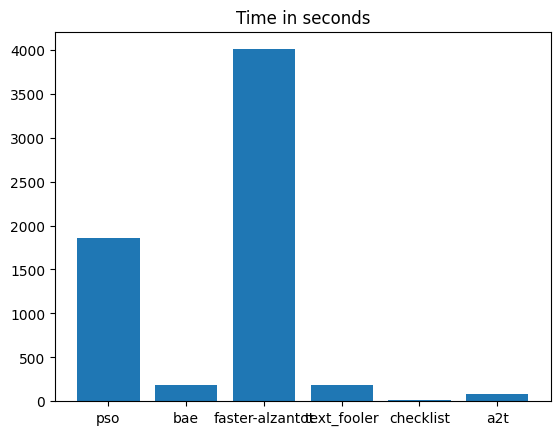

In [12]:
import matplotlib.pyplot as plt

if not times: 
    with open('attack_times.json', 'r') as f:
        times = json.load(f)
names, speeds = zip(*times.items())
plt.bar(names, speeds)
plt.title("Time in seconds")

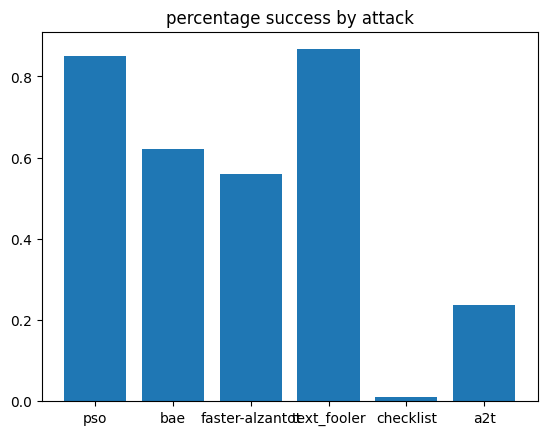

In [8]:
import matplotlib.pyplot as plt


attacks = {
        'pso': pso,
        'bae': bae,
        'faster-alzantot': fast_alanztot,
        'text_fooler': text_fooler,
        'checklist': checklist,
        'a2t': a2t
          }


agg_success = []
for metric in attacks.keys():
    df_res = pd.read_csv('%s_results.csv' % (metric))
    agg_success.append(len(df_res[df_res['result_type'] == 'Successful'])/len(df_res))


plt.bar(attacks.keys(),agg_success)
plt.title("percentage success by attack")
plt.show()

In [16]:
tf_results = pd.read_csv('text_fooler_results.csv')
tf_results

,original_text,perturbed_text,original_score,perturbed_score,original_output,perturbed_output,ground_truth_output,num_queries,result_type
0,"A [[rating]] of ""1"" does not [[begin]] to [[ex...","A [[notations]] of ""1"" does not [[outset]] to ...",0.003706,0.599852,0,1,0,334,Successful
1,[[I]] sat through this on [[TV]] [[hoping]] [[...,[[me]] sat through this on [[TELLY]] [[meantim...,0.006769,0.549002,0,1,0,107,Successful
2,The [[problem]] is the role of the characters ...,The [[themes]] is the role of the characters i...,0.183896,0.936410,0,1,0,55,Successful
3,Probably New Zealands [[worst]] Movie ever mad...,Probably New Zealands [[finest]] Movie ever ma...,0.002908,0.756265,0,1,0,48,Successful
4,"[[Cheap]], amateurish, [[unimaginative]], expl...","[[Cheapest]], amateurish, [[uninspiring]], exp...",0.003019,0.536421,0,1,0,202,Successful
...,...,...,...,...,...,...,...,...,...
303,This movie is a [[desperate]] attempt to ride ...,This movie is a [[anguished]] attempt to ride ...,0.387426,0.597852,0,1,0,56,Successful
304,A [[quite]] easy to watch [[tale]] of 2 thieve...,A [[too]] easy to watch [[storeys]] of 2 thiev...,0.002488,0.864408,1,0,1,80,Successful
305,"Awful [[dreams]], wild premonitions, blasphemy...","Awful [[fantasized]], wild premonitions, blasp...",0.002643,0.982961,1,0,1,49,Successful
306,I saw this Film one midnight and I can say tha...,I saw this Film one midnight and I can say tha...,0.006467,0.931423,0,1,0,39,Successful


In [17]:
a2t_results = pd.read_csv('a2t_results.csv')
a2t_results

,original_text,perturbed_text,original_score,perturbed_score,original_output,perturbed_output,ground_truth_output,num_queries,result_type
0,"A [[rating]] of ""1"" does not [[begin]] to expr...","A [[punctuation]] of ""1"" does not [[started]] ...",0.003706,0.007918,0,0,0,59,Failed
1,I [[sat]] through this on [[TV]] [[hoping]] be...,I [[oin]] through this on [[TELEVISIONS]] [[aw...,0.006769,0.091530,0,0,0,14,Failed
2,The [[problem]] is the role of the characters ...,The [[difficulties]] is the role of the charac...,0.183896,0.592420,0,1,0,4,Successful
3,[[Probably]] [[New]] Zealands worst [[Movie]] ...,[[Arguably]] [[Newest]] Zealands worst [[Film]...,0.002908,0.007220,0,0,0,27,Failed
4,"[[Cheap]], [[amateurish]], unimaginative, expl...","[[Cheaper]], [[unprofessional]], unimaginative...",0.003019,0.005516,0,0,0,25,Failed
...,...,...,...,...,...,...,...,...,...
303,This [[movie]] is a desperate attempt to ride ...,This [[cinematic]] is a desperate attempt to r...,0.387426,0.556543,0,1,0,9,Successful
304,A [[quite]] easy to watch [[tale]] of 2 thieve...,A [[abundantly]] easy to watch [[narratives]] ...,0.002488,0.005371,1,1,1,34,Failed
305,"[[Awful]] dreams, wild premonitions, blasphemy...","[[Abominable]] dreams, wild premonitions, blas...",0.002643,0.022644,1,1,1,23,Failed
306,I [[saw]] this [[Film]] one midnight and I can...,I [[witnessed]] this [[Films]] one midnight an...,0.006467,0.684914,0,1,0,23,Successful


In [18]:
checklist_results = pd.read_csv('checklist_results.csv')
checklist_results

,original_text,perturbed_text,original_score,perturbed_score,original_output,perturbed_output,ground_truth_output,num_queries,result_type
0,"A rating of ""[[1]]"" [[does]] [[not]] begin to ...","A rating of ""[[2]]"" [[doesn't]] begin to expre...",0.003706,0.003425,0,0,0,4,Failed
1,I sat through this on TV hoping because of the...,I sat through this on TV hoping because of the...,0.006769,0.011819,0,0,0,8,Failed
2,The problem is the role of the characters in t...,The problem is the role of the characters in t...,0.183896,0.183896,0,0,0,1,Failed
3,Probably New Zealands worst Movie ever madeThe...,Probably New Zealands worst Movie ever madeThe...,0.002908,0.002676,0,0,0,2,Failed
4,"Cheap, amateurish, unimaginative, exploitative...","Cheap, amateurish, unimaginative, exploitative...",0.003019,0.003229,0,0,0,4,Failed
...,...,...,...,...,...,...,...,...,...
303,This movie is a desperate attempt to ride the ...,This movie is a desperate attempt to ride the ...,0.387426,0.387426,0,0,0,1,Failed
304,"A quite easy to watch tale of 2 thieves, with ...","A quite easy to watch tale of 2 thieves, with ...",0.002488,0.002488,1,1,1,1,Failed
305,"Awful dreams, wild premonitions, blasphemy and...","Awful dreams, wild premonitions, blasphemy and...",0.002643,0.003604,1,1,1,7,Failed
306,I saw this Film [[one]] midnight and I can say...,I saw this Film [[two]] midnight and I can say...,0.006467,0.006393,0,0,0,2,Failed


NameError: name 'title' is not defined

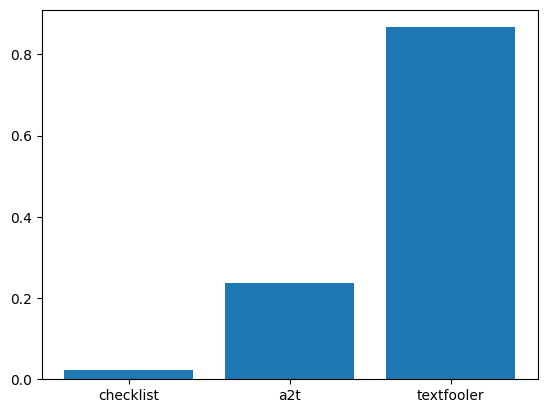

In [39]:
import matplotlib.pyplot as plt

agg_success = []
agg_success.append(len(checklist_results[checklist_results['result_type'] == 'Successful'])/len(checklist_results))
agg_success.append(len(a2t_results[a2t_results['result_type'] == 'Successful'])/len(a2t_results))
agg_success.append(len(tf_results[tf_results['result_type'] == 'Successful'])/len(tf_results))

plt.bar(['checklist', 'a2t', 'textfooler'],agg_success)
title("percentage success")
plt.show()

In [ ]:
from textattack import Attack
from textattack.attack_recipes import TextFoolerJin2019


attack = TextFoolerJin2019.build(model_wrapper)

for index, Sentiments in list(df.itertuples(index=False)):
    result = attack.attack(index, Sentiments)
    print(result.__str__(color_method='ansi'))

In [ ]:
from textattack import Attack
from textattack.search_methods import GreedySearch
from textattack.constraints.pre_transformation import RepeatModification, StopwordModification
from textattack.goal_functions import UntargetedClassification
from textattack.transformations import WordSwapEmbedding
from textattack.constraints.pre_transformation import RepeatModification
from textattack.constraints.pre_transformation import StopwordModification

# We'll use untargeted classification as the goal function.
goal_function = UntargetedClassification(model_wrapper)
# We'll to use our WordSwapEmbedding as the attack transformation.
transformation = WordSwapEmbedding() 
# We'll constrain modification of already modified indices and stopwords
constraints = [RepeatModification(),
               StopwordModification()]
# We'll use the Greedy search method
search_method = GreedySearch()
# Now, let's make the attack from the 4 components:
attack = Attack(goal_function, constraints, transformation, search_method)